<a href="https://colab.research.google.com/github/tu55287/Prototype-Learning-for-Frame-Semantic-Parsing-with-Transformers/blob/main/Prototype_Learning_for_Frame_Semantic_Parsing_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 🧠 encode_target_spans_batch encode_sentences_batch
def encode_target_spans_batch(sentences, target_spans_list, tokenizer, model,
                             batch_size=32, max_length=512, train_mode=False, verbose=False):
    """
    批量编码target spans，使用精确定位+平均池化，优化GPU性能
    """

    model.eval()
    device = next(model.parameters()).device  # 只检查一次设备
    all_embeddings = []

    if verbose:
        print(f"🔄 批量编码 {len(sentences)} 个target spans (batch_size={batch_size})...")

    # 根据verbose参数决定是否显示进度条
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding target spans", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    # 检查tokenizer是否支持offset_mapping
    supports_offset_mapping = hasattr(tokenizer, 'is_fast') and tokenizer.is_fast

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]
        batch_spans = target_spans_list[i:i + batch_size]

        # 预处理spans，统一转换为位置坐标
        processed_spans = []
        for j, spans in enumerate(batch_spans):
            sentence = batch_sentences[j]

            # 处理不同格式的spans
            if isinstance(spans, str):
                start = sentence.find(spans.strip())
                if start != -1:
                    processed_spans.append([(start, start + len(spans.strip()))])
                else:
                    processed_spans.append([])
            elif isinstance(spans, list):
                if spans and isinstance(spans[0], str):
                    positions = []
                    for span_text in spans:
                        start = sentence.find(span_text.strip())
                        if start != -1:
                            positions.append((start, start + len(span_text.strip())))
                    processed_spans.append(positions)
                else:
                    normalized = []
                    for span in spans:
                        if isinstance(span, (list, tuple)) and len(span) == 2:
                            normalized.append((int(span[0]), int(span[1])))
                    processed_spans.append(normalized)
            else:
                processed_spans.append([])

        # 批量tokenize - 根据支持情况决定是否使用offset_mapping
        if supports_offset_mapping:
            try:
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_offsets_mapping=True,
                    return_attention_mask=True
                )
                use_offset_mapping = True
            except:
                # Fallback如果offset mapping失败
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_attention_mask=True
                )
                use_offset_mapping = False
        else:
            encoding = tokenizer(
                batch_sentences,
                return_tensors='pt',
                truncation=True,
                max_length=max_length,
                padding=True,
                return_attention_mask=True
            )
            use_offset_mapping = False

        # 直接移动到设备，避免重复转换
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        if use_offset_mapping:
            offset_mappings = encoding['offset_mapping']  # 保持在CPU上

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state

            batch_embeddings = []

            for j in range(len(batch_sentences)):
                target_spans = processed_spans[j]

                if use_offset_mapping:
                    # 精确的offset mapping匹配
                    offset_mapping = offset_mappings[j]
                    selected_indices = []
                    for start_char, end_char in target_spans:
                        for token_idx, (token_start, token_end) in enumerate(offset_mapping):
                            if token_start == 0 and token_end == 0:
                                continue
                            if token_start < end_char and token_end > start_char:
                                selected_indices.append(token_idx)

                    selected_indices = list(set(selected_indices))
                else:
                    # Fallback: 基于线性映射的近似方法
                    selected_indices = []
                    if target_spans:
                        sentence_len = len(batch_sentences[j])
                        seq_len = attention_mask[j].sum().item() - 2  # 减去[CLS]和[SEP]

                        for start_char, end_char in target_spans:
                            start_token = int((start_char / sentence_len) * seq_len) + 1
                            end_token = int((end_char / sentence_len) * seq_len) + 1
                            start_token = max(1, min(start_token, seq_len))
                            end_token = max(start_token, min(end_token, seq_len))
                            selected_indices.extend(range(start_token, end_token + 1))

                        selected_indices = list(set(selected_indices))

                if selected_indices:
                    selected_hidden = last_hidden[j, selected_indices, :]
                    embedding = selected_hidden.mean(dim=0)
                else:
                    valid_mask = attention_mask[j].bool()
                    valid_hidden = last_hidden[j][valid_mask]
                    embedding = valid_hidden[1:-1].mean(dim=0) if len(valid_hidden) > 2 else valid_hidden.mean(dim=0)

                batch_embeddings.append(embedding)

            # 在GPU上堆叠，一次性转换
            batch_embeddings_tensor = torch.stack(batch_embeddings)
            all_embeddings.append(batch_embeddings_tensor)

    # 拼接并返回
    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


def encode_sentences_batch(sentences, tokenizer, model, batch_size=32,
                          max_length=512, train_mode=False, verbose=False):
    """
    批量句子编码函数，使用CLS token，优化GPU性能
    """
    model.eval()
    device = next(model.parameters()).device  # 只检查一次设备
    all_embeddings = []

    if verbose:
        print(f"🔄 批量编码 {len(sentences)} 个句子 (batch_size={batch_size})...")

    # 根据verbose参数决定是否显示进度条
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding sentences", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]

        # 批量tokenize
        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding=True,
            return_attention_mask=True
        )

        # 直接移动到设备，使用non_blocking优化
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings)

    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings

In [2]:
# @title 🧠 extract_frame_prototypes

def extract_frame_prototypes(model, tokenizer, df, batch_size=64):
    """
    提取frame原型，使用平均pooling

    Args:
        model: 训练好的Transformer模型
        tokenizer: HuggingFace分词器
        df: 包含训练样本的DataFrame
        batch_size: 批处理大小

    Returns:
        dict: 映射frame名称到原型向量的字典
    """

    model.eval()
    frame_prototypes = {}
    frame_groups = df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="提取frame原型"):
        sentences = frame_df['sentence'].tolist()
        target_spans_list = frame_df['target_spans'].tolist()

        # 批量编码target spans
        target_embeddings = encode_target_spans_batch(
            sentences, target_spans_list, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )

        # 计算平均原型
        prototype = target_embeddings.mean(dim=0).cpu().numpy()
        frame_prototypes[frame_name] = prototype

    print(f"✅ 提取了 {len(frame_prototypes)} 个frame原型")
    return frame_prototypes



In [3]:
# @title 🧠 evaluate_target_known evaluate_target_unknown

def evaluate_target_known(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    Target-known评估：给定target span，评估frame分类准确率

    Args:
        model: 训练好的模型
        tokenizer: HuggingFace分词器
        test_df: 测试数据集
        frame_prototypes: 预计算的frame原型字典（可选）
        train_df: 训练数据集（如果没有原型则用于现场计算）
        top_n: 考虑前N个预测
        batch_size: 批处理大小

    Returns:
        dict: 评估结果字典
    """

    model.eval()

    # 获取或计算frame原型
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("必须提供frame_prototypes或train_df之一")
        print("🔄 现场计算frame原型...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("📊 使用已有frame原型")

    # 准备原型矩阵
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(prototype_frames)} 个frame原型")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # 计算cosine相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # 获取top-N预测
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # 降序排列
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # 打印结果
    print(f"\n✅ Target-known评估结果 (Cosine相似度)")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"处理样本: {results['valid_samples']}/{len(test_df)}")

    return results




def evaluate_target_unknown(model, tokenizer, test_df, frame_prototypes=None,
                           train_df=None, top_n=3, batch_size=64,
                           span_strategy='smart_filter'):
    """
    Target-unknown评估：从原始句子预测target spans和frame标签

    Args:
        model: 训练好的模型
        tokenizer: HuggingFace分词器
        test_df: 测试数据集
        frame_prototypes: 预计算的frame原型字典（可选）
        train_df: 训练数据集（如果没有原型则用于现场计算）
        top_n: 评估前N个预测
        batch_size: 批处理大小
        span_strategy: 候选span筛选策略
            - 'stopwords': 停用词过滤（保留do等动词）
            - 'pos_filter': 基于词性标注

    Returns:
        dict: 评估结果字典
    """

    model.eval()

    # 获取或计算frame原型
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("必须提供frame_prototypes或train_df之一")
        print("🔄 现场计算frame原型...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("📊 使用已有frame原型")

    # 准备原型矩阵
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 Target-unknown评估: {len(test_df)} 样本，策略: {span_strategy}")

    # 初始化计数器
    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct_top1 = 0
    frame_correct_top3 = 0
    frame_total = 0
    y_true = []
    y_pred = []

    sentences = test_df["sentence"].unique()

    for sentence in tqdm(sentences, desc="Target-unknown评估"):
        sentence_rows = test_df[test_df["sentence"] == sentence]

        # 收集该句子的所有gold spans和frames
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            if spans and len(spans) > 0:
                # 处理不同格式的spans
                if isinstance(spans, list):
                    if isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        # 位置坐标格式
                        gold_spans.extend([(int(s[0]), int(s[1])) for s in spans])
                        gold_frames.extend([row["frame_name"]] * len(spans))
                    elif isinstance(spans[0], str):
                        # 字符串格式，需要在句子中找位置
                        for span_text in spans:
                            start = sentence.find(span_text.strip())
                            if start != -1:
                                gold_spans.append((start, start + len(span_text.strip())))
                                gold_frames.append(row["frame_name"])

        target_total += len(gold_spans)

        # 生成候选spans
        candidate_spans = _generate_candidate_spans(sentence, tokenizer, span_strategy)
        target_predicted += len(candidate_spans)

        if not candidate_spans:
            continue

        # 批量编码候选spans
        try:
            candidate_sentences = [sentence] * len(candidate_spans)
            candidate_embeddings = encode_target_spans_batch(
                candidate_sentences, candidate_spans, tokenizer, model,
                batch_size=batch_size, train_mode=False
            ).cpu().numpy()

            # 计算相似度
            similarities = cosine_similarity(candidate_embeddings, prototype_matrix)

            # 处理每个候选span
            for i, span in enumerate(candidate_spans):
                scores = similarities[i]
                top_indices = np.argsort(scores)[-top_n:][::-1]
                top_preds = [prototype_frames[idx] for idx in top_indices]

                # 检查是否与gold span重叠
                for j, g_span in enumerate(gold_spans):
                    if _spans_overlap(span, g_span):
                        target_correct += 1
                        frame_total += 1

                        gold_frame = gold_frames[j]
                        pred_frame = top_preds[0]

                        y_true.append(gold_frame)
                        y_pred.append(pred_frame)

                        if pred_frame == gold_frame:
                            frame_correct_top1 += 1
                        if gold_frame in top_preds:
                            frame_correct_top3 += 1
                        break

        except Exception as e:
            print(f"⚠️ 处理句子失败: {e}")
            continue

    # 计算指标
    target_precision = target_correct / target_predicted if target_predicted > 0 else 0
    target_recall = target_correct / target_total if target_total > 0 else 0
    target_f1 = (2 * target_precision * target_recall / (target_precision + target_recall)
                 if (target_precision + target_recall) > 0 else 0)

    top1_accuracy = frame_correct_top1 / frame_total if frame_total > 0 else 0
    top3_accuracy = frame_correct_top3 / frame_total if frame_total > 0 else 0

    # 计算frame分类指标
    if y_true and y_pred:
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="macro", zero_division=0, labels=list(set(y_true))
        )
        weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0, labels=list(set(y_true))
        )
    else:
        macro_p = macro_r = macro_f1 = 0
        weighted_p = weighted_r = weighted_f1 = 0

    results = {
        "target_precision": target_precision,
        "target_recall": target_recall,
        "target_f1": target_f1,
        "frame_top1_accuracy": top1_accuracy,
        "frame_top3_accuracy": top3_accuracy,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f1,
        "target_total": target_total,
        "target_predicted": target_predicted,
        "target_correct": target_correct,
        "frame_total": frame_total
    }

    # 打印结果
    print(f"\n✅ Target-unknown评估结果 ({span_strategy})")
    print(f"Target F1: {results['target_f1']:.4f} (P:{target_precision:.4f}, R:{target_recall:.4f})")
    print(f"Frame Top-1: {results['frame_top1_accuracy']:.4f}")
    print(f"Frame Top-3: {results['frame_top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"统计: 预测{target_predicted}个spans，命中{target_correct}个，总计{target_total}个gold spans")

    return results


def _generate_candidate_spans(sentence, tokenizer, strategy='stopwords'):
    """生成候选target spans"""

    if strategy == 'stopwords':
        # 改进的停用词方法：只过滤真正的功能词，保留可能的target words
        # 去掉do, go, run等可能的动词target words
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
            'before', 'after', 'above', 'below', 'between', 'among', 'under', 'over',
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'shall',
            'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we',
            'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her',
            'its', 'our', 'their'
        }

        encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        offsets = encoding["offset_mapping"]
        spans = []

        for start, end in offsets:
            if start == end:
                continue
            token = sentence[start:end].strip()

            # 允许单字母（如 'I', 'a'作为target word）和任何非停用词
            if (token.lower() not in stop_words and
                any(c.isalnum() for c in token) and  # 包含字母或数字
                not all(c in '.,!?;:"()[]{}' for c in token)):  # 不是纯标点
                spans.append((start, end))
        return spans

    elif strategy == 'pos_filter':
        # 基于词性标注（需要安装spacy）
        try:
            import spacy
            nlp = spacy.load("en_core_web_sm")
            doc = nlp(sentence)

            spans = []
            for token in doc:
                # 保留名词、动词、形容词、副词，允许单字母词
                if (token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and
                    not token.is_stop):  # 去掉长度限制
                    spans.append((token.idx, token.idx + len(token.text)))
            return spans

        except ImportError:
            print("⚠️ spacy未安装，回退到stopwords方法")
            return _generate_candidate_spans(sentence, tokenizer, 'stopwords')

    else:
        # 默认回退到stopwords
        return _generate_candidate_spans(sentence, tokenizer, 'stopwords')


def _spans_overlap(span1, span2):
    """检查两个span是否重叠"""
    return span1[1] > span2[0] and span1[0] < span2[1]


In [4]:
# @title ⚙️ Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from tqdm.auto import tqdm
import random
import nltk
from sklearn.cluster import KMeans, AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pickle
import os
import warnings
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import json
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
import shutil
from datetime import datetime

from collections import Counter
from matplotlib.patches import FancyArrowPatch
from nltk.corpus import framenet as fn
import pprint

from datetime import datetime, timezone, timedelta
from google.colab import drive
import copy
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os, pickle

import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import framenet as fn

from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer



from sklearn.metrics import precision_recall_fscore_support, davies_bouldin_score
from sklearn.cluster import KMeans

from collections import defaultdict, Counter


In [7]:
# @title ⚙️ Environment Setup: Download FrameNet, Enable GPU, Set Seed

"""
Prototype Learning for Frame Semantic Parsing with Transformers

"""
print("Downloading all required NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

# Download FrameNet data (if not already available)
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn

# Set device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====== Reproducibility: Set Random Seed ======

def set_seed(seed=42):
    """
    Set random seed for reproducibility across Python, NumPy, PyTorch, CuDNN, and OS hash.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)     # For hash() stability
    random.seed(seed)                            # Python RNG
    np.random.seed(seed)                         # NumPy RNG
    torch.manual_seed(seed)                      # PyTorch CPU
    torch.cuda.manual_seed(seed)                 # Single-GPU
    torch.cuda.manual_seed_all(seed)             # Multi-GPU
    torch.backends.cudnn.deterministic = True    # CuDNN deterministic
    torch.backends.cudnn.benchmark = False       # Disable CuDNN autotune

# Call early in the script
set_seed(42)

# 挂载 Google Drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


Using device: cuda
Mounted at /content/drive


In [ ]:
import os
import pickle

# 设置路径（你之前保存的位置）
load_dir = "/content/drive/MyDrive/more50/framenet_data"

# 加载主数据 DataFrame
with open(os.path.join(load_dir, "framenet_df.pkl"), "rb") as f:
    framenet_df = pickle.load(f)

# 加载 frame 定义
with open(os.path.join(load_dir, "frame_definitions.pkl"), "rb") as f:
    frame_definitions = pickle.load(f)

# 加载 frame 语义关系
with open(os.path.join(load_dir, "frame_relations.pkl"), "rb") as f:
    frame_relations = pickle.load(f)

print("✅ FrameNet 数据加载完毕")
print(f"📄 Total exemplars: {len(framenet_df)}")
print(f"🧠 Unique frames: {framenet_df['frame_name'].nunique()}")
print(f"📚 Sample columns: {list(framenet_df.columns)}")


✅ FrameNet 数据加载完毕
📄 Total exemplars: 200750
🧠 Unique frames: 1014
📚 Sample columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']


In [8]:
# @title 📦 Extract FrameNet Data

"""
This module extracts structured data from FrameNet 1.7, including both semantic frame exemplars
and the inter-frame graph structure. It performs the following steps:

1. Constructs a directed frame-to-frame graph from all definable FrameNet relations,
   using role-specific directionality and edge labels for each relation type.

2. Iterates over all exemplars to extract sentence-level annotations, including:
   - Target word spans
   - Frame names and definitions
   - Lexical units (LUs) and LU definitions
   - Frame elements and their textual spans

3. Aggregates the extracted information into a structured DataFrame, filters by a per-frame limit,
   and saves both the data and metadata (frame definitions and frame relations) for future use.
"""

# ========== Frame-to-Frame Relation Definitions ==========
RELATION_FIELDS = {
    "Inheritance": ("Parent", "Child"),
    "Using": ("Parent", "Child"),
    "Subframe": ("Complex", "Component"),
    "Perspective_on": ("Neutral", "Perspectivized"),
    "Precedes": ("Earlier", "Later"),
    "Causative_of": ("Causative", "Inchoative/state"),
    "Inchoative_of": ("Inchoative", "Stative"),
    "ReFraming_Mapping": ("Source", "Target"),
    "Metaphor": ("Source", "Target"),
    "See_also": ("MainEntry", "ReferringEntry")
}

RELATION_LABELS = {
    "Inheritance": ("Is Inherited by", "Inherits from"),
    "Using": ("Is Used by", "Uses"),
    "Subframe": ("Has Subframe(s)", "Subframe of"),
    "Perspective_on": ("Perspective on", "Is Perspectivized in"),
    "Precedes": ("Precedes", "Is Preceded by"),
    "Causative_of": ("Is Causative of", "Is Inchoative of"),
    "Inchoative_of": ("Is Inchoative of", "Is Causative of"),
    "ReFraming_Mapping": ("Reframes", "Is Reframed by"),
    "Metaphor": ("Metaphor: Source", "Metaphor: Target"),
    "See_also": ("See also", "See also")
}


# 所有支持的关系类型
FRAMENET_RELATION_TYPES = [
    'Inheritance', 'Using', 'See_also', 'Perspective_on', 'ReFraming_Mapping',
    'Causative_of', 'Subframe', 'Precedes', 'Inchoative_of', 'Metaphor', 'Unrelated'
]


# === 反向关系映射（保留） ===
REVERSE_RELATIONS = {
    'Parent': 'Child',
    'Child': 'Parent',
    'Uses': 'Used_by',
    'Used_by': 'Uses',
    'Perspective_on': 'Perspectivised_by',
    'Perspectivised_by': 'Perspective_on',
    'Includes_subframe': 'Subframe_of',
    'Precedes': 'Follows',
    'Follows': 'Precedes',
    'Initiates': 'Initiated_by',
    'Initiated_by': 'Initiates',
    'Causes': 'Caused_by',
    'Caused_by': 'Causes',
    'See_also': 'See_also'
}


# ========== Main Extraction Function ==========
def extract_framenet_data(max_per_frame=50, save_path="framenet_data.pkl"):
    print("Extracting FrameNet data...")
    exemplar_data = []
    frame_definitions = {}
    frame_relations = defaultdict(list)
    skipped = 0

    # Step 1: Extract frame definitions and frame-frame relations
    for frame in tqdm(fn.frames(), desc="Extracting frame definitions and relations"):
        frame_name = frame.name
        frame_definitions[frame_name] = frame.definition

        for relation in frame.frameRelations:
            try:
                rel_type = relation.type.name
                if rel_type not in RELATION_FIELDS:
                    continue
                source_field, target_field = RELATION_FIELDS[rel_type]
                label_out, label_in = RELATION_LABELS.get(rel_type, (rel_type, rel_type))
                source = getattr(relation, source_field, None)
                target = getattr(relation, target_field, None)
                if not source or not target:
                    continue

                if hasattr(source, "name") and source.name == frame_name:
                    frame_relations[frame_name].append((target.name, rel_type, "out", label_out))
                elif hasattr(target, "name") and target.name == frame_name:
                    frame_relations[frame_name].append((source.name, rel_type, "in", label_in))
                elif rel_type == "See_also":
                    if hasattr(source, "name") and source.name == frame_name:
                        frame_relations[frame_name].append((target.name, rel_type, "undirected", label_out))
                    elif hasattr(target, "name") and target.name == frame_name:
                        frame_relations[frame_name].append((source.name, rel_type, "undirected", label_in))
            except Exception:
                continue

    # Step 2: Extract exemplar annotations
    for ex in tqdm(fn.exemplars(), desc="Extracting exemplars"):
        try:
            sentence = ex["text"]
            frame = ex.get("frame")
            frame_name = frame.name if hasattr(frame, "name") else None
            frame_id = frame.ID if hasattr(frame, "ID") else None
            if frame_name is None:
                skipped += 1
                continue

            lu = ex.get("LU")
            lu_name = lu.name if hasattr(lu, "name") else None
            lu_id = lu.ID if hasattr(lu, "ID") else None
            lu_definition = lu.definition if hasattr(lu, "definition") else None

            annotation_sets = ex.get("annotationSet", [])
            if not annotation_sets or len(annotation_sets) < 2:
                skipped += 1
                continue

            target_annotation = annotation_sets[1]
            layers = target_annotation.get("layer", [])
            target_spans, fes, fe_spans = [], defaultdict(list), []

            for layer in layers:
                if layer["name"] == "Target":
                    for label in layer.get("label", []):
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int):
                            target_spans.append((start, end))
                elif layer["name"] == "FE":
                    for label in layer.get("label", []):
                        fe_name = label.get("name")
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int) and fe_name:
                            fes[fe_name].append(sentence[start:end])
                            fe_spans.append({"fe_name": fe_name, "start": start, "end": end})

            if not target_spans:
                skipped += 1
                continue

            target_text = " ".join([sentence[start:end] for start, end in target_spans])

            exemplar_data.append({
                "sentence": sentence,
                "target_spans": target_spans,
                "target_text": target_text,
                "frame_name": frame_name,
                "frame_id": frame_id,
                "lexical_unit": lu_name,
                "lu_id": lu_id,
                "lu_definition": lu_definition,
                "frame_elements": {k: " / ".join(v) for k, v in fes.items()},
                "fe_spans": fe_spans,
            })
        except Exception:
            skipped += 1
            continue

    print(f"[DEBUG] Extracted {len(exemplar_data)} examples; Skipped: {skipped}")
    if not exemplar_data:
        raise ValueError("[DEBUG] No exemplar extracted — logic failure.")

    df = pd.DataFrame(exemplar_data)
    if max_per_frame is not None:
        df = df.groupby("frame_name").head(max_per_frame).reset_index(drop=True)

    df["frame_definition"] = df["frame_name"].map(frame_definitions)

    data_to_save = {
        "dataframe": df,
        "frame_definitions": frame_definitions,
        "frame_relations": dict(frame_relations),
    }

    with open(save_path, "wb") as f:
        pickle.dump(data_to_save, f)

    return data_to_save

# ========== Wrapper: Check Cache or Extract ==========
def load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data",
    df_name="framenet_df.pkl",
    defs_name="frame_definitions.pkl",
    rels_name="frame_relations.pkl",
):
    os.makedirs(save_dir, exist_ok=True)
    df_path = os.path.join(save_dir, df_name)
    defs_path = os.path.join(save_dir, defs_name)
    rels_path = os.path.join(save_dir, rels_name)

    if os.path.exists(df_path) and os.path.exists(defs_path) and os.path.exists(rels_path):
        print("📦 检测到缓存文件，自动加载:")
        with open(df_path, "rb") as f:
            df = pickle.load(f)
        with open(defs_path, "rb") as f:
            frame_definitions = pickle.load(f)
        with open(rels_path, "rb") as f:
            frame_relations = pickle.load(f)
        print(f"✅ 已加载 {len(df)} 条样本，覆盖 {df['frame_name'].nunique()} 个frames")
        return df, frame_definitions, frame_relations

    print("🔍 未找到缓存，开始提取 FrameNet 数据...")
    data = extract_framenet_data(
        max_per_frame=max_per_frame,
        save_path=os.path.join(save_dir, "framenet_data.pkl")
    )

    df = data['dataframe']
    frame_definitions = data['frame_definitions']
    frame_relations = data['frame_relations']

    with open(df_path, "wb") as f:
        pickle.dump(df, f)

    with open(def_path, "wb") as f:
        pickle.dump(frame_definitions, f)

    with open(rel_path, "wb") as f:
        pickle.dump(frame_relations, f)


    print(f"✅ FrameNet 数据提取完成并已保存，共 {len(df)} 条样本")
    return df, frame_definitions, frame_relations

# ========== 🏃‍♂️ 执行运行部分 ==========
df, frame_definitions, frame_relations = load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data"
)

print("\n📊 数据概览:")
print(f"Total extracted samples: {len(df)}")
print(f"Number of distinct frames: {df['frame_name'].nunique()}")
print("\n📄 样例数据:")
print(df.head().to_string())

import pickle

save_dir = "/content/drive/MyDrive/more50/framenet_data"

with open(os.path.join(save_dir, "framenet_df.pkl"), "rb") as f:
    df = pickle.load(f)

print("✅ Loaded df with shape:", df.shape)

📦 检测到缓存文件，自动加载:
✅ 已加载 200750 条样本，覆盖 1014 个frames

📊 数据概览:
Total extracted samples: 200750
Number of distinct frames: 1014

📄 样例数据:
                                                                                                                                                                      sentence  target_spans target_text   frame_name  frame_id lexical_unit  lu_id     lu_definition                                                                                                              frame_elements                                                                                                                                        fe_spans                                                                                                                                                                                                                                                                                                                                                    

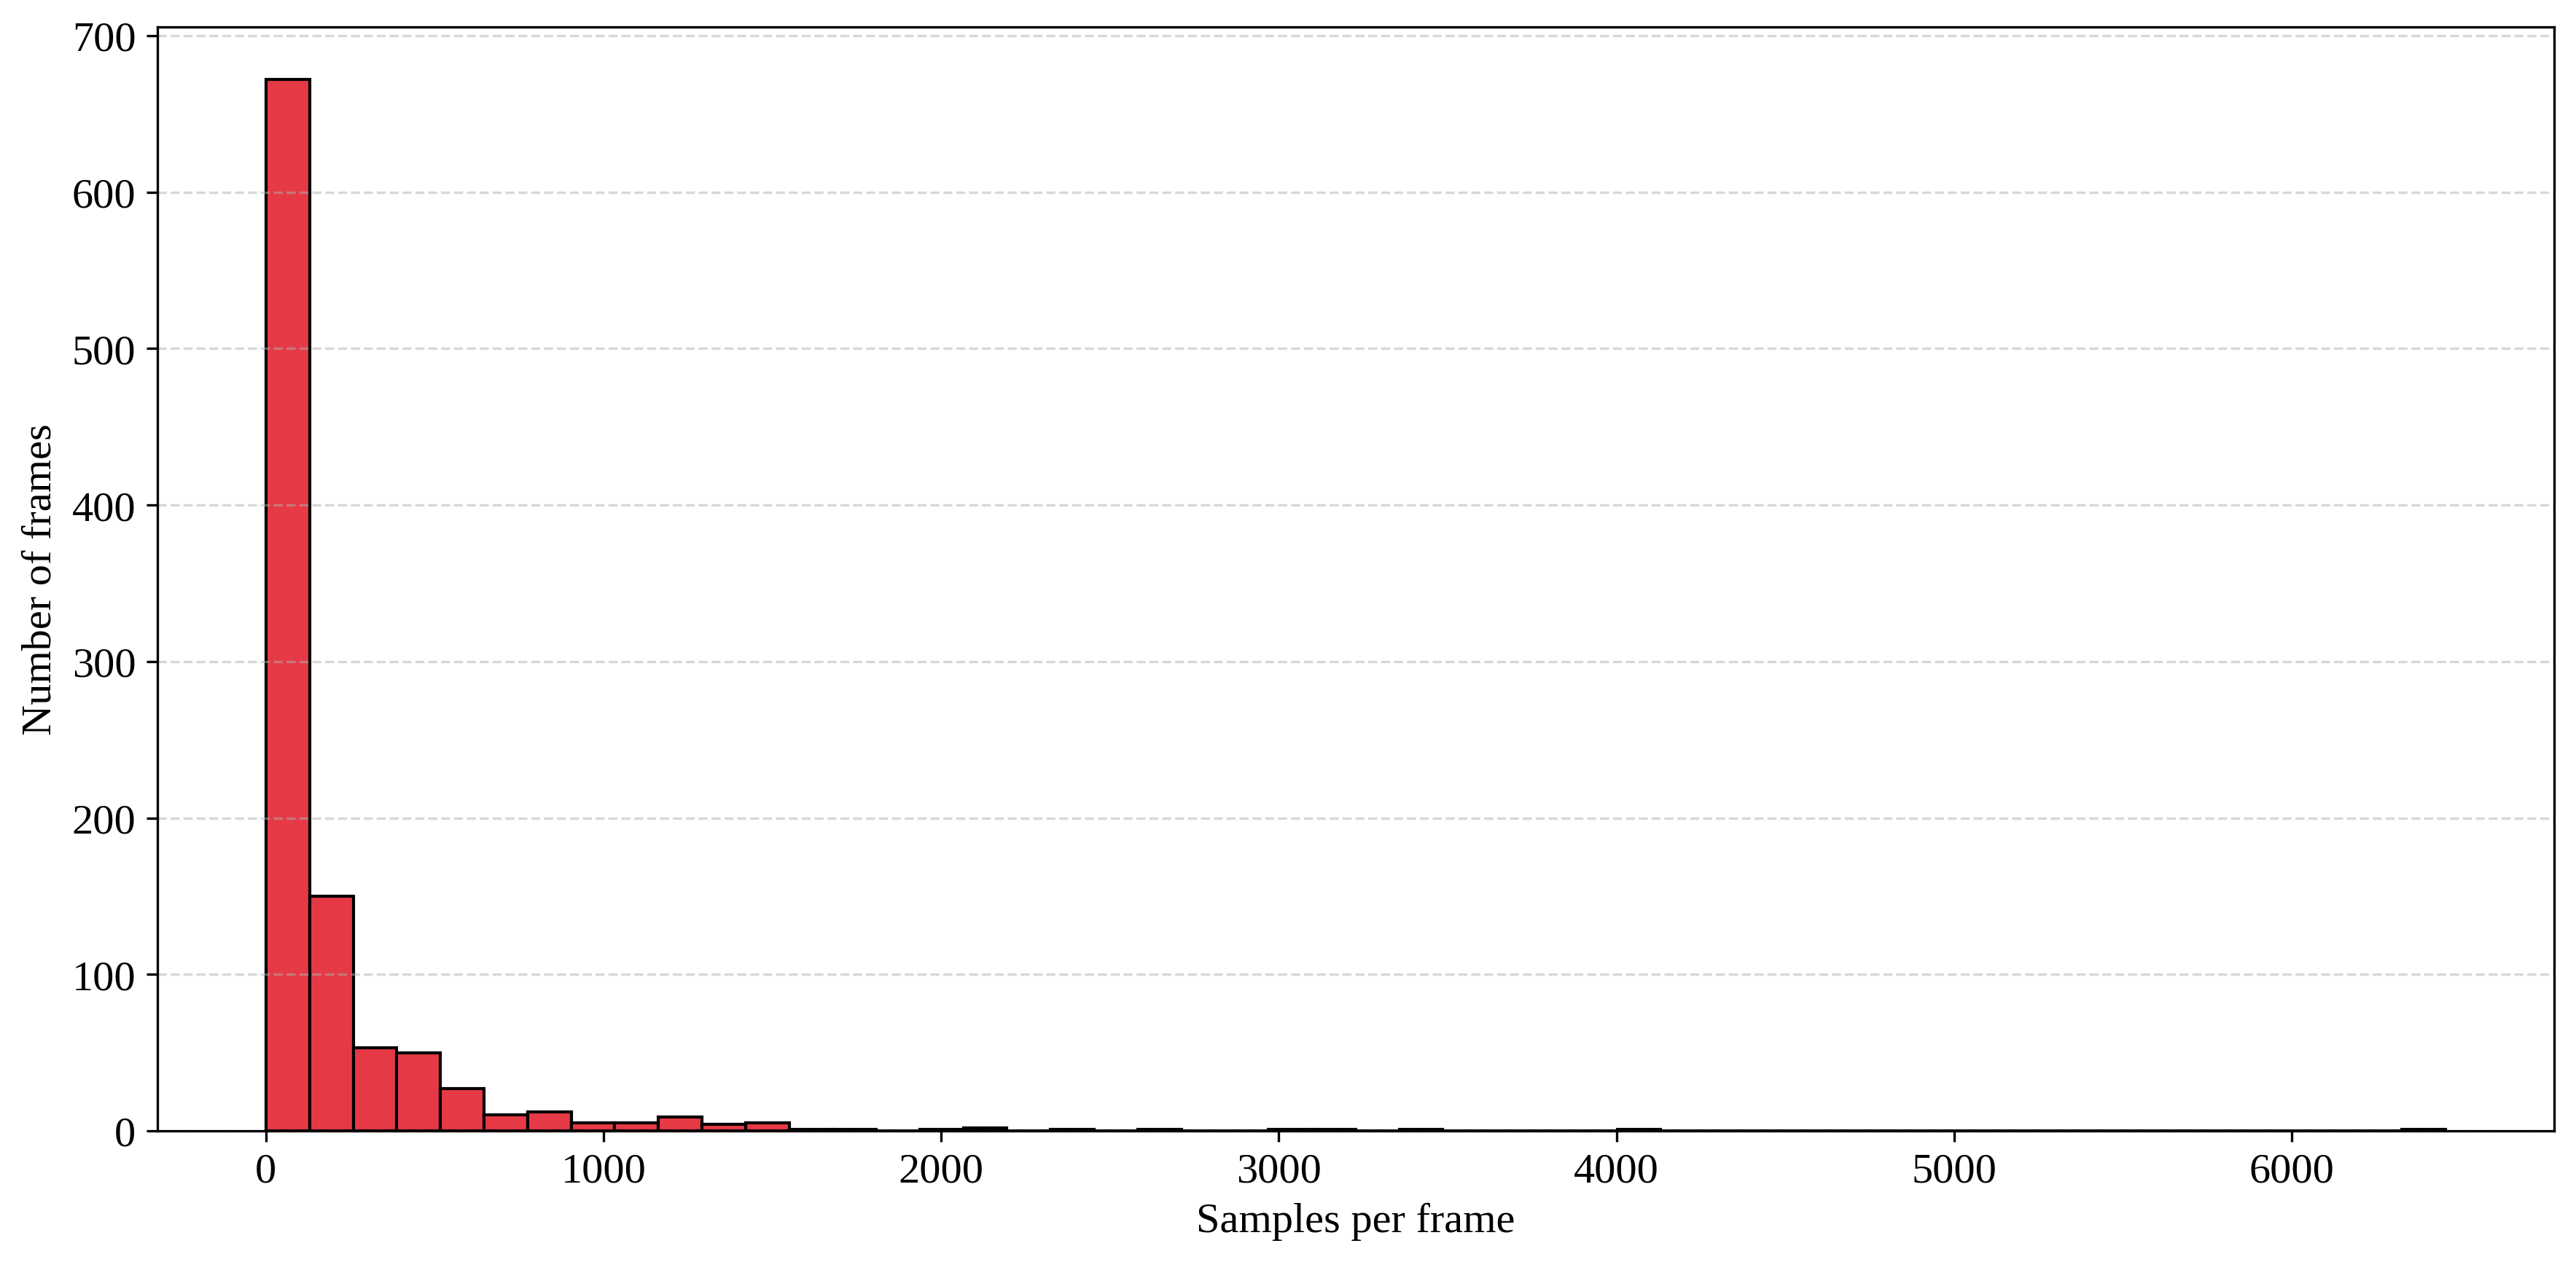

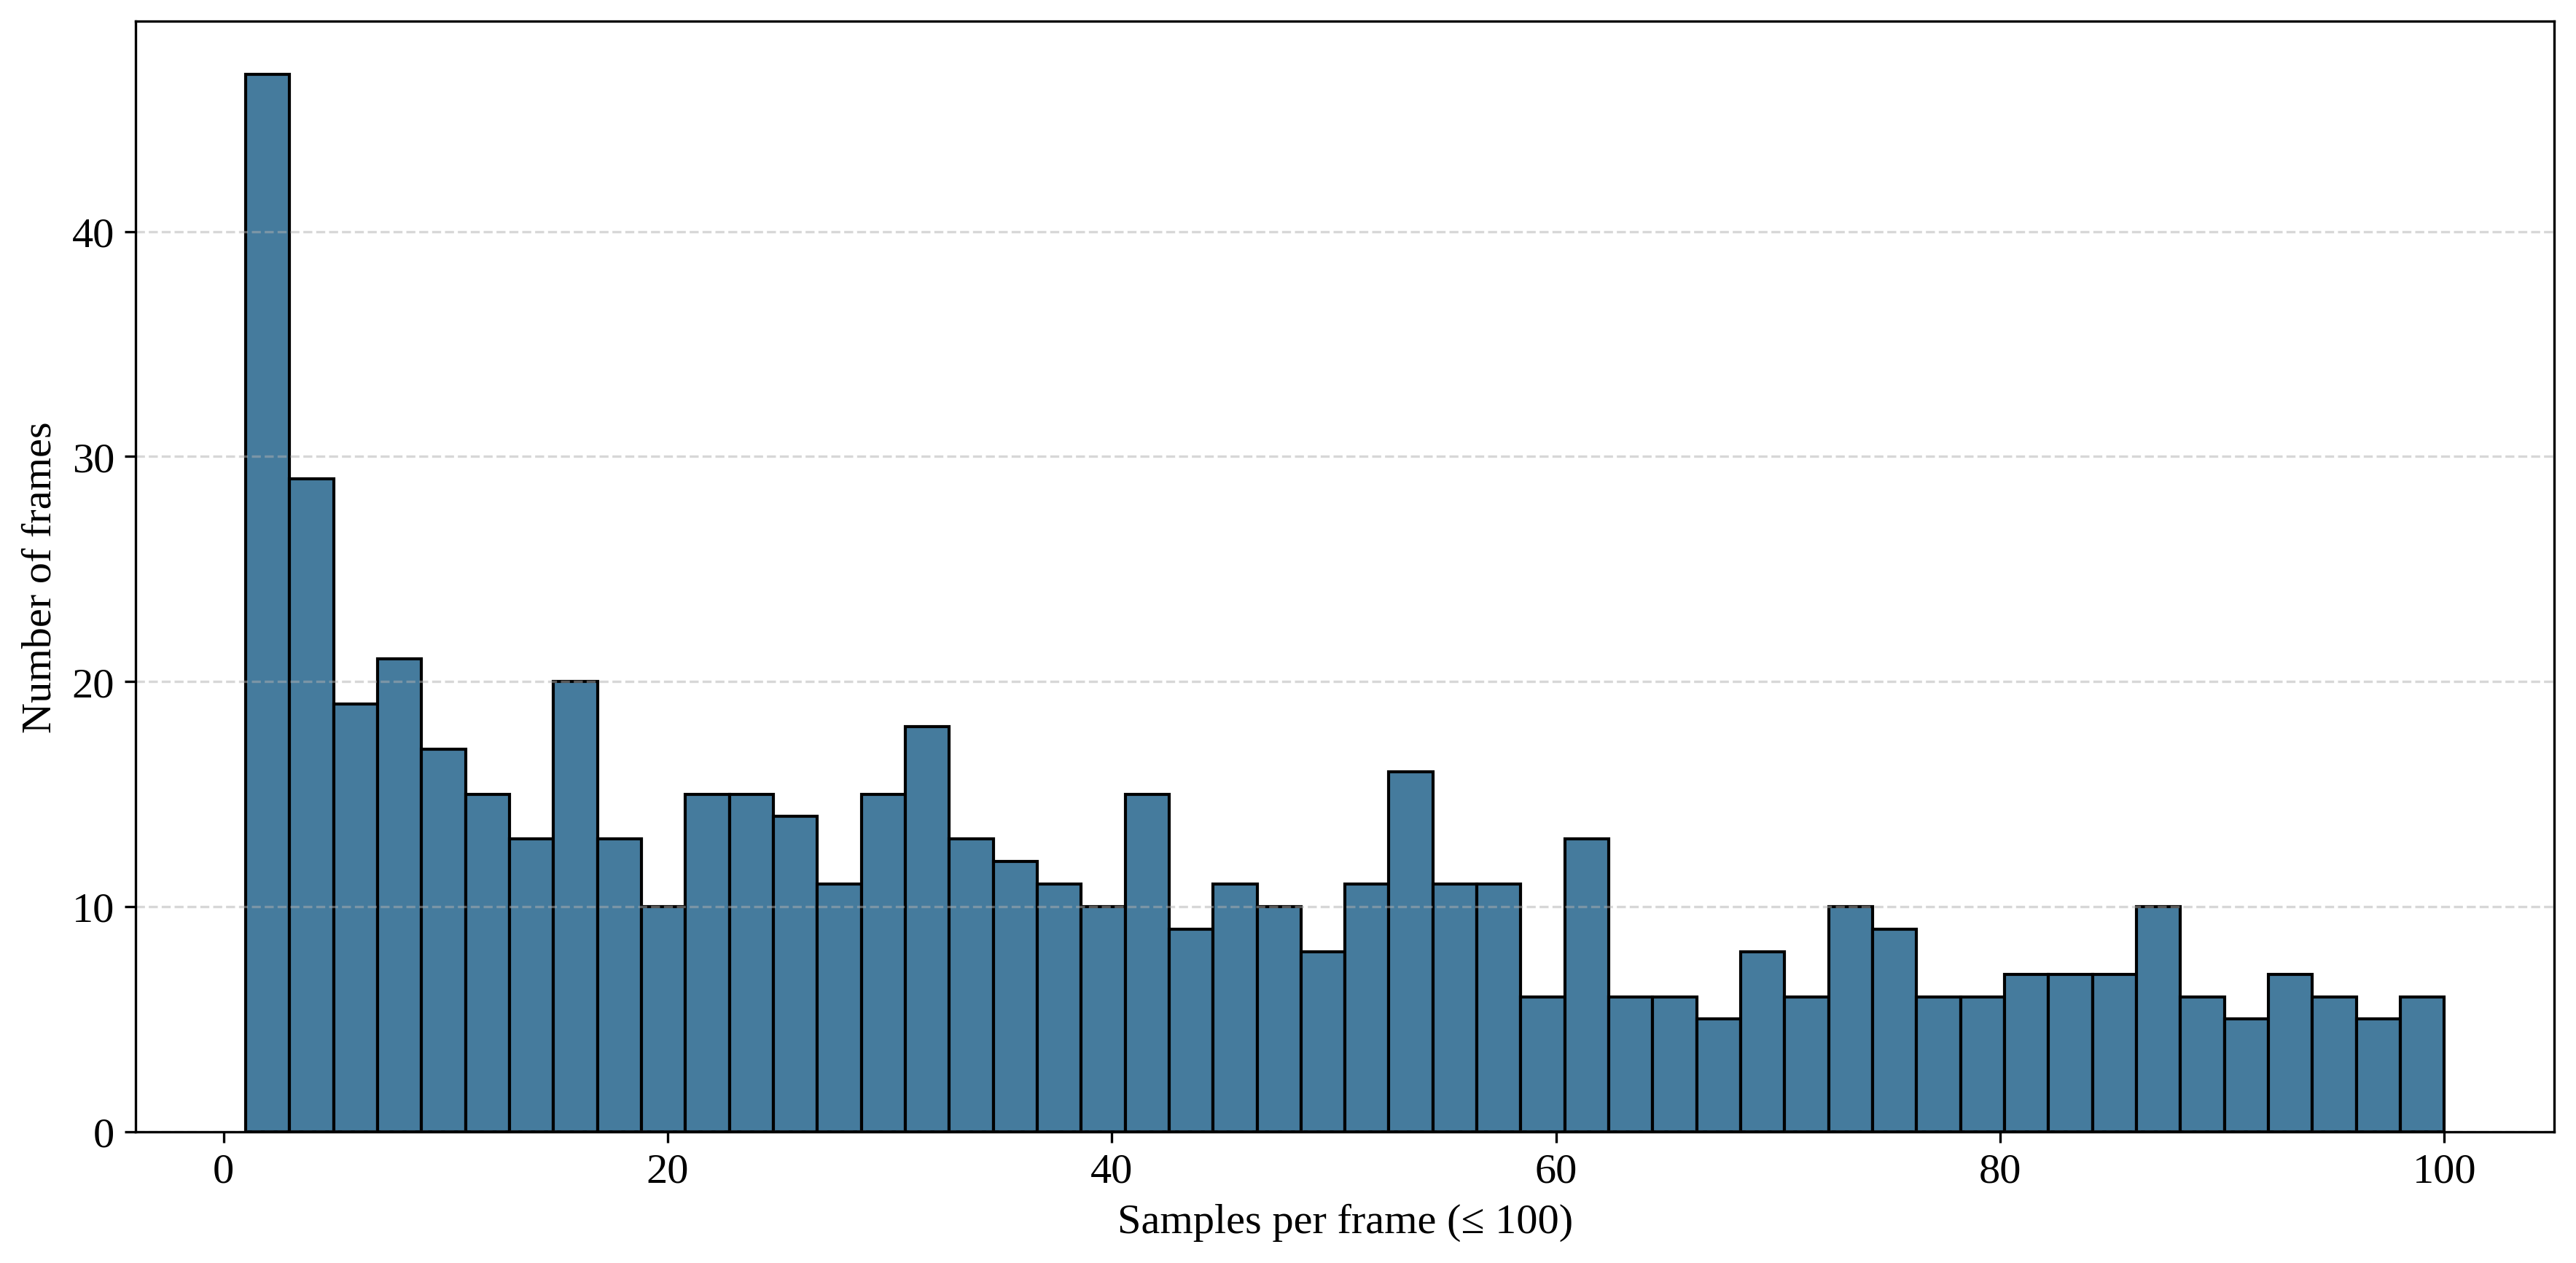

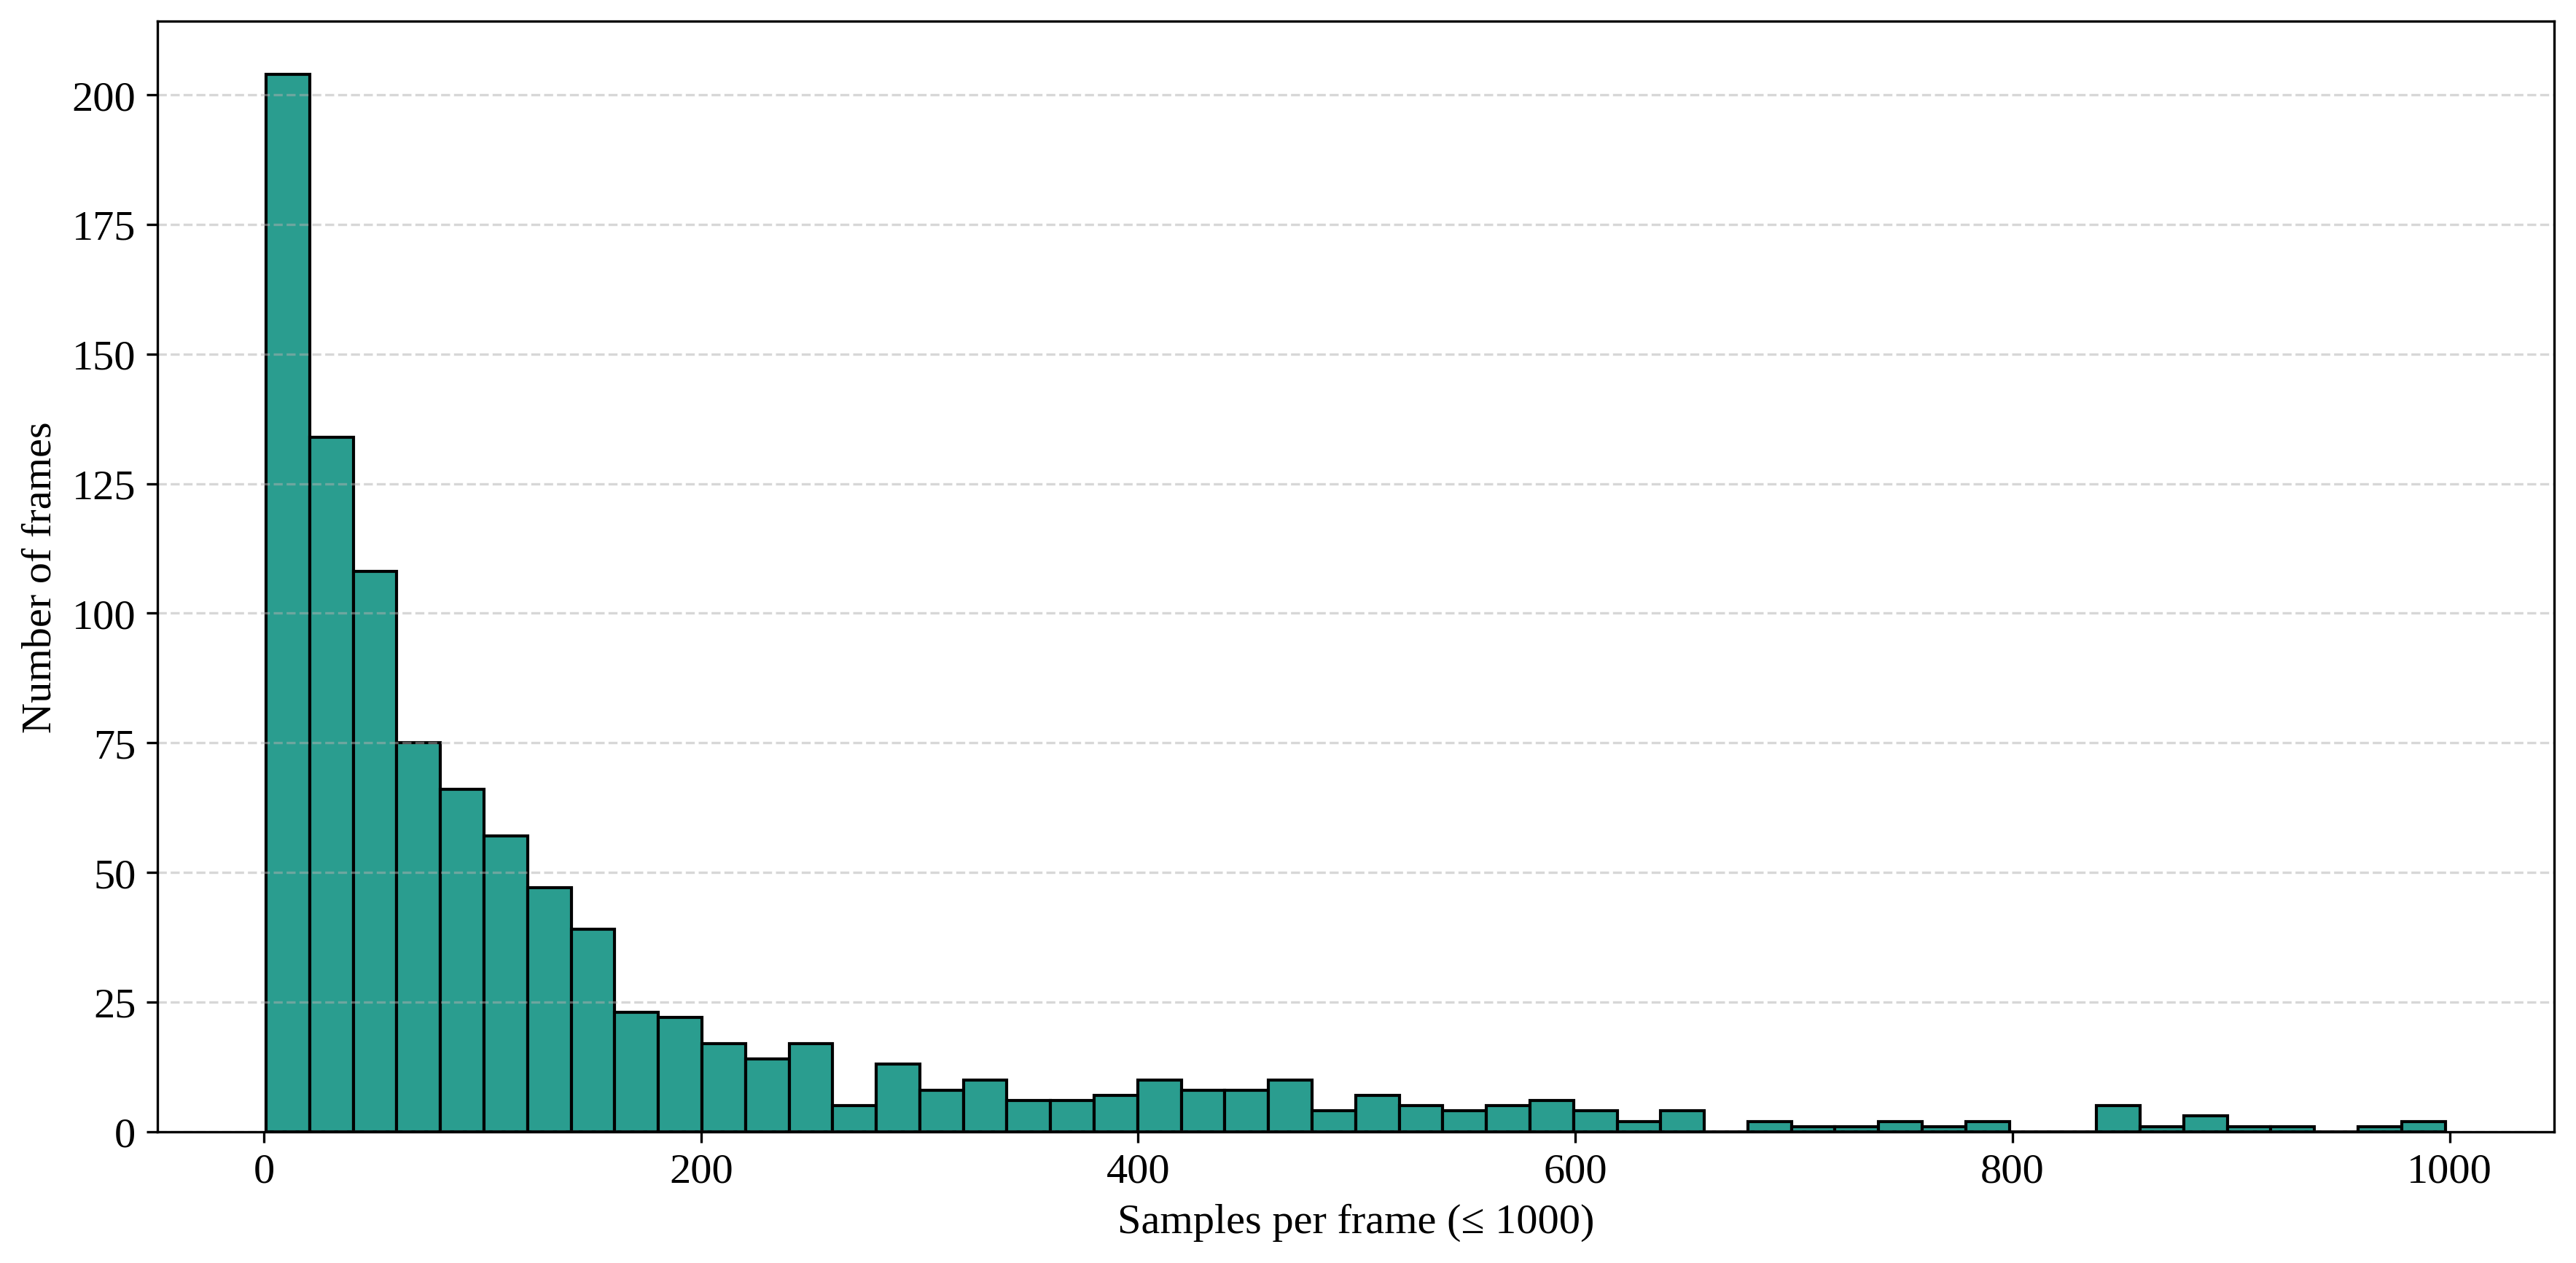

In [ ]:
import matplotlib.pyplot as plt

# ✅ 设置更大字体，便于Word缩放后仍清晰
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # 比原来更大，适合插入文档

# ✅ 获取每个 frame 的样本数
frame_counts = df['frame_name'].value_counts()

# ================= 图1：全集 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts.values, bins=50, color='#e63946', edgecolor='black')
plt.xlabel("Samples per frame")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_full_distribution_hd.png", dpi=300, bbox_inches='tight')  # 保存高清图
plt.show()

# ================= 图2：样本数 ≤ 100 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 100].values, bins=50, color='#457b9d', edgecolor='black')
plt.xlabel("Samples per frame (≤ 100)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under100_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()

# ================= 图3：样本数 ≤ 1000 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 1000].values, bins=50, color='#2a9d8f', edgecolor='black')
plt.xlabel("Samples per frame (≤ 1000)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under1000_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
import pickle
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_pos_from_lu(lexical_unit):
    """从lexical unit中提取词性"""
    if pd.isna(lexical_unit) or not isinstance(lexical_unit, str):
        return 'UNKNOWN'

    lu = lexical_unit.lower()

    # 基于FrameNet的LU命名规则
    if '.v' in lu:
        return 'VERB'
    elif '.n' in lu:
        return 'NOUN'
    elif '.a' in lu:
        return 'ADJ'
    elif '.adv' in lu:
        return 'ADV'
    elif '.prep' in lu:
        return 'PREP'
    elif '.num' in lu:
        return 'NUM'
    elif '.intj' in lu:
        return 'INTJ'
    elif '.art' in lu:
        return 'ART'
    else:
        return 'OTHER'

def analyze_frame_pos_preferences(df):
    """分析每个frame的词性偏好"""

    print("=== Frame-词性偏好分析 ===")
    print(f"分析数据: {len(df)} 个样本, {df['frame_name'].nunique()} 个frames")

    # 提取词性信息
    df['pos'] = df['lexical_unit'].apply(extract_pos_from_lu)

    # 统计整体词性分布
    overall_pos_counts = df['pos'].value_counts()
    print(f"\n整体词性分布:")
    for pos, count in overall_pos_counts.items():
        print(f"  {pos}: {count} ({count/len(df):.1%})")

    # 统计每个frame的词性分布
    frame_pos_stats = defaultdict(lambda: defaultdict(int))

    for _, row in df.iterrows():
        frame = row['frame_name']
        pos = row['pos']
        frame_pos_stats[frame][pos] += 1

    # 计算每个frame的词性偏好分布
    frame_pos_preferences = {}

    for frame, pos_counts in frame_pos_stats.items():
        total = sum(pos_counts.values())
        if total > 0:
            preferences = {pos: count/total for pos, count in pos_counts.items()}
            frame_pos_preferences[frame] = preferences

    return frame_pos_stats, frame_pos_preferences, overall_pos_counts

def find_interesting_patterns(frame_pos_preferences, min_samples=10):
    """找出有趣的frame-词性模式"""

    print(f"\n=== 有趣的Frame-词性模式 (至少{min_samples}个样本) ===")

    # 高度偏好某个词性的frames
    highly_biased_frames = []

    for frame, preferences in frame_pos_preferences.items():
        if sum(frame_pos_stats[frame].values()) < min_samples:
            continue

        max_pos = max(preferences.keys(), key=lambda x: preferences[x])
        max_ratio = preferences[max_pos]

        if max_ratio >= 0.8:  # 80%以上都是同一词性
            total_samples = sum(frame_pos_stats[frame].values())
            highly_biased_frames.append((frame, max_pos, max_ratio, total_samples))

    # 按偏好强度排序
    highly_biased_frames.sort(key=lambda x: x[2], reverse=True)

    print(f"\n高度偏好单一词性的Frames (偏好度>=80%):")
    for frame, pos, ratio, total in highly_biased_frames[:20]:
        print(f"  {frame}: {pos} ({ratio:.1%}, {total}样本)")

    # 词性分布比较均匀的frames
    balanced_frames = []

    for frame, preferences in frame_pos_preferences.items():
        if sum(frame_pos_stats[frame].values()) < min_samples:
            continue

        # 计算词性分布的均匀度 (熵)
        entropy = -sum(p * np.log2(p) for p in preferences.values() if p > 0)
        max_entropy = np.log2(len(preferences))  # 最大可能熵
        normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0

        if normalized_entropy >= 0.8 and len(preferences) >= 3:  # 相对均匀且有多种词性
            total_samples = sum(frame_pos_stats[frame].values())
            balanced_frames.append((frame, normalized_entropy, total_samples, preferences))

    balanced_frames.sort(key=lambda x: x[1], reverse=True)

    print(f"\n词性分布相对均匀的Frames:")
    for frame, entropy, total, prefs in balanced_frames[:10]:
        top_poses = sorted(prefs.items(), key=lambda x: x[1], reverse=True)[:3]
        pos_str = ", ".join([f"{pos}:{ratio:.1%}" for pos, ratio in top_poses])
        print(f"  {frame}: {pos_str} (总计{total}样本)")

    return highly_biased_frames, balanced_frames

def analyze_pos_frame_compatibility(frame_pos_preferences):
    """分析词性-frame兼容性，生成评分矩阵"""

    print(f"\n=== 生成词性-Frame兼容性矩阵 ===")

    # 获取所有词性和frames
    all_poses = set()
    all_frames = list(frame_pos_preferences.keys())

    for prefs in frame_pos_preferences.values():
        all_poses.update(prefs.keys())

    all_poses = sorted(list(all_poses))

    print(f"词性类别: {all_poses}")
    print(f"Frame数量: {len(all_frames)}")

    # 创建兼容性矩阵
    compatibility_matrix = np.zeros((len(all_poses), len(all_frames)))

    for j, frame in enumerate(all_frames):
        if frame in frame_pos_preferences:
            for i, pos in enumerate(all_poses):
                compatibility_matrix[i, j] = frame_pos_preferences[frame].get(pos, 0.0)

    # 保存矩阵到文件
    save_path = "/content/drive/MyDrive/more50/framenet_data/"

    compatibility_data = {
        'matrix': compatibility_matrix,
        'pos_names': all_poses,
        'frame_names': all_frames,
        'frame_pos_preferences': frame_pos_preferences
    }

    with open(save_path + "frame_pos_compatibility.pkl", 'wb') as f:
        pickle.dump(compatibility_data, f)

    print(f"兼容性矩阵已保存到: {save_path}frame_pos_compatibility.pkl")

    return compatibility_matrix, all_poses, all_frames

def show_examples_by_pos(df, target_pos='VERB', num_examples=10):
    """显示特定词性的例子"""

    print(f"\n=== {target_pos}词性的例子 ===")

    pos_examples = df[df['pos'] == target_pos].sample(min(num_examples, len(df[df['pos'] == target_pos])))

    for _, row in pos_examples.iterrows():
        print(f"Frame: {row['frame_name']}")
        print(f"LU: {row['lexical_unit']}")
        print(f"Target: {row['target_text']}")
        print(f"Sentence: {row['sentence'][:80]}...")
        print()

# 执行分析
def run_complete_analysis():
    """运行完整的分析"""

    # 加载数据
    data_path = "/content/drive/MyDrive/more50/framenet_data/framenet_df.pkl"

    with open(data_path, "rb") as f:
        df = pickle.load(f)

    print(f"加载数据: {len(df)} 个样本")

    # 进行分析
    global frame_pos_stats, frame_pos_preferences  # 供其他函数使用
    frame_pos_stats, frame_pos_preferences, overall_pos_counts = analyze_frame_pos_preferences(df)

    # 找出有趣的模式
    highly_biased, balanced = find_interesting_patterns(frame_pos_preferences, min_samples=15)

    # 生成兼容性矩阵
    matrix, pos_names, frame_names = analyze_pos_frame_compatibility(frame_pos_preferences)

    # 显示一些例子
    for pos in ['VERB', 'NOUN', 'ADJ']:
        if pos in overall_pos_counts:
            show_examples_by_pos(df, pos, 5)

    return frame_pos_preferences, matrix, pos_names, frame_names

# 运行分析
if __name__ == "__main__":
    preferences, matrix, pos_names, frame_names = run_complete_analysis()

加载数据: 200750 个样本
=== Frame-词性偏好分析 ===
分析数据: 200750 个样本, 1014 个frames

整体词性分布:
  VERB: 82610 (41.2%)
  NOUN: 78086 (38.9%)
  ADJ: 36180 (18.0%)
  PREP: 2961 (1.5%)
  OTHER: 913 (0.5%)

=== 有趣的Frame-词性模式 (至少15个样本) ===

高度偏好单一词性的Frames (偏好度>=80%):
  Absorb_heat: VERB (100.0%, 41样本)
  Accompaniment: PREP (100.0%, 43样本)
  Accoutrements: NOUN (100.0%, 1148样本)
  Accuracy: ADJ (100.0%, 73样本)
  Active_substance: NOUN (100.0%, 141样本)
  Activity_ready_state: ADJ (100.0%, 34样本)
  Activity_resume: VERB (100.0%, 41样本)
  Activity_stop: VERB (100.0%, 129样本)
  Actually_occurring_entity: ADJ (100.0%, 19样本)
  Adding_up: VERB (100.0%, 15样本)
  Adducing: VERB (100.0%, 59样本)
  Adopt_selection: VERB (100.0%, 52样本)
  Aesthetics: ADJ (100.0%, 106样本)
  Aggregate: NOUN (100.0%, 1455样本)
  Alliance: NOUN (100.0%, 23样本)
  Alternatives: NOUN (100.0%, 24样本)
  Amassing: VERB (100.0%, 96样本)
  Ammunition: NOUN (100.0%, 47样本)
  Annoyance: ADJ (100.0%, 22样本)
  Appellations: NOUN (100.0%, 134样本)

词性分布相对均匀的Frames:
  Directio

In [ ]:
import pandas as pd
import pickle
import xml.etree.ElementTree as ET
from tqdm import tqdm

# === 你提供的原始函数，完全按照你的逻辑 ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

def add_pure_definition_column(file_path: str, output_path: str = None):
    """
    为pickle文件中的DataFrame添加纯定义列
    """
    print(f"Processing file: {file_path}")

    # 加载数据
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    # 如果数据是字典格式（包含dataframe键）
    if isinstance(data, dict) and "dataframe" in data:
        df = data["dataframe"]
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        print(f"Unexpected data format in {file_path}")
        return

    print(f"Original dataframe shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # 检查是否已经有pure_definition列
    if "pure_definition" in df.columns:
        print("pure_definition column already exists, will overwrite...")

    # 确定定义列的名称
    definition_column = None
    for col in ["frame_definition", "definition", "frame_def"]:
        if col in df.columns:
            definition_column = col
            break

    if definition_column is None:
        print("Warning: No definition column found. Looking for columns containing 'def'...")
        def_cols = [col for col in df.columns if 'def' in col.lower()]
        if def_cols:
            definition_column = def_cols[0]
            print(f"Using column: {definition_column}")
        else:
            print("Error: No definition column found!")
            return

    print(f"Using definition column: {definition_column}")

    # 应用纯定义提取
    print("Extracting pure definitions...")
    tqdm.pandas(desc="Processing definitions")
    df["pure_definition"] = df[definition_column].progress_apply(extract_pure_definition_from_markup)

    # 显示一些示例
    print("\nSample results:")
    for i in range(min(3, len(df))):
        print(f"\nExample {i+1}:")
        print(f"Original: {df.iloc[i][definition_column][:200]}...")
        print(f"Pure: {df.iloc[i]['pure_definition'][:200]}...")

    # 保存结果
    if output_path is None:
        output_path = file_path.replace(".pkl", "_with_pure_def.pkl")

    if isinstance(data, dict):
        data["dataframe"] = df
        save_data = data
    else:
        save_data = df

    with open(output_path, "wb") as f:
        pickle.dump(save_data, f)

    print(f"\nSaved to: {output_path}")
    print(f"Final dataframe shape: {df.shape}")

    return df

def main():
    """
    处理所有数据集文件
    """
    # 定义文件路径
    file_paths = {
        "train": "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "val": "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "test": "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    }

    processed_files = {}

    for dataset_name, file_path in file_paths.items():
        try:
            print(f"\n{'='*50}")
            print(f"Processing {dataset_name} dataset")
            print(f"{'='*50}")

            output_path = file_path.replace(".pkl", "_with_pure_def.pkl")
            df = add_pure_definition_column(file_path, output_path)
            processed_files[dataset_name] = output_path

            print(f"✅ Successfully processed {dataset_name} dataset")

        except FileNotFoundError:
            print(f"❌ File not found: {file_path}")
        except Exception as e:
            print(f"❌ Error processing {dataset_name}: {e}")

    print(f"\n{'='*50}")
    print("Summary of processed files:")
    print(f"{'='*50}")
    for dataset_name, output_path in processed_files.items():
        print(f"{dataset_name}: {output_path}")

if __name__ == "__main__":
    main()


Processing train dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
Unexpected data format in /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
✅ Successfully processed train dataset

Processing val dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/val_df.pkl
Original dataframe shape: (25179, 11)
Columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']
Using definition column: frame_definition
Extracting pure definitions...


Processing definitions: 100%|██████████| 25179/25179 [00:00<00:00, 143058.14it/s]



Sample results:

Example 1:
Original: These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Part_2.)  There is a symmetrical relationship between the components that undergo the process, and aft...
Pure: [ParseError]...

Example 2:
Original: An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belongs to the River Police.'  'It's a nuisance having to abandon my belongings, though.'...
Pure: [ParseError]...

Example 3:
Original: An Assessor examines a Phenomenon to figure out its Value according to some Feature of the Phenomenon.  This Value is a factor in determining the acceptability of the Phenomenon.  In some cases, a Met...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/val_df_with_pure_def.pkl
Final dataframe shape: (25179, 12)
✅ Successfully processed val dataset

Processing test dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
Origi

Processing definitions: 100%|██████████| 25579/25579 [00:00<00:00, 143092.78it/s]



Sample results:

Example 1:
Original: An Agent makes a particular facial expression, generally in response to some Internal_cause (generally an emotional state).  Sometimes the Body_part involved in the expression is mentioned in lieu of ...
Pure: [ParseError]...

Example 2:
Original: This frame contains nouns denoting Aggregates of Individuals.  The Aggregates may be described by an Aggregate_property.   'An army of postal workers descended on my office.'  ...
Pure: [ParseError]...

Example 3:
Original: This frame concerns people's knowledge or skill in certain domains.  It does not concern acquaintance or familiarity with people. With adjectives as targets in this frame, we annotate on two FE layers...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/test_df_with_pure_def.pkl
Final dataframe shape: (25579, 12)
✅ Successfully processed test dataset

Summary of processed files:
train: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced_

In [9]:
# @title 📦 Dataset Splitting with Stratified Sampling



split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
os.makedirs(split_save_dir, exist_ok=True)

train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path = os.path.join(split_save_dir, "val_df.pkl")
test_path = os.path.join(split_save_dir, "test_df.pkl")

def split_data_stratified(df, frame_relations, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42, force=False):
    """
    Perform stratified sampling to split the dataset, ensuring each frame is represented in all subsets.
    If split files already exist and force=False, skip re-splitting.

    Args:
        df: DataFrame containing sentences, target words, and frame labels
        frame_relations: Dictionary of frame-to-frame relationships
        train_ratio: Proportion of training set
        val_ratio: Proportion of validation set
        test_ratio: Proportion of test set
        random_state: Random seed
        force: If True, redo the split even if files exist

    Returns:
        train_df, val_df, test_df: Splitted DataFrames
    """
    if (not force
        and os.path.exists(train_path)
        and os.path.exists(val_path)
        and os.path.exists(test_path)):
        print("✅ Split files already exist. Skipping split (use force=True to regenerate).")
        with open(train_path, "rb") as f:
            train_df = pickle.load(f)
        with open(val_path, "rb") as f:
            val_df = pickle.load(f)
        with open(test_path, "rb") as f:
            test_df = pickle.load(f)
        return train_df, val_df, test_df

    # --- your original splitting logic starts here ---
    from collections import defaultdict
    import numpy as np

    print("Grouping by sentence...")
    sentence_groups = {}
    for idx, row in df.iterrows():
        sentence = row['sentence']
        if sentence not in sentence_groups:
            sentence_groups[sentence] = []
        sentence_groups[sentence].append(idx)

    print("Collecting sentences for each frame...")
    frame_sentences = defaultdict(set)
    for sentence, indices in sentence_groups.items():
        frames = set(df.loc[idx, 'frame_name'] for idx in indices)
        for frame in frames:
            frame_sentences[frame].add(sentence)

    frame_counts = {frame: len(sentences) for frame, sentences in frame_sentences.items()}
    print(f"Total number of frames: {len(frame_counts)}")

    rare_frames = {f: c for f, c in frame_counts.items() if c < 5}
    medium_frames = {f: c for f, c in frame_counts.items() if 5 <= c < 20}
    common_frames = {f: c for f, c in frame_counts.items() if c >= 20}

    print(f"Rare frames (<5 sentences): {len(rare_frames)}")
    print(f"Medium-frequency frames (5–19 sentences): {len(medium_frames)}")
    print(f"Common frames (≥20 sentences): {len(common_frames)}")

    train_sentences, val_sentences, test_sentences = set(), set(), set()
    rare_frame_sentences = set()
    for frame in rare_frames:
        rare_frame_sentences.update(frame_sentences[frame])

    np.random.seed(random_state)

    for frame in common_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    for frame in medium_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = max(n // 2, 2)
        remaining = n - n_train
        n_val = remaining // 2
        n_test = remaining - n_val
        if n_val == 0 and n > 2:
            n_val = 1
            n_train -= 1
        if n_test == 0 and n > 2:
            n_test = 1
            n_train -= 1
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    train_sentences.update(rare_frame_sentences)
    val_sentences -= train_sentences
    test_sentences -= train_sentences | val_sentences

    print(f"Number of training sentences: {len(train_sentences)}")
    print(f"Number of validation sentences: {len(val_sentences)}")
    print(f"Number of test sentences: {len(test_sentences)}")

    train_indices = [idx for s in train_sentences for idx in sentence_groups.get(s, [])]
    val_indices = [idx for s in val_sentences for idx in sentence_groups.get(s, [])]
    test_indices = [idx for s in test_sentences for idx in sentence_groups.get(s, [])]

    train_df = df.loc[train_indices].reset_index(drop=True)
    val_df = df.loc[val_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)

    train_frames = set(train_df['frame_name'])
    val_frames = set(val_df['frame_name'])
    test_frames = set(test_df['frame_name'])

    print(f"Number of frames in training set: {len(train_frames)}")
    print(f"Number of frames in validation set: {len(val_frames)}")
    print(f"Number of frames in test set: {len(test_frames)}")
    print(f"Validation-only frames: {len(val_frames - train_frames)}")
    print(f"Test-only frames: {len(test_frames - train_frames)}")

    for i in range(1, 6):
        exact_frames = [f for f, c in frame_counts.items() if c == i]
        print(f"Frames with exactly {i} sentence(s): {len(exact_frames)}")
        if exact_frames:
            print(f"  → Frame names: {', '.join(exact_frames)}")

    # Save to disk
    with open(train_path, "wb") as f:
        pickle.dump(train_df, f)
    with open(val_path, "wb") as f:
        pickle.dump(val_df, f)
    with open(test_path, "wb") as f:
        pickle.dump(test_df, f)
    print("✅ Saved train/val/test splits to disk.")

    return train_df, val_df, test_df


# Apply stratified dataset split
train_df, val_df, test_df = split_data_stratified(df, frame_relations)

frame_freq_df = df['frame_name'].value_counts().reset_index()
frame_freq_df.columns = ['frame_name', 'sentence_count']
frame_freq_df = frame_freq_df.sort_values(by='sentence_count', ascending=False).reset_index(drop=True)


✅ Split files already exist. Skipping split (use force=True to regenerate).


In [19]:
# 简化的快速测试代码
def quick_test_tokenizer_strategy(dataset="original", num_sentences=50):
    """快速测试tokenizer策略，只测试部分数据"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 快速测试 {dataset} 数据集 (前{num_sentences}个句子)")

    # 简化的模型加载
    from transformers import AutoModel, AutoTokenizer

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # 加载checkpoint
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # 加载数据
    if dataset == "fulltext":
        test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    else:
        test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    test_df = pd.read_pickle(test_path)

    # 只取前N个句子
    sentences = test_df["sentence"].unique()[:num_sentences]
    subset_df = test_df[test_df["sentence"].isin(sentences)]

    print(f"📊 测试数据: {len(subset_df)} 样本，{len(sentences)} 个句子")

    # 准备原型矩阵
    prototype_frames = list(prototypes.keys())
    prototype_matrix = np.array([prototypes[f] for f in prototype_frames])

    # 快速评估
    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct = 0
    frame_total = 0

    for sentence in tqdm(sentences, desc="快速测试"):
        sentence_rows = subset_df[subset_df["sentence"] == sentence]

        # 收集gold spans
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            if spans and len(spans) > 0:
                if isinstance(spans, list):
                    if len(spans) > 0 and isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        for s in spans:
                            gold_spans.append((int(s[0]), int(s[1])))
                            gold_frames.append(row["frame_name"])

        target_total += len(gold_spans)

        # 生成候选spans (tokenizer方法)
        predicted_spans = generate_candidate_spans_tokenizer_based(sentence, tokenizer)
        target_predicted += len(predicted_spans)

        # 快速预测和评估
        for span in predicted_spans:
            try:
                # 编码
                emb = encode_target_spans_batch(
                    [sentence], [[span]], tokenizer, model,
                    batch_size=1, train_mode=False
                ).cpu().numpy()[0]

                # 预测
                scores = cosine_similarity([emb], prototype_matrix)[0]
                pred_frame = prototype_frames[np.argmax(scores)]

                # 检查匹配
                for j, g_span in enumerate(gold_spans):
                    if span[1] > g_span[0] and span[0] < g_span[1]:  # 重叠
                        target_correct += 1
                        frame_total += 1
                        if pred_frame == gold_frames[j]:
                            frame_correct += 1
                        break

            except Exception as e:
                continue

    # 计算指标
    coverage = target_correct / target_total if target_total > 0 else 0
    precision = target_correct / target_predicted if target_predicted > 0 else 0
    frame_acc = frame_correct / frame_total if frame_total > 0 else 0

    print(f"\n✅ 快速测试结果:")
    print(f"覆盖率: {coverage:.4f} ({target_correct}/{target_total})")
    print(f"Target精确率: {precision:.4f} ({target_correct}/{target_predicted})")
    print(f"Frame准确率: {frame_acc:.4f} ({frame_correct}/{frame_total})")
    print(f"总预测spans: {target_predicted}")

    return {
        'coverage': coverage,
        'precision': precision,
        'frame_accuracy': frame_acc,
        'stats': {
            'target_correct': target_correct,
            'target_predicted': target_predicted,
            'target_total': target_total,
            'frame_correct': frame_correct,
            'frame_total': frame_total
        }
    }

# 快速测试
print("🔧 快速测试原始数据集...")
original_quick = quick_test_tokenizer_strategy("original", 100)

print("\n🔧 快速测试Full Text数据集...")
fulltext_quick = quick_test_tokenizer_strategy("fulltext", 50)

🔧 快速测试原始数据集...
🚀 快速测试 original 数据集 (前100个句子)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

📊 测试数据: 101 样本，100 个句子


快速测试: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]



✅ 快速测试结果:
覆盖率: 1.3137 (134/102)
Target精确率: 0.0613 (134/2187)
Frame准确率: 0.9552 (128/134)
总预测spans: 2187

🔧 快速测试Full Text数据集...
🚀 快速测试 fulltext 数据集 (前50个句子)
📊 测试数据: 248 样本，50 个句子


快速测试: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


✅ 快速测试结果:
覆盖率: 0.9839 (244/248)
Target精确率: 0.3461 (244/705)
Frame准确率: 0.9303 (227/244)
总预测spans: 705


In [22]:
def quick_test_tokenizer_strategy_fixed(dataset="original", num_sentences=50):
    """修正的快速测试 - 避免重复计数"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 快速测试 {dataset} 数据集 (前{num_sentences}个句子)")

    # 简化的模型加载
    from transformers import AutoModel, AutoTokenizer

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # 加载checkpoint
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # 加载数据
    if dataset == "fulltext":
        test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    else:
        test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    test_df = pd.read_pickle(test_path)

    # 只取前N个句子
    sentences = test_df["sentence"].unique()[:num_sentences]
    subset_df = test_df[test_df["sentence"].isin(sentences)]

    print(f"📊 测试数据: {len(subset_df)} 样本，{len(sentences)} 个句子")

    # 准备原型矩阵
    prototype_frames = list(prototypes.keys())
    prototype_matrix = np.array([prototypes[f] for f in prototype_frames])

    # 修正的评估逻辑
    matched_golds = 0  # 被匹配到的gold spans数量
    total_golds = 0
    total_predictions = 0
    frame_correct = 0
    frame_total = 0

    for sentence in tqdm(sentences, desc="快速测试"):
        sentence_rows = subset_df[subset_df["sentence"] == sentence]

        # 收集gold spans
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            if spans and len(spans) > 0:
                if isinstance(spans, list):
                    if len(spans) > 0 and isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        for s in spans:
                            gold_spans.append((int(s[0]), int(s[1])))
                            gold_frames.append(row["frame_name"])

        total_golds += len(gold_spans)

        # 生成候选spans
        predicted_spans = generate_candidate_spans_tokenizer_based(sentence, tokenizer)
        total_predictions += len(predicted_spans)

        # 记录哪些gold spans被匹配了（避免重复计数）
        matched_gold_indices = set()

        # 预测和评估
        for span in predicted_spans:
            try:
                # 编码和预测
                emb = encode_target_spans_batch(
                    [sentence], [[span]], tokenizer, model,
                    batch_size=1, train_mode=False
                ).cpu().numpy()[0]

                scores = cosine_similarity([emb], prototype_matrix)[0]
                pred_frame = prototype_frames[np.argmax(scores)]

                # 找到第一个重叠的gold span（避免重复匹配）
                for j, g_span in enumerate(gold_spans):
                    if j not in matched_gold_indices and span[1] > g_span[0] and span[0] < g_span[1]:
                        matched_gold_indices.add(j)  # 标记这个gold span已被匹配
                        frame_total += 1
                        if pred_frame == gold_frames[j]:
                            frame_correct += 1
                        break  # 只匹配第一个重叠的gold span

            except Exception as e:
                continue

        matched_golds += len(matched_gold_indices)

    # 正确的指标计算
    coverage = matched_golds / total_golds if total_golds > 0 else 0
    precision = matched_golds / total_predictions if total_predictions > 0 else 0
    frame_acc = frame_correct / frame_total if frame_total > 0 else 0

    print(f"\n✅ 修正的快速测试结果:")
    print(f"覆盖率: {coverage:.4f} ({matched_golds}/{total_golds})")
    print(f"Target精确率: {precision:.4f} ({matched_golds}/{total_predictions})")
    print(f"Frame准确率: {frame_acc:.4f} ({frame_correct}/{frame_total})")
    print(f"总预测spans: {total_predictions}")

    return {
        'coverage': coverage,
        'precision': precision,
        'frame_accuracy': frame_acc
    }

# 重新测试
print("🔧 修正后的快速测试...")
original_fixed = quick_test_tokenizer_strategy_fixed("original", 100)
fulltext_fixed = quick_test_tokenizer_strategy_fixed("fulltext", 50)

🔧 修正后的快速测试...
🚀 快速测试 original 数据集 (前100个句子)
📊 测试数据: 101 样本，100 个句子


快速测试: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]



✅ 修正的快速测试结果:
覆盖率: 0.9902 (101/102)
Target精确率: 0.0462 (101/2187)
Frame准确率: 0.9505 (96/101)
总预测spans: 2187
🚀 快速测试 fulltext 数据集 (前50个句子)
📊 测试数据: 248 样本，50 个句子


快速测试: 100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


✅ 修正的快速测试结果:
覆盖率: 0.9798 (243/248)
Target精确率: 0.3447 (243/705)
Frame准确率: 0.9300 (226/243)
总预测spans: 705


In [ ]:
import pandas as pd

import pandas as pd

# ✅ 1. 设置路径
full_path = "/content/drive/MyDrive/more50/framenet_data/framenet_df.pkl"
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ✅ 2. 加载数据集（都是直接用 pd.read_pickle，不需要再 open）
all_df   = pd.read_pickle(full_path)
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)


# ✅ 2. 统计函数
def analyze_framenet_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples = len(subset)
        num_frames = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\n📂 {name} 集统计:")
        print(f"   → 样本数 (#Samples): {num_samples:,}")
        print(f"   → Frame 数 (#Frames): {num_frames:,}")
        print(f"   → 句子数 (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = "/content/drive/MyDrive/more50/framenet_data/stratified_split_summary.xlsx"
        summary_df.to_excel(save_path, index=False)
        print(f"\n✅ 汇总表格已保存至: {save_path}")

    return summary_df

# ✅ 3. 执行
summary_df = analyze_framenet_splits(all_df, train_df, val_df, test_df)




📂 All 集统计:
   → 样本数 (#Samples): 200,750
   → Frame 数 (#Frames): 1,014
   → 句子数 (#Sentences): 171,664

📂 Train 集统计:
   → 样本数 (#Samples): 20,105
   → Frame 数 (#Frames): 753
   → 句子数 (#Sentences): 3,353

📂 Val 集统计:
   → 样本数 (#Samples): 2,382
   → Frame 数 (#Frames): 368
   → 句子数 (#Sentences): 326

📂 Test 集统计:
   → 样本数 (#Samples): 6,872
   → Frame 数 (#Frames): 574
   → 句子数 (#Sentences): 1,247

✅ 汇总表格已保存至: /content/drive/MyDrive/more50/framenet_data/stratified_split_summary.xlsx


In [ ]:
def print_frame_and_sample_stats(train_df, val_df, test_df):
    datasets = {
        "训练集": train_df,
        "验证集": val_df,
        "测试集": test_df
    }

    print("\n📊 数据集样本与 frame 数量统计:")
    for name, df in datasets.items():
        num_samples = len(df)
        num_frames = df['frame_name'].nunique()
        print(f"{name}:")
        print(f"   样本条数: {num_samples:,}")
        print(f"   Frame 数量: {num_frames:,}")
        print("-" * 40)

# ✅ 调用函数（确保你已经加载了这三个 DataFrame）
print_frame_and_sample_stats(train_df, val_df, test_df)



📊 数据集样本与 frame 数量统计:
训练集:
   样本条数: 150,101
   Frame 数量: 1,014
----------------------------------------
验证集:
   样本条数: 25,086
   Frame 数量: 904
----------------------------------------
测试集:
   样本条数: 25,563
   Frame 数量: 907
----------------------------------------


In [ ]:
import pandas as pd
import pickle
import os
from collections import defaultdict
from tabulate import tabulate

# 路径
base_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(base_dir, "train_df.pkl")
val_path = os.path.join(base_dir, "val_df.pkl")
test_path = os.path.join(base_dir, "test_df.pkl")

# 加载数据
with open(train_path, "rb") as f:
    train_df = pickle.load(f)
with open(val_path, "rb") as f:
    val_df = pickle.load(f)
with open(test_path, "rb") as f:
    test_df = pickle.load(f)

df_all = pd.concat([train_df, val_df, test_df])

# ========== Frame 分类 ==========
frame_counts = df_all["frame_name"].value_counts()
common_frames = frame_counts[frame_counts >= 20].index.tolist()
medium_frames = frame_counts[(frame_counts >= 5) & (frame_counts < 20)].index.tolist()
rare_frames = frame_counts[frame_counts < 5].index.tolist()
all_frames = frame_counts.index.tolist()

frame_groups = {
    "All": all_frames,
    "Common": common_frames,
    "Medium": medium_frames,
    "Rare": rare_frames
}

subsets = {
    "Train": train_df,
    "Val": val_df,
    "Test": test_df
}

# ========== 统计逻辑 ==========
rows = []
for group_name, group_frames in frame_groups.items():
    total_frames_in_group = len(group_frames)
    total_samples_in_group = len(df_all[df_all["frame_name"].isin(group_frames)])

    for subset_name, subset_df in subsets.items():
        subset_df_filtered = subset_df[subset_df["frame_name"].isin(group_frames)]

        num_frames = subset_df_filtered["frame_name"].nunique()
        num_samples = len(subset_df_filtered)

        frame_percent = (num_frames / total_frames_in_group) * 100 if total_frames_in_group > 0 else 0
        sample_percent = (num_samples / total_samples_in_group) * 100 if total_samples_in_group > 0 else 0

        rows.append({
            "Frame Group": group_name,
            "Subset": subset_name,
            "#Frames": num_frames,
            "%Frames": f"{frame_percent:.1f}%",
            "#Samples": num_samples,
            "%Samples": f"{sample_percent:.1f}%"
        })

# ========== 表格输出 ==========
df_table = pd.DataFrame(rows)
df_table = df_table[["Frame Group", "Subset", "#Frames", "%Frames", "#Samples", "%Samples"]]

# 三线表展示
print(tabulate(df_table, headers="keys", tablefmt="grid", showindex=False))

# ✅ 需要保存的话：
df_table.to_csv("/content/frame_split_summary.csv", index=False)
df_table.to_latex(index=False)


+---------------+----------+-----------+-----------+------------+------------+
| Frame Group   | Subset   |   #Frames | %Frames   |   #Samples | %Samples   |
+===============+==========+===========+===========+============+============+
| All           | Train    |      1014 | 100.0%    |     150101 | 74.8%      |
+---------------+----------+-----------+-----------+------------+------------+
| All           | Val      |       904 | 89.2%     |      25086 | 12.5%      |
+---------------+----------+-----------+-----------+------------+------------+
| All           | Test     |       907 | 89.4%     |      25563 | 12.7%      |
+---------------+----------+-----------+-----------+------------+------------+
| Common        | Train    |       814 | 100.0%    |     149029 | 74.8%      |
+---------------+----------+-----------+-----------+------------+------------+
| Common        | Val      |       804 | 98.8%     |      24855 | 12.5%      |
+---------------+----------+-----------+-----------+

'\\begin{tabular}{llrlrl}\n\\toprule\nFrame Group & Subset & #Frames & %Frames & #Samples & %Samples \\\\\n\\midrule\nAll & Train & 1014 & 100.0% & 150101 & 74.8% \\\\\nAll & Val & 904 & 89.2% & 25086 & 12.5% \\\\\nAll & Test & 907 & 89.4% & 25563 & 12.7% \\\\\nCommon & Train & 814 & 100.0% & 149029 & 74.8% \\\\\nCommon & Val & 804 & 98.8% & 24855 & 12.5% \\\\\nCommon & Test & 803 & 98.6% & 25281 & 12.7% \\\\\nMedium & Train & 124 & 100.0% & 908 & 63.9% \\\\\nMedium & Val & 100 & 80.6% & 231 & 16.3% \\\\\nMedium & Test & 104 & 83.9% & 282 & 19.8% \\\\\nRare & Train & 76 & 100.0% & 164 & 100.0% \\\\\nRare & Val & 0 & 0.0% & 0 & 0.0% \\\\\nRare & Test & 0 & 0.0% & 0 & 0.0% \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
import pandas as pd
import pickle

# 加载数据检查定义格式
with open("/content/drive/MyDrive/more50/framenet_data/val_df.pkl", "rb") as f:
    data = pickle.load(f)

df = data["dataframe"] if isinstance(data, dict) else data

print("检查前3个定义的格式:")
for i in range(3):
    definition = df.iloc[i]['frame_definition']
    print(f"\n=== 定义 {i+1} ===")
    print(f"类型: {type(definition)}")
    print(f"长度: {len(definition) if definition else 'None'}")
    print(f"前100字符: {repr(definition[:100])}")
    print(f"是否以<开头: {str(definition).startswith('<') if definition else False}")
    print(f"实际内容:")
    print(definition[:200] if definition else "None")
    print("-" * 50)

# 也检查一下是否有空值
print(f"\n空值统计:")
print(f"frame_definition列空值数量: {df['frame_definition'].isna().sum()}")
print(f"总行数: {len(df)}")

# 看看有没有XML格式的定义
xml_count = 0
for definition in df['frame_definition'].head(20):
    if definition and str(definition).strip().startswith('<'):
        xml_count += 1

print(f"\n前20个定义中XML格式的数量: {xml_count}")

检查前3个定义的格式:

=== 定义 1 ===
类型: <class 'str'>
长度: 397
前100字符: 'These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Pa'
是否以<开头: False
实际内容:
These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Part_2.)  There is a symmetrical relationship between the components that undergo the process, and aft
--------------------------------------------------

=== 定义 2 ===
类型: <class 'str'>
长度: 184
前100字符: "An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belon"
是否以<开头: False
实际内容:
An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belongs to the River Police.'  'It's a nuisance having to abandon my belongings, though.'
--------------------------------------------------

=== 定义 3 ===
类型: <class 'str'>
长度: 504
前100字符: 'An Assessor examines a Phenomenon to figure out its Value according to some Feature of the Phenomeno'
是否以<开头:

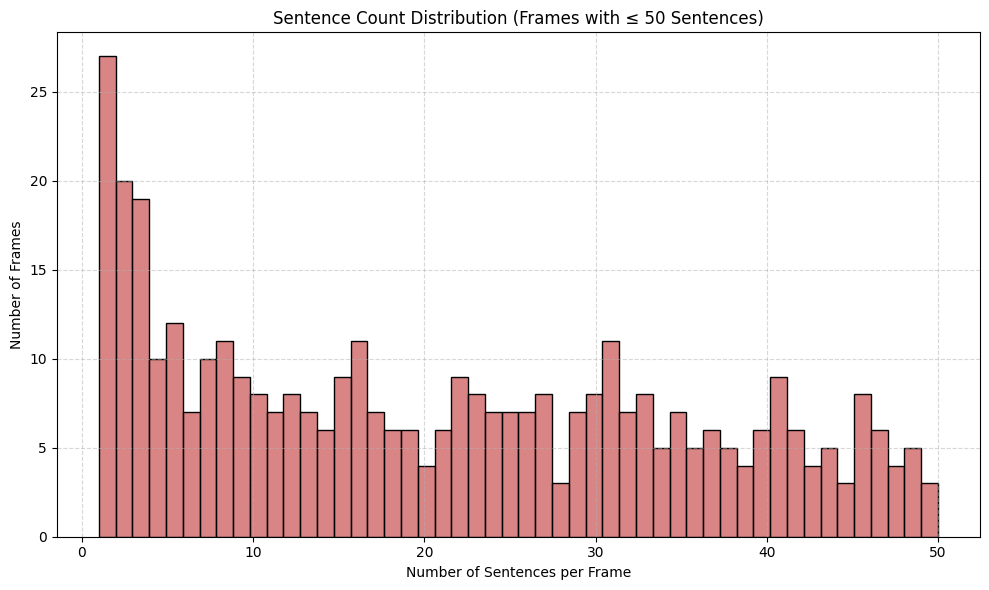

In [ ]:

# 限定在句子数量 <= 50 的 frame
subset_df = frame_freq_df[frame_freq_df['sentence_count'] <= 50]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset_df,
    x='sentence_count',
    bins=50,  # 每个整数一个 bin
    color='indianred',
    edgecolor='black'
)
plt.title("Sentence Count Distribution (Frames with ≤ 50 Sentences)")
plt.xlabel("Number of Sentences per Frame")
plt.ylabel("Number of Frames")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("frame_distribution_under_50.png", dpi=300)
plt.show()


In [ ]:
# 检查变量是否相同
print("变量对比:")
print(f"balanced_df_with_analysis 形状: {balanced_df_with_analysis.shape}")
print(f"balanced_df 是否存在: {'balanced_df' in locals()}")

# 如果 balanced_df 存在，比较它们
if 'balanced_df' in locals():
    print(f"balanced_df 形状: {balanced_df.shape}")
    print(f"两个变量是否相同: {balanced_df_with_analysis.equals(balanced_df)}")

# 检查保存的文件
import os
file_path = "/content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl"
if os.path.exists(file_path):
    saved_df = pd.read_pickle(file_path)
    print(f"保存文件的形状: {saved_df.shape}")
    print(f"与当前变量是否相同: {balanced_df_with_analysis.equals(saved_df)}")

变量对比:
balanced_df_with_analysis 形状: (39536, 11)
balanced_df 是否存在: True
balanced_df 形状: (39536, 11)
两个变量是否相同: True
保存文件的形状: (39536, 11)
与当前变量是否相同: True


In [ ]:
def analyze_frame_distribution(df):
    """分析frame分布情况"""
    frame_counts = df['frame_name'].value_counts()

    print(f"总frame数: {len(frame_counts)}")
    print(f"总样本数: {len(df)}")
    print(f"平均每frame样本数: {frame_counts.mean():.1f}")
    print(f"中位数: {frame_counts.median():.1f}")
    print(f"最多样本frame: {frame_counts.iloc[0]} 个样本")
    print(f"最少样本frame: {frame_counts.iloc[-1]} 个样本")

    # 分析不平衡程度
    q25, q75 = frame_counts.quantile([0.25, 0.75])
    print(f"\n样本数分布:")
    print(f"前25%的frame: 平均 {frame_counts[frame_counts >= q75].mean():.1f} 样本")
    print(f"后25%的frame: 平均 {frame_counts[frame_counts <= q25].mean():.1f} 样本")

    # 找出严重不足的frame
    insufficient_frames = frame_counts[frame_counts < 10]  # 少于10个样本
    if len(insufficient_frames) > 0:
        print(f"\n⚠️ 样本不足(<10)的frame: {len(insufficient_frames)}个")
        print(insufficient_frames.head(10))

    # 更详细的分布统计
    print(f"\n详细分布:")
    print(f"样本数 >= 100: {(frame_counts >= 100).sum()} 个frame")
    print(f"样本数 50-99: {((frame_counts >= 50) & (frame_counts < 100)).sum()} 个frame")
    print(f"样本数 20-49: {((frame_counts >= 20) & (frame_counts < 50)).sum()} 个frame")
    print(f"样本数 10-19: {((frame_counts >= 10) & (frame_counts < 20)).sum()} 个frame")
    print(f"样本数 < 10: {(frame_counts < 10).sum()} 个frame")

    return frame_counts

# 分析原始训练集
print("=== 原始训练集 (train_df) 分析 ===")
train_frame_counts = analyze_frame_distribution(train_df)

print("\n" + "="*50 + "\n")

# 分析平衡后的数据集
print("=== 平衡后数据集 (balanced_df_with_analysis) 分析 ===")
balanced_frame_counts = analyze_frame_distribution(balanced_df_with_analysis)

print("\n" + "="*50 + "\n")

# 对比分析
print("=== 平衡效果对比 ===")
print(f"原始数据样本数: {len(train_df):,}")
print(f"平衡后样本数: {len(balanced_df_with_analysis):,}")
print(f"压缩比例: {len(balanced_df_with_analysis)/len(train_df):.1%}")

# 分析改善效果
original_max_min_ratio = train_frame_counts.max() / train_frame_counts.min()
balanced_max_min_ratio = balanced_frame_counts.max() / balanced_frame_counts.min()

print(f"原始最大最小比例: {original_max_min_ratio:.1f}:1")
print(f"平衡后最大最小比例: {balanced_max_min_ratio:.1f}:1")
print(f"不平衡改善: {(original_max_min_ratio - balanced_max_min_ratio)/original_max_min_ratio:.1%}")

=== 原始训练集 (train_df) 分析 ===
总frame数: 1014
总样本数: 150109
平均每frame样本数: 148.0
中位数: 57.0
最多样本frame: 4639 个样本
最少样本frame: 1 个样本

样本数分布:
前25%的frame: 平均 454.2 样本
后25%的frame: 平均 8.0 样本

⚠️ 样本不足(<10)的frame: 171个
frame_name
Jury_deliberation         9
Front_for                 9
Regard                    9
Relating_concepts         9
Attempt_means             9
Reporting                 9
People_by_jurisdiction    9
Entity                    9
Emergency_fire            9
Sidereal_appearance       9
Name: count, dtype: int64

详细分布:
样本数 >= 100: 335 个frame
样本数 50-99: 222 个frame
样本数 20-49: 210 个frame
样本数 10-19: 76 个frame
样本数 < 10: 171 个frame


=== 平衡后数据集 (balanced_df_with_analysis) 分析 ===
总frame数: 1014
总样本数: 39536
平均每frame样本数: 39.0
中位数: 30.0
最多样本frame: 80 个样本
最少样本frame: 1 个样本

样本数分布:
前25%的frame: 平均 79.1 样本
后25%的frame: 平均 7.3 样本

⚠️ 样本不足(<10)的frame: 171个
frame_name
Reporting                 9
Attempt_means             9
Entity                    9
Dunking                   9
Confronting_problem       9

In [ ]:
# 1. 检查内存中的变量
print("=== 内存中的DataFrame变量 ===")
dataframes_info = [
    ('train_df', train_df),
    ('balanced_df', balanced_df),
    ('balanced_df_with_analysis', balanced_df_with_analysis)
]

for name, df in dataframes_info:
    print(f"{name}:")
    print(f"  形状: {df.shape}")
    print(f"  内存地址: {id(df)}")
    print(f"  列名: {list(df.columns)}")
    print()

# 2. 检查它们是否是同一个对象
print("=== 变量关系检查 ===")
print(f"balanced_df is balanced_df_with_analysis: {balanced_df is balanced_df_with_analysis}")
print(f"balanced_df.equals(balanced_df_with_analysis): {balanced_df.equals(balanced_df_with_analysis)}")
print(f"train_df.equals(balanced_df): {train_df.equals(balanced_df)}")

print("\n" + "="*60 + "\n")

# 3. 检查硬盘上的文件
print("=== 硬盘文件检查 ===")
import os

data_dir = "/content/drive/MyDrive/more50/framenet_data/"
files_to_check = [
    "train_df.pkl",
    "train_df_balanced.pkl",
    "train_df_distilbert_balanced.pkl"
]

for filename in files_to_check:
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        try:
            df_from_file = pd.read_pickle(filepath)
            file_size = os.path.getsize(filepath) / (1024*1024)  # MB
            print(f"✅ {filename}:")
            print(f"   形状: {df_from_file.shape}")
            print(f"   文件大小: {file_size:.1f} MB")
            print(f"   修改时间: {pd.to_datetime(os.path.getmtime(filepath), unit='s')}")

            # 检查与内存变量的关系
            if 'train_df' in locals():
                print(f"   与train_df相同: {df_from_file.equals(train_df)}")
            if 'balanced_df' in locals():
                print(f"   与balanced_df相同: {df_from_file.equals(balanced_df)}")
            print()
        except Exception as e:
            print(f"❌ {filename}: 读取失败 - {e}")
    else:
        print(f"❌ {filename}: 文件不存在")

print("="*60)

=== 内存中的DataFrame变量 ===
train_df:
  形状: (150109, 11)
  内存地址: 133469599496208
  列名: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']

balanced_df:
  形状: (39536, 11)
  内存地址: 133463014666960
  列名: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']

balanced_df_with_analysis:
  形状: (39536, 11)
  内存地址: 133465709724880
  列名: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']

=== 变量关系检查 ===
balanced_df is balanced_df_with_analysis: False
balanced_df.equals(balanced_df_with_analysis): True
train_df.equals(balanced_df): False


=== 硬盘文件检查 ===
✅ train_df.pkl:
   形状: (150109, 11)
   文件大小: 45.4 MB
   修改时间: 2025-07-31 00:56:10
   与train_df相同: True
   与balanced_df相同: Fa

In [19]:
# @title ✅ 所有初始原型测试（验证集）
import torch
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
import torch.nn.functional as F
import os
import pickle

# 加载数据和模型
def load_data_and_model():
    """加载所有需要的数据和模型"""
    print("加载数据和模型...")

    # 设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载训练和验证数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    # 加载定义embeddings
    definition_data = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl")

    # 加载未训练的模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    print(f"训练样本: {len(train_df):,}")
    print(f"验证样本: {len(val_df):,}")
    print(f"定义数据类型: {type(definition_data)}")
    if isinstance(definition_data, dict):
        print(f"定义数据长度: {len(definition_data)}")
        print(f"定义数据前几个key: {list(definition_data.keys())[:3]}")
    else:
        print(f"定义数据shape: {definition_data.shape}")
        print(f"定义数据columns: {definition_data.columns.tolist()}")
    print(f"训练集Frame数: {len(train_df['frame_name'].unique()):,}")

    return train_df, val_df, definition_data, model, tokenizer, device

def analyze_frame_distribution(train_df):
    """分析frame数量分布"""
    frame_counts = train_df['frame_name'].value_counts()

    print("\nFrame数量分布统计:")
    print(f"总Frame数: {len(frame_counts)}")
    print(f"样本数统计:")
    print(f"  >= 10样本: {(frame_counts >= 10).sum()} frames")
    print(f"  >= 5样本:  {(frame_counts >= 5).sum()} frames")
    print(f"  >= 3样本:  {(frame_counts >= 3).sum()} frames")
    print(f"  = 1样本:   {(frame_counts == 1).sum()} frames")
    print(f"  = 2样本:   {(frame_counts == 2).sum()} frames")

    print(f"\n各shot设置的可用frame数:")
    for shot in [1, 3, 5, 10]:
        available = (frame_counts >= shot).sum()
        print(f"  {shot}-shot: {available} frames可用 ({available/len(frame_counts)*100:.1f}%)")

    return frame_counts

def save_prototypes_to_drive(prototypes, save_path, description):
    """保存原型到drive"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 转换为可保存的格式
    save_dict = {}
    for frame_name, prototype in prototypes.items():
        if isinstance(prototype, torch.Tensor):
            save_dict[frame_name] = prototype.numpy()
        else:
            save_dict[frame_name] = prototype

    with open(save_path, 'wb') as f:
        pickle.dump(save_dict, f)

    file_name = os.path.basename(save_path)
    print(f"✅ {description}已保存成功:")
    print(f"   文件名: {file_name}")
    print(f"   完整路径: {save_path}")
    return save_path

def analyze_prototype_similarity(prototypes, method_name):
    """分析原型间的内部相似度（3个核心指标）"""
    embeddings = np.array(list(prototypes.values()))

    # 计算余弦相似度矩阵
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)

    # 去除对角线元素（自相似度=1）
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    # 3个核心指标
    mean_sim = np.mean(upper_triangle)      # 平均相似度：越低越多样化
    std_sim = np.std(upper_triangle)        # 标准差：越高分布越分散
    max_sim = np.max(upper_triangle)        # 最大相似度：越低分离度越好

    print(f"  📊 {method_name}内部相似度:")
    print(f"     平均相似度: {mean_sim:.4f} (越低越多样)")
    print(f"     相似度标准差: {std_sim:.4f} (越高越分散)")
    print(f"     最大相似度: {max_sim:.4f} (越低分离度越好)")

    return {
        'mean_similarity': mean_sim,
        'std_similarity': std_sim,
        'max_similarity': max_sim,
        'prototype_count': len(prototypes)
    }

def build_few_shot_prototypes(model, tokenizer, train_df, shot_num=5):
    """构建few-shot原型（使用未训练模型的平均方法）"""

    # 处理特殊情况：使用全部可用样本
    if shot_num == float('inf'):
        print(f"\n构建全集初始原型...")
        shot_desc = "全集"
    else:
        print(f"\n构建{shot_num}-shot原型...")
        shot_desc = f"{shot_num}-shot"

    few_shot_prototypes = {}
    frame_groups = train_df.groupby('frame_name')

    stats = {
        'sufficient_samples': 0,
        'insufficient_samples': 0,
        'skipped_frames': 0,
        'actual_shots_used': []
    }

    error_count = 0

    model.eval()
    with torch.no_grad():
        for frame_name, group in tqdm(frame_groups, desc=f"构建{shot_desc}原型"):
            group_size = len(group)

            # 决定实际使用的样本数
            if shot_num == float('inf'):
                # 全集模式：使用所有样本
                actual_shot = group_size
                sampled = group
                stats['sufficient_samples'] += 1
            elif group_size >= shot_num:
                actual_shot = shot_num
                stats['sufficient_samples'] += 1
                sampled = group.sample(n=actual_shot, random_state=42)
            elif group_size > 0:
                actual_shot = group_size
                stats['insufficient_samples'] += 1
                sampled = group
            else:
                stats['skipped_frames'] += 1
                continue

            stats['actual_shots_used'].append(actual_shot)

            # 使用现有的编码函数
            try:
                embeddings = encode_target_spans_batch(
                    sampled['sentence'].tolist(),
                    sampled['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(sampled), train_mode=False
                )

                # 参考原代码的处理方式
                if embeddings is not None and len(embeddings) > 0:
                    # 将所有embeddings收集到列表中
                    embedding_list = []

                    # 处理不同的返回格式
                    if isinstance(embeddings, torch.Tensor):
                        # 如果返回的是单个tensor，按行分割
                        if embeddings.dim() == 1:
                            embedding_list = [embeddings.cpu()]
                        else:
                            for i in range(embeddings.size(0)):
                                embedding_list.append(embeddings[i].cpu())
                    elif isinstance(embeddings, list):
                        # 如果返回的是tensor列表
                        for emb in embeddings:
                            if isinstance(emb, torch.Tensor):
                                embedding_list.append(emb.cpu())
                            else:
                                embedding_list.append(torch.tensor(emb))

                    if embedding_list:
                        # 确保所有embeddings形状一致
                        standardized_embeddings = []
                        for emb in embedding_list:
                            if emb.dim() > 1:
                                emb = emb.squeeze()
                            standardized_embeddings.append(emb)

                        # 参考原代码：先stack再mean
                        if len(standardized_embeddings) > 1:
                            stacked = torch.stack(standardized_embeddings)
                            prototype = stacked.mean(0)
                        else:
                            prototype = standardized_embeddings[0]

                        # 确保原型是1D向量
                        if prototype.dim() > 1:
                            prototype = prototype.squeeze()

                        few_shot_prototypes[frame_name] = prototype

            except Exception as e:
                error_count += 1
                if error_count <= 3:  # 只打印前3个错误
                    print(f"  Error processing {frame_name}: {e}")
                elif error_count == 4:
                    print("  ... (更多错误已省略)")
                stats['skipped_frames'] += 1
                continue

    # 统计信息
    if shot_num == float('inf'):
        print(f"\n全集初始原型构建完成:")
    else:
        print(f"\n{shot_num}-shot原型构建完成:")
    print(f"  成功构建: {len(few_shot_prototypes)} 个原型")
    print(f"  样本充足: {stats['sufficient_samples']} frames")
    print(f"  样本不足: {stats['insufficient_samples']} frames")
    print(f"  跳过frame: {stats['skipped_frames']} frames")
    if error_count > 0:
        print(f"  处理错误: {error_count} frames")
    if stats['actual_shots_used']:
        avg_shots = np.mean(stats['actual_shots_used'])
        total_shots = np.sum(stats['actual_shots_used'])
        print(f"  平均使用: {avg_shots:.1f} shots")
        if shot_num == float('inf'):
            print(f"  总样本数: {total_shots:,}")

    return few_shot_prototypes, stats

def build_definition_prototypes(definition_data):
    """构建定义文本原型"""
    print("\n构建定义文本原型...")

    definition_prototypes = {}

    # 检查定义数据的结构
    print(f"定义数据类型: {type(definition_data)}")

    if isinstance(definition_data, dict):
        # 如果是字典格式，直接处理
        print(f"定义数据包含 {len(definition_data)} 个frame")
        print(f"前几个frame: {list(definition_data.keys())[:3]}")

        for frame_name, data in definition_data.items():
            # 检查data的结构
            if isinstance(data, dict) and 'embedding' in data:
                embedding = data['embedding']
            elif isinstance(data, (list, np.ndarray, torch.Tensor)):
                # 如果data直接就是embedding
                embedding = data
            else:
                print(f"跳过frame {frame_name}: 数据格式不识别")
                continue

            # 确保embedding是tensor格式并在CPU上，且为1D向量
            if isinstance(embedding, list):
                embedding = torch.tensor(embedding, dtype=torch.float32)
            elif isinstance(embedding, np.ndarray):
                embedding = torch.tensor(embedding, dtype=torch.float32)
            elif isinstance(embedding, torch.Tensor):
                embedding = embedding.cpu().float()
            else:
                embedding = torch.tensor(embedding, dtype=torch.float32)

            # 确保是1D向量
            if embedding.dim() > 1:
                embedding = embedding.squeeze()

            definition_prototypes[frame_name] = embedding

    else:
        # DataFrame格式处理
        print(f"定义数据列: {definition_data.columns.tolist()}")
        print(f"定义数据样例:")
        print(definition_data.head(2))

        # 查找frame和embedding列
        frame_col = None
        embedding_col = None

        for col in definition_data.columns:
            if 'frame' in col.lower():
                frame_col = col
            if 'embedding' in col.lower():
                embedding_col = col

        if frame_col and embedding_col:
            print(f"使用列: frame='{frame_col}', embedding='{embedding_col}'")

            for _, row in definition_data.iterrows():
                frame_name = row[frame_col]
                embedding = row[embedding_col]

                # 确保embedding是tensor格式并在CPU上，且为1D向量
                if isinstance(embedding, list):
                    embedding = torch.tensor(embedding, dtype=torch.float32)
                elif isinstance(embedding, np.ndarray):
                    embedding = torch.tensor(embedding, dtype=torch.float32)
                elif isinstance(embedding, torch.Tensor):
                    embedding = embedding.cpu().float()
                else:
                    embedding = torch.tensor(embedding, dtype=torch.float32)

                # 确保是1D向量
                if embedding.dim() > 1:
                    embedding = embedding.squeeze()

                definition_prototypes[frame_name] = embedding

        else:
            print("未找到合适的frame和embedding列，请检查数据结构")
            print(f"可用列: {definition_data.columns.tolist()}")
            return {}

    print(f"定义原型构建完成: {len(definition_prototypes)} 个原型")
    return definition_prototypes

def run_experiments():
    """运行所有实验"""
    print("="*80)
    print("Few-shot和Zero-shot原型测试实验")
    print("="*80)

    # 加载数据
    train_df, val_df, definition_data, model, tokenizer, device = load_data_and_model()

    # 分析数据分布
    frame_counts = analyze_frame_distribution(train_df)

    results = {}

    # 实验1: 全集初始原型测试
    print("\n" + "="*60)
    print("实验1: 全集初始原型测试（未训练模型）")
    print("="*60)

    try:
        # 使用全部训练数据构建初始原型
        full_prototypes, full_stats = build_few_shot_prototypes(
            model, tokenizer, train_df, shot_num=float('inf')  # 使用所有可用样本
        )

        print("⏳ 评估全集初始原型...")
        full_result = evaluate_target_known(
            model, tokenizer, val_df, full_prototypes
        )

        results['full-initial'] = full_result

        print(f"全集初始原型结果:")
        print(f"  Top-1准确率: {full_result['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {full_result.get('top3_accuracy', 'N/A')}")
        print(f"  Macro F1: {full_result['macro_f1']:.4f}")
        print(f"  Weighted F1: {full_result.get('weighted_f1', 'N/A')}")

        # 分析内部相似度
        similarity_stats = analyze_prototype_similarity(full_prototypes, "全集初始原型")

        # 保存全集初始原型
        save_prototypes_to_drive(
            full_prototypes,
            "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl",
            "全集初始原型"
        )

    except Exception as e:
        print(f"全集初始原型评估失败: {e}")
        print("跳过全集初始原型评估")

    # 实验2: Few-shot原型测试
    print("\n" + "="*60)
    print("实验2: Few-shot原型测试")
    print("="*60)

    shots = [1, 3, 5, 10]
    for shot in shots:
        print(f"\n--- {shot}-shot 测试 ---")

        # 构建原型
        few_shot_prototypes, stats = build_few_shot_prototypes(
            model, tokenizer, train_df, shot_num=shot
        )

        # 评估
        try:
            print(f"⏳ 评估{shot}-shot原型...")
            result = evaluate_target_known(
                model, tokenizer, val_df, few_shot_prototypes
            )

            results[f"{shot}-shot"] = result

            print(f"{shot}-shot结果:")
            print(f"  Top-1准确率: {result['top1_accuracy']:.4f}")
            print(f"  Top-3准确率: {result.get('top3_accuracy', 'N/A')}")
            print(f"  Macro F1: {result['macro_f1']:.4f}")
            print(f"  Weighted F1: {result.get('weighted_f1', 'N/A')}")

            # 分析内部相似度
            similarity_stats = analyze_prototype_similarity(few_shot_prototypes, f"{shot}-shot原型")

            # 保存few-shot原型
            save_prototypes_to_drive(
                few_shot_prototypes,
                f"/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/{shot}_shot_prototypes.pkl",
                f"{shot}-shot原型"
            )

        except Exception as e:
            print(f"  {shot}-shot评估失败: {e}")
            print(f"  跳过该设置")
            continue

    # 实验3: Zero-shot定义原型测试
    print("\n" + "="*60)
    print("实验3: Zero-shot定义原型测试")
    print("="*60)

    definition_prototypes = build_definition_prototypes(definition_data)

    if definition_prototypes:
        try:
            print("⏳ 评估Zero-shot定义原型...")
            definition_result = evaluate_target_known(
                model, tokenizer, val_df, definition_prototypes
            )

            results['zero-shot'] = definition_result

            print(f"Zero-shot结果:")
            print(f"  Top-1准确率: {definition_result['top1_accuracy']:.4f}")
            print(f"  Top-3准确率: {definition_result.get('top3_accuracy', 'N/A')}")
            print(f"  Macro F1: {definition_result['macro_f1']:.4f}")
            print(f"  Weighted F1: {definition_result.get('weighted_f1', 'N/A')}")

            # 分析内部相似度
            similarity_stats = analyze_prototype_similarity(definition_prototypes, "Zero-shot原型")

            # 保存zero-shot原型
            save_prototypes_to_drive(
                definition_prototypes,
                "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/zero_shot_prototypes.pkl",
                "Zero-shot原型"
            )

        except Exception as e:
            print(f"Zero-shot评估失败: {e}")
            print("跳过zero-shot评估")

    # 结果汇总
    print("\n" + "="*80)
    print("实验结果汇总")
    print("="*80)

    if results:
        print(f"{'方法':<15} {'Top-1':<8} {'Macro F1':<10}")
        print("-" * 40)

        for method, result in results.items():
            top1 = result['top1_accuracy']
            macro_f1 = result['macro_f1']
            print(f"{method:<15} {top1:<8.4f} {macro_f1:<10.4f}")
    else:
        print("没有成功的实验结果")

    return results

# 运行实验
if __name__ == "__main__":
    try:
        results = run_experiments()
        print(f"\n✅ 实验完成！结果保存在 results 变量中")
        print(f"Results 类型: {type(results)}")
        if results:
            print(f"包含方法: {list(results.keys())}")
    except Exception as e:
        print(f"❌ 实验运行失败: {e}")
        import traceback
        traceback.print_exc()

Few-shot和Zero-shot原型测试实验
加载数据和模型...
使用设备: cuda
训练样本: 150,110
验证样本: 25,113
定义数据类型: <class 'dict'>
定义数据长度: 1221
定义数据前几个key: ['Abandonment', 'Abounding_with', 'Absorb_heat']
训练集Frame数: 1,014

Frame数量分布统计:
总Frame数: 1014
样本数统计:
  >= 10样本: 838 frames
  >= 5样本:  910 frames
  >= 3样本:  961 frames
  = 1样本:   27 frames
  = 2样本:   26 frames

各shot设置的可用frame数:
  1-shot: 1014 frames可用 (100.0%)
  3-shot: 961 frames可用 (94.8%)
  5-shot: 910 frames可用 (89.7%)
  10-shot: 838 frames可用 (82.6%)

实验1: 全集初始原型测试（未训练模型）

构建全集初始原型...


构建全集原型: 100%|██████████| 1014/1014 [08:09<00:00,  2.07it/s]



全集初始原型构建完成:
  成功构建: 1014 个原型
  样本充足: 1014 frames
  样本不足: 0 frames
  跳过frame: 0 frames
  平均使用: 148.0 shots
  总样本数: 150,110
⏳ 评估全集初始原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6744
Top-3准确率: 0.8617
Macro F1: 0.6170
Weighted F1: 0.6872
处理样本: 25113/25113
全集初始原型结果:
  Top-1准确率: 0.6744
  Top-3准确率: 0.8616652729661928
  Macro F1: 0.6170
  Weighted F1: 0.6872252444372045
  📊 全集初始原型内部相似度:
     平均相似度: 0.6509 (越低越多样)
     相似度标准差: 0.0824 (越高越分散)
     最大相似度: 0.9758 (越低分离度越好)
✅ 全集初始原型已保存成功:
   文件名: full_initial_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl

实验2: Few-shot原型测试

--- 1-shot 测试 ---

构建1-shot原型...


构建1-shot原型: 100%|██████████| 1014/1014 [00:06<00:00, 160.01it/s]



1-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 1014 frames
  样本不足: 0 frames
  跳过frame: 0 frames
  平均使用: 1.0 shots
⏳ 评估1-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.2133
Top-3准确率: 0.3310
Macro F1: 0.2177
Weighted F1: 0.2171
处理样本: 25113/25113
1-shot结果:
  Top-1准确率: 0.2133
  Top-3准确率: 0.3310237725480827
  Macro F1: 0.2177
  Weighted F1: 0.21710241616601791
  📊 1-shot原型内部相似度:
     平均相似度: 0.4295 (越低越多样)
     相似度标准差: 0.0645 (越高越分散)
     最大相似度: 0.8521 (越低分离度越好)
✅ 1-shot原型已保存成功:
   文件名: 1_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/1_shot_prototypes.pkl

--- 3-shot 测试 ---

构建3-shot原型...


构建3-shot原型: 100%|██████████| 1014/1014 [00:09<00:00, 105.99it/s]



3-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 961 frames
  样本不足: 53 frames
  跳过frame: 0 frames
  平均使用: 2.9 shots
⏳ 评估3-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4109
Top-3准确率: 0.5973
Macro F1: 0.3912
Weighted F1: 0.4250
处理样本: 25113/25113
3-shot结果:
  Top-1准确率: 0.4109
  Top-3准确率: 0.5973400230956079
  Macro F1: 0.3912
  Weighted F1: 0.42498879085976393
  📊 3-shot原型内部相似度:
     平均相似度: 0.5605 (越低越多样)
     相似度标准差: 0.0658 (越高越分散)
     最大相似度: 0.9087 (越低分离度越好)
✅ 3-shot原型已保存成功:
   文件名: 3_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/3_shot_prototypes.pkl

--- 5-shot 测试 ---

构建5-shot原型...


构建5-shot原型: 100%|██████████| 1014/1014 [00:12<00:00, 83.80it/s]



5-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 910 frames
  样本不足: 104 frames
  跳过frame: 0 frames
  平均使用: 4.7 shots
⏳ 评估5-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4863
Top-3准确率: 0.6804
Macro F1: 0.4583
Weighted F1: 0.5019
处理样本: 25113/25113
5-shot结果:
  Top-1准确率: 0.4863
  Top-3准确率: 0.6804045713375543
  Macro F1: 0.4583
  Weighted F1: 0.5019036920285003
  📊 5-shot原型内部相似度:
     平均相似度: 0.5952 (越低越多样)
     相似度标准差: 0.0699 (越高越分散)
     最大相似度: 0.9357 (越低分离度越好)
✅ 5-shot原型已保存成功:
   文件名: 5_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/5_shot_prototypes.pkl

--- 10-shot 测试 ---

构建10-shot原型...


构建10-shot原型: 100%|██████████| 1014/1014 [00:18<00:00, 53.37it/s]



10-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 838 frames
  样本不足: 176 frames
  跳过frame: 0 frames
  平均使用: 9.0 shots
⏳ 评估10-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5598
Top-3准确率: 0.7549
Macro F1: 0.5339
Weighted F1: 0.5752
处理样本: 25113/25113
10-shot结果:
  Top-1准确率: 0.5598
  Top-3准确率: 0.7549078166686577
  Macro F1: 0.5339
  Weighted F1: 0.5751858892572475
  📊 10-shot原型内部相似度:
     平均相似度: 0.6244 (越低越多样)
     相似度标准差: 0.0742 (越高越分散)
     最大相似度: 0.9662 (越低分离度越好)
✅ 10-shot原型已保存成功:
   文件名: 10_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/10_shot_prototypes.pkl

实验3: Zero-shot定义原型测试

构建定义文本原型...
定义数据类型: <class 'dict'>
定义数据包含 1221 个frame
前几个frame: ['Abandonment', 'Abounding_with', 'Absorb_heat']
定义原型构建完成: 1221 个原型
⏳ 评估Zero-shot定义原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1221 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.0154
Top-3准确率: 0.0410
Mac

In [53]:
# @title ✅ 所有初始原型测试（两个测试集）

import torch
import pandas as pd
import numpy as np
import pickle
import os
from transformers import AutoModel, AutoTokenizer
from glob import glob

def load_saved_prototypes(prototype_path):
    """加载已保存的原型"""
    print(f"加载原型: {os.path.basename(prototype_path)}")

    try:
        with open(prototype_path, 'rb') as f:
            prototypes = pickle.load(f)

        # 转换为tensor格式
        converted_prototypes = {}
        for frame_name, prototype in prototypes.items():
            if isinstance(prototype, np.ndarray):
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)
            elif isinstance(prototype, torch.Tensor):
                converted_prototypes[frame_name] = prototype.float()
            else:
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)

        print(f"✅ 成功加载 {len(converted_prototypes)} 个原型")
        return converted_prototypes

    except Exception as e:
        print(f"❌ 加载失败: {e}")
        return None

def test_prototypes_on_datasets():
    """测试已保存原型在两个测试集上的表现"""
    print("="*80)
    print("测试已保存原型在两个测试集上的表现")
    print("="*80)

    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载模型
    print("\n加载未训练的模型...")
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # 加载两个测试集
    print("\n加载测试集...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")  # 原始测试集
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")  # fulltext测试集

    print(f"原始测试集: {len(test_df_original):,} 样本")
    print(f"Fulltext测试集: {len(test_df_fulltext):,} 样本")

    # 查找所有已保存的原型文件
    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"❌ 在 {prototype_dir} 中未找到原型文件")
        return

    print(f"\n找到 {len(prototype_files)} 个原型文件:")
    for f in prototype_files:
        print(f"  {os.path.basename(f)}")

    # 测试结果存储
    results = {
        'original_test': {},
        'fulltext_test': {}
    }

    # 对每个原型文件进行测试
    for prototype_path in prototype_files:
        file_name = os.path.basename(prototype_path)
        method_name = file_name.replace('.pkl', '').replace('_prototypes', '')

        print(f"\n" + "="*60)
        print(f"测试方法: {method_name}")
        print("="*60)

        # 加载原型
        prototypes = load_saved_prototypes(prototype_path)
        if prototypes is None:
            continue

        # 在原始测试集上测试
        print(f"\n📊 在原始测试集上测试...")
        try:
            result_original = evaluate_target_known_fixed(
                model, tokenizer, test_df_original, prototypes
            )
            results['original_test'][method_name] = result_original

            print(f"原始测试集结果:")
            print(f"  Top-1准确率: {result_original['top1_accuracy']:.4f}")
            print(f"  Top-3准确率: {result_original['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_original['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

        except Exception as e:
            print(f"❌ 原始测试集测试失败: {e}")
            results['original_test'][method_name] = None

        # 在fulltext测试集上测试
        print(f"\n🎯 在Fulltext测试集上测试...")
        try:
            result_fulltext = evaluate_target_known_fixed(
                model, tokenizer, test_df_fulltext, prototypes
            )
            results['fulltext_test'][method_name] = result_fulltext

            print(f"Fulltext测试集结果:")
            print(f"  Top-1准确率: {result_fulltext['top1_accuracy']:.4f}")
            print(f"  Top-3准确率: {result_fulltext['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

        except Exception as e:
            print(f"❌ Fulltext测试集测试失败: {e}")
            results['fulltext_test'][method_name] = None

        # 清理GPU内存
        torch.cuda.empty_cache()

    # 结果汇总
    print(f"\n" + "="*90)
    print("所有原型方法在两个测试集上的结果汇总")
    print("="*90)

    # 创建结果表格
    print(f"{'方法':<20} {'原始测试集':<25} {'Fulltext测试集':<25}")
    print(f"{'':20} {'Top-1':<8} {'Macro F1':<8} {'Top-1':<8} {'Macro F1':<8}")
    print("-" * 85)

    # 收集所有方法名
    all_methods = set(results['original_test'].keys()) | set(results['fulltext_test'].keys())

    for method in sorted(all_methods):
        orig_result = results['original_test'].get(method)
        full_result = results['fulltext_test'].get(method)

        # 原始测试集结果
        if orig_result:
            orig_top1 = f"{orig_result['top1_accuracy']:.4f}"
            orig_f1 = f"{orig_result['macro_f1']:.4f}"
        else:
            orig_top1 = "失败"
            orig_f1 = "失败"

        # Fulltext测试集结果
        if full_result:
            full_top1 = f"{full_result['top1_accuracy']:.4f}"
            full_f1 = f"{full_result['macro_f1']:.4f}"
        else:
            full_top1 = "失败"
            full_f1 = "失败"

        print(f"{method:<20} {orig_top1:<8} {orig_f1:<8} {full_top1:<8} {full_f1:<8}")

    return results

def compare_datasets():
    """比较两个测试集的基本统计信息"""
    print(f"\n" + "="*60)
    print("测试集基本信息对比")
    print("="*60)

    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"原始测试集:")
    print(f"  样本数: {len(test_df_original):,}")
    print(f"  Frame数: {test_df_original['frame_name'].nunique()}")
    print(f"  平均每Frame样本数: {len(test_df_original) / test_df_original['frame_name'].nunique():.1f}")

    print(f"\nFulltext测试集:")
    print(f"  样本数: {len(test_df_fulltext):,}")
    print(f"  Frame数: {test_df_fulltext['frame_name'].nunique()}")
    print(f"  平均每Frame样本数: {len(test_df_fulltext) / test_df_fulltext['frame_name'].nunique():.1f}")

    # 共同Frame分析
    orig_frames = set(test_df_original['frame_name'].unique())
    full_frames = set(test_df_fulltext['frame_name'].unique())

    common_frames = orig_frames & full_frames
    orig_only = orig_frames - full_frames
    full_only = full_frames - orig_frames

    print(f"\nFrame分布:")
    print(f"  共同Frame: {len(common_frames)}")
    print(f"  仅在原始测试集: {len(orig_only)}")
    print(f"  仅在Fulltext测试集: {len(full_only)}")
    print(f"  Frame重叠率: {len(common_frames) / len(orig_frames | full_frames) * 100:.1f}%")

def analyze_prototype_files():
    """分析原型文件信息"""
    print(f"\n" + "="*60)
    print("原型文件信息分析")
    print("="*60)

    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"❌ 未找到原型文件")
        return

    print(f"{'文件名':<30} {'原型数量':<10} {'文件大小':<10}")
    print("-" * 55)

    for file_path in sorted(prototype_files):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path) / 1024  # KB

        try:
            with open(file_path, 'rb') as f:
                prototypes = pickle.load(f)
            prototype_count = len(prototypes)
        except:
            prototype_count = "加载失败"

        print(f"{file_name:<30} {prototype_count:<10} {file_size:<10.1f}KB")

# 运行测试
if __name__ == "__main__":
    # 分析原型文件
    analyze_prototype_files()

    # 比较数据集
    compare_datasets()

    # 运行主要测试
    print(f"\n开始测试所有原型...")
    results = test_prototypes_on_datasets()

    print(f"\n✅ 测试完成！")
    print(f"结果已保存在 results 变量中")

    if results:
        print(f"测试的方法数: {len(set(results['original_test'].keys()) | set(results['fulltext_test'].keys()))}")
        print(f"原始测试集成功: {len([r for r in results['original_test'].values() if r is not None])}")
        print(f"Fulltext测试集成功: {len([r for r in results['fulltext_test'].values() if r is not None])}")


原型文件信息分析
文件名                            原型数量       文件大小      
-------------------------------------------------------
10_shot_prototypes.pkl         1014       3092.2    KB
1_shot_prototypes.pkl          1014       3092.2    KB
3_shot_prototypes.pkl          1014       3092.2    KB
5_shot_prototypes.pkl          1014       3092.2    KB
full_initial_prototypes.pkl    1014       3092.2    KB
zero_shot_prototypes.pkl       1221       3724.3    KB

测试集基本信息对比
原始测试集:
  样本数: 25,527
  Frame数: 907
  平均每Frame样本数: 28.1

Fulltext测试集:
  样本数: 6,872
  Frame数: 574
  平均每Frame样本数: 12.0

Frame分布:
  共同Frame: 544
  仅在原始测试集: 363
  仅在Fulltext测试集: 30
  Frame重叠率: 58.1%

开始测试所有原型...
测试已保存原型在两个测试集上的表现
使用设备: cuda

加载未训练的模型...

加载测试集...
原始测试集: 25,527 样本
Fulltext测试集: 6,872 样本

找到 6 个原型文件:
  full_initial_prototypes.pkl
  1_shot_prototypes.pkl
  3_shot_prototypes.pkl
  5_shot_prototypes.pkl
  10_shot_prototypes.pkl
  zero_shot_prototypes.pkl

测试方法: full_initial
加载原型: full_initial_prototypes.pkl
✅ 成功加载 1014 个原型

📊 在原

In [17]:
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity

def load_all_prototypes():
    """加载所有保存的原型文件"""
    base_path = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/"

    prototype_files = {
        '1-shot': '1_shot_prototypes.pkl',
        '3-shot': '3_shot_prototypes.pkl',
        '5-shot': '5_shot_prototypes.pkl',
        '10-shot': '10_shot_prototypes.pkl',
        'full-initial': 'full_initial_prototypes.pkl',
        'zero-shot': 'zero_shot_prototypes.pkl'
    }

    prototypes = {}

    for method, filename in prototype_files.items():
        filepath = os.path.join(base_path, filename)
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                prototypes[method] = pickle.load(f)
            print(f"✅ 加载 {method}: {len(prototypes[method])} 个原型")
        else:
            print(f"❌ 文件不存在: {filepath}")

    return prototypes

def analyze_internal_similarity(prototypes_dict):
    """分析原型间的内部相似度"""
    print("\n" + "="*60)
    print("原型内部相似度统计")
    print("="*60)

    results = {}

    for method, prototypes in prototypes_dict.items():
        # 转换为矩阵
        embeddings = np.array(list(prototypes.values()))

        # 计算余弦相似度矩阵
        sim_matrix = cosine_similarity(embeddings)

        # 去除对角线元素（自相似度=1）
        upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

        # 统计指标
        mean_sim = np.mean(upper_triangle)
        std_sim = np.std(upper_triangle)
        min_sim = np.min(upper_triangle)
        max_sim = np.max(upper_triangle)
        median_sim = np.median(upper_triangle)

        results[method] = {
            'mean': mean_sim,
            'std': std_sim,
            'min': min_sim,
            'max': max_sim,
            'median': median_sim,
            'count': len(prototypes)
        }

        print(f"\n{method}:")
        print(f"  原型数量: {len(prototypes)}")
        print(f"  平均相似度: {mean_sim:.4f}")
        print(f"  标准差: {std_sim:.4f}")
        print(f"  最小相似度: {min_sim:.4f}")
        print(f"  最大相似度: {max_sim:.4f}")
        print(f"  中位数: {median_sim:.4f}")

    return results

def print_comparison_table(results):
    """打印对比表"""
    print("\n" + "="*60)
    print("内部相似度对比表")
    print("="*60)

    print(f"{'方法':<15} {'原型数':<8} {'平均值':<8} {'标准差':<8} {'最小值':<8} {'最大值':<8}")
    print("-" * 65)

    for method, stats in results.items():
        print(f"{method:<15} {stats['count']:<8} {stats['mean']:<8.4f} {stats['std']:<8.4f} {stats['min']:<8.4f} {stats['max']:<8.4f}")

def run_similarity_analysis():
    """运行内部相似度分析"""
    # 加载原型
    prototypes_dict = load_all_prototypes()

    if not prototypes_dict:
        print("❌ 没有找到原型文件")
        return

    # 分析内部相似度
    results = analyze_internal_similarity(prototypes_dict)

    # 打印对比表
    print_comparison_table(results)

    return results

# 运行分析
if __name__ == "__main__":
    results = run_similarity_analysis()

❌ 文件不存在: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/1_shot_prototypes.pkl
❌ 文件不存在: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/3_shot_prototypes.pkl
❌ 文件不存在: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/5_shot_prototypes.pkl
❌ 文件不存在: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/10_shot_prototypes.pkl
❌ 文件不存在: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl
❌ 文件不存在: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/zero_shot_prototypes.pkl
❌ 没有找到原型文件


In [6]:
# @title ✅ 主训练模型



class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """保持原来的温度调整策略，不设人为下限"""
        if self.adaptive_temp:
            # 保持原来的cos衰减公式
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device

        # 更新温度
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        # 改进的分离损失：更温和的惩罚
        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            # 去除对角线，only惩罚相似度>0.4的原型对
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }

class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'sentence': row['sentence'],
            'target_spans': row['target_spans'],
            'frame_name': row['frame_name']
        }

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }

def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\n分层评估:")
    groups = [
        ('Rich', 50, float('inf')),
        ('Medium', 20, 49),
        ('Poor', 10, 19),
        ('Very Poor', 0, 9)
    ]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")

class PostClusteringAnalyzer:
    """训练后聚类分析器"""

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def extract_all_embeddings(self, df, batch_size=64):
        """提取所有样本的embeddings"""
        print("\n提取训练样本embeddings用于后聚类分析...")

        frame_embeddings = defaultdict(list)
        self.model.eval()

        with torch.no_grad():
            for i in tqdm(range(0, len(df), batch_size), desc="提取embeddings"):
                batch = df.iloc[i:i+batch_size]

                try:
                    # 使用现有的encode函数
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        self.tokenizer, self.model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        frame_embeddings[frame_name].append(embs[j].cpu())

                except Exception as e:
                    print(f"批次处理错误: {e}")
                    continue

        # 转换为tensor
        processed_embeddings = {}
        for frame, emb_list in frame_embeddings.items():
            if emb_list:
                processed_embeddings[frame] = torch.stack(emb_list)

        print(f"提取完成: {len(processed_embeddings)} frames")
        return processed_embeddings

    def analyze_clustering_potential(self, frame_embeddings, min_samples=10):
        """分析每个frame的聚类潜力"""
        print("\n分析各frame聚类潜力...")

        clustering_analysis = {}

        for frame_name, embeddings in frame_embeddings.items():
            if len(embeddings) < min_samples:
                clustering_analysis[frame_name] = {
                    'optimal_clusters': 1,
                    'reason': f'样本太少({len(embeddings)})',
                    'internal_similarity': 0.0,
                    'dbi_score': 0.0
                }
                continue

            # 计算内部相似度
            center = embeddings.mean(0)
            similarities = F.cosine_similarity(embeddings, center.unsqueeze(0))
            avg_similarity = similarities.mean().item()

            # 尝试不同的聚类数量
            best_k = 1
            best_dbi = float('inf')

            max_k = min(5, len(embeddings) // 10)  # 最多5个簇

            if max_k > 1:
                for k in range(2, max_k + 1):
                    try:
                        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
                        labels = kmeans.fit_predict(embeddings.numpy())

                        # 计算DBI
                        dbi = davies_bouldin_score(embeddings.numpy(), labels)

                        if dbi < best_dbi:
                            best_dbi = dbi
                            best_k = k

                    except Exception:
                        continue

            # 决策逻辑：内部相似度低且DBI合理时才聚类
            if avg_similarity < 0.7 and best_k > 1 and best_dbi < 2.0:
                optimal_k = best_k
                reason = f'内聚度低({avg_similarity:.3f}), DBI={best_dbi:.3f}'
            else:
                optimal_k = 1
                reason = f'内聚度高({avg_similarity:.3f})'

            clustering_analysis[frame_name] = {
                'optimal_clusters': optimal_k,
                'reason': reason,
                'internal_similarity': avg_similarity,
                'dbi_score': best_dbi,
                'sample_count': len(embeddings)
            }

        return clustering_analysis

    def create_clustered_prototypes(self, frame_embeddings, clustering_analysis):
        """基于聚类分析创建新原型"""
        print("\n基于聚类分析创建多原型...")

        new_prototypes = {}
        multi_prototype_count = 0

        for frame_name, embeddings in frame_embeddings.items():
            analysis = clustering_analysis[frame_name]
            optimal_k = analysis['optimal_clusters']

            if optimal_k == 1:
                # 单原型：使用中心化的平均
                new_prototypes[frame_name] = self._create_robust_prototype(embeddings)
            else:
                # 多原型：聚类后每个簇一个原型
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(embeddings.numpy())

                sub_prototypes = []
                for cluster_id in range(optimal_k):
                    cluster_mask = labels == cluster_id
                    if cluster_mask.sum() > 0:
                        cluster_embeddings = embeddings[cluster_mask]
                        prototype = self._create_robust_prototype(cluster_embeddings)
                        sub_prototypes.append(prototype)

                if sub_prototypes:
                    new_prototypes[frame_name] = sub_prototypes
                    multi_prototype_count += 1
                    print(f"   {frame_name}: {len(sub_prototypes)}个子原型 "
                          f"({analysis['sample_count']}样本, {analysis['reason']})")
                else:
                    # 聚类失败，回退到单原型
                    new_prototypes[frame_name] = self._create_robust_prototype(embeddings)

        print(f"多原型创建完成: {multi_prototype_count} frames使用多原型")
        return new_prototypes

    def _create_robust_prototype(self, embeddings):
        """创建鲁棒的原型（异常值过滤）"""
        if len(embeddings) <= 3:
            return embeddings.mean(0)

        # 异常值过滤：移除距离中心最远的20%
        center = embeddings.mean(0)
        distances = torch.norm(embeddings - center, dim=1)
        keep_ratio = 0.8
        keep_num = max(1, int(len(embeddings) * keep_ratio))

        _, keep_indices = torch.topk(distances, keep_num, largest=False)
        filtered_embeddings = embeddings[keep_indices]

        return filtered_embeddings.mean(0)

class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # 使用优化的损失函数 - 保持原来的设计
        self.criterion = OptimizedPrototypeLossWithSeparation(
            initial_temperature=0.1,
            sep_weight=0.15,          # 保持原来的权重
            adaptive_temp=True        # 不设置min_temp限制
        )

        self.prototypes = {}
        self.best_val = 0
        self.save_dir = save_dir
        self.best_model_path = None

        # 创建保存目录
        os.makedirs(save_dir, exist_ok=True)

        # 后聚类分析器
        self.clustering_analyzer = PostClusteringAnalyzer(self.model, self.tokenizer)

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        """保存检查点"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'best_val_acc': self.best_val,
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }

        if is_best:
            # 最佳模型保存
            save_path = f"{self.save_dir}/best_model.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"  最佳模型已保存: {save_path}")
            return save_path
        else:
            # 定期检查点保存
            save_path = f"{self.save_dir}/checkpoint_epoch{epoch}.pt"
            torch.save(checkpoint, save_path)
            print(f"  检查点已保存: {save_path}")
            return save_path

    def load_checkpoint(self, checkpoint_path):
        """加载检查点"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.prototypes = checkpoint['prototypes']
        self.best_val = checkpoint['best_val_acc']

        # 恢复损失函数状态
        if 'criterion_state' in checkpoint:
            criterion_state = checkpoint['criterion_state']
            self.criterion.current_temperature = criterion_state['current_temperature']
            self.criterion.initial_temperature = criterion_state['initial_temperature']
            self.criterion.sep_weight = criterion_state['sep_weight']

        print(f"已加载检查点: {checkpoint_path}")
        print(f"   恢复epoch: {checkpoint['epoch']}, 最佳准确率: {self.best_val:.4f}")
        return checkpoint['epoch']

    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3,
              save_every=2):

        # 初始构建单原型
        self.build_prototypes(train_df)

        # 优化器设置 - 恢复到更积极的参数，因为模型在进步
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,  # 恢复原来的权重衰减
            eps=1e-6
        )

        # 恢复原来的学习率调度器
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr * 0.1
        )

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn,
            # 添加确定性参数
            generator=torch.Generator().manual_seed(42),  # 确保shuffle的可重现性
            num_workers=0  # 避免多进程带来的随机性
        )

        patience_counter = 0

        print(f"\n" + "="*60)
        print(f"开始训练 - 增强保存机制")
        print(f"="*60)
        print(f"训练样本: {len(train_df):,}")
        print(f"验证样本: {len(val_df):,}")
        print(f"Frame数量: {len(train_counts):,}")
        print(f"保存目录: {self.save_dir}")
        print(f"总轮数: {epochs}, 早停patience: {patience}")

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}

            print(f"\n" + "-"*60)
            print(f"Epoch {ep+1:2d}/{epochs}")
            print(f"-"*60)
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )

                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )

                # 正常的梯度裁剪
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # 记录每个batch的损失用于计算epoch平均值
                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()

            # 计算epoch平均损失
            avg_total_loss = np.mean(epoch_losses['total'])
            avg_ce_loss = np.mean(epoch_losses['cross_entropy'])
            avg_sep_loss = np.mean(epoch_losses['separation'])
            current_temp = loss_dict['temperature']  # 温度是固定的，取最后一个即可

            print(f"训练损失 - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | 温度: {current_temp:.3f}")

            # 定期重建原型
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # 评估
            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = result['top1_accuracy']
            print(f"验证准确率: {acc:.4f}")

            # 分层评估
            print(f"\n分层评估结果:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            # 保存逻辑
            is_best = acc > self.best_val

            # 最佳模型保存
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                print(f"保存最佳模型 - 准确率: {acc:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1

            # 定期检查点保存
            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep+1, acc, avg_total_loss)

            # 早停检查
            if patience_counter >= patience:
                print(f"连续{patience}轮无改善，提前停止")
                break

        # 最终保存
        final_save_path = f"{self.save_dir}/final_model_epoch{ep+1}_acc{acc:.4f}.pt"
        self.save_checkpoint(ep+1, acc, avg_total_loss)

        # 加载最佳模型
        if self.best_model_path and os.path.exists(self.best_model_path):
            print(f"\n" + "="*60)
            print(f"加载最佳模型: {self.best_model_path}")
            print(f"="*60)
            self.load_checkpoint(self.best_model_path)

        return self

    def build_prototypes(self, df):
        """构建原型时增加稳定性"""
        print(f"重建原型中...")
        frame2embeds = defaultdict(list)

        # 使用现有的编码函数
        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  批次处理失败: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue

            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])

            # 更鲁棒的原型构建
            if len(X) > 10:  # 样本多时进行异常值过滤
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85  # 保留85%的数据
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]

            self.prototypes[f] = X.mean(0)

        print(f"原型构建完成: {len(self.prototypes)} frames")

    def post_training_clustering(self, train_df):
        """训练后聚类分析"""
        print(f"\n" + "="*50)
        print("第二阶段：训练后聚类分析")
        print(f"="*50)

        # 提取所有embeddings
        frame_embeddings = self.clustering_analyzer.extract_all_embeddings(train_df)

        # 分析聚类潜力
        clustering_analysis = self.clustering_analyzer.analyze_clustering_potential(frame_embeddings)

        # 创建多原型
        clustered_prototypes = self.clustering_analyzer.create_clustered_prototypes(
            frame_embeddings, clustering_analysis
        )

        return clustered_prototypes, clustering_analysis

# 第一阶段：单原型训练
def run_first_stage_training():
    # 在函数开始时再次设置随机种子，确保生效
    def set_seed(seed=42):
        import os
        import random
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    set_seed(42)  # 确保在训练开始前再次设置

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")
    print(f"随机种子已设置: 42")

    # 加载数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n数据加载完成:")
    print(f"训练样本: {len(train_df):,}")
    print(f"验证样本: {len(val_df):,}")
    print(f"Frame数量: {len(train_df['frame_name'].unique()):,}")

    # 创建学习器
    learner = OptimizedPrototypeLearner(device)

    # 检查是否有之前的检查点
    checkpoint_dir = learner.save_dir
    if os.path.exists(f"{checkpoint_dir}/best_model.pt"):
        print(f"\n发现已有最佳模型")

    try:
        # 第一阶段：单原型训练
        print(f"\n" + "="*60)
        print(f"="*60)
        learner.train(
            train_df, val_df,
            epochs=25,
            lr=1e-5,
            rebuild_every=2,
            patience=3,
            save_every=2
        )

    except KeyboardInterrupt:
        print(f"\n训练被中断，但已保存的模型文件不会丢失")
        if learner.best_model_path:
            print(f"最佳模型路径: {learner.best_model_path}")
        return learner

    except Exception as e:
        print(f"\n训练出错: {e}")
        if learner.best_model_path:
            print(f"最佳模型已保存至: {learner.best_model_path}")
        return learner

    # 第一阶段结果评估
    baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    baseline_acc = baseline_result['top1_accuracy']
    print(f"\n" + "="*60)
    print(f"第一阶段结果 - 单原型Top-1准确率: {baseline_acc:.4f}")
    print(f"="*60)

    # 保存第一阶段结果
    first_stage_save_path = f"{learner.save_dir}/first_stage_complete.pt"
    torch.save({
        'model_state_dict': learner.model.state_dict(),
        'prototypes': learner.prototypes,
        'baseline_accuracy': baseline_acc,
        'training_config': {
            'epochs': 25,
            'lr': 1e-5,
            'temperature': learner.criterion.initial_temperature,
            'sep_weight': learner.criterion.sep_weight
        }
    }, first_stage_save_path)

    print(f"第一阶段完整模型已保存至: {first_stage_save_path}")
    return learner

# 第二阶段：后聚类分析
def run_second_stage_clustering(learner=None, first_stage_model_path=None):
    """
    运行第二阶段聚类分析
    Args:
        learner: 第一阶段训练完成的learner对象
        first_stage_model_path: 如果learner为None，从此路径加载第一阶段模型
    """

    # 如果没有传入learner，则从文件加载
    if learner is None:
        if first_stage_model_path is None:
            first_stage_model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/first_stage_complete.pt"

        print(f"从文件加载第一阶段模型: {first_stage_model_path}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        learner = OptimizedPrototypeLearner(device)

        # 加载第一阶段模型
        checkpoint = torch.load(first_stage_model_path, map_location=device)
        learner.model.load_state_dict(checkpoint['model_state_dict'])
        learner.prototypes = checkpoint['prototypes']
        baseline_acc = checkpoint['baseline_accuracy']
        print(f"第一阶段准确率: {baseline_acc:.4f}")
    else:
        # 从第一阶段获取基准准确率
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
        baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        baseline_acc = baseline_result['top1_accuracy']

    # 加载训练数据用于聚类分析
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    try:
        print(f"\n" + "="*60)
        print(f"第二阶段：训练后聚类分析")
        print(f"="*60)
        clustered_prototypes, clustering_analysis = learner.post_training_clustering(train_df)

        # 更新原型并评估
        original_prototypes = learner.prototypes.copy()  # 保存原始单原型
        learner.prototypes = clustered_prototypes

        # 第二阶段结果评估
        final_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        final_acc = final_result['top1_accuracy']

        print(f"\n" + "="*60)
        print(f"最终结果对比:")
        print(f"单原型阶段: {baseline_acc:.4f}")
        print(f"多原型阶段: {final_acc:.4f}")
        print(f"提升幅度: {final_acc - baseline_acc:+.4f}")
        print(f"="*60)

        # 聚类分析报告
        multi_prototype_frames = sum(1 for analysis in clustering_analysis.values()
                                   if analysis['optimal_clusters'] > 1)
        print(f"\n聚类分析报告:")
        print(f"多原型frames: {multi_prototype_frames}/{len(clustering_analysis)}")

        # 保存最终完整模型
        final_save_path = f"{learner.save_dir}/complete_model_final.pt"
        torch.save({
            'model_state_dict': learner.model.state_dict(),
            'single_prototypes': original_prototypes,  # 保存原始单原型
            'clustered_prototypes': clustered_prototypes,
            'clustering_analysis': clustering_analysis,
            'baseline_accuracy': baseline_acc,
            'final_accuracy': final_acc,
            'training_config': {
                'epochs': 25,
                'lr': 1e-5,
                'temperature': learner.criterion.initial_temperature,
                'sep_weight': learner.criterion.sep_weight
            }
        }, final_save_path)

        print(f"完整模型已保存至: {final_save_path}")
        return learner, clustering_analysis

    except Exception as e:
        print(f"后聚类分析失败: {e}")
        return learner, None

# 完整流程（如果你想一次运行完）
def run_complete_training():
    """运行完整的两阶段训练"""
    print("开始完整的两阶段训练流程")

    # 第一阶段
    learner = run_first_stage_training()

    # 第二阶段
    learner, analysis = run_second_stage_clustering(learner)

    return learner, analysis

In [ ]:
# @title ✅ 运行主训练函数

learner, analysis = run_complete_training()

开始完整的两阶段训练流程
使用设备: cuda
随机种子已设置: 42

数据加载完成:
训练样本: 150,168
验证样本: 25,104
Frame数量: 1,014

重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 326.31it/s]


原型构建完成: 1014 frames

开始训练 - 增强保存机制
训练样本: 150,168
验证样本: 25,104
Frame数量: 1,014
保存目录: /content/drive/MyDrive/more50/framenet_data/checkpoints
总轮数: 25, 早停patience: 3

------------------------------------------------------------
Epoch  1/25
------------------------------------------------------------


训练损失 - Total: 1.0742 | CE: 1.0385 | Sep: 0.2383 | 温度: 0.100
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.1838
Top-3准确率: 0.2900
Macro F1: 0.0382
Weighted F1: 0.1308
处理样本: 25104/25104
验证准确率: 0.1838

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.1951
Top-3准确率: 0.3075
Macro F1: 0.0612
Weighted F1: 0.1405
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.195 | Macro F1: 0.061
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.0027
Top-3准确率: 0.0072
Macro F1: 0.0023
Weighted F1: 0.0034
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.003 | Macro F1: 0.002
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.0051
Top-3准确率: 0.0306
Macro F1: 0.0050
Weighted F1: 0.0082
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.005 | Mac

训练损失 - Total: 0.3039 | CE: 0.2681 | Sep: 0.2383 | 温度: 0.100
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 317.37it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8619
Top-3准确率: 0.9608
Macro F1: 0.7633
Weighted F1: 0.8714
处理样本: 25104/25104
验证准确率: 0.8619

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8617
Top-3准确率: 0.9616
Macro F1: 0.5957
Weighted F1: 0.8804
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.862 | Macro F1: 0.596
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8591
Top-3准确率: 0.9449
Macro F1: 0.6615
Weighted F1: 0.8934
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.859 | Macro F1: 0.662
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8827
Top-3准确率: 0.9592
Macro F1: 0.7212
Weighted F1: 0.9158
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.883 | Macro F1: 0.721
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.3030 | CE: 0.2167 | Sep: 0.5752 | 温度: 0.099
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9085
Top-3准确率: 0.9822
Macro F1: 0.8344
Weighted F1: 0.9120
处理样本: 25104/25104
验证准确率: 0.9085

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9119
Top-3准确率: 0.9832
Macro F1: 0.7292
Weighted F1: 0.9205
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.912 | Macro F1: 0.729
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8699
Top-3准确率: 0.9666
Macro F1: 0.6685
Weighted F1: 0.9037
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.870 | Macro F1: 0.669
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8112
Top-3准确率: 0.9745
Macro F1: 0.5803
Weighted F1: 0.8577
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.811 | Mac

训练损失 - Total: 0.1756 | CE: 0.0893 | Sep: 0.5752 | 温度: 0.097
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 325.71it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9173
Top-3准确率: 0.9831
Macro F1: 0.8400
Weighted F1: 0.9207
处理样本: 25104/25104
验证准确率: 0.9173

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9182
Top-3准确率: 0.9837
Macro F1: 0.7005
Weighted F1: 0.9268
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.918 | Macro F1: 0.701
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9070
Top-3准确率: 0.9747
Macro F1: 0.7310
Weighted F1: 0.9300
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.907 | Macro F1: 0.731
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9031
Top-3准确率: 0.9847
Macro F1: 0.7388
Weighted F1: 0.9293
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.903 | Macro F1: 0.739
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.2352 | CE: 0.1751 | Sep: 0.4008 | 温度: 0.095
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5554
Top-3准确率: 0.7607
Macro F1: 0.5425
Weighted F1: 0.6304
处理样本: 25104/25104
验证准确率: 0.5554

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5556
Top-3准确率: 0.7614
Macro F1: 0.4778
Weighted F1: 0.6383
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.556 | Macro F1: 0.478
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5285
Top-3准确率: 0.7326
Macro F1: 0.4670
Weighted F1: 0.6051
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.528 | Macro F1: 0.467
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6327
Top-3准确率: 0.8367
Macro F1: 0.4892
Weighted F1: 0.6858
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.633 | Mac

训练损失 - Total: 0.1353 | CE: 0.0752 | Sep: 0.4008 | 温度: 0.092
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 321.14it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9247
Top-3准确率: 0.9834
Macro F1: 0.8524
Weighted F1: 0.9278
处理样本: 25104/25104
验证准确率: 0.9247

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9265
Top-3准确率: 0.9843
Macro F1: 0.7220
Weighted F1: 0.9344
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.926 | Macro F1: 0.722
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9015
Top-3准确率: 0.9675
Macro F1: 0.7294
Weighted F1: 0.9262
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.902 | Macro F1: 0.729
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9184
Top-3准确率: 0.9796
Macro F1: 0.7624
Weighted F1: 0.9430
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.918 | Macro F1: 0.762
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1227 | CE: 0.0422 | Sep: 0.5370 | 温度: 0.089
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9222
Top-3准确率: 0.9818
Macro F1: 0.8519
Weighted F1: 0.9246
处理样本: 25104/25104
验证准确率: 0.9222

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9247
Top-3准确率: 0.9826
Macro F1: 0.7480
Weighted F1: 0.9313
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.925 | Macro F1: 0.748
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8997
Top-3准确率: 0.9720
Macro F1: 0.7128
Weighted F1: 0.9281
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.900 | Macro F1: 0.713
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8622
Top-3准确率: 0.9796
Macro F1: 0.6844
Weighted F1: 0.8926
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.862 | Mac

训练损失 - Total: 0.1149 | CE: 0.0344 | Sep: 0.5370 | 温度: 0.085
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 315.60it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9273
Top-3准确率: 0.9841
Macro F1: 0.8559
Weighted F1: 0.9303
处理样本: 25104/25104
验证准确率: 0.9273

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9286
Top-3准确率: 0.9849
Macro F1: 0.7279
Weighted F1: 0.9364
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.929 | Macro F1: 0.728
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9178
Top-3准确率: 0.9720
Macro F1: 0.7484
Weighted F1: 0.9390
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.918 | Macro F1: 0.748
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9031
Top-3准确率: 0.9796
Macro F1: 0.7279
Weighted F1: 0.9301
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.903 | Macro F1: 0.728
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1124 | CE: 0.0412 | Sep: 0.4750 | 温度: 0.081
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8340
Top-3准确率: 0.9380
Macro F1: 0.7758
Weighted F1: 0.8565
处理样本: 25104/25104
验证准确率: 0.8340

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8343
Top-3准确率: 0.9382
Macro F1: 0.6619
Weighted F1: 0.8643
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.834 | Macro F1: 0.662
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8311
Top-3准确率: 0.9341
Macro F1: 0.6420
Weighted F1: 0.8704
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.831 | Macro F1: 0.642
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8367
Top-3准确率: 0.9439
Macro F1: 0.6422
Weighted F1: 0.8712
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.837 | Mac

训练损失 - Total: 0.1030 | CE: 0.0318 | Sep: 0.4750 | 温度: 0.077
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 322.50it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9278
Top-3准确率: 0.9833
Macro F1: 0.8577
Weighted F1: 0.9306
处理样本: 25104/25104
验证准确率: 0.9278

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9297
Top-3准确率: 0.9841
Macro F1: 0.7277
Weighted F1: 0.9374
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.728
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9042
Top-3准确率: 0.9702
Macro F1: 0.7326
Weighted F1: 0.9293
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.904 | Macro F1: 0.733
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9184
Top-3准确率: 0.9847
Macro F1: 0.7447
Weighted F1: 0.9413
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.918 | Macro F1: 0.745
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1030 | CE: 0.0229 | Sep: 0.5338 | 温度: 0.072
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9189
Top-3准确率: 0.9797
Macro F1: 0.8487
Weighted F1: 0.9221
处理样本: 25104/25104
验证准确率: 0.9189

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9212
Top-3准确率: 0.9804
Macro F1: 0.7335
Weighted F1: 0.9291
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.921 | Macro F1: 0.734
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8907
Top-3准确率: 0.9693
Macro F1: 0.6948
Weighted F1: 0.9191
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.891 | Macro F1: 0.695
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9082
Top-3准确率: 0.9796
Macro F1: 0.7225
Weighted F1: 0.9322
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.908 | Mac

训练损失 - Total: 0.1015 | CE: 0.0214 | Sep: 0.5338 | 温度: 0.067
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 320.27it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9282
Top-3准确率: 0.9830
Macro F1: 0.8615
Weighted F1: 0.9307
处理样本: 25104/25104
验证准确率: 0.9282

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9301
Top-3准确率: 0.9838
Macro F1: 0.7416
Weighted F1: 0.9370
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.742
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9051
Top-3准确率: 0.9693
Macro F1: 0.7335
Weighted F1: 0.9297
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.905 | Macro F1: 0.733
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9133
Top-3准确率: 0.9847
Macro F1: 0.7430
Weighted F1: 0.9384
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.913 | Macro F1: 0.743
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1014 | CE: 0.0231 | Sep: 0.5219 | 温度: 0.063
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8996
Top-3准确率: 0.9665
Macro F1: 0.8267
Weighted F1: 0.9068
处理样本: 25104/25104
验证准确率: 0.8996

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9024
Top-3准确率: 0.9676
Macro F1: 0.7201
Weighted F1: 0.9147
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.902 | Macro F1: 0.720
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8618
Top-3准确率: 0.9494
Macro F1: 0.6738
Weighted F1: 0.8943
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.862 | Macro F1: 0.674
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8673
Top-3准确率: 0.9643
Macro F1: 0.6790
Weighted F1: 0.9030
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.867 | Mac

训练损失 - Total: 0.0966 | CE: 0.0183 | Sep: 0.5219 | 温度: 0.057
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 321.05it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9274
Top-3准确率: 0.9812
Macro F1: 0.8493
Weighted F1: 0.9305
处理样本: 25104/25104
验证准确率: 0.9274

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9297
Top-3准确率: 0.9822
Macro F1: 0.7323
Weighted F1: 0.9374
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.732
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9042
Top-3准确率: 0.9684
Macro F1: 0.7382
Weighted F1: 0.9274
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.904 | Macro F1: 0.738
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8929
Top-3准确率: 0.9694
Macro F1: 0.7173
Weighted F1: 0.9229
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.893 | Macro F1: 0.717
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.0999 | CE: 0.0207 | Sep: 0.5281 | 温度: 0.053
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9106
Top-3准确率: 0.9743
Macro F1: 0.8329
Weighted F1: 0.9182
处理样本: 25104/25104
验证准确率: 0.9106

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9128
Top-3准确率: 0.9749
Macro F1: 0.7116
Weighted F1: 0.9257
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.913 | Macro F1: 0.712
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8880
Top-3准确率: 0.9684
Macro F1: 0.7161
Weighted F1: 0.9183
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.888 | Macro F1: 0.716
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8980
Top-3准确率: 0.9592
Macro F1: 0.7101
Weighted F1: 0.9279
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.898 | Mac

提取embeddings: 100%|██████████| 2347/2347 [05:15<00:00,  7.44it/s]


提取完成: 1014 frames

分析各frame聚类潜力...

基于聚类分析创建多原型...
多原型创建完成: 0 frames使用多原型
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9254
Top-3准确率: 0.9804
Macro F1: 0.8425
Weighted F1: 0.9289
处理样本: 25104/25104

最终结果对比:
单原型阶段: 0.9106
多原型阶段: 0.9254
提升幅度: +0.0149

聚类分析报告:
多原型frames: 0/1014
完整模型已保存至: /content/drive/MyDrive/more50/framenet_data/checkpoints/complete_model_final.pt


In [28]:
# @title ✅测试最佳模型效果
import torch
import pandas as pd

def test_best_model():
    """测试最佳模型在测试集上的效果"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载最佳模型
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"加载模型: {model_path}")

    # 创建learner并加载模型
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # 将prototypes转换为CPU上的numpy格式，适配evaluate_target_known函数
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"模型加载成功，原型数量: {len(learner.prototypes)}")

    # 加载训练数据用于分层评估
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 1. 测试原始测试集
    print("\n" + "="*50)
    print("测试原始测试集")
    print("="*50)
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"样本数量: {len(test_df):,}")

    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 准确率: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result1['top3_accuracy']:.4f}")
    print(f"Macro F1: {result1['macro_f1']:.4f}")
    print(f"Weighted F1: {result1['weighted_f1']:.4f}")

    # 分层评估
    stratified_evaluation(learner.model, learner.tokenizer, test_df, learner.prototypes, train_counts)

    # 2. 测试Full text测试集
    print("\n" + "="*50)
    print("测试Full Text测试集")
    print("="*50)
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(test_path)
    print(f"样本数量: {len(full_test_df):,}")

    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 准确率: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result2['top3_accuracy']:.4f}")
    print(f"Macro F1: {result2['macro_f1']:.4f}")
    print(f"Weighted F1: {result2['weighted_f1']:.4f}")

    # Full text测试集的分层评估
    stratified_evaluation(learner.model, learner.tokenizer, full_test_df, learner.prototypes, train_counts)

    # 结果对比
    print("\n" + "="*50)
    print("结果对比")
    print("="*50)
    print(f"{'指标':<15} {'原始测试集':<12} {'Full Text':<12} {'差异':<10}")
    print("-" * 50)
    print(f"Top-1 准确率    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 准确率    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")
    print(f"Macro F1       {result1['macro_f1']:.4f}       {result2['macro_f1']:.4f}       {result2['macro_f1']-result1['macro_f1']:+.4f}")
    print(f"Weighted F1    {result1['weighted_f1']:.4f}       {result2['weighted_f1']:.4f}       {result2['weighted_f1']-result1['weighted_f1']:+.4f}")

# 运行测试
test_best_model()

使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
模型加载成功，原型数量: 1014

测试原始测试集
样本数量: 25,527
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9720
Top-3准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
处理样本: 25527/25527
Top-1 准确率: 0.9720
Top-3 准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727

分层评估:
📊 使用已有frame原型
🎯 评估 23731 个测试样本，1014 个frame原型
📝 有效测试样本: 23731/23731

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9734
Top-3准确率: 0.9937
Macro F1: 0.8531
Weighted F1: 0.9764
处理样本: 23731/23731
   Rich         (23731 samples) Top-1: 0.973 | Macro F1: 0.853
📊 使用已有frame原型
🎯 评估 1313 个测试样本，1014 个frame原型
📝 有效测试样本: 1313/1313

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9642
Top-3准确率: 0.9871
Macro F1: 0.8509
Weighted F1: 0.9759
处理样本: 1313/1313
   Medium       (1313 samples) Top-1: 0.964 | Macro F1: 0.851
📊 使用已有frame原型
🎯 评估 241 个测试样本，1014 个frame原型
📝 有效测试样本: 241/241

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9419

In [10]:
# @title ✅ 错误分析


# =============================================================================
# 完整的错误分析流水线
# =============================================================================

import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

# =============================================================================
# 第一步：保存详细预测结果
# =============================================================================

def save_detailed_predictions_for_error_analysis(model, tokenizer, test_df, frame_prototypes,
                                               output_path, batch_size=64):
    """
    保存详细预测结果用于错误分析
    """
    print("🔍 开始保存详细预测结果...")
    model.eval()

    # 准备原型数据
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # 准备测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效数据
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # 计算相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 保存详细结果
    detailed_results = []

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        # 获取所有预测的排序
        sorted_indices = np.argsort(scores)[::-1]  # 降序

        result = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'all_predictions': [prototype_frames[idx] for idx in sorted_indices],
            'all_scores': scores[sorted_indices].tolist(),
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        detailed_results.append(result)

    # 保存到文件
    pd.DataFrame(detailed_results).to_pickle(output_path)
    print(f"✅ 详细预测结果已保存到: {output_path}")

    return detailed_results

# =============================================================================
# 第二步：运行模型并保存预测结果
# =============================================================================

def run_and_save_predictions():
    """运行最佳模型并保存详细预测结果"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载最佳模型
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"加载模型: {model_path}")

    # 创建learner并加载模型
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes格式
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"模型加载成功，原型数量: {len(learner.prototypes)}")

    # 加载测试数据
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"测试样本数量: {len(test_df)}")

    # 保存详细预测结果
    output_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    detailed_results = save_detailed_predictions_for_error_analysis(
        learner.model, learner.tokenizer, test_df, learner.prototypes, output_path
    )

    return detailed_results

# =============================================================================
# 第三步：错误分析函数
# =============================================================================

def analyze_frame_relations(predictions_df, frame_relations):
    """分析错误预测的frame与正确frame的语义关系"""
    print("\n🔍 分析Frame语义关系...")

    # 构建frame关系映射
    frame_relation_map = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            frame_relation_map[frame].add(related_frame)
            frame_relation_map[related_frame].add(frame)  # 双向关系

    # 分析错误预测
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    semantic_related_errors = 0
    total_errors = len(wrong_predictions)

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        # 检查是否有语义关系
        if pred_frame in frame_relation_map[true_frame]:
            semantic_related_errors += 1

    semantic_ratio = semantic_related_errors / total_errors if total_errors > 0 else 0

    print(f"总错误数: {total_errors}")
    print(f"语义相关错误数: {semantic_related_errors}")
    print(f"语义相关错误比例: {semantic_ratio:.3f}")

    return {
        'total_errors': total_errors,
        'semantic_related_errors': semantic_related_errors,
        'semantic_ratio': semantic_ratio
    }

def analyze_confidence_distribution(predictions_df):
    """分析置信度分布"""
    print("\n📊 分析置信度分布...")

    correct_confidences = predictions_df[predictions_df['is_top1_correct']]['max_confidence']
    wrong_confidences = predictions_df[~predictions_df['is_top1_correct']]['max_confidence']

    # 高置信度错误案例
    high_conf_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] > 0.8)
    ]

    # 低置信度正确案例
    low_conf_correct = predictions_df[
        (predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] < 0.5)
    ]

    results = {
        'correct_confidence_mean': correct_confidences.mean(),
        'wrong_confidence_mean': wrong_confidences.mean(),
        'high_conf_wrong_count': len(high_conf_wrong),
        'low_conf_correct_count': len(low_conf_correct),
        'correct_confidences': correct_confidences.tolist(),
        'wrong_confidences': wrong_confidences.tolist()
    }

    print(f"正确预测平均置信度: {results['correct_confidence_mean']:.3f}")
    print(f"错误预测平均置信度: {results['wrong_confidence_mean']:.3f}")
    print(f"高置信度错误案例数 (>0.8): {results['high_conf_wrong_count']}")
    print(f"低置信度正确案例数 (<0.5): {results['low_conf_correct_count']}")

    return results

def analyze_top_predictions(predictions_df):
    """分析Top1和Top3预测情况"""
    print("\n🎯 分析Top1和Top3预测...")

    # Top3都没预测正确
    top3_all_wrong = predictions_df[~predictions_df['is_top3_correct']]

    # Top3对了但Top1错了
    top3_correct_top1_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]

    results = {
        'top3_all_wrong_count': len(top3_all_wrong),
        'top3_correct_top1_wrong_count': len(top3_correct_top1_wrong),
        'total_samples': len(predictions_df)
    }

    print(f"Top3都错误的样本数: {results['top3_all_wrong_count']}")
    print(f"Top3正确但Top1错误的样本数: {results['top3_correct_top1_wrong_count']}")
    print(f"Top3都错误比例: {results['top3_all_wrong_count']/results['total_samples']:.3f}")
    print(f"Top3正确但Top1错误比例: {results['top3_correct_top1_wrong_count']/results['total_samples']:.3f}")

    return results

def analyze_frame_frequency_performance(predictions_df, train_counts):
    """分析不同频率frame的性能和样本稀缺性影响"""
    print("\n📈 分析Frame频率与性能关系...")

    # 计算每个frame的准确率
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    # 合并训练集频率信息
    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    # 分析样本稀缺性
    scarcity_analysis = {}
    for sample_count in [1, 2, 3, 4, 5]:
        frames_with_n_samples = train_counts[train_counts == sample_count].index
        if len(frames_with_n_samples) > 0:
            acc_for_n_samples = frame_accuracy.loc[
                frame_accuracy.index.isin(frames_with_n_samples), 'is_top1_correct'
            ].mean()
            scarcity_analysis[sample_count] = {
                'frame_count': len(frames_with_n_samples),
                'accuracy': acc_for_n_samples
            }
        else:
            scarcity_analysis[sample_count] = {
                'frame_count': 0,
                'accuracy': 0.0
            }

    # 计算频率与准确率的相关性
    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])

    print("样本稀缺性分析:")
    for count, stats in scarcity_analysis.items():
        print(f"  {count}个样本的frame: {stats['frame_count']}个, 准确率: {stats['accuracy']:.3f}")

    print(f"\n训练样本数与准确率相关系数: {correlation:.3f}")

    return {
        'frame_accuracy': frame_accuracy,
        'scarcity_analysis': scarcity_analysis,
        'frequency_accuracy_correlation': correlation
    }

def analyze_confusion_patterns(predictions_df):
    """分析混淆模式"""
    print("\n🔄 分析Frame混淆模式...")

    # 构建混淆矩阵数据
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]
    confusion_pairs = list(zip(wrong_predictions['true_frame'], wrong_predictions['top1_prediction']))
    confusion_counter = Counter(confusion_pairs)

    # 找出最常见的混淆对
    top_confusions = confusion_counter.most_common(10)

    print("最常见的Frame混淆对:")
    for (true_frame, pred_frame), count in top_confusions:
        print(f"  {true_frame} -> {pred_frame}: {count}次")

    return {
        'confusion_pairs': confusion_counter,
        'top_confusions': top_confusions
    }

# =============================================================================
# 第四步：完整的错误分析流水线
# =============================================================================

def complete_error_analysis():
    """运行完整的错误分析"""

    print("🚀 开始完整错误分析流水线...")

    # 1. 运行模型并保存预测（如果还没有的话）
    predictions_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    if not os.path.exists(predictions_path):
        print("📊 运行模型保存预测结果...")
        run_and_save_predictions()
    else:
        print("📁 发现已保存的预测结果，直接加载...")

    # 2. 加载数据
    predictions_df = pd.read_pickle(predictions_path)

    # 加载训练集统计
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 加载frame关系
    with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
        frame_relations = pickle.load(f)

    print(f"🔢 总预测样本数: {len(predictions_df)}")
    print(f"🎯 Top1准确率: {predictions_df['is_top1_correct'].mean():.4f}")
    print(f"🎯 Top3准确率: {predictions_df['is_top3_correct'].mean():.4f}")

    # 3. 执行6个维度的分析
    analysis_results = {}

    # 分析1: Top预测情况
    analysis_results['top_predictions'] = analyze_top_predictions(predictions_df)

    # 分析2: 样本稀缺性和频率影响
    analysis_results['frequency_performance'] = analyze_frame_frequency_performance(
        predictions_df, train_counts
    )

    # 分析3: 混淆模式
    analysis_results['confusion_patterns'] = analyze_confusion_patterns(predictions_df)

    # 分析4: 置信度分布
    analysis_results['confidence_distribution'] = analyze_confidence_distribution(predictions_df)

    # 分析5: Frame语义关系
    analysis_results['frame_relations'] = analyze_frame_relations(predictions_df, frame_relations)

    # 保存分析结果
    analysis_output_path = "/content/drive/MyDrive/more50/framenet_data/error_analysis_results.pkl"
    with open(analysis_output_path, "wb") as f:
        pickle.dump(analysis_results, f)

    print(f"\n✅ 错误分析完成，结果已保存到: {analysis_output_path}")

    return analysis_results

# =============================================================================
# 第五步：可视化函数（可选）
# =============================================================================

def plot_confidence_distribution(analysis_results):
    """绘制置信度分布图"""
    conf_results = analysis_results['confidence_distribution']

    plt.figure(figsize=(10, 6))

    plt.hist(conf_results['correct_confidences'], bins=30, alpha=0.7,
             label=f'Correct (Mean: {conf_results["correct_confidence_mean"]:.3f})',
             color='green')
    plt.hist(conf_results['wrong_confidences'], bins=30, alpha=0.7,
             label=f'Wrong (Mean: {conf_results["wrong_confidence_mean"]:.3f})',
             color='red')

    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution: Correct vs Wrong Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/confidence_distribution.png',
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_accuracy_correlation(analysis_results):
    """绘制频率-准确率相关性图"""
    freq_results = analysis_results['frequency_performance']
    frame_accuracy = freq_results['frame_accuracy']

    plt.figure(figsize=(10, 6))

    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30)
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {freq_results["frequency_accuracy_correlation"]:.3f})')
    plt.grid(True, alpha=0.3)

    # 添加趋势线
    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/frequency_accuracy_correlation.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 运行代码
# =============================================================================

if __name__ == "__main__":
    # 运行完整分析
    analysis_results = complete_error_analysis()

    # 可选：生成可视化图表
    # plot_confidence_distribution(analysis_results)
    # plot_frequency_accuracy_correlation(analysis_results)


🚀 开始完整错误分析流水线...
📊 运行模型保存预测结果...
使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

模型加载成功，原型数量: 1014
测试样本数量: 25527
🔍 开始保存详细预测结果...
📝 有效测试样本: 25527/25527
✅ 详细预测结果已保存到: /content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl
🔢 总预测样本数: 25527
🎯 Top1准确率: 0.9720
🎯 Top3准确率: 0.9931

🎯 分析Top1和Top3预测...
Top3都错误的样本数: 175
Top3正确但Top1错误的样本数: 540
Top3都错误比例: 0.007
Top3正确但Top1错误比例: 0.021

📈 分析Frame频率与性能关系...
样本稀缺性分析:
  1个样本的frame: 27个, 准确率: nan
  2个样本的frame: 26个, 准确率: 0.750
  3个样本的frame: 29个, 准确率: 0.700
  4个样本的frame: 22个, 准确率: 1.000
  5个样本的frame: 9个, 准确率: 0.917

训练样本数与准确率相关系数: 0.063

🔄 分析Frame混淆模式...
最常见的Frame混淆对:
  Attempt_suasion -> Request: 9次
  Containers -> Measure_volume: 6次
  Emotion_directed -> Others_situation_as_stimulus: 5次
  Becoming_aware -> Locating: 5次
  Path_shape -> Traversing: 5次
  Judgment_communication -> Praiseworthiness: 5次
  Placing -> Filling: 4次
  Weapon -> Accoutrements: 4次
  Offenses -> Theft: 4次
  Emphasizing -> Evoking: 4次

📊 分析置信度分布...
正确预测平均置信度: 0.955
错误预测平均置信度: 0.955
高置信度错误案例数 (>0.8): 715
低置信度正确案例数 (<0.5): 0

🔍 分析Frame语义关系...
总错误数: 715
语义

In [23]:
# =============================================================================
# @title ✅ 错误分析
# =============================================================================

import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

# 设置matplotlib字体和样式
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman', 'Cambria', 'DejaVu Serif']
plt.rcParams['font.size'] = 12

# =============================================================================
# 保存详细预测结果
# =============================================================================

def save_detailed_predictions_for_error_analysis(model, tokenizer, test_df, frame_prototypes,
                                               output_path, batch_size=64):
    """保存详细预测结果用于错误分析"""
    print("🔍 开始保存详细预测结果...")
    model.eval()

    # 准备原型数据
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # 准备测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效数据
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # 计算相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 保存详细结果
    detailed_results = []

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        sorted_indices = np.argsort(scores)[::-1]  # 降序

        result = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'all_predictions': [prototype_frames[idx] for idx in sorted_indices],
            'all_scores': scores[sorted_indices].tolist(),
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        detailed_results.append(result)

    # 保存到文件
    pd.DataFrame(detailed_results).to_pickle(output_path)
    print(f"✅ 详细预测结果已保存到: {output_path}")

    return detailed_results

# =============================================================================
# 核心分析函数
# =============================================================================

def analyze_failure_characteristics(predictions_df, frame_relations, train_counts):
    """分析失败cases的frame特征"""
    print("\n🔍 分析失败Cases的Frame特征...")

    # Top-3完全失败的frames
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()

    # Top-1失败但Top-3成功的frames
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"🎯 Top-3完全失败: {len(top3_failures)}个不同frames，共{top3_failures.sum()}次失败")
    print("   最容易完全失败的frames:")
    for frame, count in top3_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}次失败 (训练样本: {train_count})")

    print(f"\n📊 Top-1失败但Top-3成功: {len(ranking_failures)}个不同frames，共{ranking_failures.sum()}次排序问题")
    print("   最容易排序错误的frames:")
    for frame, count in ranking_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}次排序错误 (训练样本: {train_count})")

    return {
        'top3_failures': top3_failures,
        'ranking_failures': ranking_failures
    }

def build_frame_relation_graph(frame_relations):
    """构建frame关系图，支持多级关系"""
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)  # 双向

    # 二级关系（2度连接）
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # 三级关系（3度连接）
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        # 通过直接关系到达的frames
        reachable_via_direct = direct_relations[frame].copy()
        # 通过二级关系到达的frames
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    return direct_relations, second_degree_relations, third_degree_relations

def analyze_semantic_relations(predictions_df, frame_relations):
    """分析语义关系错误 - 四级分类版本"""
    print("\n🧠 分析语义关系...")

    # 构建多级关系图
    direct_relations, second_degree_relations, third_degree_relations = build_frame_relation_graph(frame_relations)

    # 分析错误预测
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_related_errors = 0
    second_degree_errors = 0
    third_degree_errors = 0
    total_errors = len(wrong_predictions)

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        # 直接关系（一级相关）
        if pred_frame in direct_relations[true_frame]:
            direct_related_errors += 1
        # 二级关系
        elif pred_frame in second_degree_relations[true_frame]:
            second_degree_errors += 1
        # 三级关系
        elif pred_frame in third_degree_relations[true_frame]:
            third_degree_errors += 1
        # 其他情况归为无关错误

    total_semantic_errors = direct_related_errors + second_degree_errors + third_degree_errors
    unrelated_errors = total_errors - total_semantic_errors

    print(f"总错误数: {total_errors}")
    print(f"直接相关错误 (1级): {direct_related_errors} ({direct_related_errors/total_errors:.3f})")
    print(f"二级相关错误 (2级): {second_degree_errors} ({second_degree_errors/total_errors:.3f})")
    print(f"三级相关错误 (3级): {third_degree_errors} ({third_degree_errors/total_errors:.3f})")
    print(f"总语义相关错误: {total_semantic_errors} ({total_semantic_errors/total_errors:.3f})")
    print(f"无关错误: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    return {
        'total_errors': total_errors,
        'direct_related': direct_related_errors,
        'second_degree': second_degree_errors,
        'third_degree': third_degree_errors,
        'total_semantic': total_semantic_errors,
        'unrelated_errors': unrelated_errors
    }

def analyze_sample_saturation(predictions_df, train_counts):
    """分析样本数量的饱和效应"""
    print("\n📊 分析样本数量饱和效应...")

    # 计算每个frame的准确率
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    # 合并训练集频率信息
    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    # 分段分析
    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    saturation_analysis = {}
    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            saturation_analysis[bin_labels[i]] = {
                'frame_count': len(segment_data),
                'mean_accuracy': segment_data['is_top1_correct'].mean(),
                'std_accuracy': segment_data['is_top1_correct'].std()
            }

    print("样本数量段分析:")
    for segment, stats in saturation_analysis.items():
        print(f"  {segment}样本: {stats['frame_count']}个frames, "
              f"准确率 {stats['mean_accuracy']:.3f}±{stats['std_accuracy']:.3f}")

    return {
        'saturation_analysis': saturation_analysis,
        'frame_accuracy': frame_accuracy
    }

def analyze_polysemous_targets(predictions_df):
    """分析多义target词的表现 - 修正版本"""
    print("\n🎭 分析多义Target词...")

    # 提取target词汇，并进行清理
    target_words = []
    for _, row in predictions_df.iterrows():
        sentence = row['sentence']
        spans = row['target_spans']
        if spans:
            target_text = ' '.join([sentence[start:end] for start, end in spans])
            target_clean = target_text.lower().strip()

            # 过滤条件：长度至少3个字符，不全是数字，不包含特殊字符
            if (len(target_clean) >= 3 and
                not target_clean.isdigit() and
                target_clean.isalpha() and
                ' ' not in target_clean):
                target_words.append((target_clean, row['true_frame'], row['is_top1_correct']))

    # 统计每个target对应的frames
    target_frame_map = defaultdict(set)
    target_accuracy = defaultdict(list)

    for target, frame, correct in target_words:
        target_frame_map[target].add(frame)
        target_accuracy[target].append(correct)

    # 找出多义词（至少出现5次，对应至少2个frames）
    polysemous_targets = {
        target: frames for target, frames in target_frame_map.items()
        if len(frames) > 1 and len(target_accuracy[target]) >= 5
    }

    print(f"发现 {len(polysemous_targets)} 个有效多义target词")

    if len(polysemous_targets) > 0:
        # 分析多义词的准确率
        polysemous_stats = {}
        for target in polysemous_targets:
            accuracy = np.mean(target_accuracy[target])
            frame_count = len(target_frame_map[target])
            occurrence_count = len(target_accuracy[target])

            polysemous_stats[target] = {
                'accuracy': accuracy,
                'frame_count': frame_count,
                'occurrence_count': occurrence_count,
                'frames': list(target_frame_map[target])
            }

        # 排序并显示最具挑战性的多义词
        challenging_targets = sorted(polysemous_stats.items(),
                                    key=lambda x: (x[1]['frame_count'], -x[1]['accuracy']),
                                    reverse=True)

        print("最具挑战性的多义词:")
        for target, stats in challenging_targets[:5]:
            print(f"  '{target}': {stats['frame_count']}个frames, 准确率{stats['accuracy']:.3f}, "
                  f"出现{stats['occurrence_count']}次")

    return {
        'polysemous_count': len(polysemous_targets),
        'has_valid_data': len(polysemous_targets) > 0
    }

def generate_frame_performance_appendix(predictions_df, train_counts, save_dir):
    """生成Frame性能统计附录表格并保存为Excel"""
    print("\n📊 生成Frame性能统计附录表格...")

    # 计算每个frame的详细统计
    frame_stats = []

    # 按frame分组计算统计信息
    frame_groups = predictions_df.groupby('true_frame')

    for frame_name, group in frame_groups:
        train_count = train_counts.get(frame_name, 0)
        test_count = len(group)

        # Top-1统计
        top1_correct = group['is_top1_correct'].sum()
        top1_accuracy = group['is_top1_correct'].mean()
        top1_errors = test_count - top1_correct

        # Top-3统计
        top3_correct = group['is_top3_correct'].sum()
        top3_accuracy = group['is_top3_correct'].mean()
        top3_errors = test_count - top3_correct

        frame_stats.append({
            'Frame_Name': frame_name,
            'Training_Samples': train_count,
            'Test_Samples': test_count,
            'Top1_Accuracy': round(top1_accuracy, 4),
            'Top1_Correct': top1_correct,
            'Top1_Errors': top1_errors,
            'Top3_Accuracy': round(top3_accuracy, 4),
            'Top3_Correct': top3_correct,
            'Top3_Errors': top3_errors
        })

    # 转换为DataFrame
    appendix_df = pd.DataFrame(frame_stats)

    # 按Top-1准确率从低到高排序
    appendix_df = appendix_df.sort_values(['Top1_Accuracy', 'Frame_Name'], ascending=[True, True])

    # 重新排列列的顺序，使其更易读
    column_order = [
        'Frame_Name', 'Training_Samples', 'Test_Samples',
        'Top1_Accuracy', 'Top1_Correct', 'Top1_Errors',
        'Top3_Accuracy', 'Top3_Correct', 'Top3_Errors'
    ]
    appendix_df = appendix_df[column_order]

    # 添加汇总行
    total_stats = {
        'Frame_Name': 'TOTAL',
        'Training_Samples': train_counts.sum(),
        'Test_Samples': len(predictions_df),
        'Top1_Accuracy': round(predictions_df['is_top1_correct'].mean(), 4),
        'Top1_Correct': predictions_df['is_top1_correct'].sum(),
        'Top1_Errors': len(predictions_df) - predictions_df['is_top1_correct'].sum(),
        'Top3_Accuracy': round(predictions_df['is_top3_correct'].mean(), 4),
        'Top3_Correct': predictions_df['is_top3_correct'].sum(),
        'Top3_Errors': len(predictions_df) - predictions_df['is_top3_correct'].sum()
    }

    # 将汇总行添加到开头
    appendix_df = pd.concat([pd.DataFrame([total_stats]), appendix_df], ignore_index=True)

    # 保存为Excel文件
    excel_path = f"{save_dir}/frame_performance_appendix.xlsx"

    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        appendix_df.to_excel(writer, sheet_name='Frame Performance', index=False)

        # 获取工作表以进行格式化
        worksheet = writer.sheets['Frame Performance']

        # 设置列宽
        column_widths = {
            'A': 25,  # Frame_Name
            'B': 15,  # Training_Samples
            'C': 12,  # Test_Samples
            'D': 12,  # Top1_Accuracy
            'E': 12,  # Top1_Correct
            'F': 12,  # Top1_Errors
            'G': 12,  # Top3_Accuracy
            'H': 12,  # Top3_Correct
            'I': 12   # Top3_Errors
        }

        for col, width in column_widths.items():
            worksheet.column_dimensions[col].width = width

        # 冻结首行（标题行）
        worksheet.freeze_panes = 'A2'

    print(f"✅ Frame性能统计表已保存到: {excel_path}")
    print(f"📈 总计: {len(appendix_df)-1}个frames, {train_counts.sum():,}个训练样本, {len(predictions_df):,}个测试样本")

    # 显示一些关键统计
    accuracy_ranges = [
        (0.0, 0.5, "极低准确率 (<50%)"),
        (0.5, 0.7, "低准确率 (50-70%)"),
        (0.7, 0.9, "中等准确率 (70-90%)"),
        (0.9, 0.95, "高准确率 (90-95%)"),
        (0.95, 1.0, "极高准确率 (95-100%)")
    ]

    print("\n📊 准确率分布统计:")
    for min_acc, max_acc, label in accuracy_ranges:
        count = len(appendix_df[(appendix_df['Top1_Accuracy'] >= min_acc) &
                               (appendix_df['Top1_Accuracy'] < max_acc) &
                               (appendix_df['Frame_Name'] != 'TOTAL')])
        if count > 0:
            print(f"   {label}: {count}个frames")

    # 显示最具挑战性的frames
    print("\n🎯 最具挑战性的frames (准确率最低):")
    challenging_frames = appendix_df[appendix_df['Frame_Name'] != 'TOTAL'].head(10)
    for _, row in challenging_frames.iterrows():
        print(f"   {row['Frame_Name']}: {row['Top1_Accuracy']:.3f} "
              f"({row['Top1_Correct']}/{row['Test_Samples']}, "
              f"{row['Training_Samples']}个训练样本)")

    return appendix_df, excel_path
    """生成错误预测统计信息汇总表"""
    print("\n" + "="*80)
    print("📊 错误预测统计信息汇总表")
    print("="*80)

    # 基础统计
    total_samples = len(predictions_df)
    total_errors = len(predictions_df[~predictions_df['is_top1_correct']])
    top1_accuracy = predictions_df['is_top1_correct'].mean()
    top3_accuracy = predictions_df['is_top3_correct'].mean()

    print(f"{'指标':<30} {'数值':<15} {'百分比':<10}")
    print("-" * 55)
    print(f"{'总样本数':<30} {total_samples:<15,} {'-':<10}")
    print(f"{'Top-1正确预测':<30} {total_samples-total_errors:<15,} {top1_accuracy*100:<10.2f}%")
    print(f"{'Top-1错误预测':<30} {total_errors:<15,} {(1-top1_accuracy)*100:<10.2f}%")
    print(f"{'Top-3正确预测':<30} {len(predictions_df[predictions_df['is_top3_correct']]):<15,} {top3_accuracy*100:<10.2f}%")
    print(f"{'Top-3错误预测':<30} {len(predictions_df[~predictions_df['is_top3_correct']]):<15,} {(1-top3_accuracy)*100:<10.2f}%")

    # 失败特征统计
    failure_stats = analysis_results['failure_characteristics']
    print(f"\n{'失败类型分析':<30} {'数值':<15} {'百分比':<10}")
    print("-" * 55)
    print(f"{'Top-3完全失败':<30} {failure_stats['top3_failures'].sum():<15} {failure_stats['top3_failures'].sum()/total_samples*100:<10.3f}%")
    print(f"{'Top-1失败但Top-3成功':<30} {failure_stats['ranking_failures'].sum():<15} {failure_stats['ranking_failures'].sum()/total_samples*100:<10.3f}%")

    # 语义关系统计
    semantic_stats = analysis_results['semantic_relations']
    print(f"\n{'语义关系错误分析':<30} {'数值':<15} {'百分比':<10}")
    print("-" * 55)
    print(f"{'直接相关错误 (1级)':<30} {semantic_stats['direct_related']:<15} {semantic_stats['direct_related']/total_errors*100:<10.2f}%")
    print(f"{'二级相关错误 (2级)':<30} {semantic_stats['second_degree']:<15} {semantic_stats['second_degree']/total_errors*100:<10.2f}%")
    print(f"{'三级相关错误 (3级)':<30} {semantic_stats['third_degree']:<15} {semantic_stats['third_degree']/total_errors*100:<10.2f}%")
    print(f"{'语义相关错误总计':<30} {semantic_stats['total_semantic']:<15} {semantic_stats['total_semantic']/total_errors*100:<10.2f}%")
    print(f"{'无关错误':<30} {semantic_stats['unrelated_errors']:<15} {semantic_stats['unrelated_errors']/total_errors*100:<10.2f}%")

    print("\n" + "="*80)

# =============================================================================
# 可视化函数
# =============================================================================

def plot_confidence_distribution(analysis_results, save_dir):
    """绘制置信度分布图"""
    conf_results = analysis_results['confidence_distribution']

    plt.figure(figsize=(10, 6))
    plt.hist(conf_results['correct_confidences'], bins=50, alpha=0.7,
             label=f'Correct (μ={conf_results["correct_confidence_mean"]:.3f})',
             color='#2E8B57', density=True)
    plt.hist(conf_results['wrong_confidences'], bins=50, alpha=0.7,
             label=f'Wrong (μ={conf_results["wrong_confidence_mean"]:.3f})',
             color='#DC143C', density=True)

    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0.7, 1.0)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/confidence_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_semantic_error_breakdown(analysis_results, save_dir):
    """绘制语义错误分解图 - 四级分类版本"""
    semantic_data = analysis_results['semantic_relations']

    plt.figure(figsize=(12, 6))

    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [
        semantic_data['direct_related'],
        semantic_data['second_degree'],
        semantic_data['third_degree'],
        semantic_data['unrelated_errors']
    ]
    percentages = [v/semantic_data['total_errors']*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    # 添加数值标签
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_accuracy_correlation(analysis_results, save_dir):
    """绘制频率-准确率相关性图"""
    frame_accuracy = analysis_results['sample_saturation']['frame_accuracy']

    plt.figure(figsize=(10, 6))

    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    # 计算相关系数
    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    # 添加趋势线
    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    """绘制样本数量饱和效应图"""
    saturation_data = analysis_results['sample_saturation']['saturation_analysis']

    # 图1: 分段准确率柱状图
    plt.figure(figsize=(10, 6))

    segments = list(saturation_data.keys())
    mean_accs = [saturation_data[seg]['mean_accuracy'] for seg in segments]
    std_accs = [saturation_data[seg]['std_accuracy'] for seg in segments]
    frame_counts = [saturation_data[seg]['frame_count'] for seg in segments]

    bars = plt.bar(segments, mean_accs, yerr=std_accs, capsize=5,
                   color='#4682B4', alpha=0.7, edgecolor='black')

    # 在柱子上标注frame数量
    for bar, count in zip(bars, frame_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'n={count}', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Training Sample Range')
    plt.ylabel('Mean Accuracy')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/sample_saturation_bars.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 图2: 散点图显示详细分布
    plt.figure(figsize=(10, 6))

    frame_accuracy = analysis_results['sample_saturation']['frame_accuracy']
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=20, color='#4682B4')

    plt.xlabel('Training Sample Count')
    plt.ylabel('Frame Accuracy')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)

    # 添加饱和线
    plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Threshold')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{save_dir}/sample_saturation_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 主流水线函数
# =============================================================================

def complete_optimized_error_analysis():
    """运行完整的优化错误分析"""

    print("🚀 开始优化错误分析流水线...")

    # 1. 加载数据
    predictions_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    if not os.path.exists(predictions_path):
        print("❌ 未找到预测结果文件，请先运行模型预测")
        return None

    predictions_df = pd.read_pickle(predictions_path)
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
        frame_relations = pickle.load(f)

    print(f"🔢 总预测样本数: {len(predictions_df)}")
    print(f"🎯 Top1准确率: {predictions_df['is_top1_correct'].mean():.4f}")
    print(f"🎯 Top3准确率: {predictions_df['is_top3_correct'].mean():.4f}")

    # 2. 执行分析
    analysis_results = {}

    # 失败特征分析
    analysis_results['failure_characteristics'] = analyze_failure_characteristics(
        predictions_df, frame_relations, train_counts)

    # 语义关系分析
    analysis_results['semantic_relations'] = analyze_semantic_relations(
        predictions_df, frame_relations)

    # 样本饱和效应分析
    analysis_results['sample_saturation'] = analyze_sample_saturation(
        predictions_df, train_counts)

    # 多义词分析
    analysis_results['polysemous_analysis'] = analyze_polysemous_targets(predictions_df)

    # 置信度分布
    correct_confidences = predictions_df[predictions_df['is_top1_correct']]['max_confidence']
    wrong_confidences = predictions_df[~predictions_df['is_top1_correct']]['max_confidence']

    analysis_results['confidence_distribution'] = {
        'correct_confidence_mean': correct_confidences.mean(),
        'wrong_confidence_mean': wrong_confidences.mean(),
        'correct_confidences': correct_confidences.tolist(),
        'wrong_confidences': wrong_confidences.tolist()
    }

    # 3. 生成汇总表
    generate_error_statistics_summary(predictions_df, analysis_results)

    # 4. 生成Frame性能附录表格
    appendix_df, excel_path = generate_frame_performance_appendix(
        predictions_df, train_counts, save_dir)
    analysis_results['appendix_table'] = {
        'dataframe': appendix_df,
        'excel_path': excel_path
    }

    # 4. 保存结果
    save_dir = "/content/drive/MyDrive/more50/framenet_data"
    analysis_output_path = f"{save_dir}/optimized_error_analysis_results.pkl"
    with open(analysis_output_path, "wb") as f:
        pickle.dump(analysis_results, f)

    print(f"\n✅ 优化错误分析完成，结果已保存到: {analysis_output_path}")

    # 5. 生成可视化
    print("\n📊 生成可视化图表...")
    try:
        plot_confidence_distribution(analysis_results, save_dir)
        plot_semantic_error_breakdown(analysis_results, save_dir)
        plot_saturation_effect(analysis_results, save_dir)
        plot_frequency_accuracy_correlation(analysis_results, save_dir)
        print("✅ 所有可视化图表已生成并保存")
    except Exception as e:
        print(f"⚠️ 可视化生成时出现问题: {e}")

    return analysis_results

# 运行分析
if __name__ == "__main__":
    analysis_results = complete_optimized_error_analysis()

🚀 开始优化错误分析流水线...
🔢 总预测样本数: 25527
🎯 Top1准确率: 0.9720
🎯 Top3准确率: 0.9931

🔍 分析失败Cases的Frame特征...
🎯 Top-3完全失败: 115个不同frames，共175次失败
   最容易完全失败的frames:
     Emphasizing: 5次失败 (训练样本: 122)
     Stinginess: 4次失败 (训练样本: 50)
     Placing: 4次失败 (训练样本: 947)
     Reveal_secret: 4次失败 (训练样本: 471)
     Statement: 4次失败 (训练样本: 2321)

📊 Top-1失败但Top-3成功: 278个不同frames，共540次排序问题
   最容易排序错误的frames:
     Emotion_directed: 12次排序错误 (训练样本: 2448)
     Statement: 12次排序错误 (训练样本: 2321)
     Removing: 8次排序错误 (训练样本: 774)
     Scrutiny: 8次排序错误 (训练样本: 588)
     Becoming_aware: 8次排序错误 (训练样本: 453)

🧠 分析语义关系...
总错误数: 715
直接相关错误 (1级): 186 (0.260)
二级相关错误 (2级): 131 (0.183)
三级相关错误 (3级): 105 (0.147)
总语义相关错误: 422 (0.590)
无关错误: 293 (0.410)

📊 分析样本数量饱和效应...
样本数量段分析:
  1-5样本: 36个frames, 准确率 0.856±0.290
  6-10样本: 53个frames, 准确率 0.878±0.262
  11-20样本: 67个frames, 准确率 0.952±0.126
  21-50样本: 206个frames, 准确率 0.960±0.105
  51-100样本: 215个frames, 准确率 0.965±0.076
  100+样本: 330个frames, 准确率 0.968±0.070

🎭 分析多义Target词...
发现 691 个有效多义target词
最具挑战

KeyError: 'indirect_related'

🚀 开始简化错误分析...
使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
模型加载成功，原型数量: 1014

评估原始测试集
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9720
Top-3准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
处理样本: 25527/25527
Top-1 准确率: 0.9720
Top-3 准确率: 0.9931

评估Full Text测试集
📊 使用已有frame原型
🎯 评估 6872 个测试样本，1014 个frame原型
📝 有效测试样本: 6872/6872

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9482
Top-3准确率: 0.9703
Macro F1: 0.8782
Weighted F1: 0.9516
处理样本: 6872/6872
Top-1 准确率: 0.9482
Top-3 准确率: 0.9703

结果对比
指标              原始测试集        Full Text    差异        
--------------------------------------------------
Top-1 准确率    0.9720       0.9482       -0.0238
Top-3 准确率    0.9931       0.9703       -0.0228

🔍 生成原始测试集详细预测结果...
📊 处理原始测试集...
📝 有效测试样本: 25527/25527
🎯 原始测试集 Top1准确率: 0.9720
🎯 原始测试集 Top3准确率: 0.9931

🔍 生成Full text测试集详细预测结果...
📊 处理Full text测试集...
📝 有效测试样本: 6872/6872
🎯 Full text测试集 Top1准确率: 0.9482
🎯 Full t

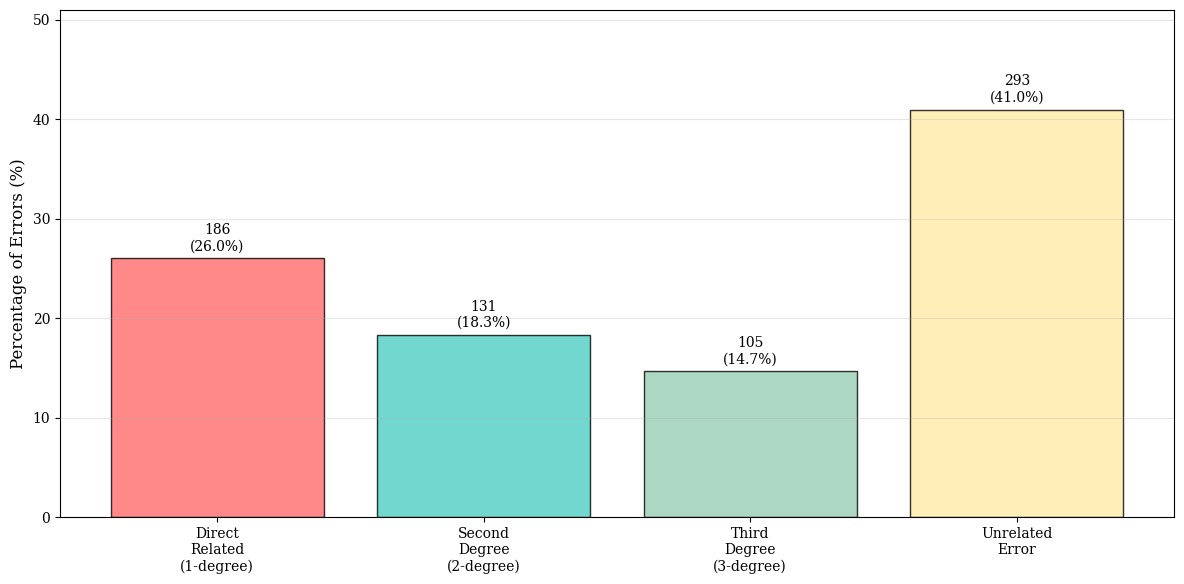

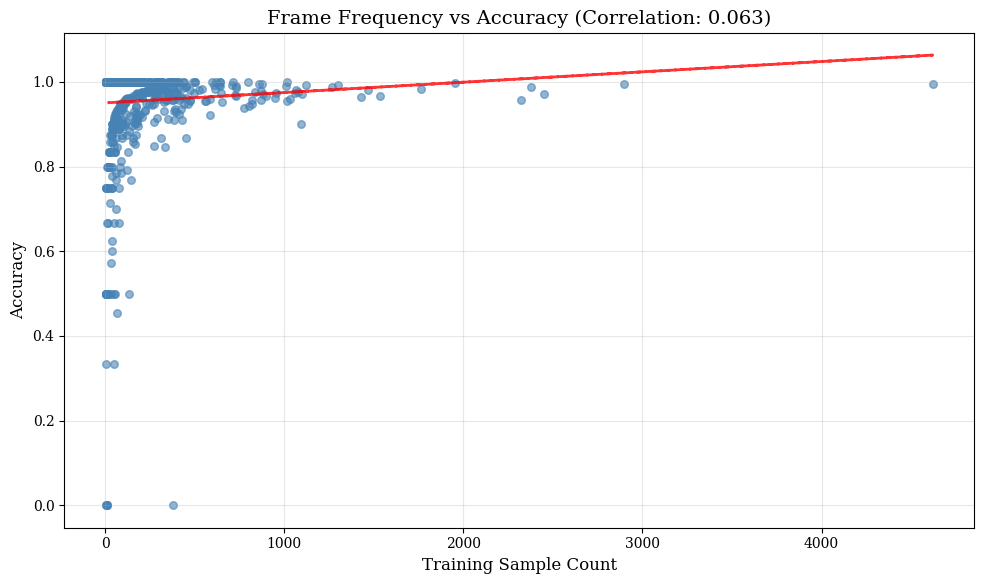


🔍 失败特征分析...


NameError: name 'predictions_df' is not defined

In [29]:
# =============================================================================
# @title ✅ 错误分析
# =============================================================================

# =============================================================================
# 简化版错误分析 - 避免KeyError
# =============================================================================

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# 设置字体
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman', 'Cambria', 'DejaVu Serif']

def run_simple_error_analysis():
    """运行简化的错误分析 - 包含full text预测结果"""

    print("🚀 开始简化错误分析...")

    # 1. 按照你的方式加载模型和数据
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"使用设备: {device}")

        # 加载最佳模型 - 使用你的流程
        model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
        print(f"加载模型: {model_path}")

        # 创建learner并加载模型
        learner = OptimizedPrototypeLearner(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        learner.model.load_state_dict(checkpoint['model_state_dict'])

        # 将prototypes转换为CPU上的numpy格式
        raw_prototypes = checkpoint['prototypes']
        learner.prototypes = {}
        for frame_name, proto in raw_prototypes.items():
            if isinstance(proto, torch.Tensor):
                learner.prototypes[frame_name] = proto.cpu().numpy()
            else:
                learner.prototypes[frame_name] = proto

        print(f"模型加载成功，原型数量: {len(learner.prototypes)}")

        # 加载数据
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        full_test_df = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        train_counts = train_df['frame_name'].value_counts()

        with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
            frame_relations = pickle.load(f)

    except Exception as e:
        print(f"❌ 数据加载失败: {e}")
        return None

    # 2. 评估原始测试集
    print("\n" + "="*50)
    print("评估原始测试集")
    print("="*50)
    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 准确率: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result1['top3_accuracy']:.4f}")

    # 3. 评估Full text测试集
    print("\n" + "="*50)
    print("评估Full Text测试集")
    print("="*50)
    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 准确率: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result2['top3_accuracy']:.4f}")

    # 4. 结果对比
    print("\n" + "="*50)
    print("结果对比")
    print("="*50)
    print(f"{'指标':<15} {'原始测试集':<12} {'Full Text':<12} {'差异':<10}")
    print("-" * 50)
    print(f"Top-1 准确率    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 准确率    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")

    # 5. 生成原始测试集的详细预测结果
    print("\n🔍 生成原始测试集详细预测结果...")
    original_predictions_df = generate_detailed_predictions(learner, test_df, "原始测试集")

    # 6. 生成Full text测试集的详细预测结果
    print("\n🔍 生成Full text测试集详细预测结果...")
    fulltext_predictions_df = generate_detailed_predictions(learner, full_test_df, "Full text测试集")

    # 7. 保存预测结果
    save_dir = "/content/drive/MyDrive/more50/framenet_data"
    original_predictions_df.to_pickle(f"{save_dir}/original_test_detailed_predictions.pkl")
    fulltext_predictions_df.to_pickle(f"{save_dir}/fulltext_test_detailed_predictions.pkl")
    print(f"✅ 预测结果已保存到 {save_dir}")

    # 8. 只对原始测试集进行错误分析
    print("\n" + "="*50)
    print("原始测试集错误分析")
    print("="*50)

    predictions_df = original_predictions_df  # 只分析原始测试集

    # 失败特征分析
    print("\n🔍 失败特征分析...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3完全失败: {len(top3_failures)}个不同frames，共{top3_failures.sum()}次失败")
    print("   最容易完全失败的frames:")
    for frame, count in top3_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}次失败 (训练样本: {train_count})")

    print(f"\nTop-1失败但Top-3成功: {len(ranking_failures)}个不同frames，共{ranking_failures.sum()}次排序问题")
    print("   最容易排序错误的frames:")
    for frame, count in ranking_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}次排序错误 (训练样本: {train_count})")

    # 语义关系分析
    print("\n🧠 语义关系分析...")
    semantic_results = analyze_semantic_relations_simple(predictions_df, frame_relations)

    # 样本饱和效应
    print("\n📊 样本饱和效应...")
    saturation_results = analyze_sample_saturation_simple(predictions_df, train_counts)

    # 生成图表
    print("\n📊 生成图表...")
    generate_charts(semantic_results, saturation_results, save_dir)

    print("\n✅ 分析完成!")

    return {
        'original_predictions': original_predictions_df,
        'fulltext_predictions': fulltext_predictions_df,
        'original_results': result1,
        'fulltext_results': result2
    }

def generate_detailed_predictions(learner, test_df, dataset_name):
    """生成详细预测结果"""
    print(f"📊 处理{dataset_name}...")

    # 准备原型数据
    prototype_frames = list(learner.prototypes.keys())
    prototype_vectors = [learner.prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # 准备测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效数据
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码
    learner.model.eval()
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, learner.tokenizer, learner.model,
        batch_size=64, train_mode=False
    ).cpu().numpy()

    # 计算相似度
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 构建预测结果
    predictions_data = []
    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        sorted_indices = np.argsort(scores)[::-1]  # 降序

        result_row = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        predictions_data.append(result_row)

    predictions_df = pd.DataFrame(predictions_data)

    # 验证准确率
    calculated_top1 = predictions_df['is_top1_correct'].mean()
    calculated_top3 = predictions_df['is_top3_correct'].mean()
    print(f"🎯 {dataset_name} Top1准确率: {calculated_top1:.4f}")
    print(f"🎯 {dataset_name} Top3准确率: {calculated_top3:.4f}")

    return predictions_df

def analyze_semantic_relations_simple(predictions_df, frame_relations):
    """简化的语义关系分析"""
    # 构建关系图
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # 二级关系
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # 三级关系
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # 分析错误
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"总错误数: {total_errors}")
    print(f"直接相关错误 (1级): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"二级相关错误 (2级): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"三级相关错误 (3级): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"语义相关错误总计: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"无关错误: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    return {
        'total_errors': total_errors,
        'direct_errors': direct_errors,
        'second_errors': second_errors,
        'third_errors': third_errors,
        'unrelated_errors': unrelated_errors
    }

def analyze_sample_saturation_simple(predictions_df, train_counts):
    """简化的样本饱和效应分析"""
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}样本: {len(segment_data)}个frames, "
                  f"准确率 {segment_data['is_top1_correct'].mean():.3f}±{segment_data['is_top1_correct'].std():.3f}")

    return frame_accuracy

def generate_charts(semantic_results, frame_accuracy, save_dir):
    """生成图表"""
    # 语义错误分解图
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [semantic_results['direct_errors'], semantic_results['second_errors'],
              semantic_results['third_errors'], semantic_results['unrelated_errors']]
    percentages = [v/semantic_results['total_errors']*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 频率相关图
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. 失败特征分析
    print("\n🔍 失败特征分析...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3完全失败: {len(top3_failures)}个不同frames，共{top3_failures.sum()}次失败")
    print(f"Top-1失败但Top-3成功: {len(ranking_failures)}个不同frames，共{ranking_failures.sum()}次排序问题")

    # 3. 语义关系分析
    print("\n🧠 语义关系分析...")

    # 构建关系图
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # 二级关系
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # 三级关系
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # 分析错误
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"总错误数: {total_errors}")
    print(f"直接相关错误 (1级): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"二级相关错误 (2级): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"三级相关错误 (3级): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"语义相关错误总计: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"无关错误: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    # 4. 样本饱和效应
    print("\n📊 样本饱和效应...")
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}样本: {len(segment_data)}个frames, "
                  f"准确率 {segment_data['is_top1_correct'].mean():.3f}±{segment_data['is_top1_correct'].std():.3f}")

    # 5. 生成图表
    print("\n📊 生成图表...")
    save_dir = "/content/drive/MyDrive/more50/framenet_data"

    # 语义错误分解图
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [direct_errors, second_errors, third_errors, unrelated_errors]
    percentages = [v/total_errors*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 频率相关图
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ 分析完成!")

    return {
        'semantic_errors': {
            'direct': direct_errors,
            'second': second_errors,
            'third': third_errors,
            'unrelated': unrelated_errors,
            'total': total_errors
        },
        'frame_accuracy': frame_accuracy
    }

# 运行分析
if __name__ == "__main__":
    results = run_simple_error_analysis()

In [54]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI 自动选择聚类数（KMeans）"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # 不足以聚类，直接平均

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # 注意去掉 +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """加载最佳训练模型"""
    print("🚀 加载最佳训练模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # 按优先级查找模型文件
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # 也查找其他可能的最佳模型文件
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"📁 找到模型: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("❌ 未找到最佳模型文件！")
        return None, None, None, None

    # 加载模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # 获取训练时的最佳准确率
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"✅ 成功加载模型，训练时最佳准确率: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """使用训练好的模型重新编码并构建聚类原型"""
    print("\n🔄 使用训练好的模型重新编码训练数据并构建聚类原型...")

    model.eval()
    frame2embeds = defaultdict(list)

    # 重新编码所有训练数据
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="重新编码训练数据"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # 收集每个frame的embeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"批次编码错误: {e}")
                continue

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行聚类构造子原型
    print("\n🎯 对每个frame进行聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="聚类构建原型"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    使用多原型进行评估，对每个样本选择最接近的子原型
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型系统进行评估")

    # 准备所有原型 - 展开多原型
    all_prototype_info = []  # (frame_name, prototype_idx, prototype_vector)
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型 (来自{len(frame_multi_prototypes)}个frame)")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # 计算与所有原型的相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # 获取所有原型的相似度分数
        scores = similarities[i]

        # 按frame分组计算最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                # 对每个frame，取该frame所有子原型中相似度最高的那个
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 根据frame级别的最高分数排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1和Top-3预测
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # 打印结果
    print(f"\n✅ 多原型评估结果 (最接近子原型策略)")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"处理样本: {results['valid_samples']}/{len(test_df)}")
    print(f"使用原型: {results['prototype_count']} (来自{results['frame_count']}个frame)")

    return results

def test_clustered_model_on_datasets():
    """测试聚类模型在两个测试集上的表现"""
    print("="*80)
    print("测试最佳训练模型+聚类原型在两个测试集上的表现")
    print("="*80)

    # 1. 加载最佳训练模型
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. 加载训练数据（用于重新构建原型）
    print("\n📊 加载训练数据...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"训练数据: {len(train_df):,} 样本")

    # 3. 使用训练好的模型重新编码并构建聚类原型
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. 分析多原型信息
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. 加载两个测试集
    print("\n📊 加载测试集...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"原始测试集: {len(test_df_original):,} 样本")
    print(f"Fulltext测试集: {len(test_df_fulltext):,} 样本")

    # 6. 在两个测试集上进行评估
    results = {}

    # 原始测试集评估
    print(f"\n" + "="*60)
    print("📊 在原始测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"原始测试集结果:")
        print(f"  Top-1准确率: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ 原始测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # Fulltext测试集评估
    print(f"\n" + "="*60)
    print("🎯 在Fulltext测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"Fulltext测试集结果:")
        print(f"  Top-1准确率: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ Fulltext测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. 结果汇总
    print(f"\n" + "="*80)
    print("聚类模型测试结果汇总 (最接近子原型策略)")
    print("="*80)

    print(f"模型信息:")
    print(f"  训练时最佳准确率: {train_best_acc:.4f}")
    print(f"  聚类统计: {clustering_stats}")

    # 显示多原型统计
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  多原型frame数: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  总原型数量: {total_prototypes}")

    print(f"\n测试集结果:")
    print(f"{'测试集':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'原始测试集':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'Fulltext测试集':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. 保存结果
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """保存结果到drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\n💾 结果已保存至: {save_path}")

def analyze_clustering_results():
    """简单分析聚类结果"""
    print(f"\n📈 聚类结果分析...")

    # 这里可以添加更详细的分析，比如：
    # - 哪些frame被聚类了
    # - 聚类数量分布
    # - 聚类质量评估等
    pass

# 运行测试
if __name__ == "__main__":
    print("🚀 开始测试最佳训练模型+聚类原型...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n✅ 测试完成！")

            # 简单的性能分析
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\n📊 性能总结:")
                print(f"  原始测试集准确率: {orig_acc:.4f}")
                print(f"  Fulltext测试集准确率: {full_acc:.4f}")
                print(f"  两个测试集平均准确率: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  原始测试集表现更好 (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  Fulltext测试集表现更好 (+{full_acc - orig_acc:.4f})")

        else:
            print(f"❌ 测试失败")

    except Exception as e:
        print(f"❌ 测试过程出错: {e}")
        import traceback
        traceback.print_exc()

🚀 开始测试最佳训练模型+聚类原型...
测试最佳训练模型+聚类原型在两个测试集上的表现
🚀 加载最佳训练模型...
📁 找到模型: best_model.pt
✅ 成功加载模型，训练时最佳准确率: 0.9282

📊 加载训练数据...
训练数据: 150,110 样本

🔄 使用训练好的模型重新编码训练数据并构建聚类原型...


重新编码训练数据: 100%|██████████| 2346/2346 [05:04<00:00,  7.70it/s]


编码完成，收集到 1014 个frame的embeddings

🎯 对每个frame进行聚类...


聚类构建原型: 100%|██████████| 1014/1014 [00:36<00:00, 27.43it/s]


聚类完成:
  单原型frame: 53
  多原型frame: 961
  总原型数量: 2974

📊 加载测试集...
原始测试集: 25,527 样本
Fulltext测试集: 6,872 样本

📊 在原始测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 25527 个测试样本，2974 个原型 (来自1014个frame)
📝 有效测试样本: 25527/25527

✅ 多原型评估结果 (最接近子原型策略)
Top-1准确率: 0.9606
Top-3准确率: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
处理样本: 25527/25527
使用原型: 2974 (来自1014个frame)
原始测试集结果:
  Top-1准确率: 0.9606
  Top-3准确率: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

🎯 在Fulltext测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 6872 个测试样本，2974 个原型 (来自1014个frame)
📝 有效测试样本: 6872/6872

✅ 多原型评估结果 (最接近子原型策略)
Top-1准确率: 0.9415
Top-3准确率: 0.9722
Macro F1: 0.8670
Weighted F1: 0.9454
处理样本: 6872/6872
使用原型: 2974 (来自1014个frame)
Fulltext测试集结果:
  Top-1准确率: 0.9415
  Top-3准确率: 0.9722
  Macro F1: 0.8670
  Weighted F1: 0.9454

聚类模型测试结果汇总 (最接近子原型策略)
模型信息:
  训练时最佳准确率: 0.9282
  聚类统计: {'single_prototype': 53, 'multi_prototype': 961, 'total_prototypes': 2974}
  多原型frame数: 961/1014
  总原型数量: 2974

测试集结果:
测试集             Top-1    Top-3    Macro F1   Weighted F1 
--------------

In [58]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI 自动选择聚类数（KMeans）"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # 不足以聚类，直接平均

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # 注意去掉 +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """加载最佳训练模型"""
    print("🚀 加载最佳训练模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # 按优先级查找模型文件
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # 也查找其他可能的最佳模型文件
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"📁 找到模型: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("❌ 未找到最佳模型文件！")
        return None, None, None, None

    # 加载模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # 获取训练时的最佳准确率
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"✅ 成功加载模型，训练时最佳准确率: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """使用训练好的模型重新编码并构建聚类原型"""
    print("\n🔄 使用训练好的模型重新编码训练数据并构建聚类原型...")

    model.eval()
    frame2embeds = defaultdict(list)

    # 重新编码所有训练数据
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="重新编码训练数据"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # 收集每个frame的embeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"批次编码错误: {e}")
                continue

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行聚类构造子原型
    print("\n🎯 对每个frame进行聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="聚类构建原型"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    使用多原型进行评估，对每个样本选择最接近的子原型
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型系统进行评估")

    # 准备所有原型 - 展开多原型
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings - 完全静默
    print("编码测试样本...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # 禁用所有tqdm进度条的环境变量
            import os
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                # 恢复原来的环境变量
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # 计算与所有原型的相似度
    print("计算相似度...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果 - 完全静默处理
    print("计算评估结果...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    # 完全静默的循环，不使用任何进度条
    for i, gold_frame in enumerate(valid_frames):
        # 获取所有原型的相似度分数
        scores = similarities[i]

        # 按frame分组计算最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 根据frame级别的最高分数排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1和Top-3预测
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # 打印结果
    print(f"\n✅ 评估完成")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果 - 只保留这个进度条
    print("计算评估结果...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    from tqdm import tqdm
    for i, gold_frame in enumerate(tqdm(valid_frames, desc="评估中", ncols=80, ascii=True)):
        # 获取所有原型的相似度分数
        scores = similarities[i]

        # 按frame分组计算最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 根据frame级别的最高分数排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1和Top-3预测
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # 打印结果
    print(f"\n✅ 评估完成")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results

def test_clustered_model_on_datasets():
    """测试聚类模型在两个测试集上的表现"""
    print("="*80)
    print("测试最佳训练模型+聚类原型在两个测试集上的表现")
    print("="*80)

    # 1. 加载最佳训练模型
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. 加载训练数据（用于重新构建原型）
    print("\n📊 加载训练数据...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"训练数据: {len(train_df):,} 样本")

    # 3. 使用训练好的模型重新编码并构建聚类原型
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. 分析多原型信息
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. 加载两个测试集
    print("\n📊 加载测试集...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"原始测试集: {len(test_df_original):,} 样本")
    print(f"Fulltext测试集: {len(test_df_fulltext):,} 样本")

    # 6. 在两个测试集上进行评估
    results = {}

    # 原始测试集评估
    print(f"\n" + "="*60)
    print("📊 在原始测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"原始测试集结果:")
        print(f"  Top-1准确率: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ 原始测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # Fulltext测试集评估
    print(f"\n" + "="*60)
    print("🎯 在Fulltext测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"Fulltext测试集结果:")
        print(f"  Top-1准确率: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ Fulltext测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. 结果汇总
    print(f"\n" + "="*80)
    print("聚类模型测试结果汇总 (最接近子原型策略)")
    print("="*80)

    print(f"模型信息:")
    print(f"  训练时最佳准确率: {train_best_acc:.4f}")
    print(f"  聚类统计: {clustering_stats}")

    # 显示多原型统计
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  多原型frame数: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  总原型数量: {total_prototypes}")

    print(f"\n测试集结果:")
    print(f"{'测试集':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'原始测试集':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'Fulltext测试集':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. 保存结果
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """保存结果到drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\n💾 结果已保存至: {save_path}")

def analyze_clustering_results():
    """简单分析聚类结果"""
    print(f"\n📈 聚类结果分析...")

    # 这里可以添加更详细的分析，比如：
    # - 哪些frame被聚类了
    # - 聚类数量分布
    # - 聚类质量评估等
    pass

# 运行测试
if __name__ == "__main__":
    print("🚀 开始测试最佳训练模型+聚类原型...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n✅ 测试完成！")

            # 简单的性能分析
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\n📊 性能总结:")
                print(f"  原始测试集准确率: {orig_acc:.4f}")
                print(f"  Fulltext测试集准确率: {full_acc:.4f}")
                print(f"  两个测试集平均准确率: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  原始测试集表现更好 (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  Fulltext测试集表现更好 (+{full_acc - orig_acc:.4f})")

        else:
            print(f"❌ 测试失败")

    except Exception as e:
        print(f"❌ 测试过程出错: {e}")
        import traceback
        traceback.print_exc()

🚀 开始测试最佳训练模型+聚类原型...
测试最佳训练模型+聚类原型在两个测试集上的表现
🚀 加载最佳训练模型...
📁 找到模型: best_model.pt
✅ 成功加载模型，训练时最佳准确率: 0.9282

📊 加载训练数据...


步骤3/8: 重新编码并构建聚类原型:  25%|██▌       | 2/8 [10:17<30:53, 308.86s/it]


训练数据: 150,110 样本

🔄 使用训练好的模型重新编码训练数据并构建聚类原型...


重新编码训练数据: 100%|██████████| 2346/2346 [05:08<00:00,  7.61it/s]


编码完成，收集到 1014 个frame的embeddings

🎯 对每个frame进行聚类...


聚类构建原型: 100%|██████████| 1014/1014 [00:36<00:00, 27.55it/s]


聚类完成:
  单原型frame: 53
  多原型frame: 961
  总原型数量: 2974

📊 加载测试集...
原始测试集: 25,527 样本
Fulltext测试集: 6,872 样本

📊 在原始测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 25527 个测试样本，2974 个原型
📝 有效测试样本: 25527/25527
编码测试样本...
计算相似度...
计算评估结果...

✅ 评估完成
Top-1准确率: 0.9606
Top-3准确率: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
原始测试集结果:
  Top-1准确率: 0.9606
  Top-3准确率: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

🎯 在Fulltext测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 6872 个测试样本，2974 个原型
📝 有效测试样本: 6872/6872
编码测试样本...
计算相似度...
计算评估结果...

✅ 评估完成
Top-1准确率: 0.9415
Top-3准确率: 0.9722
Macro F1: 0.8670
Weighted F1: 0.9454
Fulltext测试集结果:
  Top-1准确率: 0.9415
  Top-3准确率: 0.9722
  Macro F1: 0.8670
  Weighted F1: 0.9454

聚类模型测试结果汇总 (最接近子原型策略)
模型信息:
  训练时最佳准确率: 0.9282
  聚类统计: {'single_prototype': 53, 'multi_prototype': 961, 'total_prototypes': 2974}
  多原型frame数: 961/1014
  总原型数量: 2974

测试集结果:
测试集             Top-1    Top-3    Macro F1   Weighted F1 
------------------------------------------------------------
原始测试集           0.9606   0.9934   0.915

In [41]:
# ✅ 完整修复版 Few-shot Prototype Learner（含最佳模型保存 + Test 评估）

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ✅ 你自己已有的依赖项（以下假设都已经导入）
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"使用 {shot_method} 方法训练")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\n生成 {shot_num}-shot 训练数据集...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot 数据集生成完成:")
        print(f"   总样本数: {len(few_shot_df):,}")
        print(f"   样本充足frame: {stats['sufficient_samples']}")
        print(f"   样本不足frame: {stats['insufficient_samples']}")
        print(f"   平均每frame: {stats['total_samples']/len(frame_groups):.1f} 样本")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # 确保loss是标量值，不是张量
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"最佳模型已保存: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"成功加载检查点: {checkpoint_path}")
            print(f"   恢复epoch: {checkpoint['epoch']}, 最佳准确率: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"加载失败: {e}")
            print(f"加载失败路径: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """安全计算张量列表的平均值，确保处理CUDA张量"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # 将张量移到CPU并转换为标量
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # 收集损失值，确保都转换为标量
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # 更新进度条显示
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # 计算平均损失
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # 验证
            acc = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"验证准确率: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # 重建原型
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # 检查是否是最佳模型
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"连续{patience}轮无提升，提前停止")
                    break

        # 加载最佳模型
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("未找到最佳模型文件，使用最后状态")

        # 保存最终模型
        torch.save({
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc,
        }, f"{self.save_dir}/final_model.pt")
        print(f"最后一轮模型已保存")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"不支持的方法: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\n加载测试集: {len(test_df):,} 样本")
    result = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"\nTest评估完成: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n🚀 开始 {method} 训练...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\n📊 {method} 训练完成，开始最终评估...")

    # 验证集评估
    print("=" * 50)
    print("📈 验证集 (Validation) 评估:")
    val_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # 测试集评估
    print("=" * 50)
    print("🎯 测试集 (Test) 评估:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"✅ {method} 训练和评估完成!")
    print(f"📊 最终结果汇总:")
    print(f"   验证集 - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   测试集 - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# 运行训练
if __name__ == "__main__":
    # 策略B: 频繁更新，更低学习率，更多epoch

    # 3-shot训练
    learner, val_result, test_result = run_single_method_training('3-shot', epochs=20)

    # 5-shot训练
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shot训练
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)


🚀 开始 3-shot 训练...
使用 3-shot 方法训练

生成 3-shot 训练数据集...
3-shot 数据集生成完成:
   总样本数: 2,962
   样本充足frame: 961
   样本不足frame: 53
   平均每frame: 2.9 样本
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11339.37it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4081
Top-3准确率: 0.5936
Macro F1: 0.3998
Weighted F1: 0.4231
处理样本: 25113/25113
验证准确率: 0.4081 | Loss: 2.1969
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11279.41it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep1_acc0.4081.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4265
Top-3准确率: 0.6075
Macro F1: 0.4163
Weighted F1: 0.4414
处理样本: 25113/25113
验证准确率: 0.4265 | Loss: 0.9228
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11396.77it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4259
Top-3准确率: 0.6067
Macro F1: 0.4186
Weighted F1: 0.4408
处理样本: 25113/25113
验证准确率: 0.4259 | Loss: 0.5376
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11163.94it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4235
Top-3准确率: 0.6021
Macro F1: 0.4163
Weighted F1: 0.4386
处理样本: 25113/25113
验证准确率: 0.4235 | Loss: 0.3413
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11137.33it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4182
Top-3准确率: 0.5966
Macro F1: 0.4146
Weighted F1: 0.4329
处理样本: 25113/25113
验证准确率: 0.4182 | Loss: 0.2255
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11285.78it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4161
Top-3准确率: 0.5952
Macro F1: 0.4131
Weighted F1: 0.4312
处理样本: 25113/25113
验证准确率: 0.4161 | Loss: 0.1558
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11185.63it/s]


原型构建完成: 1014 frames
连续4轮无提升，提前停止
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
最后一轮模型已保存

📊 3-shot 训练完成，开始最终评估...
📈 验证集 (Validation) 评估:
📊 使用已有frame原型


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [49]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_on_original_test():
    """测试3-shot最佳模型在原始测试集上的效果"""
    print("🚀 开始测试3-shot最佳模型在原始测试集上的效果...")
    print("=" * 70)

    # 设备设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 1. 加载3-shot最佳模型
    print("\n📥 步骤1: 加载3-shot最佳模型")
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("❌ 未找到3-shot最佳模型文件！")
        return None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"📁 选择模型: {os.path.basename(best_model_path)}")
    print(f"📊 模型验证准确率: {best_acc:.4f}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("❌ 3-shot模型加载失败！")
            return None

        print(f"✅ 成功加载3-shot模型 (epoch {epoch})")

    except Exception as e:
        print(f"❌ 加载3-shot模型时出错: {e}")
        return None

    # 2. 加载原始测试集
    print("\n📊 步骤2: 加载原始测试集")
    original_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    try:
        original_test_df = pd.read_pickle(original_test_path)
        print(f"✅ 原始测试集大小: {len(original_test_df):,} 样本")

        # 显示测试集基本信息
        unique_frames = original_test_df['frame_name'].nunique()
        print(f"📋 包含frame数量: {unique_frames}")

    except Exception as e:
        print(f"❌ 无法加载原始测试集: {e}")
        print(f"检查路径: {original_test_path}")
        return None

    # 3. 在原始测试集上评估
    print("\n🎯 步骤3: 在原始测试集上评估3-shot模型")
    print("=" * 70)

    # 确保模型在评估模式
    learner.model.eval()

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                original_test_df,
                learner.prototypes
            )

        # 4. 显示详细结果
        print("\n" + "=" * 70)
        print("🎉 3-shot模型在原始测试集上的评估完成！")
        print("=" * 70)

        print(f"📈 详细测试结果:")
        print(f"   🎯 Top-1 准确率: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   🎯 Top-3 准确率: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   📊 Macro Precision: {result['macro_precision']:.4f}")
        print(f"   📊 Macro Recall: {result['macro_recall']:.4f}")
        print(f"   📊 Macro F1: {result['macro_f1']:.4f}")
        print(f"   📊 Weighted Precision: {result['weighted_precision']:.4f}")
        print(f"   📊 Weighted Recall: {result['weighted_recall']:.4f}")
        print(f"   📊 Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   📋 处理样本数: {result['valid_samples']:,} / {result['total_samples']:,}")
        print(f"   🏷️  原型数量: {result['prototype_count']}")

        # 5. 性能分析
        print(f"\n📋 性能分析:")
        coverage = result['valid_samples'] / len(original_test_df) * 100
        print(f"   样本覆盖率: {coverage:.2f}%")

        if result['top1_accuracy'] > 0.4:
            print("   🟢 表现: 优秀")
        elif result['top1_accuracy'] > 0.3:
            print("   🟡 表现: 良好")
        else:
            print("   🔴 表现: 需要改进")

        # 6. 与验证集性能对比
        print(f"\n🔄 与验证集性能对比:")
        print(f"   验证集准确率: {best_acc:.4f}")
        print(f"   测试集准确率: {result['top1_accuracy']:.4f}")
        diff = result['top1_accuracy'] - best_acc
        if abs(diff) < 0.01:
            print(f"   差异: {diff:+.4f} (稳定)")
        elif diff > 0:
            print(f"   差异: {diff:+.4f} (测试集更好)")
        else:
            print(f"   差异: {diff:+.4f} (可能过拟合)")

        return result

    except Exception as e:
        print(f"❌ 原始测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        return None

    finally:
        # 清理GPU内存
        if 'learner' in locals():
            del learner
        torch.cuda.empty_cache()

def quick_3shot_test():
    """快速版本的3-shot原始测试集测试"""
    print("⚡ 快速测试3-shot模型在原始测试集...")

    result = test_3shot_on_original_test()

    if result:
        print(f"\n🎊 测试完成！")
        print(f"🏆 最终结果: Top-1准确率 {result['top1_accuracy']:.4f}, Macro F1 {result['macro_f1']:.4f}")
        return result
    else:
        print("💥 测试失败")
        return None

# 运行测试
if __name__ == "__main__":
    print("🧪 3-shot模型原始测试集评估")
    print("选择运行方式:")
    print("1. 详细测试 (推荐)")
    print("2. 快速测试")

    # 运行详细测试
    result = test_3shot_on_original_test()

    # 如果你想要快速测试，可以用下面这行：
    # result = quick_3shot_test()

🧪 3-shot模型原始测试集评估
选择运行方式:
1. 详细测试 (推荐)
2. 快速测试
🚀 开始测试3-shot最佳模型在原始测试集上的效果...
使用设备: cuda

📥 步骤1: 加载3-shot最佳模型
📁 选择模型: best_model_ep2_acc0.4265.pt
📊 模型验证准确率: 0.4265
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载3-shot模型 (epoch 2)

📊 步骤2: 加载原始测试集
✅ 原始测试集大小: 25,527 样本
📋 包含frame数量: 907

🎯 步骤3: 在原始测试集上评估3-shot模型
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4381
Top-3准确率: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
处理样本: 25527/25527

🎉 3-shot模型在原始测试集上的评估完成！
📈 详细测试结果:
   🎯 Top-1 准确率: 0.4381 (43.81%)
   🎯 Top-3 准确率: 0.6180 (61.80%)
   📊 Macro Precision: 0.4203
   📊 Macro Recall: 0.5560
   📊 Macro F1: 0.4219
   📊 Weighted Precision: 0.6066
   📊 Weighted Recall: 0.4381
   📊 Weighted F1: 0.4505
   📋 处理样本数: 25,527 / 25,527
   🏷️  原型数量: 1014

📋 性能分析:
   样本覆盖率: 100.00%
   🟢 表现: 优秀

🔄 与验证集性能对比:
   验证集准确率: 0.4265
   测试集准确率: 0.

In [47]:
# ✅ 完整修复版 Few-shot Prototype Learner（含最佳模型保存 + Test 评估）

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ✅ 你自己已有的依赖项（以下假设都已经导入）
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"使用 {shot_method} 方法训练")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\n生成 {shot_num}-shot 训练数据集...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot 数据集生成完成:")
        print(f"   总样本数: {len(few_shot_df):,}")
        print(f"   样本充足frame: {stats['sufficient_samples']}")
        print(f"   样本不足frame: {stats['insufficient_samples']}")
        print(f"   平均每frame: {stats['total_samples']/len(frame_groups):.1f} 样本")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # 确保loss是标量值，不是张量
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"最佳模型已保存: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"成功加载检查点: {checkpoint_path}")
            print(f"   恢复epoch: {checkpoint['epoch']}, 最佳准确率: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"加载失败: {e}")
            print(f"加载失败路径: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """安全计算张量列表的平均值，确保处理CUDA张量"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # 将张量移到CPU并转换为标量
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # 收集损失值，确保都转换为标量
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # 更新进度条显示
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # 计算平均损失
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # 验证
            self.model.eval()
            with torch.no_grad():
                acc = evaluate_target_known_fixed(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"验证准确率: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # 切换回训练模式
            self.model.train()

            # 重建原型
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # 检查是否是最佳模型
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"连续{patience}轮无提升，提前停止")
                    break

        # 加载最佳模型
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("未找到最佳模型文件，使用最后状态")

        # 保存最终模型
        final_checkpoint = {
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc if 'acc' in locals() else 0.0,
        }
        torch.save(final_checkpoint, f"{self.save_dir}/final_model.pt")
        print(f"最后一轮模型已保存")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"不支持的方法: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    """安全的测试集评估函数，确保所有张量操作正确处理"""
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\n加载测试集: {len(test_df):,} 样本")

    # 确保模型在eval模式
    learner.model.eval()

    with torch.no_grad():
        result = evaluate_target_known_fixed(learner.model, learner.tokenizer, test_df, learner.prototypes)

    print(f"\nTest评估完成: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def safe_evaluate_target_known(model, tokenizer, df, prototypes):
    """安全版本的evaluate_target_known，处理CUDA张量问题"""
    try:
        model.eval()
        with torch.no_grad():
            result = evaluate_target_known(model, tokenizer, df, prototypes)
        return result
    except Exception as e:
        print(f"评估过程中出现错误: {e}")
        print("尝试手动清理GPU缓存...")
        torch.cuda.empty_cache()

        # 重试一次
        try:
            model.eval()
            with torch.no_grad():
                result = evaluate_target_known(model, tokenizer, df, prototypes)
            return result
        except Exception as e2:
            print(f"重试后仍然失败: {e2}")
            # 返回默认结果避免崩溃
            return {'top1_accuracy': 0.0, 'macro_f1': 0.0}

def evaluate_target_known_fixed(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    修复版的Target-known评估：给定target span，评估frame分类准确率
    修复了CUDA张量转换问题
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()

    # 获取或计算frame原型
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("必须提供frame_prototypes或train_df之一")
        print("🔄 现场计算frame原型...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("📊 使用已有frame原型")

    # 准备原型矩阵 - 修复CUDA张量问题
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = []

    for frame in prototype_frames:
        prototype_vec = frame_prototypes[frame]
        # 确保原型向量转换为numpy数组
        if torch.is_tensor(prototype_vec):
            prototype_vectors.append(prototype_vec.detach().cpu().numpy())
        else:
            prototype_vectors.append(prototype_vec)

    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(prototype_frames)} 个frame原型")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings - 修复CUDA张量问题
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        # 确保安全转换为numpy
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # 计算cosine相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # 获取top-N预测
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # 降序排列
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # 打印结果
    print(f"\n✅ Target-known评估结果 (Cosine相似度)")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"处理样本: {results['valid_samples']}/{len(test_df)}")

    return results

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n🚀 开始 {method} 训练...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\n📊 {method} 训练完成，开始最终评估...")

    # 验证集评估
    print("=" * 50)
    print("📈 验证集 (Validation) 评估:")
    val_result = evaluate_target_known_fixed(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # 测试集评估
    print("=" * 50)
    print("🎯 测试集 (Test) 评估:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"✅ {method} 训练和评估完成!")
    print(f"📊 最终结果汇总:")
    print(f"   验证集 - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   测试集 - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# 运行训练
if __name__ == "__main__":
    # 策略B: 频繁更新，更低学习率，更多epoch


    # 5-shot训练
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shot训练
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)




🚀 开始 5-shot 训练...
使用 5-shot 方法训练

生成 5-shot 训练数据集...
5-shot 数据集生成完成:
   总样本数: 4,804
   样本充足frame: 910
   样本不足frame: 104
   平均每frame: 4.7 样本
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7919.19it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4590
Top-3准确率: 0.6517
Macro F1: 0.4742
Weighted F1: 0.4795
处理样本: 25113/25113
验证准确率: 0.4590 | Loss: 5.3338
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7802.68it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep1_acc0.4590.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4971
Top-3准确率: 0.6811
Macro F1: 0.5150
Weighted F1: 0.5213
处理样本: 25113/25113
验证准确率: 0.4971 | Loss: 1.7640
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 8065.05it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4870
Top-3准确率: 0.6651
Macro F1: 0.5158
Weighted F1: 0.5136
处理样本: 25113/25113
验证准确率: 0.4870 | Loss: 0.8143
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7843.94it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4874
Top-3准确率: 0.6643
Macro F1: 0.5050
Weighted F1: 0.5109
处理样本: 25113/25113
验证准确率: 0.4874 | Loss: 0.4664
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7945.49it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4905
Top-3准确率: 0.6688
Macro F1: 0.4995
Weighted F1: 0.5108
处理样本: 25113/25113
验证准确率: 0.4905 | Loss: 0.3111
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7966.99it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4847
Top-3准确率: 0.6622
Macro F1: 0.4951
Weighted F1: 0.5051
处理样本: 25113/25113
验证准确率: 0.4847 | Loss: 0.2274
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 8057.46it/s]


原型构建完成: 1014 frames
连续4轮无提升，提前停止
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt
   恢复epoch: 2, 最佳准确率: 0.4971
最后一轮模型已保存

📊 5-shot 训练完成，开始最终评估...
📈 验证集 (Validation) 评估:
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5168
Top-3准确率: 0.7045
Macro F1: 0.5085
Weighted F1: 0.5353
处理样本: 25113/25113
Val Top-1: 0.5168, Macro F1: 0.5085
🎯 测试集 (Test) 评估:

加载测试集: 25,527 样本
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5231
Top-3准确率: 0.7052
Macro F1: 0.5161
Weighted F1: 0.5388
处理样本: 25527/25527

Test评估完成: Top-1: 0.5231, Macro F1: 0.5161
✅ 5-shot 训练和评估完成!
📊 最终结果汇总:
   验证集 - Top-1: 0.5168, Macro F1: 0.5085
   测试集 - Top-1: 0.5231, Macro F1: 0.5161

🚀 开始 10-shot 训练...
使用 10-shot 方法训练

生成 10-shot 训练数据集...
10-shot 数据集生成完成:
   总样本数: 9,156
   样本充足frame: 838
   样本不足frame: 176
   平均每frame: 9.0 样本
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4788.62it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4361
Top-3准确率: 0.6209
Macro F1: 0.4970
Weighted F1: 0.4639
处理样本: 25113/25113
验证准确率: 0.4361 | Loss: 6.9749
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4935.35it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep1_acc0.4361.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4995
Top-3准确率: 0.6674
Macro F1: 0.5658
Weighted F1: 0.5365
处理样本: 25113/25113
验证准确率: 0.4995 | Loss: 1.3416
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4888.73it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep2_acc0.4995.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5927
Top-3准确率: 0.7729
Macro F1: 0.5974
Weighted F1: 0.6046
处理样本: 25113/25113
验证准确率: 0.5927 | Loss: 0.6197
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4886.51it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep3_acc0.5927.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6051
Top-3准确率: 0.7828
Macro F1: 0.6128
Weighted F1: 0.6209
处理样本: 25113/25113
验证准确率: 0.6051 | Loss: 0.4709
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4932.78it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep4_acc0.6051.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6076
Top-3准确率: 0.7863
Macro F1: 0.6122
Weighted F1: 0.6225
处理样本: 25113/25113
验证准确率: 0.6076 | Loss: 0.3826
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4904.27it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6032
Top-3准确率: 0.7839
Macro F1: 0.6080
Weighted F1: 0.6161
处理样本: 25113/25113
验证准确率: 0.6032 | Loss: 0.3206
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4879.61it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5950
Top-3准确率: 0.7763
Macro F1: 0.6021
Weighted F1: 0.6070
处理样本: 25113/25113
验证准确率: 0.5950 | Loss: 0.2629
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4914.16it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5999
Top-3准确率: 0.7841
Macro F1: 0.6008
Weighted F1: 0.6116
处理样本: 25113/25113
验证准确率: 0.5999 | Loss: 0.2204
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4952.47it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5905
Top-3准确率: 0.7717
Macro F1: 0.6012
Weighted F1: 0.6022
处理样本: 25113/25113
验证准确率: 0.5905 | Loss: 0.1887
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4891.65it/s]


原型构建完成: 1014 frames
连续4轮无提升，提前停止
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt
   恢复epoch: 5, 最佳准确率: 0.6076
最后一轮模型已保存

📊 10-shot 训练完成，开始最终评估...
📈 验证集 (Validation) 评估:
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6059
Top-3准确率: 0.7854
Macro F1: 0.6087
Weighted F1: 0.6193
处理样本: 25113/25113
Val Top-1: 0.6059, Macro F1: 0.6087
🎯 测试集 (Test) 评估:

加载测试集: 25,527 样本
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6051
Top-3准确率: 0.7876
Macro F1: 0.6134
Weighted F1: 0.6168
处理样本: 25527/25527

Test评估完成: Top-1: 0.6051, Macro F1: 0.6134
✅ 10-shot 训练和评估完成!
📊 最终结果汇总:
   验证集 - Top-1: 0.6059, Macro F1: 0.6087
   测试集 - Top-1: 0.6051, Macro F1: 0.6134


In [48]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def load_best_model(shot_method):
    """加载指定shot方法的最佳模型"""
    print(f"\n🚀 加载 {shot_method} 最佳模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"❌ 未找到 {shot_method} 最佳模型文件！")
        return None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        # 从文件名提取准确率
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]  # 备选方案

    print(f"📁 选择模型: {best_model_path}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"❌ {shot_method} 模型加载失败！")
            return None

        print(f"✅ 成功加载 {shot_method} 模型 (epoch {epoch}, acc {best_acc:.4f})")
        return learner

    except Exception as e:
        print(f"❌ 加载 {shot_method} 模型时出错: {e}")
        return None

def test_on_fulltext(learner, shot_method):
    """在fulltext测试集上测试模型"""
    print(f"\n🎯 在Fulltext测试集上测试 {shot_method} 模型...")

    # 加载fulltext测试数据
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

    try:
        fulltext_test_df = pd.read_pickle(test_path)
        print(f"📊 Fulltext测试集大小: {len(fulltext_test_df):,} 样本")
    except Exception as e:
        print(f"❌ 无法加载Fulltext测试集: {e}")
        return None

    # 确保模型在评估模式
    learner.model.eval()

    # 在fulltext测试集上评估
    print("=" * 60)
    print(f"🔥 开始 {shot_method} 模型在Fulltext测试集上的评估...")

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                fulltext_test_df,
                learner.prototypes
            )

        print("=" * 60)
        print(f"🎉 {shot_method} 模型Fulltext测试完成！")
        print(f"📈 Fulltext测试结果:")
        print(f"   Top-1 准确率: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 准确率: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {result['macro_f1']:.4f}")
        print(f"   Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   处理样本数: {result['valid_samples']}")
        print(f"   原型数量: {result['prototype_count']}")

        return result

    except Exception as e:
        print(f"❌ {shot_method} 模型Fulltext测试失败: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_all_models_on_fulltext():
    """测试所有最佳模型在fulltext测试集上的效果"""
    print("🚀 开始测试所有最佳模型在Fulltext测试集上的效果...")
    print("=" * 80)

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n{'='*20} {shot_method.upper()} MODEL {'='*20}")

        # 加载模型
        learner = load_best_model(shot_method)
        if learner is None:
            print(f"⚠️  跳过 {shot_method} 模型测试")
            continue

        # 在fulltext测试集上测试
        result = test_on_fulltext(learner, shot_method)
        if result:
            results[shot_method] = result

        # 清理GPU内存
        del learner
        torch.cuda.empty_cache()

    # 汇总结果
    print("\n" + "="*80)
    print("📊 FULLTEXT测试集结果汇总:")
    print("="*80)

    if results:
        print(f"{'Model':<10} {'Top-1 Acc':<12} {'Top-3 Acc':<12} {'Macro F1':<10} {'Weighted F1':<12}")
        print("-" * 60)

        for shot_method, result in results.items():
            print(f"{shot_method:<10} {result['top1_accuracy']:<12.4f} {result['top3_accuracy']:<12.4f} {result['macro_f1']:<10.4f} {result['weighted_f1']:<12.4f}")

        # 找到最佳模型
        best_method = max(results.keys(), key=lambda x: results[x]['top1_accuracy'])
        best_acc = results[best_method]['top1_accuracy']
        print(f"\n🏆 在Fulltext测试集上表现最佳: {best_method} (Top-1: {best_acc:.4f})")
    else:
        print("❌ 没有成功的测试结果")

    return results

def test_single_model_fulltext(shot_method):
    """测试单个模型在fulltext上的效果"""
    print(f"🎯 单独测试 {shot_method} 模型在Fulltext测试集上的效果")

    # 加载模型
    learner = load_best_model(shot_method)
    if learner is None:
        return None

    # 测试
    result = test_on_fulltext(learner, shot_method)

    # 清理
    del learner
    torch.cuda.empty_cache()

    return result

# 运行测试
if __name__ == "__main__":
    # 选择测试方式：

    # 方式1: 测试所有模型
    print("🔥 选择测试方式:")
    print("1. 测试所有模型 (3-shot, 5-shot, 10-shot)")
    print("2. 单独测试某个模型")

    # 默认测试所有模型
    all_results = test_all_models_on_fulltext()

    # 如果你只想测试某个特定模型，可以用下面的代码：
    # result = test_single_model_fulltext("3-shot")
    # result = test_single_model_fulltext("5-shot")
    # result = test_single_model_fulltext("10-shot")

🔥 选择测试方式:
1. 测试所有模型 (3-shot, 5-shot, 10-shot)
2. 单独测试某个模型
🚀 开始测试所有最佳模型在Fulltext测试集上的效果...

==================== 3-SHOT MODEL ====================

🚀 加载 3-shot 最佳模型...
📁 选择模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载 3-shot 模型 (epoch 2, acc 0.4265)

🎯 在Fulltext测试集上测试 3-shot 模型...
📊 Fulltext测试集大小: 6,872 样本
🔥 开始 3-shot 模型在Fulltext测试集上的评估...
📊 使用已有frame原型
🎯 评估 6872 个测试样本，1014 个frame原型
📝 有效测试样本: 6872/6872

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4288
Top-3准确率: 0.6032
Macro F1: 0.2830
Weighted F1: 0.4501
处理样本: 6872/6872
🎉 3-shot 模型Fulltext测试完成！
📈 Fulltext测试结果:
   Top-1 准确率: 0.4288 (42.88%)
   Top-3 准确率: 0.6032 (60.32%)
   Macro F1: 0.2830
   Weighted F1: 0.4501
   处理样本数: 6872
   原型数量: 1014

==================== 5-SHOT MODEL ====================

🚀 加载 5-shot 最佳模型...
📁 选择模型: 

In [46]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_best_model():
    """测试3-shot最佳模型在测试集上的效果"""

    print("🚀 开始测试3-shot最佳模型...")

    # 设备设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 查找3-shot最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("❌ 未找到3-shot最佳模型文件！")
        print(f"检查路径: {checkpoint_dir}")
        return None

    # 选择最新的最佳模型文件（按文件名排序）
    best_model_path = sorted(best_model_files)[-1]
    print(f"📁 找到最佳模型: {best_model_path}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # 加载最佳模型
        print("📥 加载最佳模型...")
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("❌ 模型加载失败！")
            return None

        print(f"✅ 成功加载模型 (epoch {epoch})")

        # 加载测试数据
        print("📊 加载测试数据...")
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        print(f"测试集大小: {len(test_df):,} 样本")

        # 确保模型在评估模式
        learner.model.eval()

        # 在测试集上评估
        print("🎯 开始测试集评估...")
        print("=" * 60)

        with torch.no_grad():
            test_result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                test_df,
                learner.prototypes
            )

        print("=" * 60)
        print("🎉 3-shot模型测试完成！")
        print(f"📈 最终测试结果:")
        print(f"   Top-1 准确率: {test_result['top1_accuracy']:.4f} ({test_result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 准确率: {test_result['top3_accuracy']:.4f} ({test_result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {test_result['macro_f1']:.4f}")
        print(f"   Weighted F1: {test_result['weighted_f1']:.4f}")
        print(f"   处理样本数: {test_result['valid_samples']}")
        print(f"   原型数量: {test_result['prototype_count']}")

        return test_result

    except Exception as e:
        print(f"❌ 测试过程中出现错误: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_test_model_loading():
    """快速测试模型加载功能"""
    print("🔧 快速测试模型加载...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # 创建学习器
        learner = OptimizedPrototypeLearnerWithFewShot(device=device, shot_method="3-shot")
        print("✅ 学习器创建成功")

        # 检查模型文件
        checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
        if os.path.exists(checkpoint_dir):
            files = os.listdir(checkpoint_dir)
            print(f"📁 checkpoint目录内容: {files}")

            best_files = [f for f in files if f.startswith('best_model_')]
            if best_files:
                print(f"🎯 找到最佳模型文件: {best_files}")
            else:
                print("⚠️  未找到最佳模型文件")
        else:
            print(f"❌ checkpoint目录不存在: {checkpoint_dir}")

        return True

    except Exception as e:
        print(f"❌ 快速测试失败: {e}")
        return False

# 运行测试
if __name__ == "__main__":
    print("🧪 开始模型测试...")

    # 先做快速测试
    if quick_test_model_loading():
        print("\n" + "="*60)
        # 再做完整测试
        result = test_3shot_best_model()

        if result:
            print(f"\n🎊 测试成功完成！最终准确率: {result['top1_accuracy']:.4f}")
        else:
            print("\n💥 测试失败，请检查错误信息")
    else:
        print("💥 快速测试失败，无法继续")

🧪 开始模型测试...
🔧 快速测试模型加载...
使用 3-shot 方法训练
✅ 学习器创建成功
📁 checkpoint目录内容: ['checkpoint_epoch2.pt', 'checkpoint_epoch4.pt', 'checkpoint_epoch5.pt', 'best_model.pt', 'best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt', 'final_model.pt']
🎯 找到最佳模型文件: ['best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt']

🚀 开始测试3-shot最佳模型...
使用设备: cuda
📁 找到最佳模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
使用 3-shot 方法训练
📥 加载最佳模型...
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载模型 (epoch 2)
📊 加载测试数据...
测试集大小: 25,527 样本
🎯 开始测试集评估...
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4381
Top-3准确率: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
处理样本: 25527/25527
🎉 3-shot模型测试完成！
📈 最终测试结果:
   Top-1 准确率: 0.4381 (43.81%)
   Top-3 准确率: 0.6180 (61.80%)
   Macro F1: 0.4219
   Weighted F1: 0.4505
 

In [25]:
# @title 评估 unknown
def evaluate_target_unknown_like_target_known(model, tokenizer, test_df, frame_prototypes,
                                            save_path=None):
    """与Target Known完全一致的评估逻辑"""

    model.eval()
    print("📊 使用与Target Known一致的评估逻辑")

    # 准备原型矩阵（与Target Known一致）
    prototype_frames = list(frame_prototypes.keys())
    prototype_matrix = np.array([frame_prototypes[frame] for frame in prototype_frames])

    print(f"🎯 Target-unknown评估: {len(test_df)} 样本，{len(prototype_frames)} 个frame原型")

    # 与Target Known一样处理数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans（与Target Known一致）
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 关键差异：检查gold spans是否被tokenizer覆盖
    covered_sentences = []
    covered_spans = []
    covered_frames = []
    all_detailed_matches = []
    coverage_count = 0

    for i, (sentence, spans, frame) in enumerate(tqdm(zip(valid_sentences, valid_spans, valid_frames),
                                                     desc="检查覆盖率")):
        # 生成tokenizer候选spans
        candidate_spans = generate_candidate_spans_tokenizer_based(sentence, tokenizer)

        # 检查gold span是否被覆盖
        gold_span = (int(spans[0][0]), int(spans[0][1])) if spans else None

        if gold_span:
            # 检查是否有候选span与gold span重叠
            is_covered = any(span[1] > gold_span[0] and span[0] < gold_span[1]
                           for span in candidate_spans)

            if is_covered:
                covered_sentences.append(sentence)
                covered_spans.append(spans)
                covered_frames.append(frame)
                coverage_count += 1

                # 记录被覆盖的详细信息
                all_detailed_matches.append({
                    'sentence': sentence,
                    'gold_span': gold_span,
                    'gold_frame': frame,
                    'gold_span_text': sentence[gold_span[0]:gold_span[1]],
                    'is_covered': True,
                    'original_index': valid_indices[i]
                })
            else:
                # 记录未被覆盖的信息
                all_detailed_matches.append({
                    'sentence': sentence,
                    'gold_span': gold_span,
                    'gold_frame': frame,
                    'gold_span_text': sentence[gold_span[0]:gold_span[1]] if gold_span else '',
                    'is_covered': False,
                    'original_index': valid_indices[i]
                })

    print(f"📊 Tokenizer覆盖率: {coverage_count}/{len(valid_frames)} = {coverage_count/len(valid_frames):.4f}")

    # 只对被覆盖的样本进行评估（这样才公平）
    if coverage_count == 0:
        print("⚠️ 没有样本被覆盖，无法评估")
        return {
            "metrics": {"top1_accuracy": 0, "top3_accuracy": 0, "coverage_rate": 0,
                       "macro_f1": 0, "weighted_f1": 0},
            "statistics": {"covered_samples": 0, "total_samples": len(valid_frames)},
            "detailed_matches": all_detailed_matches
        }

    # 批量编码被覆盖的target embeddings（与Target Known一致）
    test_embeddings = encode_target_spans_batch(
        covered_sentences, covered_spans, tokenizer, model,
        batch_size=64, train_mode=False
    ).cpu().numpy()

    # 计算cosine相似度（与Target Known一致）
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果（与Target Known一致）
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(covered_frames):
        scores = similarities[i]
        top_indices = np.argsort(scores)[-3:][::-1]  # top3
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        is_top1_correct = gold_frame == top_preds[0]
        is_top3_correct = gold_frame in top_preds

        if is_top1_correct:
            correct_top1 += 1
        if is_top3_correct:
            correct_top3 += 1

        # 更新详细匹配信息
        for match in all_detailed_matches:
            if (match['is_covered'] and
                match['gold_frame'] == gold_frame and
                match['sentence'] == covered_sentences[i]):
                match['pred_top1_frame'] = top_preds[0]
                match['pred_top3_frames'] = top_preds
                match['is_top1_correct'] = is_top1_correct
                match['is_top3_correct'] = is_top3_correct
                break

    # Frame分类指标（与Target Known一致）
    if y_true and y_pred_top1:
        unique_frames = sorted(set(y_true + y_pred_top1))
        frame_to_id = {f: i for i, f in enumerate(unique_frames)}
        y_true_ids = [frame_to_id[f] for f in y_true]
        y_pred_ids = [frame_to_id[f] for f in y_pred_top1]
        macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="macro", zero_division=0)
        weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="weighted", zero_division=0)
    else:
        macro_p = macro_r = macro_f = 0
        weighted_p = weighted_r = weighted_f = 0

    # 组织结果
    results = {
        "metrics": {
            "top1_accuracy": correct_top1 / coverage_count if coverage_count > 0 else 0,
            "top3_accuracy": correct_top3 / coverage_count if coverage_count > 0 else 0,
            "coverage_rate": coverage_count / len(valid_frames),
            "macro_precision": macro_p,
            "macro_recall": macro_r,
            "macro_f1": macro_f,
            "weighted_precision": weighted_p,
            "weighted_recall": weighted_r,
            "weighted_f1": weighted_f
        },
        "statistics": {
            "covered_samples": coverage_count,
            "total_samples": len(valid_frames),
            "valid_samples": len(valid_frames),
            "test_df_size": len(test_df)
        },
        "detailed_matches": all_detailed_matches,
        "metadata": {
            "strategy": "target_known_compatible",
            "prototype_count": len(prototype_frames)
        }
    }

    # 保存结果
    if save_path:
        import pickle
        with open(save_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"💾 结果已保存到: {save_path}")

    # 打印结果
    metrics = results["metrics"]
    stats = results["statistics"]

    print(f"\n✅ Target-unknown评估结果 (Target Known兼容版)")
    print(f"覆盖率: {metrics['coverage_rate']:.4f} ({stats['covered_samples']}/{stats['total_samples']})")
    print(f"Frame Top-1: {metrics['top1_accuracy']:.4f} (基于被覆盖样本)")
    print(f"Frame Top-3: {metrics['top3_accuracy']:.4f} (基于被覆盖样本)")
    print(f"Macro F1: {metrics['macro_f1']:.4f}")
    print(f"Weighted F1: {metrics['weighted_f1']:.4f}")
    print(f"处理样本: {stats['valid_samples']}/{stats['test_df_size']}")

    return results


def quick_test_target_known_compatible(dataset="fulltext", num_sentences=100):
    """快速测试Target Known兼容版本"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 快速测试Target Known兼容版本 - {dataset} (前{num_sentences}个句子)")

    # 简化的模型加载
    from transformers import AutoModel, AutoTokenizer

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    print(f"✅ 模型加载成功，原型数量: {len(prototypes)}")

    # 加载数据
    if dataset == "fulltext":
        test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    else:
        test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    test_df = pd.read_pickle(test_path)

    # 只取前N个句子
    sentences = test_df["sentence"].unique()[:num_sentences]
    subset_df = test_df[test_df["sentence"].isin(sentences)]

    print(f"📊 测试数据: {len(subset_df)} 样本，{len(sentences)} 个句子")

    # 运行Target Known兼容评估
    result = evaluate_target_unknown_like_target_known(
        model, tokenizer, subset_df, prototypes
    )

    return result


def run_complete_target_known_compatible_test():
    """运行完整的Target Known兼容测试"""

    import os
    from transformers import AutoModel, AutoTokenizer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Target Known兼容测试，设备: {device}")

    # 加载模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    print(f"✅ 模型加载成功，原型数量: {len(prototypes)}")

    # 创建保存目录
    save_dir = "/content/drive/MyDrive/more50/framenet_data/target_unknown_results"
    os.makedirs(save_dir, exist_ok=True)

    # 1. 测试Full Text数据集
    print("\n" + "="*60)
    print("📊 测试Full Text数据集 (Target Known兼容)")
    print("="*60)

    full_test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(full_test_path)
    print(f"样本数量: {len(full_test_df):,}")

    full_save_path = os.path.join(save_dir, "target_unknown_fulltext_compatible.pkl")
    full_result = evaluate_target_unknown_like_target_known(
        model, tokenizer, full_test_df, prototypes, full_save_path
    )

    # 2. 测试原始数据集
    print("\n" + "="*60)
    print("📊 测试原始数据集 (Target Known兼容)")
    print("="*60)

    orig_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    orig_test_df = pd.read_pickle(orig_test_path)
    print(f"样本数量: {len(orig_test_df):,}")

    orig_save_path = os.path.join(save_dir, "target_unknown_original_compatible.pkl")
    orig_result = evaluate_target_unknown_like_target_known(
        model, tokenizer, orig_test_df, prototypes, orig_save_path
    )

    # 3. 对比结果
    print("\n" + "="*60)
    print("📊 Target Known兼容版结果对比")
    print("="*60)

    full_metrics = full_result['metrics']
    orig_metrics = orig_result['metrics']

    print(f"{'指标':<15} {'Full Text':<12} {'原始测试集':<12} {'差异':<10}")
    print("-" * 52)
    print(f"覆盖率          {full_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']-full_metrics['coverage_rate']:+.4f}")
    print(f"Frame Top-1     {full_metrics['top1_accuracy']:.4f}       {orig_metrics['top1_accuracy']:.4f}       {orig_metrics['top1_accuracy']-full_metrics['top1_accuracy']:+.4f}")
    print(f"Frame Top-3     {full_metrics['top3_accuracy']:.4f}       {orig_metrics['top3_accuracy']:.4f}       {orig_metrics['top3_accuracy']-full_metrics['top3_accuracy']:+.4f}")
    print(f"Macro F1        {full_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']-full_metrics['macro_f1']:+.4f}")
    print(f"Weighted F1     {full_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']-full_metrics['weighted_f1']:+.4f}")

    print(f"\n📊 与Target Known对比参考:")
    print(f"Full Text Target Known: Top-1: 94.82%, Top-3: 97.03%, Macro F1: 87.82%, Weighted F1: 95.16%")
    print(f"Full Text Target Unknown: Top-1: {full_metrics['top1_accuracy']:.2%}, Top-3: {full_metrics['top3_accuracy']:.2%}, Macro F1: {full_metrics['macro_f1']:.2%}, Weighted F1: {full_metrics['weighted_f1']:.2%}")

    return full_result, orig_result, full_save_path, orig_save_path


def run_fast_tokenizer_test():
    """运行快速的tokenizer测试（基于之前成功的版本）"""

    import os
    from transformers import AutoModel, AutoTokenizer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 快速Tokenizer测试，设备: {device}")

    # 简化的模型加载
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    print(f"✅ 模型加载成功，原型数量: {len(prototypes)}")

    # 创建保存目录
    save_dir = "/content/drive/MyDrive/more50/framenet_data/target_unknown_results"
    os.makedirs(save_dir, exist_ok=True)

    # 1. 测试Full Text数据集
    print("\n" + "="*60)
    print("📊 测试Full Text数据集")
    print("="*60)

    full_test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(full_test_path)
    print(f"样本数量: {len(full_test_df):,}")

    full_save_path = os.path.join(save_dir, "target_unknown_fulltext_fast.pkl")
    full_result = evaluate_target_unknown_tokenizer_fast(
        model, tokenizer, full_test_df, prototypes, full_save_path
    )

    # 2. 测试原始数据集
    print("\n" + "="*60)
    print("📊 测试原始数据集")
    print("="*60)

    orig_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    orig_test_df = pd.read_pickle(orig_test_path)
    print(f"样本数量: {len(orig_test_df):,}")

    orig_save_path = os.path.join(save_dir, "target_unknown_original_fast.pkl")
    orig_result = evaluate_target_unknown_tokenizer_fast(
        model, tokenizer, orig_test_df, prototypes, orig_save_path
    )

    # 3. 对比结果
    print("\n" + "="*60)
    print("📊 结果对比")
    print("="*60)

    full_metrics = full_result['metrics']
    orig_metrics = orig_result['metrics']

    print(f"{'指标':<15} {'Full Text':<12} {'原始测试集':<12} {'差异':<10}")
    print("-" * 52)
    print(f"覆盖率          {full_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']-full_metrics['coverage_rate']:+.4f}")
    print(f"Frame准确率      {full_metrics['frame_top1_accuracy']:.4f}       {orig_metrics['frame_top1_accuracy']:.4f}       {orig_metrics['frame_top1_accuracy']-full_metrics['frame_top1_accuracy']:+.4f}")
    print(f"Macro F1        {full_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']-full_metrics['macro_f1']:+.4f}")
    print(f"Weighted F1     {full_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']-full_metrics['weighted_f1']:+.4f}")

    print(f"\n📊 与Target Known对比参考:")
    print(f"Full Text Target Known: Top-1: 94.82%, Macro F1: 87.82%, Weighted F1: 95.16%")
    print(f"Full Text Target Unknown: Frame: {full_metrics['frame_top1_accuracy']:.2%}, Macro F1: {full_metrics['macro_f1']:.2%}, Weighted F1: {full_metrics['weighted_f1']:.2%}")

    return full_result, orig_result, full_save_path, orig_save_path

In [59]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support

def few_shot_clustering(embeddings, shot_num, frame_name=None, max_k=3, similarity_threshold=0.7):
    """
    适应few-shot的聚类策略

    Args:
        embeddings: numpy array of embeddings
        shot_num: few-shot数量 (3, 5, 10)
        frame_name: frame名称
        max_k: 最大聚类数
        similarity_threshold: 相似度阈值
    """
    if len(embeddings) <= 1:
        return [embeddings[0]] if len(embeddings) == 1 else [np.zeros(768)], "single_sample"

    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)], "two_samples"

    # Few-shot特化的策略
    if shot_num == 3:
        # 3-shot: 非常激进，只要有一点差异就聚类
        min_samples = 2
        max_clusters = 2  # 最多2个簇
        sil_threshold = 0.1
        dist_threshold = 0.05
    elif shot_num == 5:
        # 5-shot: 中等激进
        min_samples = 2
        max_clusters = 3  # 最多3个簇
        sil_threshold = 0.15
        dist_threshold = 0.08
    elif shot_num == 10:
        # 10-shot: 相对保守
        min_samples = 3
        max_clusters = 3  # 最多3个簇
        sil_threshold = 0.2
        dist_threshold = 0.1
    else:
        # 其他情况默认策略
        min_samples = max(2, len(embeddings) // 3)
        max_clusters = min(3, len(embeddings) // 2)
        sil_threshold = 0.2
        dist_threshold = 0.1

    # 计算内部相似度
    center = np.mean(embeddings, axis=0, keepdims=True)
    similarities = cosine_similarity(embeddings, center).flatten()
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)

    # Few-shot下降低相似度要求
    if avg_similarity > similarity_threshold:
        return [np.mean(embeddings, axis=0)], f"high_similarity_{avg_similarity:.3f}"

    # 尝试聚类
    best_score = float("inf")
    best_centers = None
    best_k = 1

    actual_max_k = min(max_clusters + 1, len(embeddings))

    for k in range(2, actual_max_k):
        if k > len(embeddings):
            break

        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
            labels = kmeans.fit_predict(embeddings)

            # 确保每个簇至少有足够样本
            unique_labels, counts = np.unique(labels, return_counts=True)
            if np.min(counts) < min_samples:
                continue

            # 使用DBI分数
            dbi_score = davies_bouldin_score(embeddings, labels)

            # Few-shot下降低silhouette要求
            try:
                sil_score = silhouette_score(embeddings, labels)
            except:
                sil_score = 0

            if sil_score > sil_threshold and dbi_score < best_score:
                best_score = dbi_score
                best_centers = kmeans.cluster_centers_
                best_k = k

        except Exception as e:
            continue

    # 最终决策 - Few-shot下更容易接受聚类
    if best_centers is not None and best_k > 1:
        # 计算簇间距离，Few-shot下降低要求
        from scipy.spatial.distance import pdist
        try:
            inter_cluster_dist = np.mean(pdist(best_centers, metric='cosine'))
            if inter_cluster_dist > dist_threshold:
                return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}_dist{inter_cluster_dist:.3f}"
        except:
            # 如果距离计算失败，仍然尝试使用聚类结果
            return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}"

    # 回退到单原型
    return [np.mean(embeddings, axis=0)], f"fallback_single"

def load_few_shot_best_model(shot_method):
    """加载指定few-shot方法的最佳模型"""
    print(f"\n🚀 加载 {shot_method} 最佳模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"❌ 未找到 {shot_method} 最佳模型文件！")
        return None, None, None, None, None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"📁 选择模型: {os.path.basename(best_model_path)}")
    print(f"📊 模型验证准确率: {best_acc:.4f}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"❌ {shot_method} 模型加载失败！")
            return None, None, None, None, None

        # 提取shot数量
        shot_num = int(shot_method.split('-')[0])

        print(f"✅ 成功加载 {shot_method} 模型 (epoch {epoch})")
        return learner.model, learner.tokenizer, device, best_acc, shot_num

    except Exception as e:
        print(f"❌ 加载 {shot_method} 模型时出错: {e}")
        return None, None, None, None, None

def build_few_shot_clustered_prototypes(model, tokenizer, train_df, shot_method, device):
    """构建few-shot聚类原型"""
    print(f"\n🔄 为 {shot_method} 构建聚类原型...")

    shot_num = int(shot_method.split('-')[0])

    # 生成few-shot训练数据
    print(f"生成 {shot_num}-shot 数据...")
    few_shot_samples = []
    frame_groups = train_df.groupby('frame_name')

    for frame_name, group in frame_groups:
        if len(group) >= shot_num:
            sampled = group.sample(n=shot_num, random_state=42)
        else:
            sampled = group
        few_shot_samples.append(sampled)

    few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
    print(f"Few-shot数据: {len(few_shot_df)} 样本")

    # 使用训练好的模型编码few-shot数据
    model.eval()
    frame2embeds = defaultdict(list)

    print("编码few-shot数据...")
    with torch.no_grad():
        for batch_idx in range(0, len(few_shot_df), 64):
            batch = few_shot_df.iloc[batch_idx:batch_idx+64]
            try:
                # 禁用进度条
                import os
                old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
                os.environ['TQDM_DISABLE'] = '1'

                try:
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        tokenizer, model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        if torch.is_tensor(embs[j]):
                            frame2embeds[frame_name].append(embs[j].cpu().numpy())
                        else:
                            frame2embeds[frame_name].append(embs[j])
                finally:
                    os.environ['TQDM_DISABLE'] = old_tqdm_disable

            except Exception as e:
                pass

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行few-shot聚类
    print("开始few-shot聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0,
        'clustering_reasons': defaultdict(int)
    }

    for frame, embeds in frame2embeds.items():
        embeds = np.array(embeds)

        # 使用few-shot聚类策略
        centers, reason = few_shot_clustering(embeds, shot_num, frame_name=frame)
        frame_multi_prototypes[frame] = centers

        # 统计
        clustering_stats['clustering_reasons'][reason] += 1
        if len(centers) == 1:
            clustering_stats['single_prototype'] += 1
        else:
            clustering_stats['multi_prototype'] += 1
        clustering_stats['total_prototypes'] += len(centers)

    print(f"Few-shot聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    # 显示聚类原因统计
    print(f"主要聚类决策:")
    for reason, count in sorted(clustering_stats['clustering_reasons'].items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {reason}: {count} frames")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes_simple(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """简化版多原型评估"""
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型评估")

    # 准备所有原型
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型")

    # 处理测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效样本
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_sentences)}/{len(test_df)}")

    # 编码测试样本
    print("编码测试样本...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # 禁用进度条
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # 计算相似度并评估
    print("计算相似度和评估结果...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]

        # 按frame分组找最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_f1": macro_f,
        "weighted_f1": weighted_f,
    }

    print(f"✅ 评估完成: Top-1 {results['top1_accuracy']:.4f}, Macro F1 {results['macro_f1']:.4f}")
    return results

def test_few_shot_models_with_clustering():
    """测试所有few-shot模型的聚类效果"""
    print("="*80)
    print("Few-shot模型聚类效果测试")
    print("="*80)

    # 加载数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n" + "="*60)
        print(f"测试 {shot_method} 模型")
        print("="*60)

        # 加载模型
        model, tokenizer, device, train_acc, shot_num = load_few_shot_best_model(shot_method)
        if model is None:
            continue

        # 构建聚类原型
        frame_multi_prototypes, clustering_stats = build_few_shot_clustered_prototypes(
            model, tokenizer, train_df, shot_method, device
        )

        # 在两个测试集上评估
        method_results = {}

        # 原始测试集
        print(f"\n📊 {shot_method} 在原始测试集上测试...")
        try:
            result_orig = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_original, frame_multi_prototypes
            )
            method_results['original'] = result_orig
        except Exception as e:
            print(f"❌ 原始测试集失败: {e}")
            method_results['original'] = None

        # Fulltext测试集
        print(f"\n🎯 {shot_method} 在Fulltext测试集上测试...")
        try:
            result_full = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_fulltext, frame_multi_prototypes
            )
            method_results['fulltext'] = result_full
        except Exception as e:
            print(f"❌ Fulltext测试集失败: {e}")
            method_results['fulltext'] = None

        results[shot_method] = {
            'train_acc': train_acc,
            'clustering_stats': clustering_stats,
            'test_results': method_results
        }

        # 清理内存
        del model, tokenizer
        torch.cuda.empty_cache()

    # 结果汇总
    print(f"\n" + "="*80)
    print("Few-shot模型聚类效果汇总")
    print("="*80)

    print(f"{'方法':<10} {'训练准确率':<12} {'多原型数':<10} {'原始测试集':<12} {'Fulltext测试集':<15}")
    print("-" * 70)

    for method, data in results.items():
        train_acc = data['train_acc']
        multi_proto = data['clustering_stats']['multi_prototype']

        orig_acc = "失败"
        full_acc = "失败"
        if data['test_results']['original']:
            orig_acc = f"{data['test_results']['original']['top1_accuracy']:.4f}"
        if data['test_results']['fulltext']:
            full_acc = f"{data['test_results']['fulltext']['top1_accuracy']:.4f}"

        print(f"{method:<10} {train_acc:<12.4f} {multi_proto:<10} {orig_acc:<12} {full_acc:<15}")

    return results

# 运行测试
if __name__ == "__main__":
    print("🚀 开始Few-shot模型聚类测试...")
    results = test_few_shot_models_with_clustering()

    print(f"\n✅ 测试完成！结果保存在 results 变量中")

🚀 开始Few-shot模型聚类测试...
Few-shot模型聚类效果测试

测试 3-shot 模型

🚀 加载 3-shot 最佳模型...
📁 选择模型: best_model_ep2_acc0.4265.pt
📊 模型验证准确率: 0.4265
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载 3-shot 模型 (epoch 2)

🔄 为 3-shot 构建聚类原型...
生成 3-shot 数据...
Few-shot数据: 2962 样本
编码few-shot数据...
编码完成，收集到 1014 个frame的embeddings
开始few-shot聚类...
Few-shot聚类完成:
  单原型frame: 1014
  多原型frame: 0
  总原型数量: 1014
主要聚类决策:
  single_sample: 27 frames
  two_samples: 26 frames
  high_similarity_0.900: 19 frames

📊 3-shot 在原始测试集上测试...
📊 使用多原型评估
🎯 评估 25527 个测试样本，1014 个原型
📝 有效测试样本: 25527/25527
编码测试样本...
计算相似度和评估结果...
✅ 评估完成: Top-1 0.4381, Macro F1 0.4219

🎯 3-shot 在Fulltext测试集上测试...
📊 使用多原型评估
🎯 评估 6872 个测试样本，1014 个原型
📝 有效测试样本: 6872/6872
编码测试样本...
计算相似度和评估结果...
✅ 评估完成: Top-1 0.4288, Macro F1 0.2830

测试 5-shot 模型

🚀 加载 5-shot 最佳模型...
📁 选择模型: best_model_ep2_acc0.4971.pt
📊 模型验证准确率: 0.4971
使用 5-shot 方法训练
成功加载检查点: /content/drive

In [29]:
# @title ✅ 使用原始encode函数测试
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd
import torch

# 确保device定义
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_target_spans(spans):
    """标准化target spans格式"""
    if spans is None:
        return []

    if isinstance(spans, str):
        return []

    if isinstance(spans, (int, float)):
        return []

    if isinstance(spans, tuple) and len(spans) == 2 and all(isinstance(x, (int, float)) for x in spans):
        return [(int(spans[0]), int(spans[1]))]

    if isinstance(spans, list) and len(spans) == 2 and all(isinstance(x, (int, float)) for x in spans):
        return [(int(spans[0]), int(spans[1]))]

    if isinstance(spans, list) and all(isinstance(x, list) for x in spans):
        return [(int(span[0]), int(span[1])) for span in spans if len(span) == 2]

    if isinstance(spans, list) and all(isinstance(x, tuple) for x in spans):
        return [(int(span[0]), int(span[1])) for span in spans if len(span) == 2]

    normalized = []
    if isinstance(spans, list):
        for item in spans:
            if isinstance(item, (list, tuple)) and len(item) == 2:
                if all(isinstance(x, (int, float)) for x in item):
                    normalized.append((int(item[0]), int(item[1])))

    return normalized

def encode_target_span(sentences, target_spans_list, tokenizer, model, train_mode=True):
    """使用你的原始encode_target_span函数"""

    # 标准化为批处理格式
    is_single_input = isinstance(sentences, str)
    if is_single_input:
        sentences = [sentences]
        target_spans_list = [target_spans_list]

    # 批量分词
    encoding = tokenizer(
        sentences,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding=True,
        return_offsets_mapping=True,
        return_attention_mask=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    offset_mappings = encoding['offset_mapping']

    with torch.set_grad_enabled(train_mode):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state

        batch_embeddings = []

        for i in range(len(sentences)):
            offset_mapping = offset_mappings[i]
            target_spans = normalize_target_spans(target_spans_list[i])
            selected_indices = []

            for start_char, end_char in target_spans:
                for idx, (start, end) in enumerate(offset_mapping):
                    if start <= start_char < end or (start < end_char <= end):
                        selected_indices.append(idx)

            if selected_indices:
                selected_hidden = last_hidden[i, selected_indices, :]
                embedding = selected_hidden.mean(dim=0)
            else:
                embedding = last_hidden[i].mean(dim=0)  # fallback

            batch_embeddings.append(embedding)

        batch_embeddings = torch.stack(batch_embeddings)

    return batch_embeddings[0] if is_single_input else batch_embeddings

def evaluate_target_unknown_with_original_encode(model, tokenizer, test_df, frame_prototypes,
                                                top_n=3):
    """使用原始encode函数的Target-unknown评估"""

    model.eval()

    # 准备原型矩阵
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 使用原始encode函数的Target-unknown评估")
    print(f"Frame原型数量: {len(prototype_frames)}")

    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct_top1 = 0
    frame_correct_top3 = 0
    frame_total = 0
    y_true = []
    y_pred = []

    sentences = test_df["sentence"].unique()

    for sentence in tqdm(sentences, desc="原始encode评估"):
        sentence_rows = test_df[test_df["sentence"] == sentence]

        # 收集并去重gold spans
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = normalize_target_spans(row["target_spans"])
            if spans:
                gold_spans.extend(spans)
                gold_frames.extend([row["frame_name"]] * len(spans))

        target_total += len(gold_spans)

        # 生成预测spans (类似你的成功版本)
        encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        offsets = encoding["offset_mapping"]
        predicted_spans = []

        for i, (start, end) in enumerate(offsets):
            token = sentence[start:end]
            if start == end or token.lower() in {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'} or not any(c.isalnum() for c in token):
                continue
            predicted_spans.append((start, end))

        target_predicted += len(predicted_spans)

        # 对每个预测span进行处理
        for span in predicted_spans:
            try:
                # 使用原始encode函数
                with torch.no_grad():
                    emb = encode_target_span(sentence, [span], tokenizer, model, train_mode=False).cpu().numpy()

                # 计算相似度
                scores = cosine_similarity([emb], prototype_matrix)[0]
                top_indices = np.argsort(scores)[::-1][:top_n]
                top_preds = [prototype_frames[i] for i in top_indices]

                # 检查重叠
                matched = False
                for j, g_span in enumerate(gold_spans):
                    if span[1] > g_span[0] and span[0] < g_span[1]:  # 完全按照你的成功版本
                        target_correct += 1
                        frame_total += 1
                        gold = gold_frames[j]
                        pred = top_preds[0]
                        y_true.append(gold)
                        y_pred.append(pred)

                        if pred == gold:
                            frame_correct_top1 += 1
                        if gold in top_preds:
                            frame_correct_top3 += 1
                        matched = True
                        break

            except Exception as e:
                print(f"处理span失败: {e}")
                continue

    # 计算指标
    target_precision = target_correct / target_predicted if target_predicted > 0 else 0
    target_recall_raw = target_correct / target_total if target_total > 0 else 0
    target_recall = min(target_recall_raw, 1.0)  # 按照你的成功版本
    target_f1 = (2 * target_precision * target_recall / (target_precision + target_recall)
                 if (target_precision + target_recall) > 0 else 0)

    top1_accuracy = frame_correct_top1 / frame_total if frame_total > 0 else 0
    top3_accuracy = frame_correct_top3 / frame_total if frame_total > 0 else 0

    if y_true and y_pred:
        unique_frames = sorted(set(y_true + y_pred))
        frame_to_id = {f: i for i, f in enumerate(unique_frames)}
        y_true_ids = [frame_to_id[f] for f in y_true]
        y_pred_ids = [frame_to_id[f] for f in y_pred]
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="macro", zero_division=0)
        weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="weighted", zero_division=0)
    else:
        macro_p = macro_r = macro_f1 = 0
        weighted_p = weighted_r = weighted_f1 = 0

    results = {
        "target_precision": target_precision,
        "target_recall": target_recall,
        "target_f1": target_f1,
        "frame_top1_accuracy": top1_accuracy,
        "frame_top3_accuracy": top3_accuracy,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f1
    }

    print(f"\n✅ 原始encode函数评估结果")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    return results

def test_with_original_encode():
    """测试使用原始encode函数"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载模型
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # 加载数据
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")

    print("=== 使用原始encode函数测试 ===")

    # 使用小样本测试
    small_df = test_df.head(100)

    # 运行评估
    results = evaluate_target_unknown_with_original_encode(
        learner.model, learner.tokenizer, small_df, prototypes
    )

# 运行测试
test_with_original_encode()

=== 使用原始encode函数测试 ===
🎯 使用原始encode函数的Target-unknown评估
Frame原型数量: 1014


原始encode评估: 100%|██████████| 99/99 [00:19<00:00,  4.96it/s]



✅ 原始encode函数评估结果
target_precision: 0.0787
target_recall: 1.0000
target_f1: 0.1460
frame_top1_accuracy: 0.9549
frame_top3_accuracy: 0.9774
macro_precision: 0.9218
macro_recall: 0.9002
macro_f1: 0.9069
weighted_precision: 0.9875
weighted_recall: 0.9549
weighted_f1: 0.9656


In [53]:
# ✅ Target-Unknown 主测试入口函数
results = test_target_unknown_basic()


使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
模型加载成功，原型数量: 1014

🚀 Target-Unknown测试 Full Text 测试集
样本数量: 6,872
🎯 修正Target-unknown评估: 6872 样本，1014 个frame原型


Target-unknown评估: 100%|██████████| 1247/1247 [00:59<00:00, 21.03it/s]



✅ 修正Target-unknown评估结果:
Target F1: 0.2102 (P:0.1182, R:0.9463)
Frame Top-1: 0.9628
Frame Top-3: 0.9846
Macro F1: 0.8919
Weighted F1: 0.9663
统计: 预测54998个spans，命中6503个，总计6872个gold spans

🎯 Target-Unknown测试 原始测试集
样本数量: 25,527
🎯 修正Target-unknown评估: 25527 样本，1014 个frame原型


Target-unknown评估: 100%|██████████| 25210/25210 [21:38<00:00, 19.41it/s]



✅ 修正Target-unknown评估结果:
Target F1: 0.0000 (P:0.0000, R:0.0002)
Frame Top-1: 0.3636
Frame Top-3: 1.0000
Macro F1: 0.2768
Weighted F1: 0.4708
统计: 预测1181476个spans，命中4个，总计26201个gold spans

📊 Target-Unknown 结果总结
指标              Full Text    原始测试集        差异        
----------------------------------------------------
Frame Top-1     0.9628       0.3636       -0.5992
Frame Top-3     0.9846       1.0000       +0.0154
Macro F1        0.8919       0.2768       -0.6151
Weighted F1     0.9663       0.4708       -0.4955

💡 将这些结果与你的Target-Known结果对比，验证Frame性能是否一致！


In [39]:
# @title 完全无过滤的Target-Unknown评估
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd

def evaluate_target_unknown_complete(model, tokenizer, test_df, frame_prototypes, top_n=3):
    """
    完全无过滤的Target-unknown评估，追求最大覆盖率
    """

    model.eval()

    # 准备原型矩阵
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 完全无过滤Target-unknown评估")
    print(f"Frame原型数量: {len(prototype_frames)}")

    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct_top1 = 0
    frame_correct_top3 = 0
    frame_total = 0
    y_true = []
    y_pred = []

    sentences = test_df["sentence"].unique()

    for sentence in tqdm(sentences, desc="完全无过滤评估"):
        sentence_rows = test_df[test_df["sentence"] == sentence]

        # 收集gold spans并去重
        gold_spans_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            frame_name = row["frame_name"]

            if spans and len(spans) > 0:
                if isinstance(spans, list):
                    if len(spans) > 0 and isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        for s in spans:
                            span_tuple = (int(s[0]), int(s[1]))
                            gold_spans_frames.append((span_tuple, frame_name))

        # 去重
        unique_gold_spans_frames = list(set(gold_spans_frames))
        gold_spans = [span for span, frame in unique_gold_spans_frames]
        gold_frames = [frame for span, frame in unique_gold_spans_frames]

        target_total += len(gold_spans)

        # 生成所有可能的候选spans - 完全无过滤
        predicted_spans = _generate_all_candidate_spans(sentence, tokenizer)
        target_predicted += len(predicted_spans)

        # 对每个预测span进行编码和分类
        for span in predicted_spans:
            try:
                with torch.no_grad():
                    emb = encode_target_spans_batch(
                        [sentence], [[span]], tokenizer, model,
                        batch_size=1, train_mode=False
                    )
                    emb_numpy = emb[0].cpu().numpy()

                # 计算相似度
                scores = cosine_similarity([emb_numpy], prototype_matrix)[0]
                top_indices = np.argsort(scores)[::-1][:top_n]
                top_preds = [prototype_frames[i] for i in top_indices]

                # 检查重叠
                matched = False
                for j, g_span in enumerate(gold_spans):
                    if span[1] > g_span[0] and span[0] < g_span[1]:
                        target_correct += 1
                        frame_total += 1
                        gold = gold_frames[j]
                        pred = top_preds[0]
                        y_true.append(gold)
                        y_pred.append(pred)

                        if pred == gold:
                            frame_correct_top1 += 1
                        if gold in top_preds:
                            frame_correct_top3 += 1
                        matched = True
                        break

            except Exception as e:
                continue

    # 计算指标
    target_precision = target_correct / target_predicted if target_predicted > 0 else 0
    target_recall_raw = target_correct / target_total if target_total > 0 else 0
    target_recall = min(target_recall_raw, 1.0)
    target_f1 = (2 * target_precision * target_recall / (target_precision + target_recall)
                 if (target_precision + target_recall) > 0 else 0)

    top1_accuracy = frame_correct_top1 / frame_total if frame_total > 0 else 0
    top3_accuracy = frame_correct_top3 / frame_total if frame_total > 0 else 0

    if y_true and y_pred:
        unique_frames = sorted(set(y_true + y_pred))
        frame_to_id = {f: i for i, f in enumerate(unique_frames)}
        y_true_ids = [frame_to_id[f] for f in y_true]
        y_pred_ids = [frame_to_id[f] for f in y_pred]
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="macro", zero_division=0)
        weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="weighted", zero_division=0)
    else:
        macro_p = macro_r = macro_f1 = 0
        weighted_p = weighted_r = weighted_f1 = 0

    results = {
        "target_precision": target_precision,
        "target_recall": target_recall,
        "target_f1": target_f1,
        "frame_top1_accuracy": top1_accuracy,
        "frame_top3_accuracy": top3_accuracy,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f1
    }

    print(f"\n✅ 完全无过滤评估结果:")
    print(f"Target F1: {target_f1:.4f} (P:{target_precision:.4f}, R:{target_recall:.4f})")
    print(f"Frame Top-1: {top1_accuracy:.4f}")
    print(f"Frame Top-3: {top3_accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")
    print(f"统计: 预测{target_predicted}个spans，命中{target_correct}个，总计{target_total}个gold spans")

    return results

def _generate_all_candidate_spans(sentence, tokenizer):
    """生成所有可能的候选spans - 完全无过滤"""

    encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
    offsets = encoding["offset_mapping"]
    predicted_spans = []

    for start, end in offsets:
        if start == end:
            continue
        # 只过滤完全空白的token
        token = sentence[start:end]
        if token.strip():  # 只要不是纯空白就保留
            predicted_spans.append((start, end))

    return predicted_spans

def run_complete_comparison():
    """运行完整对比：Target-known vs Target-unknown (完全无过滤)"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载模型
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # 加载数据
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    full_test_df = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print("=" * 80)
    print("Target-Known vs Target-Unknown (完全无过滤) 完整对比")
    print("=" * 80)

    datasets = [
        (test_df, "原始测试集"),
        (full_test_df, "Full Text测试集")
    ]

    all_results = {}

    for df, name in datasets:
        print(f"\n{name}:")
        print("-" * 60)

        # Target-known评估
        print(f"🔸 Target-Known评估:")
        known_result = evaluate_target_known(learner.model, learner.tokenizer, df, prototypes)

        # Target-unknown评估（完全无过滤）
        print(f"\n🔸 Target-Unknown评估（完全无过滤）:")
        unknown_result = evaluate_target_unknown_complete(learner.model, learner.tokenizer, df, prototypes)

        all_results[name] = {
            'known': known_result,
            'unknown': unknown_result
        }

        # 结果对比
        print(f"\n📊 {name} - Known vs Unknown对比:")
        print(f"{'指标':<20} {'Target-Known':<15} {'Target-Unknown':<15} {'差异':<10}")
        print("-" * 70)
        print(f"Frame Top-1          {known_result['top1_accuracy']:.4f}          {unknown_result['frame_top1_accuracy']:.4f}          {unknown_result['frame_top1_accuracy']-known_result['top1_accuracy']:+.4f}")
        print(f"Frame Top-3          {known_result['top3_accuracy']:.4f}          {unknown_result['frame_top3_accuracy']:.4f}          {unknown_result['frame_top3_accuracy']-known_result['top3_accuracy']:+.4f}")
        print(f"Macro F1             {known_result['macro_f1']:.4f}          {unknown_result['macro_f1']:.4f}          {unknown_result['macro_f1']-known_result['macro_f1']:+.4f}")
        print(f"Weighted F1          {known_result['weighted_f1']:.4f}          {unknown_result['weighted_f1']:.4f}          {unknown_result['weighted_f1']-known_result['weighted_f1']:+.4f}")

    # 最终总结
    print(f"\n" + "=" * 80)
    print("最终结论")
    print("=" * 80)

    for name in ["原始测试集", "Full Text测试集"]:
        known = all_results[name]['known']
        unknown = all_results[name]['unknown']

        frame_diff = abs(unknown['frame_top1_accuracy'] - known['top1_accuracy'])

        print(f"{name}:")
        print(f"  Target-Known Frame Top-1: {known['top1_accuracy']:.4f}")
        print(f"  Target-Unknown Frame Top-1: {unknown['frame_top1_accuracy']:.4f}")
        print(f"  差异: {frame_diff:.4f}")

        if frame_diff < 0.01:
            print(f"  ✅ 基本一致！")
        elif frame_diff < 0.05:
            print(f"  ⚠️ 略有差异")
        else:
            print(f"  ❌ 差异较大")

# 运行完整对比
run_complete_comparison()

Target-Known vs Target-Unknown (完全无过滤) 完整对比

原始测试集:
------------------------------------------------------------
🔸 Target-Known评估:
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9720
Top-3准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
处理样本: 25527/25527

🔸 Target-Unknown评估（完全无过滤）:
🎯 完全无过滤Target-unknown评估
Frame原型数量: 1014


完全无过滤评估:   1%|          | 287/25210 [01:22<1:59:28,  3.48it/s]


KeyboardInterrupt: 

In [15]:
# @title 调试Target-Unknown重叠计数问题 - 简化版
import pandas as pd
import os

def simple_debug():
    """简单调试两个数据集"""

    print("=== 开始调试两个数据集 ===")

    # 数据集1
    path1 = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    print(f"\n📁 数据集1: 原始测试集")
    print(f"路径: {path1}")
    print(f"文件存在: {os.path.exists(path1)}")

    if os.path.exists(path1):
        try:
            df1 = pd.read_pickle(path1)
            print(f"✅ 加载成功: {len(df1)} 行, {len(df1['sentence'].unique())} 个唯一句子")

            # 查看数据格式
            sample = df1.iloc[0]
            print(f"样本spans: {sample['target_spans']}")
            print(f"spans类型: {type(sample['target_spans'])}")

        except Exception as e:
            print(f"❌ 加载失败: {e}")

    # 数据集2
    path2 = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    print(f"\n📁 数据集2: Full Text测试集")
    print(f"路径: {path2}")
    print(f"文件存在: {os.path.exists(path2)}")

    if os.path.exists(path2):
        try:
            df2 = pd.read_pickle(path2)
            print(f"✅ 加载成功: {len(df2)} 行, {len(df2['sentence'].unique())} 个唯一句子")

            # 查看数据格式
            sample = df2.iloc[0]
            print(f"样本spans: {sample['target_spans']}")
            print(f"spans类型: {type(sample['target_spans'])}")

            # 比较两个数据集的差异
            print(f"\n📊 数据集对比:")
            print(f"原始测试集: {len(df1)} 行")
            print(f"Full Text测试集: {len(df2)} 行")

            # 检查列名是否一致
            print(f"原始测试集列名: {list(df1.columns)}")
            print(f"Full Text测试集列名: {list(df2.columns)}")

        except Exception as e:
            print(f"❌ 加载失败: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n=== 调试完成 ===")

# 直接运行
simple_debug()

=== 开始调试两个数据集 ===

📁 数据集1: 原始测试集
路径: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
文件存在: True
✅ 加载成功: 25527 行, 25210 个唯一句子
样本spans: [(52, 57)]
spans类型: <class 'list'>

📁 数据集2: Full Text测试集
路径: /content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl
文件存在: True
✅ 加载成功: 6872 行, 1247 个唯一句子
样本spans: [(0, 8)]
spans类型: <class 'list'>

📊 数据集对比:
原始测试集: 25527 行
Full Text测试集: 6872 行
原始测试集列名: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']
Full Text测试集列名: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_definition', 'split']

=== 调试完成 ===


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
# @title 分析分布更全
def analyze_frame_distribution(train_df, save_results=True, output_dir="/content/drive/MyDrive/more50/framenet_data"):
    """
    统计原始训练集中不同frame的例子分布情况
    """
    print("📊 分析Frame分布情况...")
    print(f"数据集总样本: {len(train_df):,}")
    print(f"Frame总数: {len(train_df['frame_name'].unique())}")

    # 1. 基本统计
    frame_counts = train_df['frame_name'].value_counts()

    print(f"\n=== 基本分布统计 ===")
    print(f"平均每个Frame样本数: {frame_counts.mean():.1f}")
    print(f"中位数样本数: {frame_counts.median():.1f}")
    print(f"最大样本数: {frame_counts.max()}")
    print(f"最小样本数: {frame_counts.min()}")
    print(f"标准差: {frame_counts.std():.1f}")

    # 2. 分布区间统计
    bins = [0, 10, 50, 100, 500, 1000, float('inf')]
    bin_labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1000+']

    print(f"\n=== 样本数量分布 ===")
    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
        if upper == float('inf'):
            count = (frame_counts > lower).sum()
            total_samples = frame_counts[frame_counts > lower].sum()
        else:
            count = ((frame_counts > lower) & (frame_counts <= upper)).sum()
            total_samples = frame_counts[(frame_counts > lower) & (frame_counts <= upper)].sum()

        percentage = count / len(frame_counts) * 100
        sample_percentage = total_samples / len(train_df) * 100
        print(f"{bin_labels[i]:>8}: {count:>4} frames ({percentage:>5.1f}%) - {total_samples:>6,} samples ({sample_percentage:>5.1f}%)")

    # 3. Top和Bottom Frame
    print(f"\n=== Top 10 最多样本的Frame ===")
    for i, (frame, count) in enumerate(frame_counts.head(10).items(), 1):
        percentage = count / len(train_df) * 100
        print(f"{i:2d}. {frame:<30} {count:>5,} ({percentage:>5.1f}%)")

    print(f"\n=== Bottom 10 最少样本的Frame ===")
    for i, (frame, count) in enumerate(frame_counts.tail(10).items(), 1):
        percentage = count / len(train_df) * 100
        print(f"{i:2d}. {frame:<30} {count:>5,} ({percentage:>5.1f}%)")

    # 4. 数据不平衡分析
    # 计算基尼系数来衡量不平衡程度
    sorted_counts = np.sort(frame_counts.values)
    n = len(sorted_counts)
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n

    print(f"\n=== 数据不平衡分析 ===")
    print(f"基尼系数: {gini:.3f} (0=完全平衡, 1=极度不平衡)")

    # 计算不同阈值下的覆盖情况
    thresholds = [10, 50, 100, 200]
    print(f"\n样本数阈值分析:")
    for threshold in thresholds:
        above_threshold = frame_counts >= threshold
        frames_above = above_threshold.sum()
        samples_above = frame_counts[above_threshold].sum()
        print(f"  >= {threshold:3d} 样本: {frames_above:>3} frames ({frames_above/len(frame_counts)*100:>5.1f}%) - {samples_above:>6,} samples ({samples_above/len(train_df)*100:>5.1f}%)")

    # 5. 详细分布数据
    distribution_data = {
        'frame_counts': frame_counts.to_dict(),
        'summary_stats': {
            'total_samples': len(train_df),
            'total_frames': len(frame_counts),
            'mean': frame_counts.mean(),
            'median': frame_counts.median(),
            'std': frame_counts.std(),
            'min': frame_counts.min(),
            'max': frame_counts.max(),
            'gini_coefficient': gini
        },
        'distribution_bins': {
            'bin_labels': bin_labels,
            'bin_counts': [],
            'bin_samples': []
        },
        'top_frames': frame_counts.head(20).to_dict(),
        'bottom_frames': frame_counts.tail(20).to_dict()
    }

    # 填充分布数据
    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
        if upper == float('inf'):
            count = (frame_counts > lower).sum()
            total_samples = frame_counts[frame_counts > lower].sum()
        else:
            count = ((frame_counts > lower) & (frame_counts <= upper)).sum()
            total_samples = frame_counts[(frame_counts > lower) & (frame_counts <= upper)].sum()

        distribution_data['distribution_bins']['bin_counts'].append(count)
        distribution_data['distribution_bins']['bin_samples'].append(total_samples)

    # 6. 保存结果
    if save_results:
        import os
        os.makedirs(output_dir, exist_ok=True)

        # 保存详细数据
        output_path = os.path.join(output_dir, "frame_distribution_analysis.pkl")
        with open(output_path, 'wb') as f:
            pickle.dump(distribution_data, f)

        # 保存CSV格式的frame统计
        csv_path = os.path.join(output_dir, "frame_counts.csv")
        frame_counts_df = pd.DataFrame({
            'frame_name': frame_counts.index,
            'sample_count': frame_counts.values,
            'percentage': frame_counts.values / len(train_df) * 100
        })
        frame_counts_df.to_csv(csv_path, index=False)

        print(f"\n💾 结果已保存:")
        print(f"   详细数据: {output_path}")
        print(f"   CSV文件: {csv_path}")

    return distribution_data

def plot_frame_distribution(distribution_data, output_dir="/content/drive/MyDrive/more50/framenet_data"):
    """
    可选：绘制分布图表
    """
    try:
        frame_counts = pd.Series(distribution_data['frame_counts'])

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. 直方图
        axes[0, 0].hist(frame_counts.values, bins=50, alpha=0.7, color='skyblue')
        axes[0, 0].set_xlabel('样本数量')
        axes[0, 0].set_ylabel('Frame数量')
        axes[0, 0].set_title('Frame样本数量分布直方图')
        axes[0, 0].set_yscale('log')

        # 2. 累积分布
        sorted_counts = np.sort(frame_counts.values)[::-1]  # 降序
        cumsum_percentage = np.cumsum(sorted_counts) / sorted_counts.sum() * 100
        axes[0, 1].plot(range(1, len(cumsum_percentage) + 1), cumsum_percentage)
        axes[0, 1].set_xlabel('Frame排名')
        axes[0, 1].set_ylabel('累积样本百分比')
        axes[0, 1].set_title('样本累积分布曲线')
        axes[0, 1].grid(True)

        # 3. 区间分布条形图
        bin_labels = distribution_data['distribution_bins']['bin_labels']
        bin_counts = distribution_data['distribution_bins']['bin_counts']
        axes[1, 0].bar(bin_labels, bin_counts, color='lightgreen')
        axes[1, 0].set_xlabel('样本数量区间')
        axes[1, 0].set_ylabel('Frame数量')
        axes[1, 0].set_title('Frame在不同样本区间的分布')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 4. Top 20 Frame
        top_20 = pd.Series(distribution_data['top_frames'])
        axes[1, 1].barh(range(len(top_20)), top_20.values[::-1])
        axes[1, 1].set_yticks(range(len(top_20)))
        axes[1, 1].set_yticklabels(top_20.index[::-1])
        axes[1, 1].set_xlabel('样本数量')
        axes[1, 1].set_title('Top 20 Frame样本数量')

        plt.tight_layout()

        # 保存图表
        plot_path = os.path.join(output_dir, "frame_distribution_plots.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📊 分布图表已保存: {plot_path}")

        plt.show()

    except Exception as e:
        print(f"绘图失败: {e}")

# 使用示例
if __name__ == "__main__":
    # 加载训练集
    train_path = "/content/drive/MyDrive/more50/framenet_data/train_df.pkl"
    train_df = pd.read_pickle(train_path)

    # 分析分布
    distribution_data = analyze_frame_distribution(train_df, save_results=True)

    # 可选：绘制图表
    # plot_frame_distribution(distribution_data)

📊 分析Frame分布情况...
数据集总样本: 150,187
Frame总数: 1014

=== 基本分布统计 ===
平均每个Frame样本数: 148.1
中位数样本数: 57.0
最大样本数: 4630
最小样本数: 1
标准差: 300.5

=== 样本数量分布 ===
    1-10:  181 frames ( 17.9%) -    822 samples (  0.5%)
   11-50:  284 frames ( 28.0%) -  8,179 samples (  5.4%)
  51-100:  215 frames ( 21.2%) - 15,656 samples ( 10.4%)
 101-500:  275 frames ( 27.1%) - 63,005 samples ( 42.0%)
501-1000:   37 frames (  3.6%) - 26,518 samples ( 17.7%)
   1000+:   22 frames (  2.2%) - 36,007 samples ( 24.0%)

=== Top 10 最多样本的Frame ===
 1. Self_motion                    4,630 (  3.1%)
 2. Stimulus_focus                 2,900 (  1.9%)
 3. Emotion_directed               2,434 (  1.6%)
 4. Clothing                       2,387 (  1.6%)
 5. Statement                      2,326 (  1.5%)
 6. Body_parts                     1,964 (  1.3%)
 7. Natural_features               1,778 (  1.2%)
 8. Containers                     1,519 (  1.0%)
 9. Experiencer_obj                1,463 (  1.0%)
10. Judgment_communication         1,

In [ ]:
# @title 分析frame分布

def analyze_frame_distribution(df):
    """分析frame分布情况"""
    frame_counts = df['frame_name'].value_counts()

    print(f"总frame数: {len(frame_counts)}")
    print(f"总样本数: {len(df)}")
    print(f"平均每frame样本数: {frame_counts.mean():.1f}")
    print(f"中位数: {frame_counts.median():.1f}")
    print(f"最多样本frame: {frame_counts.iloc[0]} 个样本")
    print(f"最少样本frame: {frame_counts.iloc[-1]} 个样本")

    # 分析不平衡程度
    q25, q75 = frame_counts.quantile([0.25, 0.75])
    print(f"\n样本数分布:")
    print(f"前25%的frame: 平均 {frame_counts[frame_counts >= q75].mean():.1f} 样本")
    print(f"后25%的frame: 平均 {frame_counts[frame_counts <= q25].mean():.1f} 样本")

    # 找出严重不足的frame
    insufficient_frames = frame_counts[frame_counts < 10]  # 少于10个样本
    if len(insufficient_frames) > 0:
        print(f"\n⚠️ 样本不足(<10)的frame: {len(insufficient_frames)}个")
        print(insufficient_frames.head(10))

results=analyze_frame_distribution(train_df_balanced)

NameError: name 'train_df_balanced' is not defined

In [ ]:
# @title 🔍 修复最佳模型加载

import torch
import pandas as pd
import os

# 1. 首先检查所有保存的模型文件
checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

print("🔍 检查保存的模型文件:")
for file in os.listdir(checkpoint_dir):
    if file.endswith('.pt'):
        print(f"  - {file}")

# 2. 查看最佳模型文件的保存信息（修复加载问题）
def load_checkpoint_safely(checkpoint_path):
    """安全加载检查点，修复weights_only问题"""
    try:
        # 使用weights_only=False修复问题
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        return checkpoint
    except Exception as e:
        print(f"加载失败: {e}")
        return None

# 3. 检查最佳模型文件
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
print(f"\n🔍 检查最佳模型文件: {best_model_path}")

if os.path.exists(best_model_path):
    checkpoint = load_checkpoint_safely(best_model_path)
    if checkpoint:
        print(f"✅ 最佳模型文件信息:")
        print(f"   保存的epoch: {checkpoint.get('epoch', 'Unknown')}")
        print(f"   保存时准确率: {checkpoint.get('val_acc', 'Unknown')}")
        print(f"   最佳准确率: {checkpoint.get('best_val_acc', 'Unknown')}")
    else:
        print("❌ 最佳模型文件加载失败")
else:
    print("❌ 最佳模型文件不存在")

# 4. 检查所有检查点，找到真正的最佳模型
print(f"\n🔍 搜索所有检查点，找到真正最佳:")
best_acc = 0
best_checkpoint_file = None
best_checkpoint_data = None

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_') and f.endswith('.pt')]
checkpoint_files.sort()  # 按epoch排序

for file in checkpoint_files:
    file_path = os.path.join(checkpoint_dir, file)
    checkpoint = load_checkpoint_safely(file_path)

    if checkpoint and 'val_acc' in checkpoint:
        acc = checkpoint['val_acc']
        epoch = checkpoint.get('epoch', 'Unknown')
        print(f"   {file}: Epoch {epoch}, 准确率 {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_checkpoint_file = file
            best_checkpoint_data = checkpoint

# 5. 显示真正的最佳模型
if best_checkpoint_data:
    print(f"\n🏆 找到真正的最佳模型:")
    print(f"   文件: {best_checkpoint_file}")
    print(f"   Epoch: {best_checkpoint_data.get('epoch', 'Unknown')}")
    print(f"   准确率: {best_acc:.4f}")

    # 6. 替换最佳模型文件
    print(f"\n🔄 替换最佳模型文件...")
    true_best_path = os.path.join(checkpoint_dir, best_checkpoint_file)

    # 备份原来的best_model.pt
    if os.path.exists(best_model_path):
        backup_path = os.path.join(checkpoint_dir, "best_model_backup.pt")
        import shutil
        shutil.copy2(best_model_path, backup_path)
        print(f"   原best_model.pt已备份为: best_model_backup.pt")

    # 复制真正最佳的模型
    import shutil
    shutil.copy2(true_best_path, best_model_path)
    print(f"✅ 已将{best_checkpoint_file}复制为best_model.pt")

    # 7. 验证修复结果
    print(f"\n🔍 验证修复结果:")
    fixed_checkpoint = load_checkpoint_safely(best_model_path)
    if fixed_checkpoint:
        print(f"   新的best_model.pt准确率: {fixed_checkpoint.get('val_acc', 'Unknown'):.4f}")
        print(f"   应该等于: {best_acc:.4f}")
        if abs(fixed_checkpoint.get('val_acc', 0) - best_acc) < 0.0001:
            print("✅ 修复成功！")
        else:
            print("❌ 修复可能有问题")

else:
    print("❌ 没有找到有效的检查点文件")

# 8. 重新加载和评估最佳模型的代码
print(f"\n📝 重新加载最佳模型的代码:")
print("""
# 重新加载修复后的最佳模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learner = OptimizedPrototypeLearner(device)

# 使用修复的加载方法
checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                       map_location=device, weights_only=False)

learner.model.load_state_dict(checkpoint['model_state_dict'])
learner.prototypes = checkpoint['prototypes']
learner.best_val = checkpoint['best_val_acc']

print(f"✅ 已加载最佳模型，准确率: {checkpoint['val_acc']:.4f}")

# 重新评估
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
print(f"🎯 重新评估结果: {result['top1_accuracy']:.4f}")
""")

🔍 检查保存的模型文件:
  - best_model.pt
  - checkpoint_epoch2.pt
  - checkpoint_epoch4.pt
  - checkpoint_epoch6.pt
  - checkpoint_epoch8.pt
  - checkpoint_epoch10.pt
  - checkpoint_epoch12.pt
  - checkpoint_epoch14.pt
  - checkpoint_epoch15.pt
  - complete_model_final.pt

🔍 检查最佳模型文件: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
✅ 最佳模型文件信息:
   保存的epoch: 12
   保存时准确率: 0.928178776290631
   最佳准确率: 0.928178776290631

🔍 搜索所有检查点，找到真正最佳:
   checkpoint_epoch10.pt: Epoch 10, 准确率 0.9278
   checkpoint_epoch12.pt: Epoch 12, 准确率 0.9282
   checkpoint_epoch14.pt: Epoch 14, 准确率 0.9274
   checkpoint_epoch15.pt: Epoch 15, 准确率 0.9106
   checkpoint_epoch2.pt: Epoch 2, 准确率 0.8619
   checkpoint_epoch4.pt: Epoch 4, 准确率 0.9173
   checkpoint_epoch6.pt: Epoch 6, 准确率 0.9247
   checkpoint_epoch8.pt: Epoch 8, 准确率 0.9273

🏆 找到真正的最佳模型:
   文件: checkpoint_epoch12.pt
   Epoch: 12
   准确率: 0.9282

🔄 替换最佳模型文件...
   原best_model.pt已备份为: best_model_backup.pt
✅ 已将checkpoint_epoch12.pt复制为best_model.pt

🔍 验证修复结果:

In [ ]:
import os
import pandas as pd

def inspect_framenet_data_structure(data_dir="/content/drive/MyDrive/Open_sesame/framenet_data"):
    files = {
        "全集": "framenet_df.pkl",
        "训练集": "train_df.pkl",
        "验证集": "dev_df.pkl",
        "测试集": "test_df.pkl"
    }

    for name, fname in files.items():
        path = os.path.join(data_dir, fname)
        print(f"\n📂 检查: {name} ({fname})")
        print("-" * 60)

        if not os.path.exists(path):
            print(f"❌ 文件不存在: {path}")
            continue

        try:
            obj = pd.read_pickle(path)
            print(f"✅ 类型: {type(obj)}")

            if isinstance(obj, pd.DataFrame):
                print(f"🧾 DataFrame 维度: {obj.shape[0]:,} 行 × {obj.shape[1]:,} 列")
                print(f"📌 列名: {list(obj.columns)}")

                for col in ["frame_name", "sentence", "target_spans"]:
                    print(f"🔍 是否包含列 '{col}': {'✅ 是' if col in obj.columns else '❌ 否'}")

                print(f"\n🔎 前几行样本:")
                print(obj.head(3))
            else:
                print(f"⚠️ 非 DataFrame 类型，内容预览：")
                print(str(obj)[:500])

        except Exception as e:
            print(f"❌ 加载失败: {e}")

inspect_framenet_data_structure()



📂 检查: 全集 (framenet_df.pkl)
------------------------------------------------------------
✅ 类型: <class 'pandas.core.frame.DataFrame'>
🧾 DataFrame 维度: 3,417 行 × 6 列
📌 列名: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_definition', 'split']
🔍 是否包含列 'frame_name': ✅ 是
🔍 是否包含列 'sentence': ✅ 是
🔍 是否包含列 'target_spans': ✅ 是

🔎 前几行样本:
                                            sentence target_spans target_text  \
0  His hair was very fair , his face naturally sa...    [(-1, 9)]  b'further'   
1  His hair was very fair , his face naturally sa...    [(-1, 4)]       b'in'   
2  His hair was very fair , his face naturally sa...    [(-1, 9)]  b'Housing'   

  frame_name frame_definition  split  
0          O              NaN  train  
1          O              NaN  train  
2          O              NaN  train  

📂 检查: 训练集 (train_df.pkl)
------------------------------------------------------------
✅ 类型: <class 'pandas.core.frame.DataFrame'>
🧾 DataFrame 维度: 20,105 行 × 6 列
📌 列名: ['sente

In [ ]:
# @title 测试全集


# ✅ 路径设置
model_path = "/content/drive/MyDrive/more50/framenet_data/optimized_prototype_model_distilbert.pt"
proto_path = "/content/drive/MyDrive/more50/framenet_data/frame_prototypes_distilbert.pkl"
test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ✅ 加载模型与 tokenizer


# ✅ 加载测试集与原型
with open(test_path, "rb") as f:
    test_df = pickle.load(f)
test_df = test_df.to_dict("records")

with open(proto_path, "rb") as f:
    frame_multi_prototypes = pickle.load(f)



✅ 优化DistilBERT编码器初始化完成
   基础模型: distilbert-base-uncased
   维度: 768
   特色: 最后一层 + 改进span pooling (分类任务最优)


[cosine] Fulltext Target-known Evaluation: 100%|██████████| 1247/1247 [03:33<00:00,  5.83it/s]


🎯 Final Evaluation Results (Fulltext Test Set, Target-Known, Multi-Prototype, Cosine)
------------------------------------------------------------
Top-1 Accuracy        : 0.8573
Top-3 Accuracy        : 0.9487
Macro Precision       : 0.7175
Macro Recall          : 0.6969
Macro F1              : 0.6937
Weighted Precision    : 0.9193
Weighted Recall       : 0.8573
Weighted F1           : 0.8711
Total evaluated targets: 1247
------------------------------------------------------------


In [ ]:
import pandas as pd

def analyze_all_framenet_splits():
    """
    分析完整 fulltext 数据集和三个子集的基本统计（frame 数、样本数、句子数）。
    """
    base_path = "/content/drive/MyDrive/Open_sesame/framenet_data"
    file_paths = {
        "All": f"{base_path}/framenet_data.pkl",
        "Train": f"{base_path}/train_df.pkl",
        "Val": f"{base_path}/dev_df.pkl",  # 注意验证集文件名是 dev_df.pkl
        "Test": f"{base_path}/test_df.pkl"
    }

    stats = []

    for name, path in file_paths.items():
        df = pd.read_pickle(path)

        num_samples = len(df)
        num_frames = df['frame_name'].nunique()
        num_sentences = df['sentence'].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\n📂 {name} 集统计:")
        print(f"   → 样本数 (#Samples): {num_samples:,}")
        print(f"   → Frame 数 (#Frames): {num_frames:,}")
        print(f"   → 句子数 (#Sentences): {num_sentences:,}")

    # 生成 DataFrame 汇总表
    summary_df = pd.DataFrame(stats)

    # 导出为 Excel 表格
    save_path = f"{base_path}/framenet_full_split_summary.xlsx"
    summary_df.to_excel(save_path, index=False)
    print(f"\n✅ 汇总已保存至: {save_path}")

    return summary_df

# ✅ 调用函数
summary_df = analyze_all_framenet_splits()




📂 All 集统计:
   → 样本数 (#Samples): 29,359
   → Frame 数 (#Frames): 796
   → 句子数 (#Sentences): 4,924

📂 Train 集统计:
   → 样本数 (#Samples): 20,105
   → Frame 数 (#Frames): 753
   → 句子数 (#Sentences): 3,353

📂 Val 集统计:
   → 样本数 (#Samples): 2,382
   → Frame 数 (#Frames): 368
   → 句子数 (#Sentences): 326

📂 Test 集统计:
   → 样本数 (#Samples): 6,872
   → Frame 数 (#Frames): 574
   → 句子数 (#Sentences): 1,247

✅ 汇总已保存至: /content/drive/MyDrive/Open_sesame/framenet_data/framenet_full_split_summary.xlsx


In [ ]:
# @title 检测fe的区分能力

from tqdm import tqdm

def extract_fe_embeddings_batch(sentences, fe_spans_list, all_preferred_fes, model, tokenizer, device, batch_size=64):
    """
    批量提取 FE embeddings，返回每个样本的 {fe_name: embedding} 字典，带进度条
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for batch_start in tqdm(range(0, len(sentences), batch_size), desc="🧠 提取FE embeddings", leave=False):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_fe_spans = fe_spans_list[batch_start:batch_end]

        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True,
            return_offsets_mapping=True,
            return_attention_mask=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            hidden_states = outputs.last_hidden_state

        for i in range(len(batch_sentences)):
            try:
                offset_mapping = encoding['offset_mapping'][i]
                fe_spans = batch_fe_spans[i]
                fe_embeddings = {}

                if isinstance(fe_spans, list):
                    for fe in fe_spans:
                        if (
                            isinstance(fe, dict)
                            and 'fe_name' in fe
                            and fe['fe_name'] in all_preferred_fes
                            and 'start' in fe and 'end' in fe
                        ):
                            start_char, end_char = fe['start'], fe['end']
                            selected_indices = []

                            for idx, (start, end) in enumerate(offset_mapping):
                                start, end = int(start), int(end)
                                if (start <= start_char < end or start < end_char <= end) and start != end:
                                    selected_indices.append(idx)

                            if selected_indices:
                                selected_hidden = hidden_states[i, list(set(selected_indices)), :]
                                fe_embedding = selected_hidden.mean(dim=0).cpu().numpy()
                                fe_embeddings[fe['fe_name']] = fe_embedding

                all_fe_embeddings.append(fe_embeddings)
                stats["success"] += int(bool(fe_embeddings))
                stats["failed"] += int(not fe_embeddings)

            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats


def batched_fe_only_classification_test(val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device):
    """
    批量 FE-only frame 分类实验，使用真实 cosine 相似度匹配，带进度条
    """
    print("🧪 批量 FE-only frame 分类测试中...")

    val_sentences = val_df['sentence'].tolist()
    val_fe_spans = val_df['fe_spans'].tolist()
    val_true_frames = val_df['frame_name'].tolist()

    # 所有出现在偏好表中的 FE 类型
    all_preferred_fes = set()
    for fes in frame_fe_preferences.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)

    print(f"📊 涉及的 FE 类型数量: {len(all_preferred_fes)}")

    # 批量提取 FE embeddings（带进度条）
    print("⚡ 提取 FE embeddings...")
    query_fe_embeddings, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"✅ 提取完成: 成功 {fe_stats['success']}, 失败 {fe_stats['failed']}")

    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0
    }

    print("🔄 计算相似度并预测中...")
    for i in tqdm(range(len(query_fe_embeddings)), desc="🔍 相似度预测"):
        query_fe_embs = query_fe_embeddings[i]

        if not query_fe_embs:
            prediction = list(frame_fe_prototypes.keys())[0]
            predictions.append(prediction)
            stats["samples_without_fes"] += 1
            stats["random_predictions"] += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}

        for frame_name in frame_fe_prototypes:
            preferred_fes = frame_fe_preferences.get(frame_name, [])
            fe_protos = frame_fe_prototypes.get(frame_name, {})

            total_sim, count = 0.0, 0
            for fe_name, query_emb in query_fe_embs.items():
                if fe_name in fe_protos:
                    query_tensor = torch.tensor(query_emb, device=device)
                    proto_tensor = fe_protos[fe_name]
                    sim = F.cosine_similarity(query_tensor, proto_tensor, dim=0).item()
                    total_sim += sim
                    count += 1

            frame_scores[frame_name] = total_sim / count if count > 0 else 0.0

        if max(frame_scores.values()) > 0:
            prediction = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            prediction = list(frame_fe_prototypes.keys())[0]
            stats["random_predictions"] += 1

        predictions.append(prediction)

    # 准确率评估
    correct = sum(pred == gold for pred, gold in zip(predictions, val_true_frames))
    fe_correct = sum(
        pred == gold for pred, gold, fe_emb in zip(predictions, val_true_frames, query_fe_embeddings) if fe_emb
    )

    overall_accuracy = correct / stats['total_samples']
    fe_only_accuracy = fe_correct / stats['samples_with_fes'] if stats['samples_with_fes'] > 0 else 0.0
    fe_coverage = stats['samples_with_fes'] / stats['total_samples']

    # 打印结果
    print("\n📊 FE-only 分类结果:")
    print(f"   总样本数: {stats['total_samples']:,}")
    print(f"   有FE的样本: {stats['samples_with_fes']:,}")
    print(f"   无FE的样本: {stats['samples_without_fes']:,}")
    print(f"   整体准确率: {overall_accuracy:.4f}")
    print(f"   仅FE样本准确率: {fe_only_accuracy:.4f}")
    print(f"   FE覆盖率: {fe_coverage:.2%}")

    # 判断贡献潜力
    if fe_only_accuracy > 0:
        print(f"\n💡 结论:")
        if fe_only_accuracy >= 0.6:
            print(f"   ✅ FE具有较强的独立区分能力 ({fe_only_accuracy:.1%})")
        elif fe_only_accuracy >= 0.4:
            print(f"   ⚠️  FE具有中等区分能力 ({fe_only_accuracy:.1%})")
        else:
            print(f"   ❌ FE独立区分能力较弱 ({fe_only_accuracy:.1%})")

        target_baseline = 0.76
        potential_gain = fe_only_accuracy * (1 - target_baseline)
        print(f"   📈 理论增益上限: +{potential_gain:.1%} (如完美融合)")

    return overall_accuracy, fe_only_accuracy, stats


In [ ]:
# 执行实验
fe_acc, fe_only_acc, stats = batched_fe_only_classification_test(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)


🧪 批量 FE-only frame 分类测试中...
📊 涉及的 FE 类型数量: 672
⚡ 提取 FE embeddings...


✅ 提取完成: 成功 24207, 失败 972
🔄 计算相似度并预测中...


🔍 相似度预测: 100%|██████████| 25179/25179 [02:31<00:00, 166.63it/s]


📊 FE-only 分类结果:
   总样本数: 25,179
   有FE的样本: 24,207
   无FE的样本: 972
   整体准确率: 0.4709
   仅FE样本准确率: 0.4898
   FE覆盖率: 96.14%

💡 结论:
   ⚠️  FE具有中等区分能力 (49.0%)
   📈 理论增益上限: +11.8% (如完美融合)


In [ ]:
# @title 🚀 Run Initial Prototype

# ====== 设置参数 ======
model_name = "distilbert-base-uncased"
variant_name = "VariantA"
batch_size = 64
epochs = 1
lr = 1e-5
save_dir = "/content/drive/MyDrive/more50/variantA_new_outputs"
os.makedirs(save_dir, exist_ok=True)

train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")

# ====== 加载模型与分词器 ======
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ====== 准备数据集 ======
from torch.utils.data import DataLoader

class FrameClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.samples = df.to_dict(orient="records")
        self.frame2idx = {frame: i for i, frame in enumerate(sorted(df["frame_name"].unique()))}
        self.idx2frame = {i: f for f, i in self.frame2idx.items()}

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        return {
            "sentence": item["sentence"],
            "target_spans": item["target_spans"],
            "frame_name": item["frame_name"]
        }

train_dataset_A = FrameClassificationDataset(train_df)
val_dataset_A = FrameClassificationDataset(val_df)

train_dataloader_A = DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True)
val_dataloader_A = DataLoader(val_dataset_A, batch_size=batch_size, shuffle=False)

sentences = train_df["sentence"].tolist()
spans_list = train_df["target_spans"].tolist()

# 1. 提取所有 span 的向量
embeddings = encode_target_span_batch_batched(sentences, spans_list, tokenizer, model)

# 2. 聚合成每个 frame 的 prototype（平均向量）
frame_prototypes_A = {}
frame_names = train_df["frame_name"].tolist()

for frame in set(frame_names):
    indices = [i for i, f in enumerate(frame_names) if f == frame]
    if not indices:
        continue
    vecs = torch.stack([embeddings[i] for i in indices])
    frame_prototypes_A[frame] = {
        "fused_prototype": vecs.mean(dim=0).cpu().numpy()
    }


# ====== 验证集评估 ======
print("🔍 Running validation evaluation (target-known)...")
val_results_A = evaluate_target_known(model, tokenizer, val_df, frame_prototypes_A, device, metric="cosine")
val_macro_f1_A = val_results_A["cosine"]["macro_f1"]
print(f"✅ Variant A Validation Macro F1 (cosine): {val_macro_f1_A:.4f}")

# 保存中间结果变量
variantA_frame_prototypes = frame_prototypes_A
variantA_val_results = val_results_A
variantA_val_macro_f1 = val_macro_f1_A

# ====== 测试集评估 ======
print("🚀 Running final test evaluation (target-known / target-unknown)...")
test_prototypes_A = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
results_known_A, results_unknown_A = run_full_evaluation(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    frame_prototypes=test_prototypes_A,
    device=device,
    top_n=3,
    save_path=save_dir,
    metric="cosine"
)

# 保存测试结果变量
variantA_test_prototypes = test_prototypes_A
variantA_results_known = results_known_A
variantA_results_unknown = results_unknown_A

# ====== 保存原型与相似度矩阵（供 B 实验用）======
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# 保存原型向量
with open(os.path.join(save_dir, "variantA_test_prototypes.pkl"), "wb") as f:
    pickle.dump(variantA_test_prototypes, f)

# 计算并保存原型相似度矩阵
proto_names = list(variantA_test_prototypes.keys())
proto_mat = np.stack([proto["fused_prototype"] for proto in variantA_test_prototypes.values()])
proto_sim = cosine_similarity(proto_mat)

with open(os.path.join(save_dir, "variantA_test_prototype_sim_matrix.pkl"), "wb") as f:
    pickle.dump({
        "matrix": proto_sim,
        "frame2idx": {f: i for i, f in enumerate(proto_names)}
    }, f)

# 保存评估结果
with open(os.path.join(save_dir, "variantA_results_known.pkl"), "wb") as f:
    pickle.dump(variantA_results_known, f)

with open(os.path.join(save_dir, "variantA_results_unknown.pkl"), "wb") as f:
    pickle.dump(variantA_results_unknown, f)

print("✅ Variant A 所有原型与评估结果已成功保存至 Google Drive")



🔄 Encoding in batches: 100%|██████████| 1225/1225 [01:39<00:00, 12.34it/s]


🔍 Running validation evaluation (target-known)...


[cosine] Target-known: 100%|██████████| 25179/25179 [04:37<00:00, 90.61it/s]



✅ Target-known Evaluation - COSINE
top1_accuracy: 0.6608
top3_accuracy: 0.8516
macro_precision: 0.5693
macro_recall: 0.7017
macro_f1: 0.5938
weighted_precision: 0.7412
weighted_recall: 0.6608
weighted_f1: 0.6719
✅ Variant A Validation Macro F1 (cosine): 0.5938
🚀 Running final test evaluation (target-known / target-unknown)...


Computing frame prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 17182.69it/s]



=== Running Target-Known Evaluation ===


[cosine] Target-known: 100%|██████████| 25579/25579 [04:39<00:00, 91.37it/s] 



✅ Target-known Evaluation - COSINE
top1_accuracy: 0.6598
top3_accuracy: 0.8529
macro_precision: 0.5846
macro_recall: 0.7012
macro_f1: 0.6062
weighted_precision: 0.7358
weighted_recall: 0.6598
weighted_f1: 0.6677

=== Running Target-Unknown Evaluation ===


[cosine] Target-unknown:   6%|▌         | 1564/25279 [03:41<56:00,  7.06it/s]


KeyboardInterrupt: 

In [ ]:
# @title ✅ 原型向量与相似度矩阵

# ✅ 设置路径
train_path = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
proto_dir = "/content/drive/MyDrive/more50/prototype_similarity_matrix"
proto_path = os.path.join(proto_dir, "frame_prototypes.pkl")
sim_path = os.path.join(proto_dir, "prototype_similarity_matrix.pkl")

# ✅ 创建保存目录（如果不存在）
os.makedirs(proto_dir, exist_ok=True)

# ✅ 加载训练集
train_df = pd.read_pickle(train_path)
sentences = train_df["sentence"].tolist()
spans_list = train_df["target_spans"].tolist()
frame_names = train_df["frame_name"].tolist()

# ✅ 加载模型和 tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

# ✅ 编码所有 target span（批处理）
print("🔄 Encoding span representations...")
embeddings = encode_target_span_batch_batched(sentences, spans_list, tokenizer, model)

# ✅ 聚合为每个 frame 的原型（平均）
print("📦 Aggregating frame prototypes...")
frame_to_vecs = defaultdict(list)
for i, frame in enumerate(frame_names):
    frame_to_vecs[frame].append(embeddings[i])

frame_prototypes = {}
for frame, vecs in tqdm(frame_to_vecs.items(), desc="🎯 Building prototypes"):
    vec_tensor = torch.stack(vecs)
    frame_prototypes[frame] = vec_tensor.mean(dim=0).cpu().numpy()

# ✅ 计算相似度矩阵
proto_names = list(frame_prototypes.keys())
proto_mat = np.stack([frame_prototypes[f] for f in proto_names])
proto_sim = cosine_similarity(proto_mat)

# ✅ 保存原型向量
with open(proto_path, "wb") as f:
    pickle.dump(frame_prototypes, f)

# ✅ 保存相似度矩阵
with open(sim_path, "wb") as f:
    pickle.dump({
        "matrix": proto_sim,
        "frame2idx": {f: i for i, f in enumerate(proto_names)}
    }, f)

print("✅ 原型向量与相似度矩阵已保存至：")
print(f"   - 原型路径: {proto_path}")
print(f"   - 相似度矩阵路径: {sim_path}")



🔄 Encoding span representations...


🔄 Encoding in batches: 100%|██████████| 1225/1225 [01:41<00:00, 12.07it/s]


📦 Aggregating frame prototypes...


🎯 Building prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 10938.68it/s]

✅ 原型向量与相似度矩阵已保存至：
   - 原型路径: /content/drive/MyDrive/more50/prototype_similarity_matrix/frame_prototypes.pkl
   - 相似度矩阵路径: /content/drive/MyDrive/more50/prototype_similarity_matrix/prototype_similarity_matrix.pkl


In [ ]:
# @title ✅ 完整版 Variant B 训练 + 验证 + 测试脚本
import torch, copy
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# ✅ 参数设定
model_name = "distilbert-base-uncased"
variant_name = "VariantB"
batch_size = 16
epochs = 10  # 可以多轮试验
lr = 1e-5

# ✅ 加载模型与 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ✅ 加载 frame 原型相似度矩阵（用作困难负例）
with open("/content/drive/MyDrive/more50/prototype_similarity_matrix/prototype_similarity_matrix.pkl", "rb") as f:
    sim_data = pickle.load(f)
    frame_sim_matrix = sim_data["matrix"]
    frame_names = list(sim_data["frame2idx"].keys())

# ✅ 提前编码所有 span（用于 easy positive）
print("🔄 Encoding all span embeddings (train_df)...")
span_embeddings = encode_target_span_batch_batched(train_df["sentence"].tolist(),
                                                    train_df["target_spans"].tolist(),
                                                    tokenizer, model)  # List[Tensor]

# ✅ 构建 Triplet Dataset（训练 + 验证）
train_dataset = FrameNetTripletDataset(
    df=train_df,
    frame_relations=frame_relations,
    use_hard_negatives=True,
    use_easy_positive=True,
    frame_names=frame_names,
    frame_similarity_matrix=frame_sim_matrix,
    span_embeddings=span_embeddings
)

val_dataset = FrameNetTripletDataset(
    df=val_df,
    frame_relations=frame_relations,
    use_hard_negatives=True,
    use_easy_positive=True,
    frame_names=frame_names,
    frame_similarity_matrix=frame_sim_matrix,
    span_embeddings=None  # 不需要正例控制
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

# ✅ 初始化 Loss、优化器
loss_module = RelationAwareTripletLoss().to(device)
optimizer = torch.optim.AdamW(list(model.parameters()) + list(loss_module.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * epochs)

# ✅ 训练主循环
best_model_state = None
best_val_macro_f1 = 0.0

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"[{variant_name}] Epoch {epoch+1}"):
        optimizer.zero_grad()

        anchor_sents = [x['anchor']['sentence'] for x in batch]
        anchor_spans = [x['anchor']['target_spans'] for x in batch]
        pos_sents = [x['positive']['sentence'] for x in batch]
        pos_spans = [x['positive']['target_spans'] for x in batch]
        neg_sents = [x['negative']['sentence'] for x in batch]
        neg_spans = [x['negative']['target_spans'] for x in batch]
        rel_types = [x['relation_type'] for x in batch]

        a = encode_target_span(anchor_sents, anchor_spans, tokenizer, model, train_mode=True)
        p = encode_target_span(pos_sents, pos_spans, tokenizer, model, train_mode=True)
        n = encode_target_span(neg_sents, neg_spans, tokenizer, model, train_mode=True)

        loss = loss_module(a, p, n, relation_type=rel_types)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() / len(batch)

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")

    # ✅ 验证评估
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            a_s = [x['anchor']['sentence'] for x in batch]
            a_sp = [x['anchor']['target_spans'] for x in batch]
            p_s = [x['positive']['sentence'] for x in batch]
            p_sp = [x['positive']['target_spans'] for x in batch]
            n_s = [x['negative']['sentence'] for x in batch]
            n_sp = [x['negative']['target_spans'] for x in batch]
            r_t = [x['relation_type'] for x in batch]
            a = encode_target_span(a_s, a_sp, tokenizer, model)
            p = encode_target_span(p_s, p_sp, tokenizer, model)
            n = encode_target_span(n_s, n_sp, tokenizer, model)
            loss = loss_module(a, p, n, relation_type=r_t)
            val_loss += loss.item() / len(batch)

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # ✅ Macro F1 评估
    frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
    val_results = evaluate_target_known(model, tokenizer, val_df, frame_prototypes, device, metric="cosine")
    macro_f1 = val_results["cosine"]["macro_f1"]
    print(f"Validation Macro F1: {macro_f1:.4f}")

    if macro_f1 > best_val_macro_f1:
        best_val_macro_f1 = macro_f1
        best_model_state = copy.deepcopy(model.state_dict())
        best_val_results = val_results
        torch.save(best_model_state, f"/content/drive/MyDrive/variantB_outputs/best_model_{variant_name}.pt")
        print("✅ Best model saved!")

# ✅ 加载最佳模型评估
model.load_state_dict(best_model_state)
print("\n📐 Learned Margins:")
for rel, param in loss_module.margin_params.items():
    print(f" - {rel:<20}: {F.softplus(param).item():.4f}")

# ✅ 测试集评估
print(f"\n🚀 Final Test Evaluation for {variant_name}")
test_prototypes = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
results_known, results_unknown = run_full_evaluation(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    frame_prototypes=test_prototypes,
    device=device,
    top_n=3,
    save_path=f"./results_{variant_name.lower()}",
    metric="cosine"
)

print(f"Test Macro F1 (target-known): {results_known['cosine']['macro_f1']:.4f}")



🔄 Encoding all span embeddings (train_df)...


🔄 Encoding in batches: 100%|██████████| 1225/1225 [01:40<00:00, 12.18it/s]


TypeError: FrameNetTripletDataset.__init__() got an unexpected keyword argument 'use_easy_positive'

In [ ]:
# @title 🔍 Inspect FrameNet Structure

# 用于查看 type.name 出现的频率和结构
relation_type_counter = Counter()
relation_type_examples = {}

print("Inspecting frameRelation.type ...\n")

for frame in fn.frames():
    for rel in frame.frameRelations:
        rel_type = rel.type  # 是一个结构体或 dict
        rel_type_name = getattr(rel_type, "name", None)

        if rel_type_name:
            relation_type_counter[rel_type_name] += 1
            if rel_type_name not in relation_type_examples:
                relation_type_examples[rel_type_name] = rel_type

# 打印所有出现过的 type.name 和其结构
print("Unique relation types found:\n")
for rel_name, count in relation_type_counter.items():
    print(f"- {rel_name} ({count} times)")
    print("  Example structure:", relation_type_examples[rel_name])
    print()


# Select one exemplar entry
sample_exemplar = fn.exemplars()[0]

# Pretty print all keys and contents
print("Top-level keys in the exemplar:")
print(sample_exemplar.keys())

print("\nFull content of exemplar (formatted):")
pprint.pprint(sample_exemplar, depth=2, compact=False, width=120)

Inspecting frameRelation.type ...

Unique relation types found:

- Inheritance (1562 times)
  Example structure: <frame relation type (1): Parent -- Inheritance -> Child>

- Using (1112 times)
  Example structure: <frame relation type (3): Parent -- Using -> Child>

- See_also (172 times)
  Example structure: <frame relation type (4): MainEntry -- See_also -> ReferringEntry>

- Perspective_on (254 times)
  Example structure: <frame relation type (12): Neutral -- Perspective_on -> Perspectivized>

- ReFraming_Mapping (434 times)
  Example structure: <frame relation type (5): Source -- ReFraming_Mapping -> Target>

- Causative_of (120 times)
  Example structure: <frame relation type (10): Causative -- Causative_of -> Inchoative/state>

- Subframe (262 times)
  Example structure: <frame relation type (2): Complex -- Subframe -> Component>

- Precedes (178 times)
  Example structure: <frame relation type (11): Earlier -- Precedes -> Later>

- Inchoative_of (38 times)
  Example structure: <

🔍 FrameNet 数据集全面分析

📊 1. 基础统计信息
--------------------------------------------------

Train Set:
  总样本数: 150,131
  unique句子数: 121,922
  unique frames数: 1,014
  平均每句targets: 1.23

Val Set:
  总样本数: 25,074
  unique句子数: 24,477
  unique frames数: 906
  平均每句targets: 1.02

Test Set:
  总样本数: 25,545
  unique句子数: 25,265
  unique frames数: 905
  平均每句targets: 1.01

📈 2. Frame分布分析
--------------------------------------------------
Frame数量分布:
  总frame数: 1014
  最大样本数: 4,641 (frame: Self_motion)
  最小样本数: 1 (frame: Have_as_translation_equivalent)
  中位数样本数: 58.0
  平均样本数: 148.1

样本数区间分布:
  1-5 样本: 115 frames (11.3%)
  6-10 样本: 64 frames (6.3%)
  11-20 样本: 75 frames (7.4%)
  21-50 样本: 211 frames (20.8%)
  51-100 样本: 217 frames (21.4%)
  101+ 样本: 332 frames (32.7%)


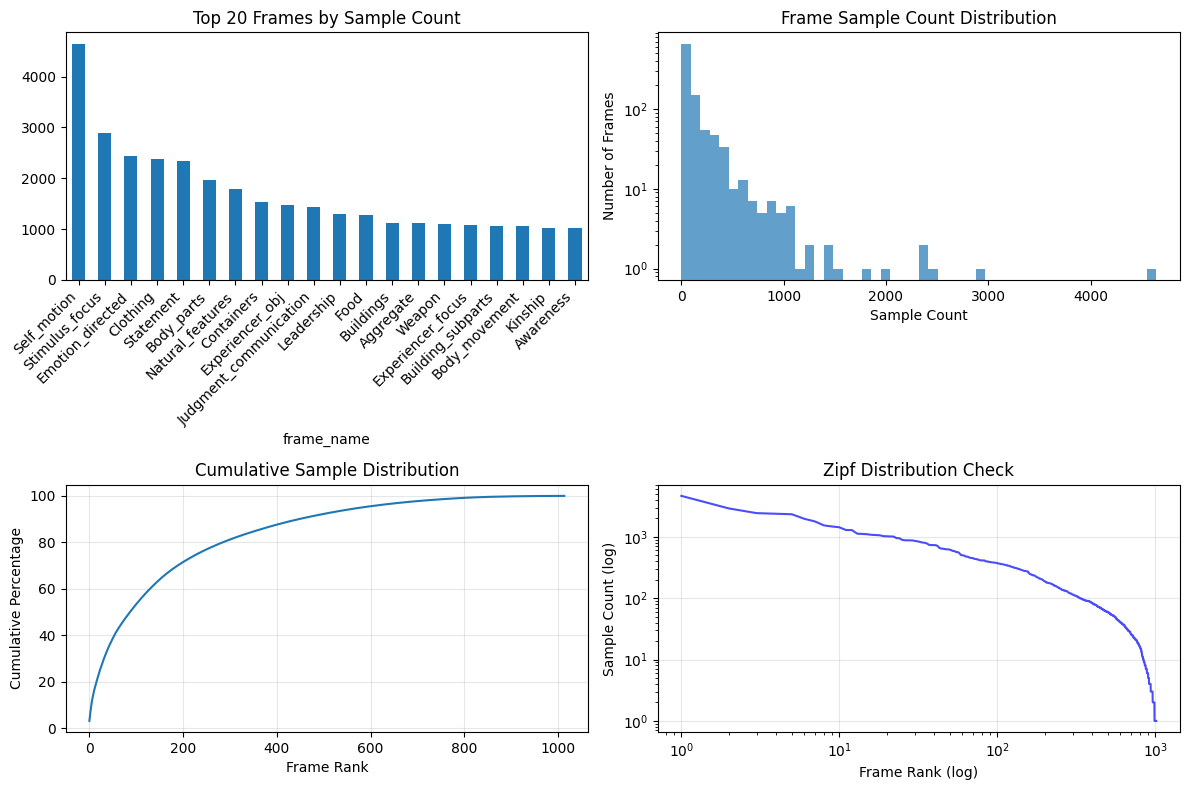


📝 3. 句子质量分析
--------------------------------------------------
句子长度统计:
  平均长度: 24.1 words
  中位数长度: 23.0 words
  最短句子: 1 words
  最长句子: 250 words
  标准差: 11.3

句子长度分布:
  1-5 words: 963 (0.6%)
  6-10 words: 10,917 (7.3%)
  11-20 words: 48,586 (32.4%)
  21-30 words: 52,746 (35.1%)
  31-50 words: 33,700 (22.4%)
  51+ words: 3,219 (2.1%)

异常句子检测:
  过短句子(<=3 words): 73 (0.05%)
    示例: Real people !
  过长句子(>=50 words): 3455 (2.30%)
    示例: Noting that the Indonesian military is `` very suspicious '' about Australia 's motivation in East T...
  包含特殊字符: 9798 (6.53%)
  重复句子: 28209 (18.79%)

🎯 4. Target span分析
--------------------------------------------------
Target span统计:
  总target数: 154,174
  平均字符长度: 5.8
  平均词数: 1.0
  最长target: 18 chars
  最短target: 0 chars

Target词数分布:
  0 word(s): 85 (0.1%)
  1 word(s): 154,070 (99.9%)
  2 word(s): 19 (0.0%)

最常见target词:
  'i': 828 次
  'o': 480 次
  'a': 412 次
  'se': 361 次
  'u': 332 次
  'weapon': 319 次
  't': 285 次
  'ou': 276 次
  'of': 269 次
  'wor': 266 次


In [ ]:
# @title ✅FrameNet数据集全面分析

def comprehensive_data_analysis(train_df, val_df, test_df):
    """FrameNet数据集全面分析"""

    print("🔍 FrameNet 数据集全面分析")
    print("="*80)

    # 1. 基础统计
    basic_statistics(train_df, val_df, test_df)

    # 2. Frame分布分析
    frame_distribution_analysis(train_df)

    # 3. 句子质量分析
    sentence_quality_analysis(train_df)

    # 4. Target span分析
    target_span_analysis(train_df)

    # 5. Frame语义相似性分析
    frame_similarity_analysis(train_df)

    # 6. 数据质量问题检测
    data_quality_issues(train_df)

    # 7. 训练难度分析
    training_difficulty_analysis(train_df)

    print("\n✅ 数据分析完成！")

def basic_statistics(train_df, val_df, test_df):
    """1. 基础统计信息"""
    print("\n📊 1. 基础统计信息")
    print("-" * 50)

    datasets = {'Train': train_df, 'Val': val_df, 'Test': test_df}

    for name, df in datasets.items():
        print(f"\n{name} Set:")
        print(f"  总样本数: {len(df):,}")
        print(f"  unique句子数: {df['sentence'].nunique():,}")
        print(f"  unique frames数: {df['frame_name'].nunique():,}")
        print(f"  平均每句targets: {len(df) / df['sentence'].nunique():.2f}")

def frame_distribution_analysis(train_df):
    """2. Frame分布分析"""
    print("\n📈 2. Frame分布分析")
    print("-" * 50)

    frame_counts = train_df['frame_name'].value_counts()

    # 基础分布统计
    print(f"Frame数量分布:")
    print(f"  总frame数: {len(frame_counts)}")
    print(f"  最大样本数: {frame_counts.iloc[0]:,} (frame: {frame_counts.index[0]})")
    print(f"  最小样本数: {frame_counts.iloc[-1]:,} (frame: {frame_counts.index[-1]})")
    print(f"  中位数样本数: {frame_counts.median():.1f}")
    print(f"  平均样本数: {frame_counts.mean():.1f}")

    # 样本数区间分布
    print(f"\n样本数区间分布:")
    ranges = [(1, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, float('inf'))]
    for low, high in ranges:
        if high == float('inf'):
            count = (frame_counts >= low).sum()
            print(f"  {low}+ 样本: {count} frames ({count/len(frame_counts)*100:.1f}%)")
        else:
            count = ((frame_counts >= low) & (frame_counts <= high)).sum()
            print(f"  {low}-{high} 样本: {count} frames ({count/len(frame_counts)*100:.1f}%)")

    # 长尾分布可视化
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    frame_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Frames by Sample Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.subplot(2, 2, 2)
    plt.hist(frame_counts.values, bins=50, alpha=0.7)
    plt.title('Frame Sample Count Distribution')
    plt.xlabel('Sample Count')
    plt.ylabel('Number of Frames')
    plt.yscale('log')

    plt.subplot(2, 2, 3)
    # 累积分布
    sorted_counts = frame_counts.sort_values(ascending=False)
    cumsum = sorted_counts.cumsum()
    plt.plot(range(len(cumsum)), cumsum / cumsum.iloc[-1] * 100)
    plt.title('Cumulative Sample Distribution')
    plt.xlabel('Frame Rank')
    plt.ylabel('Cumulative Percentage')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    # Zipf分布检验
    ranks = np.arange(1, len(frame_counts) + 1)
    plt.loglog(ranks, frame_counts.values, 'b-', alpha=0.7)
    plt.title('Zipf Distribution Check')
    plt.xlabel('Frame Rank (log)')
    plt.ylabel('Sample Count (log)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return frame_counts

def sentence_quality_analysis(train_df):
    """3. 句子质量分析"""
    print("\n📝 3. 句子质量分析")
    print("-" * 50)

    # 句子长度分析
    sentence_lengths = train_df['sentence'].apply(lambda x: len(x.split()))

    print(f"句子长度统计:")
    print(f"  平均长度: {sentence_lengths.mean():.1f} words")
    print(f"  中位数长度: {sentence_lengths.median():.1f} words")
    print(f"  最短句子: {sentence_lengths.min()} words")
    print(f"  最长句子: {sentence_lengths.max()} words")
    print(f"  标准差: {sentence_lengths.std():.1f}")

    # 长度分布
    print(f"\n句子长度分布:")
    length_ranges = [(1, 5), (6, 10), (11, 20), (21, 30), (31, 50), (51, float('inf'))]
    for low, high in length_ranges:
        if high == float('inf'):
            count = (sentence_lengths >= low).sum()
            print(f"  {low}+ words: {count:,} ({count/len(sentence_lengths)*100:.1f}%)")
        else:
            count = ((sentence_lengths >= low) & (sentence_lengths <= high)).sum()
            print(f"  {low}-{high} words: {count:,} ({count/len(sentence_lengths)*100:.1f}%)")

    # 异常句子检测
    print(f"\n异常句子检测:")
    # 过短句子
    very_short = train_df[sentence_lengths <= 3]
    print(f"  过短句子(<=3 words): {len(very_short)} ({len(very_short)/len(train_df)*100:.2f}%)")
    if len(very_short) > 0:
        print(f"    示例: {very_short['sentence'].iloc[0]}")

    # 过长句子
    very_long = train_df[sentence_lengths >= 50]
    print(f"  过长句子(>=50 words): {len(very_long)} ({len(very_long)/len(train_df)*100:.2f}%)")
    if len(very_long) > 0:
        print(f"    示例: {very_long['sentence'].iloc[0][:100]}...")

    # 特殊字符检测
    special_chars = train_df['sentence'].str.contains(r'[<>{}[\]()_*#@$%^&]', regex=True)
    print(f"  包含特殊字符: {special_chars.sum()} ({special_chars.sum()/len(train_df)*100:.2f}%)")

    # 重复句子
    duplicate_sentences = train_df['sentence'].duplicated().sum()
    print(f"  重复句子: {duplicate_sentences} ({duplicate_sentences/len(train_df)*100:.2f}%)")

    return sentence_lengths

def target_span_analysis(train_df):
    """4. Target span分析"""
    print("\n🎯 4. Target span分析")
    print("-" * 50)

    # 提取target span信息
    target_info = []
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            target_text = sentence[start:end]
            target_info.append({
                'text': target_text,
                'length': end - start,
                'char_length': len(target_text),
                'word_count': len(target_text.split()),
                'frame': row['frame_name']
            })

    target_df = pd.DataFrame(target_info)

    print(f"Target span统计:")
    print(f"  总target数: {len(target_df):,}")
    print(f"  平均字符长度: {target_df['char_length'].mean():.1f}")
    print(f"  平均词数: {target_df['word_count'].mean():.1f}")
    print(f"  最长target: {target_df['char_length'].max()} chars")
    print(f"  最短target: {target_df['char_length'].min()} chars")

    # Target长度分布
    print(f"\nTarget词数分布:")
    word_counts = target_df['word_count'].value_counts().sort_index()
    for words, count in word_counts.head(10).items():
        print(f"  {words} word(s): {count:,} ({count/len(target_df)*100:.1f}%)")

    # 常见target词
    print(f"\n最常见target词:")
    target_words = target_df['text'].value_counts()
    for word, count in target_words.head(10).items():
        print(f"  '{word}': {count} 次")

    # 异常target检测
    print(f"\n异常target检测:")
    empty_targets = target_df[target_df['char_length'] == 0]
    print(f"  空target: {len(empty_targets)}")

    very_long_targets = target_df[target_df['word_count'] >= 5]
    print(f"  过长target(>=5 words): {len(very_long_targets)} ({len(very_long_targets)/len(target_df)*100:.2f}%)")

    return target_df

def frame_similarity_analysis(train_df):
    """5. Frame语义相似性分析"""
    print("\n🔗 5. Frame语义相似性分析")
    print("-" * 50)

    # 为每个frame收集target词汇
    frame_targets = defaultdict(list)
    for _, row in train_df.iterrows():
        frame = row['frame_name']
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            target = sentence[start:end].lower().strip()
            if target:  # 非空target
                frame_targets[frame].append(target)

    # 计算frame间的词汇重叠
    print(f"Frame语义相似性分析:")
    frame_names = list(frame_targets.keys())

    # 找出共享词汇最多的frame pairs
    overlap_scores = []
    for i, frame1 in enumerate(frame_names):
        for j, frame2 in enumerate(frame_names[i+1:], i+1):
            targets1 = set(frame_targets[frame1])
            targets2 = set(frame_targets[frame2])

            intersection = len(targets1 & targets2)
            union = len(targets1 | targets2)

            if union > 0:
                jaccard = intersection / union
                overlap_scores.append((frame1, frame2, intersection, jaccard))

    # 排序并显示最相似的frame pairs
    overlap_scores.sort(key=lambda x: x[3], reverse=True)

    print(f"\n最相似的Frame pairs (按Jaccard相似度):")
    for frame1, frame2, common, jaccard in overlap_scores[:10]:
        print(f"  {frame1} <-> {frame2}: {common} 共同词汇, Jaccard={jaccard:.3f}")

    # 分析可能的混淆frame
    print(f"\n潜在混淆Frame pairs (Jaccard > 0.3):")
    confusing_pairs = [(f1, f2, score) for f1, f2, _, score in overlap_scores if score > 0.3]
    print(f"  发现 {len(confusing_pairs)} 对潜在混淆frames")

    return overlap_scores, frame_targets

def data_quality_issues(train_df):
    """6. 数据质量问题检测"""
    print("\n⚠️ 6. 数据质量问题检测")
    print("-" * 50)

    issues = []

    # 1. Target span边界问题
    boundary_issues = 0
    for idx, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            if start < 0 or end > len(sentence) or start >= end:
                boundary_issues += 1
                issues.append(f"Row {idx}: Invalid span ({start}, {end}) for sentence length {len(sentence)}")

    print(f"Target span边界问题: {boundary_issues}")

    # 2. 不一致的标注
    sentence_frame_map = defaultdict(set)
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        frame = row['frame_name']
        sentence_frame_map[sentence].add(frame)

    inconsistent_sentences = {s: frames for s, frames in sentence_frame_map.items() if len(frames) > 1}
    print(f"标注不一致的句子: {len(inconsistent_sentences)}")

    # 3. 空白/异常字符
    empty_sentences = train_df[train_df['sentence'].str.strip() == '']
    print(f"空句子: {len(empty_sentences)}")

    # 4. Frame name问题
    frame_name_issues = train_df[train_df['frame_name'].str.contains(r'[^a-zA-Z0-9_]', regex=True, na=False)]
    print(f"Frame名称包含特殊字符: {len(frame_name_issues)}")

    return issues

def training_difficulty_analysis(train_df):
    """7. 训练难度分析"""
    print("\n📈 7. 训练难度分析")
    print("-" * 50)

    frame_counts = train_df['frame_name'].value_counts()

    # 按样本数量分类frame难度
    difficulty_levels = {
        'Very Hard': frame_counts[frame_counts <= 5],
        'Hard': frame_counts[(frame_counts > 5) & (frame_counts <= 15)],
        'Medium': frame_counts[(frame_counts > 15) & (frame_counts <= 50)],
        'Easy': frame_counts[frame_counts > 50]
    }

    print(f"Frame训练难度分布:")
    total_frames = len(frame_counts)
    for difficulty, frames in difficulty_levels.items():
        count = len(frames)
        percentage = count / total_frames * 100
        sample_count = frames.sum() if len(frames) > 0 else 0
        print(f"  {difficulty}: {count} frames ({percentage:.1f}%), {sample_count:,} samples")

    # 推荐的训练策略
    print(f"\n🎯 推荐训练策略:")
    very_hard_count = len(difficulty_levels['Very Hard'])
    if very_hard_count > 0:
        print(f"  1. {very_hard_count} 个Very Hard frames需要数据增强")

    hard_count = len(difficulty_levels['Hard'])
    if hard_count > 0:
        print(f"  2. {hard_count} 个Hard frames需要特殊关注和困难负例")

    easy_count = len(difficulty_levels['Easy'])
    if easy_count > 0:
        print(f"  3. {easy_count} 个Easy frames可以子采样以平衡数据")

    return difficulty_levels

# 使用示例
if __name__ == "__main__":

    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")


    comprehensive_data_analysis(train_df, val_df, test_df)
    pass

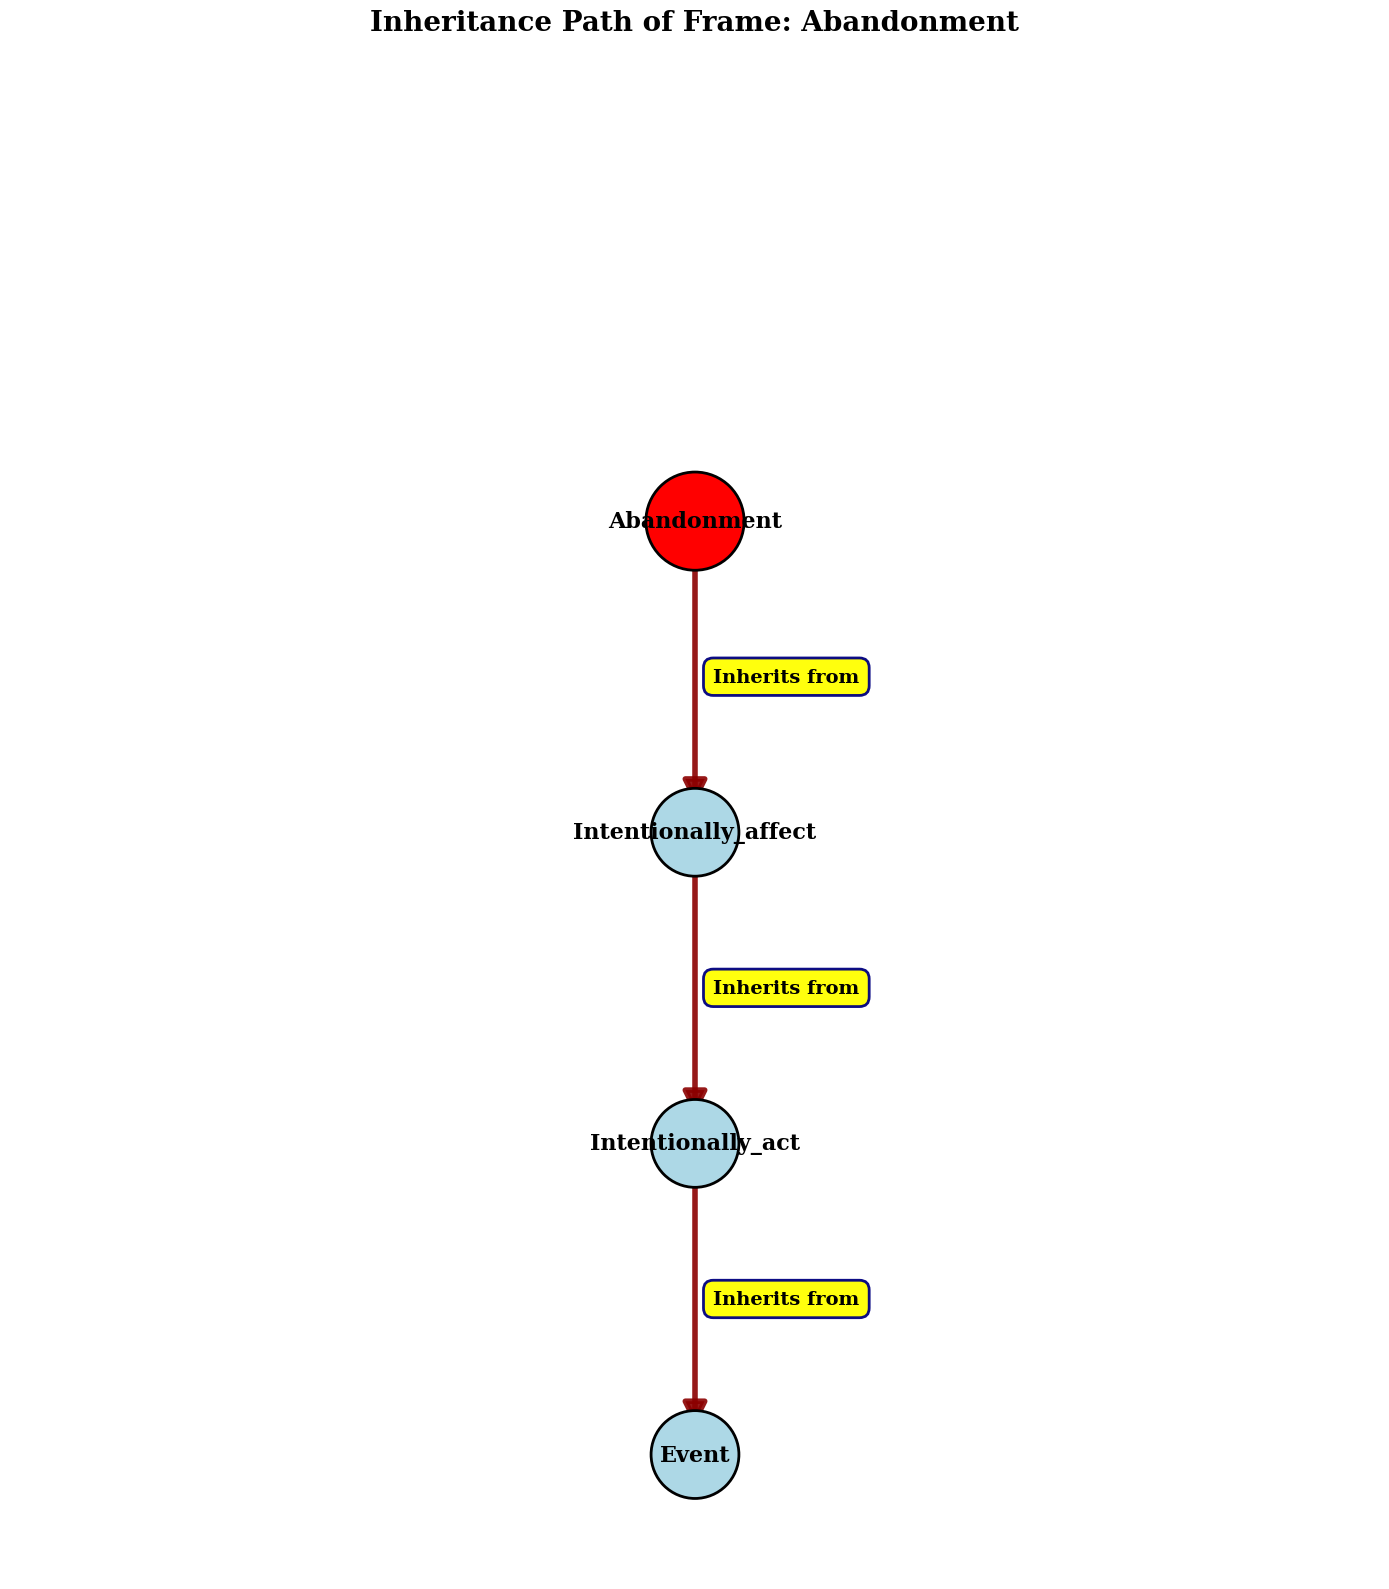

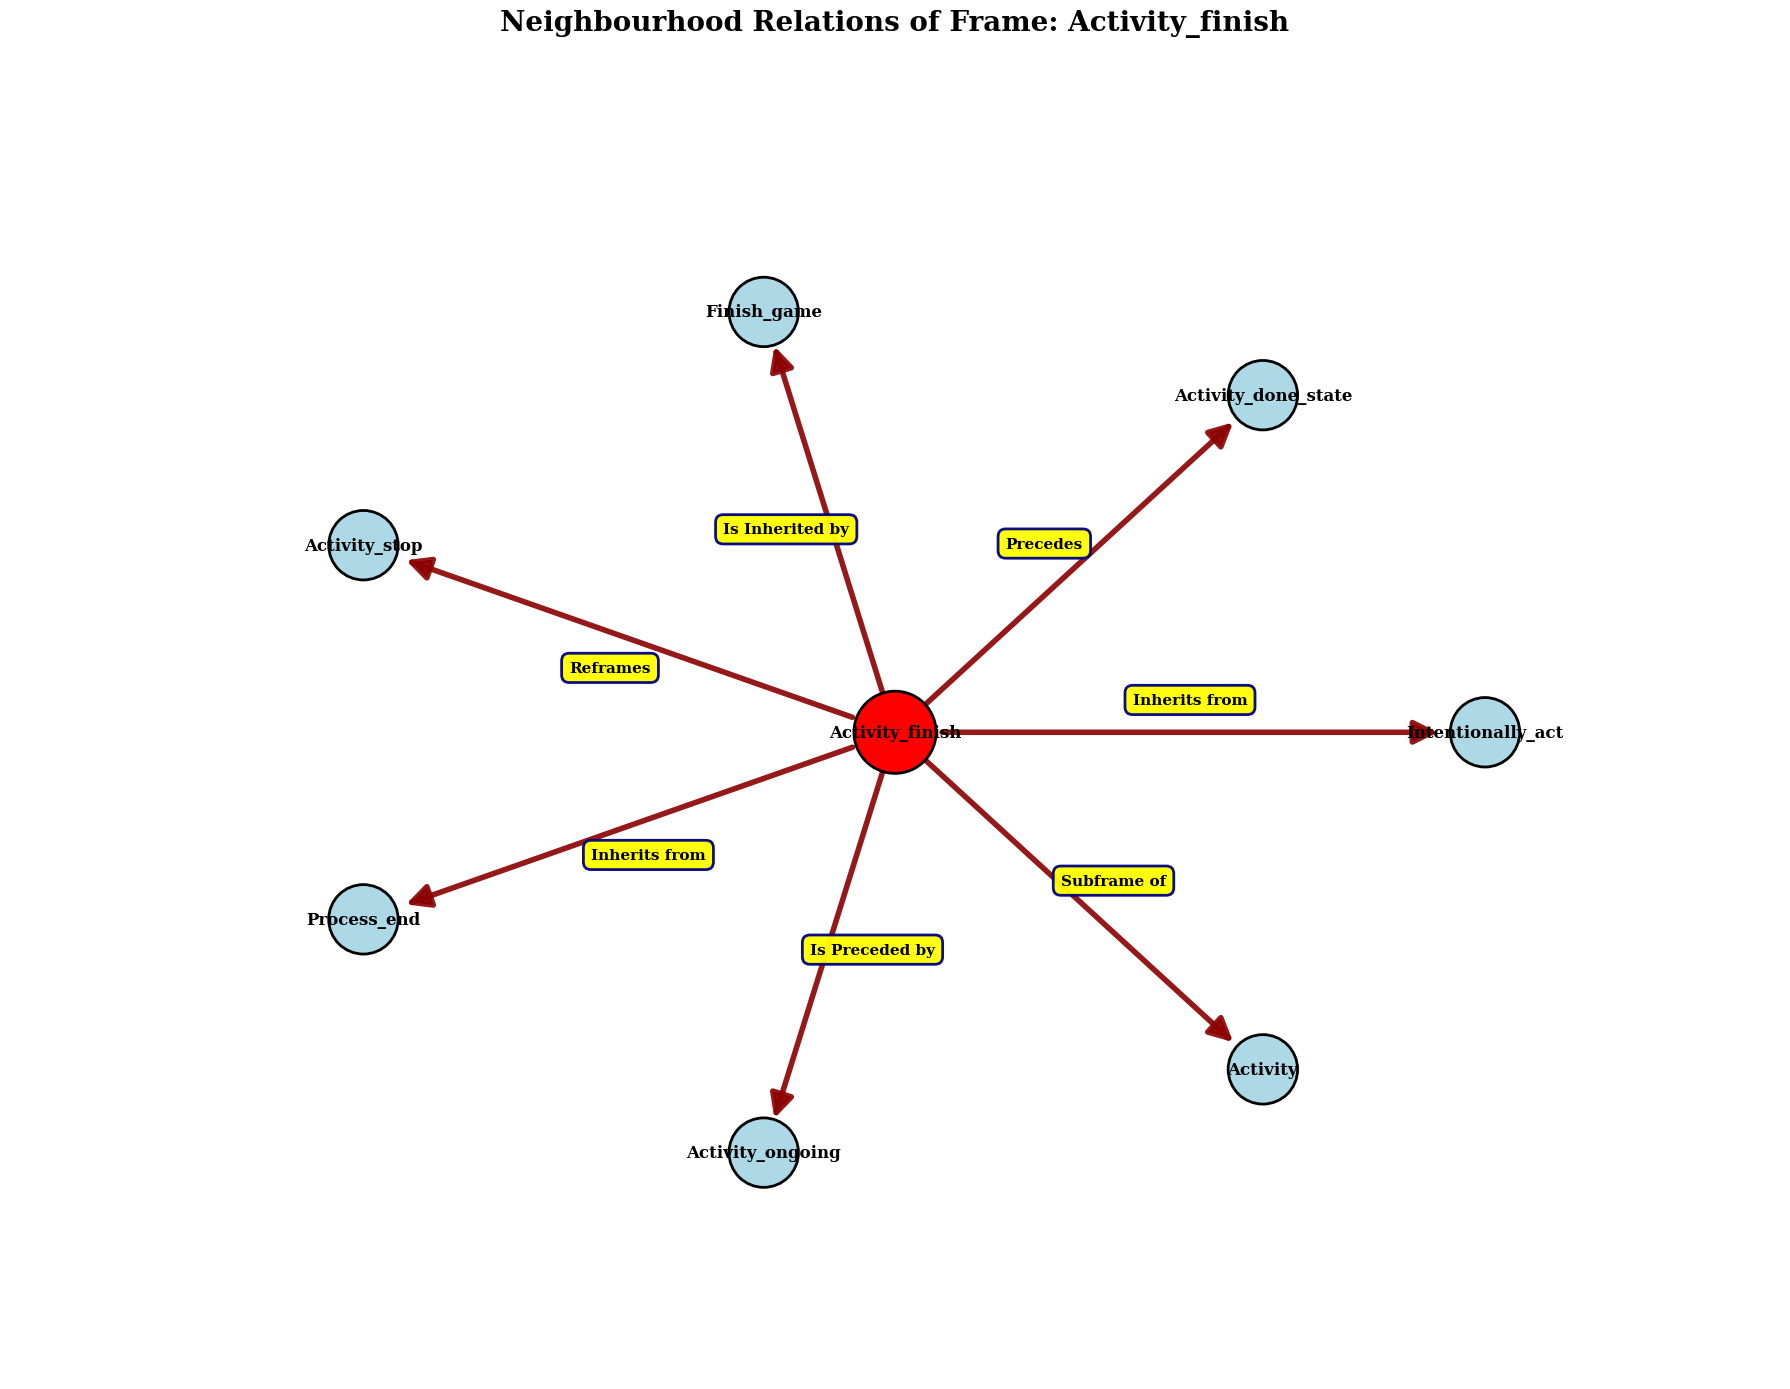

In [ ]:
# @title 🔍 Visualise FrameNet Data Structures

# Set font for better appearance (Colab compatible)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10

def visualize_frame_structure(frame_relations, target_frame, mode="neighbourhood", layout='spring', title=None, save_path=None):
    """
    Visualize frame semantic structure using extracted FrameNet data.
    """

    if target_frame not in frame_relations:
        print(f"[ERROR] Frame not found: {target_frame}")
        return

    if mode == "upward":
        if not title:
            title = f"Inheritance Path of Frame: {target_frame}"

        # Find inheritance path by following inheritance relations
        path = [target_frame]
        current = target_frame
        visited = {current}

        while True:
            parent_found = False
            relations = frame_relations.get(current, [])

            for neighbor, rel_type, direction, edge_label in relations:
                if neighbor in visited:
                    continue
                # Look for inheritance where current frame inherits from neighbor
                if rel_type == "Inheritance" and direction == "in":
                    path.insert(0, neighbor)  # Add parent at beginning
                    current = neighbor
                    visited.add(current)
                    parent_found = True
                    break

            if not parent_found:
                break

        # Create inheritance subgraph
        subgraph = nx.DiGraph()
        if len(path) == 1:
            subgraph.add_node(target_frame)
            print(f"[INFO] No inheritance path found for {target_frame}")
        else:
            for i in range(len(path) - 1):
                parent = path[i]
                child = path[i + 1]
                # Arrow from child to parent: child -> parent "Inherits from"
                subgraph.add_edge(child, parent, relation="Inherits from")

    elif mode == "neighbourhood":
        if not title:
            title = f"Neighbourhood Relations of Frame: {target_frame}"

        # Get all relations for the target frame
        relations = frame_relations.get(target_frame, [])

        # Collect all neighbor frames
        neighbors = set()
        for neighbor, rel_type, direction, edge_label in relations:
            neighbors.add(neighbor)

        # Create subgraph with all arrows FROM target frame
        subgraph = nx.DiGraph()
        subgraph.add_node(target_frame)
        subgraph.add_nodes_from(neighbors)

        # Add edges with labels from RELATION_LABELS
        for neighbor, rel_type, direction, edge_label in relations:
            # Get the appropriate label based on direction
            if rel_type in RELATION_LABELS:
                label_out, label_in = RELATION_LABELS[rel_type]
                if direction == "out":
                    label = label_out  # target gives the relation
                else:  # direction == "in"
                    label = label_in   # target receives the relation
            else:
                label = f"{rel_type} ({direction})"

            # All arrows point FROM target_frame TO neighbors
            subgraph.add_edge(target_frame, neighbor, relation=label)

    else:
        raise ValueError("mode must be 'neighbourhood' or 'upward'")

    if len(subgraph.nodes()) == 0:
        print(f"[ERROR] No nodes found for visualization")
        return

    # Layout calculation
    num_nodes = len(subgraph.nodes())

    if num_nodes == 1:
        pos = {list(subgraph.nodes())[0]: (0, 0)}
    elif mode == "upward":
        # Vertical hierarchical layout for inheritance
        nodes = list(subgraph.nodes())
        if subgraph.edges():
            try:
                ordered_nodes = list(nx.topological_sort(subgraph))
                pos = {}
                level_height = 5.0  # Large spacing
                for i, node in enumerate(ordered_nodes):
                    pos[node] = (0, (len(ordered_nodes) - i - 1) * level_height)
            except:
                pos = {node: (0, i * 5.0) for i, node in enumerate(reversed(nodes))}
        else:
            pos = {nodes[0]: (0, 0)}
    else:
        # Radial layout for neighbourhood - target in center
        pos = {}
        other_nodes = [n for n in subgraph.nodes() if n != target_frame]
        pos[target_frame] = (0, 0)

        if other_nodes:
            angle_step = 2 * np.pi / len(other_nodes)
            radius = 4.0
            for i, node in enumerate(other_nodes):
                angle = i * angle_step
                pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Create figure with large size
    if mode == "upward":
        fig_height = max(16, len(subgraph.nodes()) * 4)
        fig, ax = plt.subplots(1, 1, figsize=(14, fig_height))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Draw nodes
    node_colors = ["red" if n == target_frame else "lightblue" for n in subgraph.nodes()]
    if mode == "upward":
        node_sizes = [5000 if n == target_frame else 4000 for n in subgraph.nodes()]
    else:
        node_sizes = [3500 if n == target_frame else 2500 for n in subgraph.nodes()]

    nx.draw_networkx_nodes(subgraph, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)

    # Draw node labels
    label_font_size = 16 if mode == "upward" else 12
    nx.draw_networkx_labels(subgraph, pos,
                           font_size=label_font_size,
                           font_weight="bold",
                           font_family='DejaVu Serif',
                           ax=ax)

    # Draw edges with relation labels
    for u, v, data in subgraph.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)

        if length > 0:
            dx_norm = dx / length
            dy_norm = dy / length

            # Adjust arrow positions to avoid node overlap
            node_radius = 0.4 if mode == "upward" else 0.3
            start_x = x1 + dx_norm * node_radius
            start_y = y1 + dy_norm * node_radius
            end_x = x2 - dx_norm * node_radius
            end_y = y2 - dy_norm * node_radius

            # Draw thick, prominent arrow
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                   arrowstyle='-|>',
                                   mutation_scale=35,
                                   color='darkred',
                                   linewidth=4,
                                   alpha=0.9)
            ax.add_patch(arrow)

            # Add relation label
            relation = data.get("relation", "")
            if relation:
                # Position label at edge midpoint
                label_x = (start_x + end_x) / 2
                label_y = (start_y + end_y) / 2

                # Offset label perpendicular to edge for readability
                perp_offset = 0.4 if mode == "upward" else 0.3
                perp_x = -dy_norm * perp_offset
                perp_y = dx_norm * perp_offset

                label_font_size = 14 if mode == "upward" else 11
                ax.text(label_x + perp_x, label_y + perp_y, relation,
                       fontsize=label_font_size,
                       ha='center',
                       va='center',
                       weight='bold',
                       family='DejaVu Serif',
                       bbox=dict(boxstyle="round,pad=0.5",
                               facecolor="yellow",
                               alpha=0.95,
                               edgecolor="navy",
                               linewidth=2))

    ax.set_title(title, fontsize=20, fontweight='bold', family='DejaVu Serif', pad=40)
    ax.axis("off")

    # Set axis limits to ensure everything is visible
    if mode == "upward":
        ax.set_xlim(-3, 3)
        ax.set_ylim(-2, len(subgraph.nodes()) * 5 + 2)
    else:
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)

    plt.tight_layout()
    if save_path:
         plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


visualize_frame_structure(frame_relations, "Abandonment", mode="upward", save_path="abandonment_inheritance.png")
visualize_frame_structure(frame_relations, "Activity_finish", mode="neighbourhood", save_path="activity_finish_neighbourhood.png")

In [ ]:
# @title 定义文件提取

# === 1. 修复版：提取纯定义文本，忽略 <ex> 例句 ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

# === 2. 使用 [CLS] 向量编码定义文本（DistilBERT版） ===
def encode_frame_definition(definition, tokenizer, model, device):
    inputs = tokenizer(
        definition,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding='max_length'
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state  # [B, T, H]
        cls_embedding = last_hidden[:, 0, :]     # 取 [CLS]
        return cls_embedding.squeeze(0).cpu()

# === 3. 主函数：编码所有定义 + 保存 ===
def encode_all_framenet_definitions(tokenizer, model, save_path, device):
    import pickle
    frame_definition_embeddings = {}
    skipped = []

    for frame in tqdm(fn.frames(), desc="Encoding FrameNet definitions"):
        name = frame["name"]
        raw_markup = ''.join(frame.get("definitionMarkup", []))
        definition = extract_pure_definition_from_markup(raw_markup)

        if definition == "[ParseError]" or not definition:
            skipped.append(name)
            continue

        try:
            emb = encode_frame_definition(definition, tokenizer, model, device)
            frame_definition_embeddings[name] = {
                "definition": definition,
                "embedding": emb.tolist()
            }
        except Exception as e:
            skipped.append(name)

    with open(save_path, "wb") as f:
        pickle.dump(frame_definition_embeddings, f)

    print(f"\n📦 成功保存 {len(frame_definition_embeddings)} 条定义嵌入，跳过 {len(skipped)} 条错误定义。")
    return frame_definition_embeddings, skipped

# === 4. 使用 distilbert-base-uncased 编码器 ===


definition_model_name = "distilbert-base-uncased"
definition_tokenizer = AutoTokenizer.from_pretrained(definition_model_name)
definition_model = AutoModel.from_pretrained(definition_model_name).to(device)

# === 5. 执行并保存 ===
save_path = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
frame_definition_embeddings, skipped = encode_all_framenet_definitions(
    definition_tokenizer, definition_model, save_path, device
)

# === 6. 打印前几个结果检查 ===
for i, (name, info) in enumerate(frame_definition_embeddings.items()):
    print(f"\n✅ Frame {i+1}: {name}")
    print("📝 Definition:", info["definition"])
    print("🔢 Embedding[:5]:", info["embedding"][:5])
    if i >= 4:
        break


Encoding FrameNet definitions: 100%|██████████| 1221/1221 [00:06<00:00, 192.41it/s]



📦 成功保存 1221 条定义嵌入，跳过 0 条错误定义。

✅ Frame 1: Abandonment
📝 Definition: An Agent leaves behind a Theme effectively rendering it no longer within their control or of the normal security as one's property.
🔢 Embedding[:5]: [-0.19139738380908966, -0.02490539290010929, -0.1134403645992279, -0.05611336603760719, 0.018953654915094376]

✅ Frame 2: Abounding_with
📝 Definition: A Location is filled or covered with the Theme .  The Location is realized as the External Argument, and the Theme either as PP complement headed by with , in or of .

NB:  This frame does not include uses of adjectives like paved when they merely specify the Type of some location, as in "paved and unpaved roads".
🔢 Embedding[:5]: [-0.3714313209056854, 0.04469132795929909, -0.04548976570367813, -0.21898649632930756, -0.3817424774169922]

✅ Frame 3: Absorb_heat
📝 Definition: An Entity (generally food) is exposed to a Heat_source whose Temperature may also be specified.  Generally, the Entity undergoes some sort of change as 

In [ ]:
# @title 定义文件保存
import pickle
save_path = "/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl"

with open(save_path, "wb") as f:
    pickle.dump(frame_definition_embeddings, f)

print(f"✅ 已保存定义嵌入到: {save_path}")


✅ 已保存定义嵌入到: /content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl


📊 Cosine similarity stats (excluding self-match):
   Mean: 0.8911
   Std: 0.0338
   Min: 0.6452
   Max: 0.9988


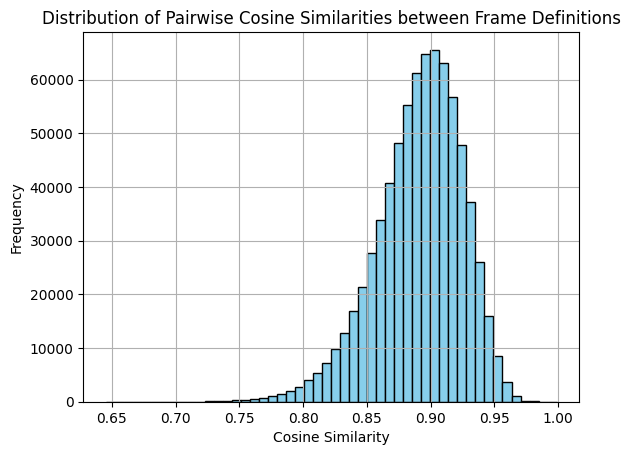

In [ ]:
# @title 定义相似度

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === 1. 加载定义嵌入 ===
with open("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl", "rb") as f:
    frame_def_embeddings = pickle.load(f)

# === 2. 提取所有向量与名称 ===
frame_names = list(frame_def_embeddings.keys())
embeddings = np.array([frame_def_embeddings[f]["embedding"] for f in frame_names])  # shape: [N, D]

# === 3. 计算余弦相似度矩阵 ===
sim_matrix = cosine_similarity(embeddings)  # shape: [N, N]

# === 4. 提取非对角元素（即非自身匹配） ===
all_sims = sim_matrix[np.triu_indices(len(frame_names), k=1)]

# === 5. 打印统计信息 ===
mean_sim = np.mean(all_sims)
std_sim = np.std(all_sims)
min_sim = np.min(all_sims)
max_sim = np.max(all_sims)

print(f"📊 Cosine similarity stats (excluding self-match):")
print(f"   Mean: {mean_sim:.4f}")
print(f"   Std: {std_sim:.4f}")
print(f"   Min: {min_sim:.4f}")
print(f"   Max: {max_sim:.4f}")

# === 6. 可视化分布 ===
plt.hist(all_sims, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Cosine Similarities between Frame Definitions")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# @title 处理定义之后的三个集

from torch.utils.data import DataLoader
import pickle
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

def load_definition_embeddings():
    embeddings_path = "/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl"

    try:
        with open(embeddings_path, "rb") as f:
            frame_definition_embeddings = pickle.load(f)
        return frame_definition_embeddings
    except Exception as e:
        print(f"Failed to load definition embeddings: {e}")
        return None

def add_pure_definitions_to_training_data(df, definition_embeddings):
    if df is None or definition_embeddings is None:
        return None

    frame_to_definition = {}
    for frame_name, info in definition_embeddings.items():
        frame_to_definition[frame_name] = info["definition"]

    def get_pure_definition(frame_name):
        return frame_to_definition.get(frame_name, "")

    df["pure_definition"] = df["frame_name"].apply(get_pure_definition)
    return df

def load_and_prepare_training_data():
    definition_embeddings = load_definition_embeddings()
    if definition_embeddings is None:
        return None, None

    possible_train_paths = [
        "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "/content/drive/MyDrive/more50/framenet_data/test_df.pkl",
    ]

    df = None

    for train_path in possible_train_paths:
        try:
            with open(train_path, "rb") as f:
                data = pickle.load(f)

            if isinstance(data, dict):
                if "dataframe" in data:
                    df = data["dataframe"]
                else:
                    first_key = list(data.keys())[0]
                    first_value = data[first_key]
                    if isinstance(first_value, dict) and 'definition' in first_value:
                        continue
                    else:
                        continue
            elif isinstance(data, pd.DataFrame):
                df = data
            else:
                continue

            if 'sentence' not in df.columns or 'frame_name' not in df.columns:
                continue

            break

        except FileNotFoundError:
            continue
        except Exception as e:
            continue

    if df is None:
        return None, None

    df = add_pure_definitions_to_training_data(df, definition_embeddings)
    return df, definition_embeddings

class EfficientFrameDataset:
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.column_mappings = self._detect_columns()

    def _detect_columns(self):
        mappings = {}

        for col in ['sentence', 'text', 'input_text', 'context']:
            if col in self.df.columns:
                mappings['sentence'] = col
                break

        for col in ['frame_name', 'frame', 'label', 'target_frame']:
            if col in self.df.columns:
                mappings['frame_name'] = col
                break

        for col in ['target_spans', 'spans', 'target_span', 'target']:
            if col in self.df.columns:
                mappings['spans'] = col
                break

        return mappings

    def _extract_span_info(self, row):
        if 'spans' in self.column_mappings:
            spans_data = row[self.column_mappings['spans']]

            try:
                if spans_data is not None:
                    if isinstance(spans_data, (list, tuple)) and len(spans_data) > 0:
                        first_span = spans_data[0]
                        if isinstance(first_span, (list, tuple)) and len(first_span) >= 2:
                            return int(first_span[0]), int(first_span[1])
                        elif isinstance(first_span, (int, float)):
                            if len(spans_data) >= 2:
                                return int(spans_data[0]), int(spans_data[1])

                    elif hasattr(spans_data, 'shape') and len(spans_data) > 0:
                        if spans_data.shape == (2,):
                            return int(spans_data[0]), int(spans_data[1])
                        elif len(spans_data) > 0 and hasattr(spans_data[0], '__len__'):
                            first_span = spans_data[0]
                            if len(first_span) >= 2:
                                return int(first_span[0]), int(first_span[1])

                    elif isinstance(spans_data, str):
                        if ',' in spans_data:
                            parts = spans_data.split(',')
                            return int(parts[0].strip()), int(parts[1].strip())

            except (ValueError, TypeError, IndexError):
                pass

        return 0, 1

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sentence = str(row[self.column_mappings['sentence']]) if 'sentence' in self.column_mappings else ""
        frame_name = str(row[self.column_mappings['frame_name']]) if 'frame_name' in self.column_mappings else "UNKNOWN"
        span_start, span_end = self._extract_span_info(row)

        inputs = self.tokenizer(
            sentence,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_length,
            padding='max_length'
        )

        seq_len = inputs['input_ids'].size(1)
        span_start = min(span_start, seq_len - 1)
        span_end = min(span_end, seq_len - 1)
        span_end = max(span_start, span_end)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'span_start': torch.tensor(span_start, dtype=torch.long),
            'span_end': torch.tensor(span_end, dtype=torch.long),
            'frame_name': frame_name,
            'sentence': sentence
        }

def prepare_data_loaders():
    df, definition_embeddings = load_and_prepare_training_data()
    if df is None or definition_embeddings is None:
        return None, None, None

    try:
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['frame_name'])
    except:
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    train_dataset = EfficientFrameDataset(train_df, tokenizer, max_length=128)
    val_dataset = EfficientFrameDataset(val_df, tokenizer, max_length=128)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader, definition_embeddings

# 1. 加载定义embeddings
print("开始加载定义embeddings...")
definition_embeddings = load_definition_embeddings()

if definition_embeddings is None:
    print("定义embeddings加载失败")
else:
    print(f"定义embeddings加载成功: {len(definition_embeddings)} 个frames")

    # 2. 处理三个原始文件
    file_paths = [
        "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    ]

    file_names = ["训练集", "验证集", "测试集"]
    processed_dfs = []

    for i, (file_path, file_name) in enumerate(zip(file_paths, file_names)):
        print(f"\n处理{file_name}: {file_path}")

        try:
            with open(file_path, "rb") as f:
                data = pickle.load(f)

            # 提取DataFrame
            if isinstance(data, dict) and "dataframe" in data:
                df = data["dataframe"]
            elif isinstance(data, pd.DataFrame):
                df = data
            else:
                print(f"  {file_name}格式不支持，跳过")
                processed_dfs.append(None)
                continue

            # 添加定义列
            df = add_pure_definitions_to_training_data(df, definition_embeddings)
            processed_dfs.append(df)
            print(f"  {file_name}处理成功: {len(df)} 样本")

        except Exception as e:
            print(f"  {file_name}处理失败: {e}")
            processed_dfs.append(None)

    train_df, val_df, test_df = processed_dfs


    # 3. 打印每个集合的第一条数据 - 完整展示
    for df, name in zip([train_df, val_df, test_df], ["训练集", "验证集", "测试集"]):
        if df is not None:
            print(f"\n=== {name}第一条数据 ===")
            first_row = df.iloc[0]
            for col in df.columns:
                # 对定义相关列完整显示，其他列限制长度
                if 'definition' in col.lower():
                    print(f"{col}: {first_row[col]}")
                else:
                    value = str(first_row[col])[:100] if len(str(first_row[col])) > 100 else first_row[col]
                    print(f"{col}: {value}")
        else:
            print(f"\n=== {name} 处理失败，跳过 ===")

    # 4. 保存处理后的三个数据集
    base_path = "/content/drive/MyDrive/more50/framenet_data/"
    save_paths = [
        base_path + "enhanced_train_df_with_definitions.pkl",
        base_path + "enhanced_val_df_with_definitions.pkl",
        base_path + "enhanced_test_df_with_definitions.pkl"
    ]

    print(f"\n=== 保存文件 ===")
    for df, save_path, name in zip([train_df, val_df, test_df], save_paths, file_names):
        if df is not None:
            with open(save_path, 'wb') as f:
                pickle.dump({"dataframe": df}, f)
            print(f"{name}: {save_path}")
        else:
            print(f"{name}: 处理失败，未保存")

开始加载定义embeddings...
定义embeddings加载成功: 1221 个frames

处理训练集: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
  训练集处理成功: 39171 样本

处理验证集: /content/drive/MyDrive/more50/framenet_data/val_df.pkl
  验证集处理成功: 25179 样本

处理测试集: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
  测试集处理成功: 25579 样本

=== 训练集第一条数据 ===
sentence: At the moment you 've made a very dull morning very interesting and I 'm grateful to you . " 
target_spans: [(34, 37)]
target_text: dul
frame_name: Stimulus_focus
frame_id: 364
lexical_unit: dull.a
lu_id: 6468
lu_definition: COD: lacking interest or excitement. 
frame_elements: {'Degree': 'ver', 'Stimulus': 'mornin'}
fe_spans: [{'fe_name': 'Degree', 'start': 29, 'end': 32}, {'fe_name': 'Stimulus', 'start': 39, 'end': 45}]
frame_definition: In this frame either a Stimulus brings about a particular emotion or experience in the Experiencer or  saliently fails to bring about a particular experience. Some words indicate that the Stimulus is chara

In [ ]:
# @title 📦 Construct and Analyse Frame Graph

def build_frame_graph(frame_relations):

    """
    Build the semantic frame graph using all FrameNet relation types.

    Args:
        frame_relations (dict): Mapping from a frame to a list of
                                (related_frame, relation_type, direction, edge_label) tuples.

    Returns:
        frame_graph (MultiDiGraph): A directed multi-relation graph of frame relationships.
        relation_levels (dict): Mapping from frame name to structural level (based on all relation types).
    """
    import networkx as nx
    from collections import deque

    frame_graph = nx.MultiDiGraph()

    # Add nodes and edges
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, edge_label in relations:
            if direction == "out":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
            elif direction == "in":
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)
            elif direction == "undirected":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)

    # Identify root nodes (no incoming edges of any kind)
    roots = [node for node in frame_graph.nodes() if frame_graph.in_degree(node) == 0]

    # Compute relation levels from all roots, using all relation types
    relation_levels = {}
    for root in roots:
        queue = deque([(root, 0)])
        visited = set([root])

        while queue:
            node, level = queue.popleft()
            if node in relation_levels:
                relation_levels[node] = min(relation_levels[node], level)
            else:
                relation_levels[node] = level

            for _, child, data in frame_graph.out_edges(node, data=True):
                if child not in visited:
                    visited.add(child)
                    queue.append((child, level + 1))

    # Assign -1 to nodes not reachable from any root
    for node in frame_graph.nodes():
        if node not in relation_levels:
            relation_levels[node] = -1

    return frame_graph, relation_levels


# Load previously saved data
print("Loading FrameNet data...")
try:
    with open("framenet_data.pkl", 'rb') as f:
        data = pickle.load(f)

    frame_relations = data['frame_relations']
    frame_definitions = data['frame_definitions']
    df = data['dataframe']

    print(f"Successfully loaded data: {len(frame_relations)} frame relations, {len(frame_definitions)} frame definitions")
except FileNotFoundError:
    print("Data file not found. Please run the data extraction script first.")
    import sys
    sys.exit(1)

# Build the frame graph and compute structure levels
print("\nBuilding full semantic relation graph...")
frame_graph, relation_levels = build_frame_graph(frame_relations)

# Basic graph statistics
print(f"The graph contains {frame_graph.number_of_nodes()} nodes and {frame_graph.number_of_edges()} edges")

# Analyse structural levels (depths from root using all relations)
print("\nAnalysing frame structure levels (based on all relation types)...")
level_counts = defaultdict(int)
for frame, level in relation_levels.items():
    level_counts[level] += 1

print("Number of frames per level:")
for level in sorted(level_counts.keys()):
    if level >= 0:
        print(f"  Level {level}: {level_counts[level]} frames")
print(f"  Unreachable (level = -1): {level_counts[-1]} frames")

# Identify root nodes (frames with no incoming edges)
roots = [n for n in frame_graph.nodes() if frame_graph.in_degree(n) == 0]
if roots:
    print(f"\nFound {len(roots)} root nodes (frames with no incoming edges):")
    for i, root in enumerate(sorted(roots)[:10]):
        print(f"  {i+1}. {root}")
    if len(roots) > 10:
        print(f"  ...and {len(roots)-10} more")

    # Compute the largest reachable subgraph from any root
    max_subtree_size = 0
    max_root = None
    for root in roots:
        queue = [root]
        visited = set([root])
        while queue:
            node = queue.pop(0)
            for successor in frame_graph.successors(node):
                if successor not in visited:
                    visited.add(successor)
                    queue.append(successor)
        if len(visited) > max_subtree_size:
            max_subtree_size = len(visited)
            max_root = root

    print(f"\nRoot of the largest reachable subgraph: '{max_root}' with {max_subtree_size} frames")

# Extra: print statistics about frame relation distribution
print("\nAnalysing relation density per frame...")
outgoing_counts = defaultdict(int)
incoming_counts = defaultdict(int)
relation_type_counter = defaultdict(int)

for u, v, data in frame_graph.edges(data=True):
    outgoing_counts[u] += 1
    incoming_counts[v] += 1
    relation_type_counter[data['relation']] += 1

total_frames = frame_graph.number_of_nodes()
no_outgoing = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0]
no_incoming = [f for f in frame_graph.nodes() if incoming_counts[f] == 0]
no_edges = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0 and incoming_counts[f] == 0]

print(f"Frames with no outgoing relations: {len(no_outgoing)}")
print(f"Frames with no incoming relations: {len(no_incoming)}")
print(f"Completely isolated frames (no relations at all): {len(no_edges)}")

# Print most relationally dense frames
dense_out = sorted(outgoing_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 frames by number of outgoing relations:")
for f, count in dense_out:
    print(f"  {f}: {count} outgoing")

# Print relation type frequency
print("\nRelation type distribution:")
for rel, count in sorted(relation_type_counter.items(), key=lambda x: -x[1]):
    print(f"  {rel}: {count} edges")

# Save graph and relation-level info
frame_graph_data = {
    'graph': frame_graph,
    'levels': relation_levels,
    'level_stats': dict(level_counts),
    'roots': roots
}
with open('frame_graph_analysis.pkl', 'wb') as f:
    pickle.dump(frame_graph_data, f)
print("\nGraph structure data saved to frame_graph_analysis.pkl")

# Analyse graph connectivity
print("\nAnalysing graph connectivity...")
connected_components = list(nx.weakly_connected_components(frame_graph))
largest_cc = max(connected_components, key=len)
print(f"Largest weakly connected component contains {len(largest_cc)} nodes "
      f"({len(largest_cc)/frame_graph.number_of_nodes():.1%} of total)")

# Compute graph diameter of largest component (undirected)
print("\nComputing diameter of largest connected component...")
try:
    largest_cc_subgraph = frame_graph.subgraph(largest_cc)
    diameter = nx.diameter(nx.Graph(largest_cc_subgraph))
    print(f"Diameter of the largest component: {diameter}")
except Exception as e:
    print(f"Error computing diameter: {e}")

print("\nFull frame graph analysis complete!")


In [ ]:
# @title 📦 Intelligent Data Balancing

import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizer
import torch

# 直接定义模型和分词器
print("🔄 加载DistilBERT模型...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# 设置设备并移动模型到GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # 设置为评估模式
print(f"📱 使用设备: {device}")
print(f"✅ DistilBERT模型已加载到 {device}")

def intelligent_data_balancing(train_df,
                              similarity_threshold=0.85,
                              max_samples_per_cluster=10,
                              min_samples_per_frame=10,
                              output_path=None,
                              force_regenerate=False):
    """
    智能数据平衡系统：基于target span相似性在frame内进行平衡

    Args:
        train_df: 训练数据集
        similarity_threshold: 相似性阈值
        max_samples_per_cluster: 每个聚类最大样本数
        min_samples_per_frame: 每个frame最小样本数（默认10）
        output_path: 输出路径
        force_regenerate: 是否强制重新生成

    Returns:
        balanced_df: 平衡后的数据集
    """

    # 检查是否已存在平衡数据
    if output_path:
        os.makedirs(output_path, exist_ok=True)
        balanced_file = os.path.join(output_path, "train_df_balanced.pkl")
        balanced_embeddings_file = os.path.join(output_path, "balanced_target_embeddings.pkl")
        balanced_prototypes_file = os.path.join(output_path, "balanced_frame_prototypes.pkl")

        if os.path.exists(balanced_file) and not force_regenerate:
            print(f"📂 加载已有平衡数据: {balanced_file}")
            # 即使加载已有数据，也打印文件信息
            balanced_df = pd.read_pickle(balanced_file)
            print(f"💾 平衡数据集文件: {balanced_file}")
            print(f"   文件大小: {len(balanced_df):,} 条记录")

            if os.path.exists(balanced_embeddings_file):
                with open(balanced_embeddings_file, 'rb') as f:
                    balanced_embeddings_data = pickle.load(f)
                print(f"💾 平衡target embeddings文件: {balanced_embeddings_file}")
                print(f"   嵌入数量: {balanced_embeddings_data['embeddings'].shape[0]:,} 个")
                print(f"   嵌入维度: {balanced_embeddings_data['embeddings'].shape[1]}")

            if os.path.exists(balanced_prototypes_file):
                with open(balanced_prototypes_file, 'rb') as f:
                    balanced_prototypes = pickle.load(f)
                print(f"💾 平衡frame原型文件: {balanced_prototypes_file}")
                print(f"   原型数量: {len(balanced_prototypes):,} 个frame")

            print(f"\n📁 所有文件位于目录: {output_path}")
            print("=" * 60)
            return balanced_df
    else:
        balanced_file = None
        balanced_embeddings_file = None
        balanced_prototypes_file = None

    print("🚀 开始智能数据平衡...")
    print(f"相似性阈值: {similarity_threshold}, 最大样本/聚类: {max_samples_per_cluster}")
    print(f"使用模型: DistilBERT (设备: {device})")

    # 确保模型在正确设备上并处于评估模式
    global model, tokenizer
    model.eval()
    torch.cuda.empty_cache()  # 清理GPU缓存
    selected_indices = []
    frame_stats = {'original': {}, 'balanced': {}}

    # 按frame处理
    frame_groups = train_df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="🔄 处理frames", leave=False):
        original_count = len(frame_df)
        frame_stats['original'][frame_name] = original_count

        # 收集有效的数据索引
        valid_indices = []
        for idx, row in frame_df.iterrows():
            target_spans = row['target_spans']
            if target_spans and len(target_spans) > 0:
                valid_indices.append(idx)

        if not valid_indices:
            continue

        # 批量编码target spans
        try:
            # 准备数据
            valid_frame_df = frame_df.loc[valid_indices]
            sentences = valid_frame_df['sentence'].tolist()
            spans_list = valid_frame_df['target_spans'].tolist()

            # 使用GPU加速的批量编码
            with torch.no_grad():  # 禁用梯度计算以节省内存和加速
                target_embeddings = encode_target_spans_batch(
                    sentences, spans_list, tokenizer, model, batch_size=128, train_mode=False
                ).cpu().numpy()

            # 智能子采样
            selected_frame_indices = _intelligent_subsampling(
                valid_indices, target_embeddings, similarity_threshold,
                max_samples_per_cluster, min_samples_per_frame
            )

            selected_indices.extend(selected_frame_indices)
            frame_stats['balanced'][frame_name] = len(selected_frame_indices)

        except Exception as e:
            # 随机采样作为fallback，但不打印错误信息
            fallback_count = min(min_samples_per_frame * 2, len(valid_indices))
            selected_indices.extend(random.sample(valid_indices, fallback_count))
            frame_stats['balanced'][frame_name] = fallback_count

    # 生成平衡数据集
    balanced_df = train_df.loc[selected_indices].copy().reset_index(drop=True)

    # 保存平衡数据集
    if balanced_file:
        balanced_df.to_pickle(balanced_file)
        print(f"💾 平衡数据集已保存到: {balanced_file}")
        print(f"   文件大小: {len(balanced_df):,} 条记录")

    # 生成平衡数据集的target embeddings
    print("🔄 生成平衡数据集target embeddings...")
    balanced_sentences = balanced_df['sentence'].tolist()
    balanced_spans = balanced_df['target_spans'].tolist()

    # 过滤有效样本
    valid_balanced_indices = []
    valid_balanced_sentences = []
    valid_balanced_spans = []

    for i, spans in enumerate(balanced_spans):
        if spans and len(spans) > 0:
            valid_balanced_indices.append(i)
            valid_balanced_sentences.append(balanced_sentences[i])
            valid_balanced_spans.append(spans)

    # 批量生成平衡target embeddings（GPU加速）
    print("🔄 生成平衡数据集target embeddings（GPU加速）...")
    with torch.no_grad():
        balanced_target_embeddings = encode_target_spans_batch(
            valid_balanced_sentences, valid_balanced_spans, tokenizer, model,
            batch_size=128, train_mode=False
        ).cpu().numpy()

    # 保存平衡target embeddings
    if balanced_embeddings_file:
        balanced_embeddings_data = {
            'embeddings': balanced_target_embeddings,
            'indices': valid_balanced_indices,
            'sentences': valid_balanced_sentences,
            'target_spans': valid_balanced_spans
        }
        with open(balanced_embeddings_file, 'wb') as f:
            pickle.dump(balanced_embeddings_data, f)
        print(f"💾 平衡target embeddings已保存到: {balanced_embeddings_file}")
        print(f"   嵌入数量: {balanced_target_embeddings.shape[0]:,} 个")
        print(f"   嵌入维度: {balanced_target_embeddings.shape[1]}")

    # 生成并保存平衡数据集的frame原型
    print("🔄 生成平衡数据集frame原型...")
    with torch.no_grad():
        balanced_prototypes = extract_frame_prototypes(model, tokenizer, balanced_df, batch_size=128)

    if balanced_prototypes_file:
        with open(balanced_prototypes_file, 'wb') as f:
            pickle.dump(balanced_prototypes, f)
        print(f"💾 平衡frame原型已保存到: {balanced_prototypes_file}")
        print(f"   原型数量: {len(balanced_prototypes):,} 个frame")

    print(f"\n📁 所有文件已保存到目录: {output_path}")
    print("=" * 60)

    # 打印统计结果
    _print_balancing_stats(frame_stats, len(train_df), len(balanced_df))

    return balanced_df


def _intelligent_subsampling(indices, embeddings, similarity_threshold,
                           max_samples_per_cluster, min_samples_per_frame):
    """智能子采样"""

    n_samples = len(indices)
    if n_samples <= min_samples_per_frame:
        return indices

    # 预处理嵌入
    embeddings = _preprocess_embeddings(embeddings)
    if embeddings is None:
        return random.sample(indices, min(min_samples_per_frame, len(indices)))

    # K-means聚类
    n_clusters = min(max(2, n_samples // 15), 8)

    try:
        if n_samples >= 4 and n_clusters > 1:
            from sklearn.cluster import KMeans
            # 使用GPU友好的设置
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=3, max_iter=100)
            cluster_labels = kmeans.fit_predict(embeddings)
        else:
            cluster_labels = np.zeros(n_samples)
    except Exception:
        cluster_labels = np.zeros(n_samples)

    # 在每个聚类内进行相似性去重
    selected_indices = []
    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        cluster_indices = [indices[i] for i in range(n_samples) if cluster_mask[i]]
        cluster_embs = embeddings[cluster_mask]

        if len(cluster_indices) == 0:
            continue

        selected_in_cluster = _similarity_deduplication(
            cluster_indices, cluster_embs, similarity_threshold, max_samples_per_cluster
        )
        selected_indices.extend(selected_in_cluster)

    # 确保最小样本数
    if len(selected_indices) < min_samples_per_frame:
        remaining = [idx for idx in indices if idx not in selected_indices]
        needed = min_samples_per_frame - len(selected_indices)
        if remaining and needed > 0:
            additional = random.sample(remaining, min(needed, len(remaining)))
            selected_indices.extend(additional)

    return selected_indices


def _similarity_deduplication(indices, embeddings, threshold, max_samples):
    """基于相似性的去重"""

    if len(indices) <= max_samples:
        return indices

    try:
        from sklearn.metrics.pairwise import cosine_similarity
        similarity_matrix = cosine_similarity(embeddings)

        selected_positions = []
        remaining_positions = list(range(len(indices)))

        # 选择中心样本
        center = np.mean(embeddings, axis=0)
        distances = np.linalg.norm(embeddings - center, axis=1)
        first_pos = np.argmin(distances)

        selected_positions.append(first_pos)
        remaining_positions.remove(first_pos)

        # 迭代选择剩余样本
        while len(selected_positions) < max_samples and remaining_positions:
            best_pos = None
            best_min_sim = threshold

            for candidate in remaining_positions:
                max_sim = max([similarity_matrix[candidate][selected]
                              for selected in selected_positions])
                if max_sim < best_min_sim:
                    best_min_sim = max_sim
                    best_pos = candidate

            if best_pos is not None:
                selected_positions.append(best_pos)
                remaining_positions.remove(best_pos)
            else:
                # 随机选择一个
                if remaining_positions:
                    random_pos = random.choice(remaining_positions)
                    selected_positions.append(random_pos)
                    remaining_positions.remove(random_pos)

        return [indices[pos] for pos in selected_positions]

    except Exception:
        return random.sample(indices, max_samples)


def _preprocess_embeddings(embeddings):
    """预处理嵌入：去除NaN并归一化"""

    # 去除NaN
    nan_mask = np.isnan(embeddings).any(axis=1)
    if nan_mask.any():
        embeddings = embeddings[~nan_mask]

    if len(embeddings) == 0:
        return None

    # 去除零向量
    norms = np.linalg.norm(embeddings, axis=1)
    zero_mask = norms < 1e-6
    if zero_mask.any():
        embeddings = embeddings[~zero_mask]
        norms = norms[~zero_mask]

    if len(embeddings) == 0:
        return None

    # L2归一化
    embeddings = embeddings / norms.reshape(-1, 1)

    return embeddings if not np.isnan(embeddings).any() else None


def _print_balancing_stats(frame_stats, original_total, balanced_total):
    """打印平衡统计信息"""

    original_counts = list(frame_stats['original'].values())
    balanced_counts = list(frame_stats['balanced'].values())

    print(f"\n✅ 数据平衡完成!")
    print(f"原始样本: {original_total:,}")
    print(f"平衡样本: {balanced_total:,}")
    print(f"压缩比例: {balanced_total/original_total:.1%}")
    print(f"Frame数量: {len(balanced_counts)}")

    if original_counts and balanced_counts:
        orig_ratio = max(original_counts) / max(min(original_counts), 1)
        bal_ratio = max(balanced_counts) / max(min(balanced_counts), 1)
        print(f"原始不平衡比: {orig_ratio:.1f}:1")
        print(f"平衡后比例: {bal_ratio:.1f}:1")
        print(f"平衡改善: {(orig_ratio - bal_ratio) / orig_ratio:.1%}")


def analyze_frame_distribution(df, title="数据分布"):
    """分析frame分布"""

    frame_counts = df['frame_name'].value_counts()

    print(f"\n=== {title} ===")
    print(f"Frame总数: {len(frame_counts)}")
    print(f"样本总数: {len(df):,}")
    print(f"平均每frame: {frame_counts.mean():.1f}")
    print(f"中位数: {frame_counts.median():.1f}")
    print(f"最少: {frame_counts.min()}, 最多: {frame_counts.max()}")
    print(f"标准差: {frame_counts.std():.1f}")

    # 分布统计
    small_frames = sum(1 for c in frame_counts if c < 10)
    medium_frames = sum(1 for c in frame_counts if 10 <= c < 50)
    large_frames = sum(1 for c in frame_counts if c >= 50)

    print(f"小frame (<10): {small_frames} ({small_frames/len(frame_counts):.1%})")
    print(f"中frame (10-49): {medium_frames} ({medium_frames/len(frame_counts):.1%})")
    print(f"大frame (≥50): {large_frames} ({large_frames/len(frame_counts):.1%})")

    return frame_counts


def run_intelligent_balancing(train_df, output_path=None, force_regenerate=False):
    """运行智能平衡的完整流程（包含分析）"""

    print("📊 原始数据分析:")
    analyze_frame_distribution(train_df, "原始数据")

    # 执行智能平衡
    balanced_df = intelligent_data_balancing(
        train_df,
        similarity_threshold=0.85,
        max_samples_per_cluster=10,
        min_samples_per_frame=10,
        output_path=output_path,
        force_regenerate=force_regenerate
    )

    print("\n📊 平衡后数据分析:")
    analyze_frame_distribution(balanced_df, "平衡数据")

    # 清理GPU缓存
    torch.cuda.empty_cache()

    return balanced_df




balanced_df_with_analysis = run_intelligent_balancing(
    train_df,
    output_path="/content/drive/MyDrive/more50/framenet_data/",
    force_regenerate=False
)

🔄 加载DistilBERT模型...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

📱 使用设备: cuda
✅ DistilBERT模型已加载到 cuda
📊 原始数据分析:

=== 原始数据 ===
Frame总数: 1014
样本总数: 150,168
平均每frame: 148.1
中位数: 57.0
最少: 1, 最多: 4627
标准差: 300.3
小frame (<10): 170 (16.8%)
中frame (10-49): 291 (28.7%)
大frame (≥50): 553 (54.5%)
📂 加载已有平衡数据: /content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl
💾 平衡数据集文件: /content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl
   文件大小: 39,536 条记录
💾 平衡target embeddings文件: /content/drive/MyDrive/more50/framenet_data/balanced_target_embeddings.pkl
   嵌入数量: 39,536 个
   嵌入维度: 768
💾 平衡frame原型文件: /content/drive/MyDrive/more50/framenet_data/balanced_frame_prototypes.pkl
   原型数量: 1,014 个frame

📁 所有文件位于目录: /content/drive/MyDrive/more50/framenet_data/

📊 平衡后数据分析:

=== 平衡数据 ===
Frame总数: 1014
样本总数: 39,536
平均每frame: 39.0
中位数: 30.0
最少: 1, 最多: 80
标准差: 28.9
小frame (<10): 171 (16.9%)
中frame (10-49): 467 (46.1%)
大frame (≥50): 376 (37.1%)


使用设备: cuda
🔍 开始完整分析...

1. 原始数据分析

=== Frame Statistics ===
Total frames: 1014
Total samples: 150,109
Average samples per frame: 148.0
Median samples per frame: 57.0
Min samples: 1, Max samples: 4639
Standard deviation: 300.5


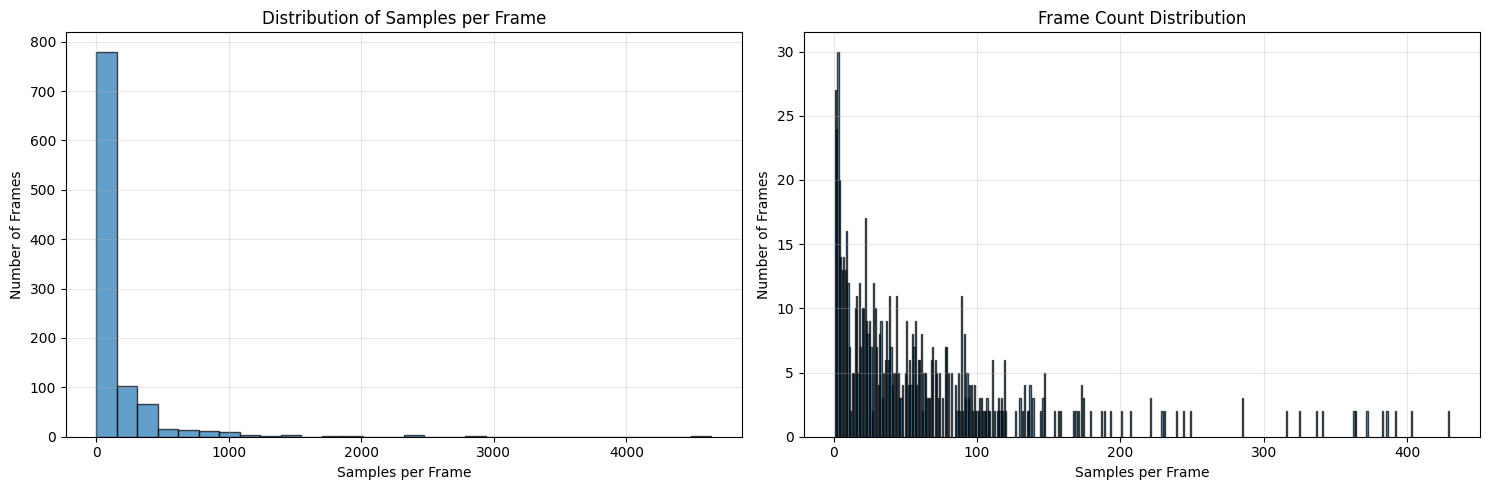


=== Sample Count Distribution ===
 1 samples:  27 frames (  2.7%)
 2 samples:  24 frames (  2.4%)
 3 samples:  30 frames (  3.0%)
 4 samples:  20 frames (  2.0%)
 5 samples:  14 frames (  1.4%)
 6 samples:  13 frames (  1.3%)
 7 samples:  14 frames (  1.4%)
 8 samples:  13 frames (  1.3%)
 9 samples:  16 frames (  1.6%)
10 samples:  12 frames (  1.2%)
11 samples:   7 frames (  0.7%)
12 samples:   2 frames (  0.2%)
13 samples:   5 frames (  0.5%)
14 samples:   5 frames (  0.5%)
15 samples:  10 frames (  1.0%)
16 samples:  11 frames (  1.1%)
17 samples:   5 frames (  0.5%)
18 samples:  12 frames (  1.2%)
19 samples:   7 frames (  0.7%)
20 samples:  10 frames (  1.0%)
... (showing top 20 only)

2. 平衡数据分析

=== Frame Statistics ===
Total frames: 1014
Total samples: 39,536
Average samples per frame: 39.0
Median samples per frame: 30.0
Min samples: 1, Max samples: 80
Standard deviation: 28.9


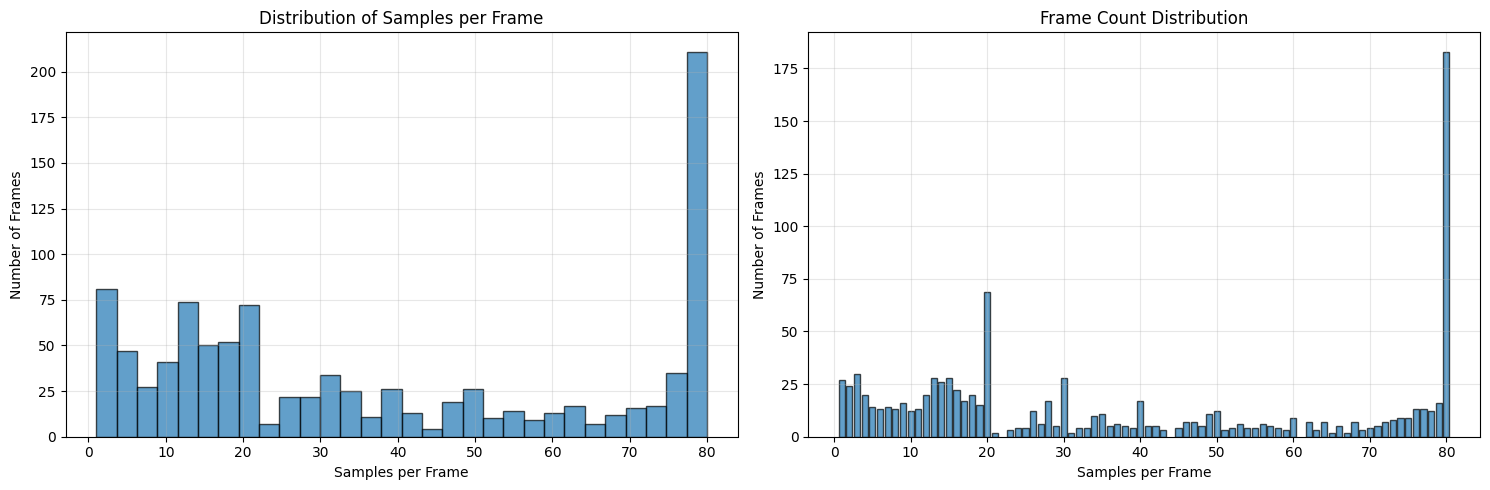


=== Sample Count Distribution ===
 1 samples:  27 frames (  2.7%)
 2 samples:  24 frames (  2.4%)
 3 samples:  30 frames (  3.0%)
 4 samples:  20 frames (  2.0%)
 5 samples:  14 frames (  1.4%)
 6 samples:  13 frames (  1.3%)
 7 samples:  14 frames (  1.4%)
 8 samples:  13 frames (  1.3%)
 9 samples:  16 frames (  1.6%)
10 samples:  12 frames (  1.2%)
11 samples:  13 frames (  1.3%)
12 samples:  20 frames (  2.0%)
13 samples:  28 frames (  2.8%)
14 samples:  26 frames (  2.6%)
15 samples:  28 frames (  2.8%)
16 samples:  22 frames (  2.2%)
17 samples:  17 frames (  1.7%)
18 samples:  20 frames (  2.0%)
19 samples:  15 frames (  1.5%)
20 samples:  69 frames (  6.8%)
... (showing top 20 only)

3. 密度变化分析

=== Density Analysis ===
Frame                     Original   Balanced   Ratio    Reduction
----------------------------------------------------------------------
Self_motion               4639       80         1.72%    98.28%
Stimulus_focus            2897       80         2.76%    97.

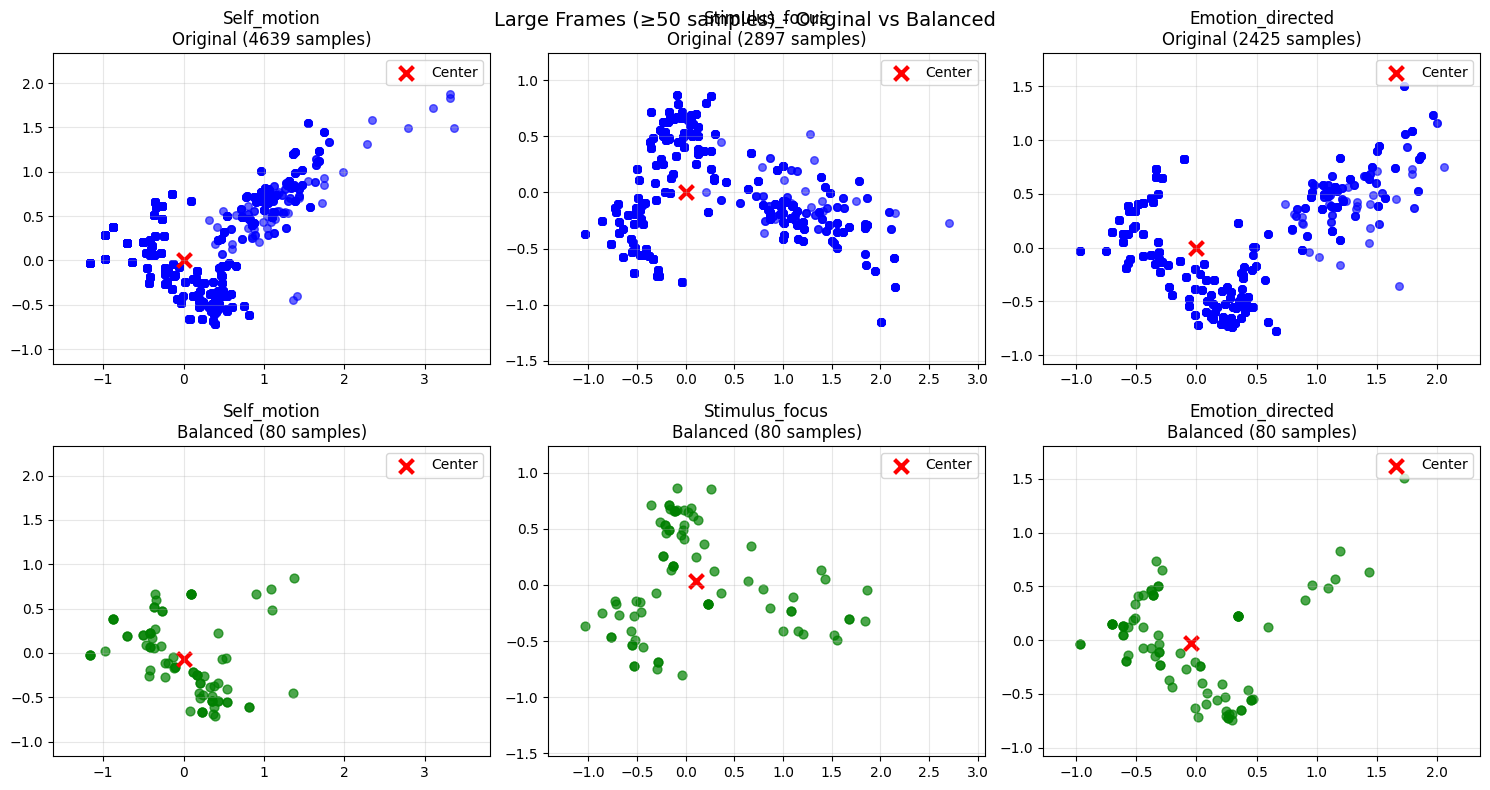


=== Medium Frames (10-49 samples) ===
Selected frames: ['Cause_change_of_phase', 'Conquering', 'Renting']
Extracting embeddings for original dataset...
  Extracted 49 embeddings for Cause_change_of_phase
  Extracted 48 embeddings for Conquering
  Extracted 48 embeddings for Renting
Extracting embeddings for balanced dataset...
  Extracted 30 embeddings for Cause_change_of_phase
  Extracted 30 embeddings for Conquering
  Extracted 25 embeddings for Renting
  Cause_change_of_phase: 49 → 30 (61.22%)
    Center shift: 0.20
    Shape change: 10.3%
  Conquering: 48 → 30 (62.50%)
    Center shift: 0.14
    Shape change: 8.8%
  Renting: 48 → 25 (52.08%)
    Center shift: 0.04
    Shape change: 4.0%


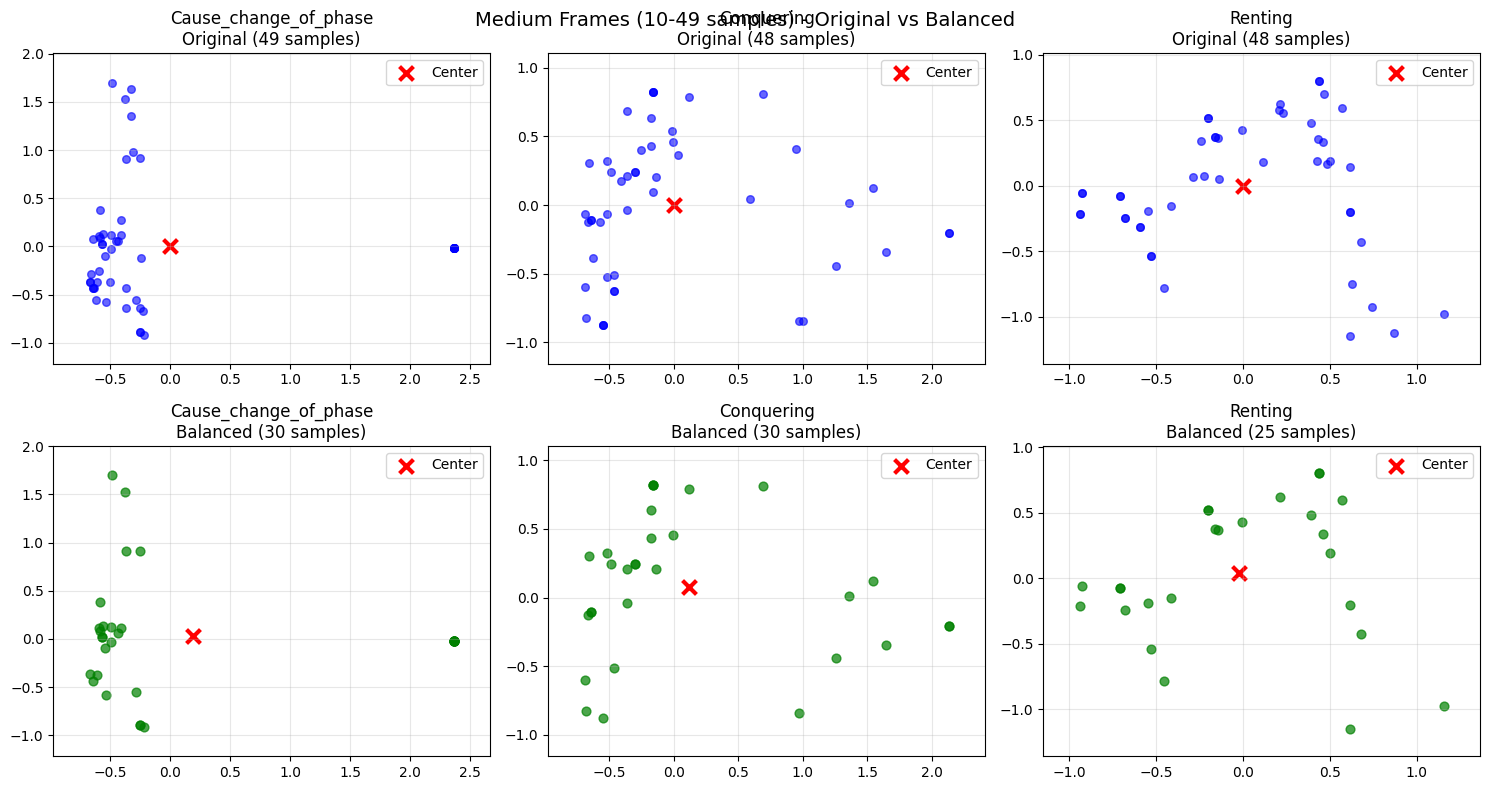


=== Small Frames (<10 samples) ===
Selected frames: ['Jury_deliberation', 'Front_for', 'Regard']
Extracting embeddings for original dataset...
  Extracted 9 embeddings for Jury_deliberation
  Extracted 9 embeddings for Front_for
  Extracted 9 embeddings for Regard
Extracting embeddings for balanced dataset...
  Extracted 9 embeddings for Jury_deliberation
  Extracted 9 embeddings for Front_for
  Extracted 9 embeddings for Regard
  Jury_deliberation: 9 → 9 (100.00%)
    Center shift: 0.00
    Shape change: 0.0%
  Front_for: 9 → 9 (100.00%)
    Center shift: 0.00
    Shape change: 0.0%
  Regard: 9 → 9 (100.00%)
    Center shift: 0.00
    Shape change: 0.0%


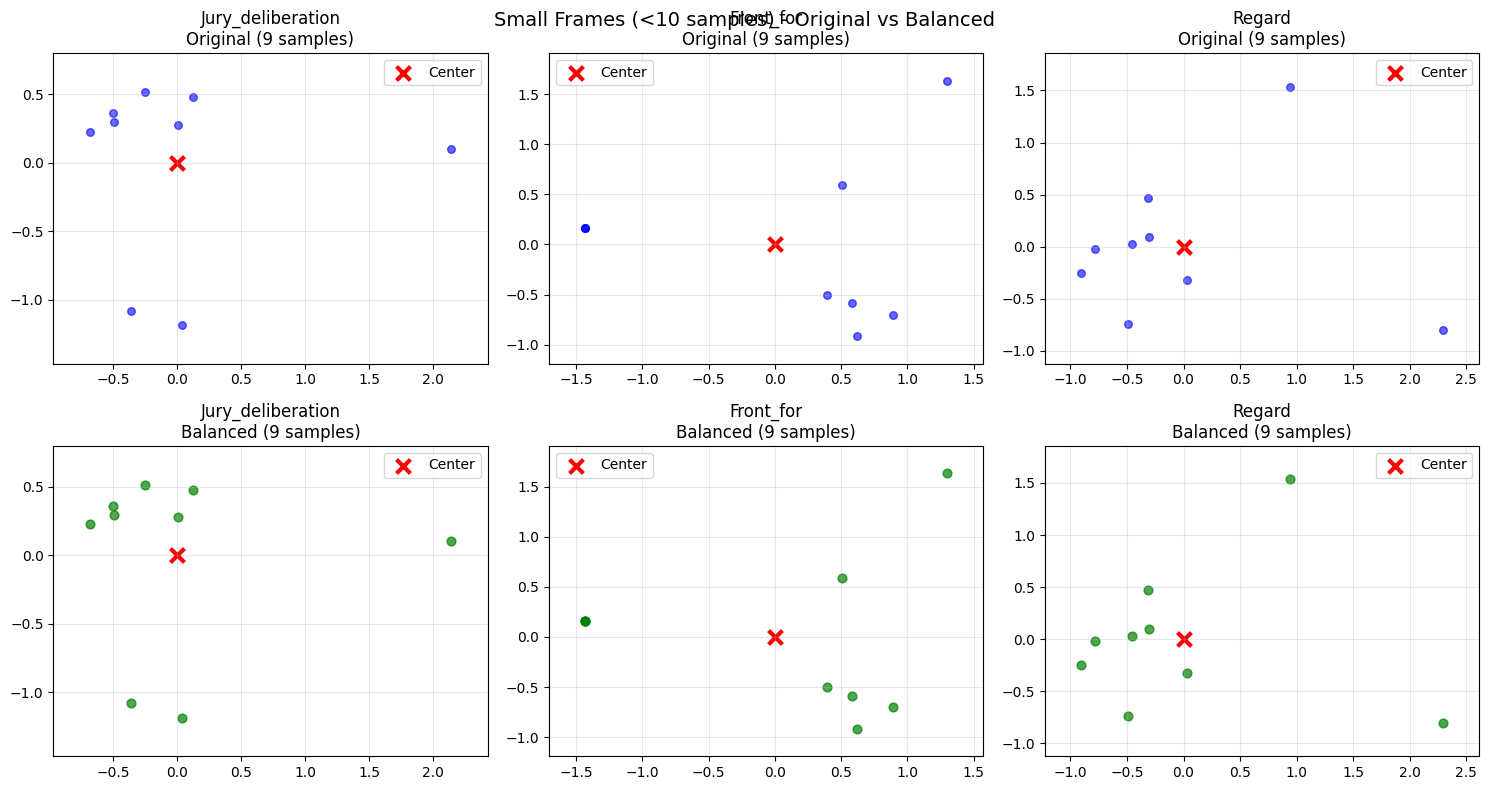


✅ 分析完成!


In [ ]:
# @title 📦 Intelligent Data Balancing可视化

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import torch

def analyze_frame_statistics(df):
    """Analyze frame statistics"""
    frame_counts = df['frame_name'].value_counts()

    print(f"\n=== Frame Statistics ===")
    print(f"Total frames: {len(frame_counts)}")
    print(f"Total samples: {len(df):,}")
    print(f"Average samples per frame: {frame_counts.mean():.1f}")
    print(f"Median samples per frame: {frame_counts.median():.1f}")
    print(f"Min samples: {frame_counts.min()}, Max samples: {frame_counts.max()}")
    print(f"Standard deviation: {frame_counts.std():.1f}")

    return frame_counts

def plot_frame_distribution(frame_counts):
    """Plot frame sample distribution"""

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Histogram of samples per frame
    ax1.hist(frame_counts.values, bins=30, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Samples per Frame')
    ax1.set_ylabel('Number of Frames')
    ax1.set_title('Distribution of Samples per Frame')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Bar chart of specific counts
    count_distribution = Counter(frame_counts.values)
    counts = sorted(count_distribution.keys())
    frequencies = [count_distribution[c] for c in counts]

    # Only show counts with more than 1 occurrence for clarity
    filtered_counts = [(c, f) for c, f in zip(counts, frequencies) if f > 1 or c in [1, 2, 3, 4, 5]]
    if filtered_counts:
        filtered_counts, filtered_freqs = zip(*filtered_counts)
        ax2.bar(filtered_counts, filtered_freqs, edgecolor='black', alpha=0.7)

    ax2.set_xlabel('Samples per Frame')
    ax2.set_ylabel('Number of Frames')
    ax2.set_title('Frame Count Distribution')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics table
    print("\n=== Sample Count Distribution ===")
    for count in sorted(count_distribution.keys())[:20]:  # Show top 20
        freq = count_distribution[count]
        percentage = (freq / len(frame_counts)) * 100
        print(f"{count:2d} samples: {freq:3d} frames ({percentage:5.1f}%)")

    if len(count_distribution) > 20:
        print("... (showing top 20 only)")

def extract_target_embeddings_for_viz(df, selected_frames, model, tokenizer, device):
    """Extract target embeddings for visualization"""

    embeddings_dict = {}

    for frame in selected_frames:
        frame_data = df[df['frame_name'] == frame]
        targets = []
        indices = []

        for idx, row in frame_data.iterrows():
            target_spans = row['target_spans']
            if isinstance(target_spans, list) and len(target_spans) > 0:
                processed_spans = []
                for span in target_spans:
                    if isinstance(span, tuple):
                        processed_spans.append(str(span[0]) if len(span) > 0 else str(span))
                    else:
                        processed_spans.append(str(span))

                target_text = ' '.join(processed_spans) if len(processed_spans) > 1 else processed_spans[0]
                targets.append(target_text)
                indices.append(idx)

        if targets:
            # Batch encode targets
            model.eval()
            embeddings = []
            batch_size = 32

            for i in range(0, len(targets), batch_size):
                batch_targets = targets[i:i+batch_size]
                encoded = tokenizer(
                    batch_targets,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                ).to(device)

                with torch.no_grad():
                    outputs = model(**encoded)
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    embeddings.extend(batch_embeddings)

            embeddings_dict[frame] = {
                'embeddings': np.array(embeddings),
                'indices': indices,
                'targets': targets
            }

            print(f"  Extracted {len(embeddings)} embeddings for {frame}")

    return embeddings_dict

def visualize_sampling_comparison(original_df, balanced_df, model, tokenizer, device, show_categories=True):
    """Visualize density comparison before/after sampling for different frame sizes"""

    # Get frame counts for both datasets
    frame_counts_original = original_df['frame_name'].value_counts()
    frame_counts_balanced = balanced_df['frame_name'].value_counts()

    # Select frames that appear in both datasets
    common_frames = set(frame_counts_original.index) & set(frame_counts_balanced.index)

    if show_categories:
        # Categorize frames by sample count in original dataset
        large_frames = [f for f in frame_counts_original.index if f in common_frames and frame_counts_original[f] >= 50][:3]
        medium_frames = [f for f in frame_counts_original.index if f in common_frames and 10 <= frame_counts_original[f] < 50][:3]
        small_frames = [f for f in frame_counts_original.index if f in common_frames and frame_counts_original[f] < 10][:3]

        categories = [
            ("Large Frames (≥50 samples)", large_frames),
            ("Medium Frames (10-49 samples)", medium_frames),
            ("Small Frames (<10 samples)", small_frames)
        ]

        for category_name, selected_frames in categories:
            if not selected_frames:
                print(f"\n=== {category_name} ===")
                print("No frames found in this category")
                continue

            print(f"\n=== {category_name} ===")
            print(f"Selected frames: {selected_frames}")

            # Extract embeddings for both datasets
            print("Extracting embeddings for original dataset...")
            original_embeddings = extract_target_embeddings_for_viz(original_df, selected_frames, model, tokenizer, device)
            print("Extracting embeddings for balanced dataset...")
            balanced_embeddings = extract_target_embeddings_for_viz(balanced_df, selected_frames, model, tokenizer, device)

            # Create visualization
            n_frames = len(selected_frames)
            fig, axes = plt.subplots(2, n_frames, figsize=(5*n_frames, 8))
            if n_frames == 1:
                axes = axes.reshape(2, 1)

            for i, frame in enumerate(selected_frames):
                if frame not in original_embeddings or frame not in balanced_embeddings:
                    print(f"  Warning: {frame} not found in embeddings")
                    continue

                orig_emb = original_embeddings[frame]['embeddings']
                bal_emb = balanced_embeddings[frame]['embeddings']

                if len(orig_emb) < 2 or len(bal_emb) < 2:
                    print(f"  Warning: {frame} has too few embeddings")
                    continue

                # Use PCA for dimensionality reduction
                pca = PCA(n_components=2, random_state=42)

                # Fit PCA on original data and transform both
                orig_2d = pca.fit_transform(orig_emb)
                bal_2d = pca.transform(bal_emb)

                # Calculate centers for comparison
                orig_center = orig_2d.mean(axis=0)
                bal_center = bal_2d.mean(axis=0)

                # Plot original (top row)
                axes[0, i].scatter(orig_2d[:, 0], orig_2d[:, 1], alpha=0.6, s=30, c='blue')
                axes[0, i].scatter(orig_center[0], orig_center[1], c='red', s=100, marker='x', linewidth=3, label='Center')
                axes[0, i].set_title(f'{frame}\nOriginal ({len(orig_emb)} samples)')
                axes[0, i].grid(True, alpha=0.3)
                axes[0, i].legend()

                # Plot balanced (bottom row)
                axes[1, i].scatter(bal_2d[:, 0], bal_2d[:, 1], alpha=0.7, s=40, c='green')
                axes[1, i].scatter(bal_center[0], bal_center[1], c='red', s=100, marker='x', linewidth=3, label='Center')
                axes[1, i].set_title(f'{frame}\nBalanced ({len(bal_emb)} samples)')
                axes[1, i].grid(True, alpha=0.3)
                axes[1, i].legend()

                # Keep same axis limits for comparison
                x_min = min(orig_2d[:, 0].min(), bal_2d[:, 0].min())
                x_max = max(orig_2d[:, 0].max(), bal_2d[:, 0].max())
                y_min = min(orig_2d[:, 1].min(), bal_2d[:, 1].min())
                y_max = max(orig_2d[:, 1].max(), bal_2d[:, 1].max())

                padding = 0.1 * max(x_max - x_min, y_max - y_min)
                for row in range(2):
                    axes[row, i].set_xlim(x_min - padding, x_max + padding)
                    axes[row, i].set_ylim(y_min - padding, y_max + padding)

                # Calculate and print shape preservation metrics
                center_distance = np.linalg.norm(orig_center - bal_center)
                orig_std = orig_2d.std()
                bal_std = bal_2d.std()
                std_change = abs(bal_std - orig_std) / orig_std if orig_std > 0 else 0

                print(f"  {frame}: {len(orig_emb)} → {len(bal_emb)} ({len(bal_emb)/len(orig_emb):.2%})")
                print(f"    Center shift: {center_distance:.2f}")
                print(f"    Shape change: {std_change:.1%}")

            plt.tight_layout()
            plt.suptitle(f'{category_name} - Original vs Balanced', fontsize=14, y=0.98)
            plt.show()

def analyze_density_metrics(original_df, balanced_df):
    """Analyze quantitative density metrics"""

    frame_counts_orig = original_df['frame_name'].value_counts()
    frame_counts_bal = balanced_df['frame_name'].value_counts()

    print("\n=== Density Analysis ===")
    print(f"{'Frame':<25} {'Original':<10} {'Balanced':<10} {'Ratio':<8} {'Reduction'}")
    print("-" * 70)

    total_orig = 0
    total_bal = 0

    for frame in frame_counts_orig.index[:15]:  # Show top 15 frames
        if frame in frame_counts_bal.index:
            orig_count = frame_counts_orig[frame]
            bal_count = frame_counts_bal[frame]
            ratio = bal_count / orig_count

            total_orig += orig_count
            total_bal += bal_count

            print(f"{frame[:24]:<25} {orig_count:<10} {bal_count:<10} {ratio:<8.2%} {1-ratio:.2%}")

    print("-" * 70)
    print(f"{'TOTAL (top 15)':<25} {total_orig:<10} {total_bal:<10} {total_bal/total_orig:<8.2%} {1-total_bal/total_orig:.2%}")

# 完整的分析流程
def run_complete_analysis(original_df, balanced_df, model, tokenizer, device):
    """Run complete analysis and visualization"""

    print("🔍 开始完整分析...")

    # 1. Frame分布分析
    print("\n" + "="*50)
    print("1. 原始数据分析")
    original_counts = analyze_frame_statistics(original_df)
    plot_frame_distribution(original_counts)

    print("\n" + "="*50)
    print("2. 平衡数据分析")
    balanced_counts = analyze_frame_statistics(balanced_df)
    plot_frame_distribution(balanced_counts)

    # 2. 密度对比分析
    print("\n" + "="*50)
    print("3. 密度变化分析")
    analyze_density_metrics(original_df, balanced_df)

    # 3. 形状保持可视化
    print("\n" + "="*50)
    print("4. 形状保持分析")
    visualize_sampling_comparison(original_df, balanced_df, model, tokenizer, device, show_categories=True)

    print("\n✅ 分析完成!")

# 使用示例
try:
    # 加载数据
    balanced_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl")

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")

    # 运行完整分析
    run_complete_analysis(train_df, balanced_df, model, tokenizer, device)

except Exception as e:
    print(f"❌ 错误: {e}")
    print("请确保所有必要的变量和文件都已加载")

In [ ]:
# @title 🎯 两阶段Target+FE排序实验


def analyze_frame_specific_fe_types(train_df, top_k=2):
    """
    为每个frame分析其最常见的FE类型
    """
    frame_fe_preferences = {}

    print("📊 分析每个frame的FE偏好...")

    for frame_name in tqdm(train_df['frame_name'].unique(), desc="分析FE偏好"):
        frame_data = train_df[train_df['frame_name'] == frame_name]
        fe_counts = Counter()

        for fe_spans in frame_data['fe_spans']:
            if fe_spans and isinstance(fe_spans, list):
                for fe in fe_spans:
                    if isinstance(fe, dict) and 'fe_name' in fe:
                        fe_counts[fe['fe_name']] += 1

        # 获取该frame最常见的top_k个FE
        top_fes = [fe_name for fe_name, count in fe_counts.most_common(top_k)]
        frame_fe_preferences[frame_name] = top_fes

    print(f"✅ 完成FE偏好分析，{len(frame_fe_preferences)}个frames")
    return frame_fe_preferences

def extract_target_embeddings_batch(sentences, target_spans_list, model, tokenizer, device, batch_size=64):
    """
    只提取target embeddings (用于阶段1比较)
    """
    all_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}

    model.eval()

    for batch_start in range(0, len(sentences), batch_size):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_target_spans = target_spans_list[batch_start:batch_end]

        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True,
            return_offsets_mapping=True,
            return_attention_mask=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            last_hidden = outputs.last_hidden_state

            for i in range(len(batch_sentences)):
                try:
                    offset_mapping = encoding['offset_mapping'][i]
                    target_spans = normalize_target_spans(batch_target_spans[i])

                    if not target_spans:
                        embedding = last_hidden[i].mean(dim=0).cpu().numpy()
                        stats["failed"] += 1
                        all_embeddings.append(embedding)
                        continue

                    start_char, end_char = target_spans[0]
                    selected_indices = []

                    for idx, (start, end) in enumerate(offset_mapping):
                        start, end = int(start), int(end)
                        if (start <= start_char < end or start < end_char <= end) and start != end:
                            selected_indices.append(idx)

                    if selected_indices:
                        selected_indices = list(set(selected_indices))
                        selected_hidden = last_hidden[i, selected_indices, :]
                        embedding = selected_hidden.mean(dim=0).cpu().numpy()
                        stats["success"] += 1
                    else:
                        embedding = last_hidden[i].mean(dim=0).cpu().numpy()
                        stats["failed"] += 1

                    all_embeddings.append(embedding)

                except Exception:
                    embedding = last_hidden[i].mean(dim=0).cpu().numpy()
                    all_embeddings.append(embedding)
                    stats["failed"] += 1

    return np.array(all_embeddings), stats

def extract_fe_embeddings_for_query(sentence, fe_spans, preferred_fe_types, model, tokenizer, device):
    """
    为单个查询样本提取FE embeddings
    """
    if not fe_spans or not isinstance(fe_spans, list) or not preferred_fe_types:
        return {}  # 🔥 修复：返回空dict而不是空list

    encoding = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        return_offsets_mapping=True,
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        hidden_states = outputs.last_hidden_state[0]  # [seq_len, hidden_size]
        offset_mapping = encoding['offset_mapping'][0]

        fe_embeddings = {}

        for fe in fe_spans:
            if isinstance(fe, dict) and 'fe_name' in fe and fe['fe_name'] in preferred_fe_types:
                if 'start' in fe and 'end' in fe:
                    start_char, end_char = fe['start'], fe['end']
                    selected_indices = []

                    for idx, (start, end) in enumerate(offset_mapping):
                        start, end = int(start), int(end)
                        if (start <= start_char < end or start < end_char <= end) and start != end:
                            selected_indices.append(idx)

                    if selected_indices:
                        selected_indices = list(set(selected_indices))
                        selected_hidden = hidden_states[selected_indices, :]
                        fe_embedding = selected_hidden.mean(dim=0)
                        fe_embeddings[fe['fe_name']] = fe_embedding

        return fe_embeddings  # 总是返回dict
def truly_batched_two_stage_prediction(query_sentences, query_target_spans, query_fe_spans,
                                       frame_prototypes, frame_fe_prototypes, frame_fe_preferences,
                                       model, tokenizer, device, top_k_stage1=10, fe_boost=0.2):
    """
    批量提取 target 表达的高效两阶段预测函数
    """
    print("⚡ 批量提取 Target embeddings...")
    query_target_embs, _ = extract_target_embeddings_batch(
        query_sentences, query_target_spans, model, tokenizer, device, batch_size=64
    )

    predictions = []
    frame_names = list(frame_prototypes.keys())
    frame_proto_matrix = torch.stack([frame_prototypes[f] for f in frame_names]).to(device)  # [N, D]

    print("🔄 两阶段打分与排序...")

    for i in tqdm(range(len(query_sentences)), desc="预测样本"):
        query_emb = torch.tensor(query_target_embs[i], device=device)  # [D]
        sim_scores = F.cosine_similarity(query_emb.unsqueeze(0), frame_proto_matrix)  # [N]
        candidate_scores = list(zip(frame_names, sim_scores.tolist()))
        candidate_scores.sort(key=lambda x: x[1], reverse=True)
        stage1_candidates = candidate_scores[:top_k_stage1]

        # 第二阶段：引入 FE 排名提升
        sentence = query_sentences[i]
        fe_spans = query_fe_spans[i]
        final_scores = []

        for frame_name, score in stage1_candidates:
            final_score = score
            preferred_fes = frame_fe_preferences.get(frame_name, [])

            if preferred_fes and frame_name in frame_fe_prototypes:
                query_fe_embs = extract_fe_embeddings_for_query(
                    sentence, fe_spans, preferred_fes, model, tokenizer, device
                )
                fe_bonus = 0
                matched = 0

                for fe_name, fe_emb in query_fe_embs.items():
                    if fe_name in frame_fe_prototypes[frame_name]:
                        fe_proto = frame_fe_prototypes[frame_name][fe_name]
                        fe_sim = F.cosine_similarity(fe_emb, fe_proto, dim=0).item()
                        fe_bonus += fe_sim
                        matched += 1

                if matched > 0:
                    fe_bonus = fe_bonus / matched
                    final_score += fe_boost * fe_bonus

            final_scores.append((frame_name, final_score))

        final_scores.sort(key=lambda x: x[1], reverse=True)
        best_frame = final_scores[0][0]
        predictions.append(best_frame)

    return predictions


def build_fe_prototypes(train_df, frame_fe_preferences, model, tokenizer, device):
    """
    为每个frame的preferred FE类型构建原型
    """
    frame_fe_prototypes = {}

    print("🏗️ 构建FE原型...")

    for frame_name in tqdm(frame_fe_preferences.keys(), desc="构建FE原型"):
        preferred_fes = frame_fe_preferences[frame_name]
        if not preferred_fes:
            continue

        frame_data = train_df[train_df['frame_name'] == frame_name]
        fe_embeddings = {fe_name: [] for fe_name in preferred_fes}

        # 收集该frame的FE embeddings
        for _, row in frame_data.iterrows():
            sentence = row['sentence']
            fe_spans = row['fe_spans']

            if fe_spans and isinstance(fe_spans, list):
                query_fe_embs = extract_fe_embeddings_for_query(
                    sentence, fe_spans, preferred_fes, model, tokenizer, device
                )

                for fe_name, fe_emb in query_fe_embs.items():
                    fe_embeddings[fe_name].append(fe_emb.cpu().numpy())

        # 构建FE原型
        frame_fe_prototypes[frame_name] = {}
        for fe_name, emb_list in fe_embeddings.items():
            if len(emb_list) > 0:
                prototype = torch.tensor(emb_list).mean(dim=0).to(device)
                prototype = F.normalize(prototype, p=2, dim=0)
                frame_fe_prototypes[frame_name][fe_name] = prototype

    return frame_fe_prototypes

def run_two_stage_experiment():
    """
    运行两阶段实验 (带缓存)
    """
    print("🚀 两阶段Target+FE排序实验")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"设备: {device}")

    # 加载数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"训练样本: {len(train_df):,}")
    print(f"验证样本: {len(val_df):,}")
    print(f"Frame数量: {len(train_df['frame_name'].unique())}")

    # 🔥 缓存文件路径
    cache_dir = "/content/drive/MyDrive/more50/framenet_data/two_stage_cache"

    os.makedirs(cache_dir, exist_ok=True)

    fe_preferences_cache = os.path.join(cache_dir, "frame_fe_preferences.pkl")
    target_prototypes_cache = os.path.join(cache_dir, "target_prototypes.pkl")
    fe_prototypes_cache = os.path.join(cache_dir, "fe_prototypes.pkl")

    # 🔥 检查并加载FE偏好缓存
    if os.path.exists(fe_preferences_cache):
        print("📦 加载FE偏好缓存...")

        with open(fe_preferences_cache, 'rb') as f:
            frame_fe_preferences = pickle.load(f)
        print(f"✅ 加载了{len(frame_fe_preferences)}个frames的FE偏好")
    else:
        print("📊 分析FE偏好 (首次运行)...")
        frame_fe_preferences = analyze_frame_specific_fe_types(train_df, top_k=2)
        with open(fe_preferences_cache, 'wb') as f:
            pickle.dump(frame_fe_preferences, f)
        print(f"💾 FE偏好已缓存")

    # 初始化模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # 🔥 检查并加载Target原型缓存
    if os.path.exists(target_prototypes_cache):
        print("📦 加载Target原型缓存...")

        with open(target_prototypes_cache, 'rb') as f:
            frame_prototypes = pickle.load(f)
        print(f"✅ 加载了{len(frame_prototypes)}个Target原型")
    else:
        print("\n🏗️ 构建Target原型 (首次运行)...")
        frame_prototypes = {}
        for frame_name in tqdm(train_df['frame_name'].unique(), desc="构建Target原型"):
            frame_data = train_df[train_df['frame_name'] == frame_name]

            sentences = frame_data['sentence'].tolist()
            target_spans_list = frame_data['target_spans'].tolist()

            embeddings, _ = extract_target_embeddings_batch(
                sentences, target_spans_list, model, tokenizer, device, batch_size=32
            )

            if len(embeddings) > 0:
                prototype = build_smart_prototype(embeddings).to(device)
                frame_prototypes[frame_name] = prototype

        with open(target_prototypes_cache, 'wb') as f:
            pickle.dump(frame_prototypes, f)
        print(f"💾 Target原型已缓存")

    # 🔥 检查并加载FE原型缓存
    if os.path.exists(fe_prototypes_cache):
        print("📦 加载FE原型缓存...")

        with open(fe_prototypes_cache, 'rb') as f:
            frame_fe_prototypes = pickle.load(f)
        print(f"✅ 加载了{len(frame_fe_prototypes)}个FE原型")
    else:
        print("🏗️ 构建FE原型 (首次运行)...")
        frame_fe_prototypes = build_fe_prototypes(train_df, frame_fe_preferences, model, tokenizer, device)
        with open(fe_prototypes_cache, 'wb') as f:
            pickle.dump(frame_fe_prototypes, f)
        print(f"💾 FE原型已缓存")

    print(f"\n📊 原型统计:")
    print(f"   Target原型: {len(frame_prototypes)}")
    print(f"   FE原型frames: {len(frame_fe_prototypes)}")

    # 验证集测试
    print(f"\n🎯 验证集测试...")

    val_sentences = val_df['sentence'].tolist()
    val_target_spans = val_df['target_spans'].tolist()
    val_fe_spans = val_df['fe_spans'].tolist()
    val_true_frames = val_df['frame_name'].tolist()

    # 两阶段预测 (真正批量化版)
    predictions = truly_batched_two_stage_prediction(
        val_sentences, val_target_spans, val_fe_spans,
        frame_prototypes, frame_fe_prototypes, frame_fe_preferences,
        model, tokenizer, device, top_k_stage1=10, fe_boost=0.2
    )

    # 计算准确率
    correct = sum(1 for pred, true in zip(predictions, val_true_frames) if pred == true)
    accuracy = correct / len(val_true_frames)

    print(f"\n🎯 两阶段结果:")
    print(f"   验证集准确率: {accuracy:.4f} ({correct:,}/{len(val_true_frames):,})")

    baseline_accuracy = 0.76
    improvement = accuracy - baseline_accuracy
    print(f"   Baseline: {baseline_accuracy:.4f}")
    print(f"   改进: {improvement:+.4f} ({improvement/baseline_accuracy*100:+.2f}%)")

    return accuracy, frame_prototypes, frame_fe_prototypes

def build_smart_prototype(embeddings):
    """智能原型构建"""
    embeddings_tensor = torch.tensor(embeddings, device='cuda')
    n_samples = embeddings_tensor.size(0)

    if n_samples == 1:
        return F.normalize(embeddings_tensor[0], p=2, dim=0)

    if n_samples > 5:
        mean_emb = embeddings_tensor.mean(dim=0)
        distances = torch.norm(embeddings_tensor - mean_emb.unsqueeze(0), dim=1)

        keep_ratio = 0.8
        threshold_idx = int(n_samples * keep_ratio)
        _, sorted_indices = torch.sort(distances)
        keep_indices = sorted_indices[:threshold_idx]

        filtered_embeddings = embeddings_tensor[keep_indices]
        filtered_distances = distances[keep_indices]
        max_dist = filtered_distances.max()
        weights = (max_dist - filtered_distances + 1e-6)
        weights = weights / weights.sum()

        prototype = torch.sum(filtered_embeddings * weights.unsqueeze(1), dim=0)
    else:
        prototype = embeddings_tensor.mean(dim=0)

    return F.normalize(prototype, p=2, dim=0)

"""
# 运行实验
if __name__ == "__main__":
    accuracy, target_prototypes, fe_prototypes = run_two_stage_experiment()
"""

'\n# 运行实验\nif __name__ == "__main__":\n    accuracy, target_prototypes, fe_prototypes = run_two_stage_experiment()\n'

In [ ]:
# @title 🎯 Multi-Prototype Initialization System

def adaptive_k_selection_dbi_improved(frame_embeddings, max_k=8, min_samples_for_clustering=6):
    """改进的DBI自适应选择K值"""
    n_samples = len(frame_embeddings)

    # 样本太少无法有效聚类
    if n_samples < 3:
        return 1, float('inf'), ["Too few samples (< 3)"]
    elif n_samples < min_samples_for_clustering:
        # 3-5个样本，最多尝试2个原型
        return min(2, n_samples - 1), float('inf'), [f"Small sample size ({n_samples}), using K={min(2, n_samples - 1)}"]

    best_k = 1
    best_score = float('inf')
    scores_info = []

    # 从k=2开始尝试（k=1的DBI无意义）
    for k in range(2, min(max_k + 1, n_samples)):
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)
            labels = kmeans.fit_predict(frame_embeddings)

            # 检查聚类是否成功
            unique_labels = np.unique(labels)
            if len(unique_labels) < k:
                scores_info.append(f"K={k}: Failed (empty clusters)")
                continue

            dbi_score = davies_bouldin_score(frame_embeddings, labels)
            scores_info.append(f"K={k}: DBI={dbi_score:.3f}")

            if dbi_score < best_score:
                best_score = dbi_score
                best_k = k

        except Exception as e:
            scores_info.append(f"K={k}: Error ({str(e)[:30]})")
            continue

    # 如果没有找到好的聚类，使用K=1
    if best_score == float('inf'):
        best_k = 1
        scores_info.append("No valid clustering found, using K=1")

    return best_k, best_score, scores_info

def extract_target_embeddings_batch(sentences, target_spans_list, model, tokenizer, device, batch_size=16):
    """批量提取target embeddings - 使用span位置标注"""

    all_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}

    # 分批处理
    for batch_start in range(0, len(sentences), batch_size):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_target_spans = target_spans_list[batch_start:batch_end]

        # 批量编码句子
        encoded = tokenizer(
            batch_sentences,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding=True,
            return_offsets_mapping=True  # 关键：获取token到字符的映射
        ).to(device)

        offset_mappings = encoded.pop('offset_mapping')  # [batch_size, seq_len, 2]

        with torch.no_grad():
            outputs = model(**encoded)
            hidden_states = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]

            # 处理batch中的每个样本
            for i, (sentence, target_spans) in enumerate(zip(batch_sentences, batch_target_spans)):
                try:
                    # 处理target_spans格式
                    if isinstance(target_spans, list) and len(target_spans) > 0:
                        if isinstance(target_spans[0], tuple) and len(target_spans[0]) >= 2:
                            # 使用span位置信息
                            spans = [(int(span[0]), int(span[1])) for span in target_spans if len(span) >= 2]
                        else:
                            # 退化到字符串匹配
                            target_text = str(target_spans[0])
                            spans = find_spans_by_text(sentence, target_text)
                    else:
                        target_text = str(target_spans)
                        spans = find_spans_by_text(sentence, target_text)

                    if not spans:
                        stats["failed"] += 1
                        # 使用句子中间的token（避免[CLS]和[SEP]）
                        middle_pos = hidden_states.size(1) // 2
                        target_emb = hidden_states[i, middle_pos, :].cpu().numpy()
                        all_embeddings.append(target_emb)
                        continue

                    # 将字符span转换为token positions
                    target_token_positions = []
                    current_offset_mapping = offset_mappings[i]  # [seq_len, 2]

                    for char_start, char_end in spans:
                        # 找到覆盖该字符范围的所有tokens
                        for token_idx, (token_start, token_end) in enumerate(current_offset_mapping):
                            token_start, token_end = int(token_start), int(token_end)

                            # 检查token是否与target span有重叠
                            if (token_start < char_end and token_end > char_start and
                                token_start != token_end):  # 排除特殊token
                                target_token_positions.append(token_idx)

                    if target_token_positions:
                        # 对target tokens进行平均池化
                        target_positions = torch.tensor(target_token_positions, device=device)
                        target_emb = torch.mean(hidden_states[i, target_positions, :], dim=0).cpu().numpy()
                        stats["success"] += 1
                    else:
                        # 找不到对应token，使用中间token
                        middle_pos = hidden_states.size(1) // 2
                        target_emb = hidden_states[i, middle_pos, :].cpu().numpy()
                        stats["failed"] += 1

                    all_embeddings.append(target_emb)

                except Exception as e:
                    stats["failed"] += 1
                    # 出错时使用中间token
                    middle_pos = hidden_states.size(1) // 2
                    target_emb = hidden_states[i, middle_pos, :].cpu().numpy()
                    all_embeddings.append(target_emb)

    return np.array(all_embeddings), stats

def find_spans_by_text(sentence, target_text):
    """字符串匹配找span位置（fallback方法）"""
    spans = []
    sentence_lower = sentence.lower()
    target_lower = target_text.lower().strip()

    if target_lower and len(target_lower) > 0:
        start = 0
        while True:
            pos = sentence_lower.find(target_lower, start)
            if pos == -1:
                break
            spans.append((pos, pos + len(target_lower)))
            start = pos + 1

    return spans

def extract_target_embeddings_for_frame(frame_data, model, tokenizer, device, batch_size=16):
    """为单个frame批量提取target embeddings"""
    sentences = frame_data['sentence'].tolist()
    target_spans_list = frame_data['target_spans'].tolist()

    return extract_target_embeddings_batch(sentences, target_spans_list, model, tokenizer, device, batch_size)

def analyze_frames_and_build_prototypes(train_df, output_dir="/content/drive/MyDrive/more50/framenet_data",
                                       force_regenerate=False, verbose=True):
    """分析所有frame并构建初始原型 - 强制使用target span平均池化"""

    print(f"=== Multi-Prototype Initialization ===")
    print(f"Embedding Strategy: TARGET SPAN AVERAGE POOLING (Mandatory)")
    print(f"  → Locating target spans in sentences and averaging target token embeddings")
    print(f"  → NO fallback to sentence [CLS] token allowed!")

    # 检查是否已有结果
    config_file = os.path.join(output_dir, f"frame_analysis_config_target_pooling.pkl")
    prototypes_file = os.path.join(output_dir, f"initial_prototypes_target_pooling.pkl")

    if not force_regenerate and os.path.exists(config_file) and os.path.exists(prototypes_file):
        print(f"Loading existing analysis from {config_file}")
        with open(config_file, 'rb') as f:
            config_data = pickle.load(f)

        with open(prototypes_file, 'rb') as f:
            prototypes_data = pickle.load(f)

        print(f"Loaded {len(config_data['frame_configs'])} frames")
        return config_data, prototypes_data

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    model.eval()

    print(f"Analyzing {len(train_df['frame_name'].unique())} frames...")

    frame_configs = {}
    frame_embeddings = {}
    frame_prototypes = {}
    detailed_analysis = {}
    overall_stats = {"success": 0, "failed": 0}

    # 处理每个frame
    for frame_name in tqdm(train_df['frame_name'].unique(), desc="Processing frames"):
        frame_data = train_df[train_df['frame_name'] == frame_name]
        n_samples = len(frame_data)

        # 提取embeddings - 强制target pooling
        embeddings, frame_stats = extract_target_embeddings_for_frame(frame_data, model, tokenizer, device)

        # 累计统计
        overall_stats["success"] += frame_stats["success"]
        overall_stats["failed"] += frame_stats["failed"]

        # 确定K值
        k, dbi_score, scores_info = adaptive_k_selection_dbi_improved(embeddings)

        # 生成原型
        if k == 1:
            prototypes = [np.mean(embeddings, axis=0)]
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(embeddings)
            prototypes = kmeans.cluster_centers_.tolist()

        # 保存结果
        frame_configs[frame_name] = k
        frame_embeddings[frame_name] = embeddings
        frame_prototypes[frame_name] = prototypes

        # 详细分析信息
        detailed_analysis[frame_name] = {
            'n_samples': n_samples,
            'k_selected': k,
            'dbi_score': dbi_score,
            'scores_info': scores_info,
            'embedding_dim': embeddings.shape[1],
            'target_pooling_stats': frame_stats
        }

        if verbose and k > 1:  # 只显示多原型的frame
            success_rate = frame_stats["success"] / n_samples * 100
            print(f"  {frame_name}: {n_samples} samples → K={k} (DBI={dbi_score:.3f}, target_success={success_rate:.1f}%)")

    # 打印target pooling统计
    total_samples = overall_stats["success"] + overall_stats["failed"]
    success_rate = overall_stats["success"] / total_samples * 100 if total_samples > 0 else 0

    print(f"\n=== TARGET POOLING STATISTICS ===")
    print(f"Successfully found and pooled targets: {success_rate:.1f}% ({overall_stats['success']}/{total_samples})")
    print(f"Failed to locate targets: {(100-success_rate):.1f}% ({overall_stats['failed']}/{total_samples})")

    if overall_stats["failed"] > 0:
        print(f"⚠️  {overall_stats['failed']} cases failed target location")

    # 统计分析
    k_counts = Counter(frame_configs.values())
    print(f"\n=== Frame Analysis Summary ===")
    print(f"Total frames: {len(frame_configs)}")
    for k, count in sorted(k_counts.items()):
        print(f"  K={k}: {count} frames ({count/len(frame_configs)*100:.1f}%)")

    # 保存配置
    config_data = {
        'frame_configs': frame_configs,
        'detailed_analysis': detailed_analysis,
        'target_pooling_stats': overall_stats,
        'summary_stats': {
            'total_frames': len(frame_configs),
            'k_distribution': dict(k_counts),
            'total_prototypes': sum(frame_configs.values())
        },
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'method': 'dbi_improved_target_pooling_only'
    }

    prototypes_data = {
        'frame_prototypes': frame_prototypes,
        'frame_embeddings': frame_embeddings,
        'timestamp': config_data['timestamp']
    }

    # 保存到文件
    os.makedirs(output_dir, exist_ok=True)

    with open(config_file, 'wb') as f:
        pickle.dump(config_data, f)

    with open(prototypes_file, 'wb') as f:
        pickle.dump(prototypes_data, f)

    print(f"\nAnalysis saved to:")
    print(f"  Config: {config_file}")
    print(f"  Prototypes: {prototypes_file}")

    return config_data, prototypes_data

def inspect_frame_details(frame_name, config_data, prototypes_data, top_n=5):
    """检查特定frame的详细信息"""

    if frame_name not in config_data['frame_configs']:
        print(f"Frame '{frame_name}' not found!")
        return

    analysis = config_data['detailed_analysis'][frame_name]
    k = config_data['frame_configs'][frame_name]
    prototypes = prototypes_data['frame_prototypes'][frame_name]

    print(f"\n=== Frame Analysis: {frame_name} ===")
    print(f"Samples: {analysis['n_samples']}")
    print(f"Selected K: {k}")
    print(f"DBI Score: {analysis['dbi_score']:.3f}")
    print(f"Embedding Dimension: {analysis['embedding_dim']}")

    print(f"\nScoring Details:")
    for info in analysis['scores_info']:
        print(f"  {info}")

    print(f"\nPrototypes: {len(prototypes)} vectors of dimension {len(prototypes[0])}")

# 执行分析
if __name__ == "__main__":
    # 加载数据
    train_file = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
    train_df = pd.read_pickle(train_file)

    print(f"Loaded training data: {len(train_df)} samples, {len(train_df['frame_name'].unique())} frames")

    # 分析并构建原型
    config_data, prototypes_data = analyze_frames_and_build_prototypes(
        train_df,
        force_regenerate=False,  # 设为False可以重用已有结果
        verbose=False  # 关闭详细输出，只显示总进度条
    )

    # 检查一些有趣的cases
    print(f"\n=== Inspecting Some Cases ===")

    # 找一些K>1的frame
    multi_prototype_frames = [frame for frame, k in config_data['frame_configs'].items() if k > 1]
    if multi_prototype_frames:
        inspect_frame_details(multi_prototype_frames[0], config_data, prototypes_data)

    # 找一些样本数多的frame
    large_frames = [(frame, config_data['detailed_analysis'][frame]['n_samples'])
                   for frame in config_data['frame_configs'].keys()]
    large_frames.sort(key=lambda x: x[1], reverse=True)

    if large_frames:
        inspect_frame_details(large_frames[0][0], config_data, prototypes_data)

Loaded training data: 39291 samples, 1014 frames
=== Multi-Prototype Initialization ===
Embedding Strategy: TARGET SPAN AVERAGE POOLING (Mandatory)
  → Locating target spans in sentences and averaging target token embeddings
  → NO fallback to sentence [CLS] token allowed!
Loading existing analysis from /content/drive/MyDrive/more50/framenet_data/frame_analysis_config_target_pooling.pkl
Loaded 1014 frames

=== Inspecting Some Cases ===

=== Frame Analysis: Accoutrements ===
Samples: 80
Selected K: 8
DBI Score: 2.367
Embedding Dimension: 768

Scoring Details:
  K=2: DBI=3.715
  K=3: DBI=3.259
  K=4: DBI=2.946
  K=5: DBI=2.793
  K=6: DBI=2.753
  K=7: DBI=2.532
  K=8: DBI=2.367

Prototypes: 8 vectors of dimension 768

=== Frame Analysis: Accoutrements ===
Samples: 80
Selected K: 8
DBI Score: 2.367
Embedding Dimension: 768

Scoring Details:
  K=2: DBI=3.715
  K=3: DBI=3.259
  K=4: DBI=2.946
  K=5: DBI=2.793
  K=6: DBI=2.753
  K=7: DBI=2.532
  K=8: DBI=2.367

Prototypes: 8 vectors of dimens

In [ ]:
# @title 🧠 Triplet Dataset + Loss

def build_relation_matrix(frame_relations):
    relation_matrix = {}
    for frame, relations in frame_relations.items():
        for target_frame, rel_type, direction, _ in relations:
            relation_matrix[(frame, target_frame)] = rel_type
            if direction in ["in", "out", "undirected"]:
                relation_matrix[(target_frame, frame)] = rel_type
    return relation_matrix


class FrameNetTripletDataset(Dataset):
    def __init__(
        self,
        df,
        frame_relations,
        use_hard_negatives=False,
        frame_names=None,
        frame_similarity_matrix=None,
        top_k_hard=10,
        use_easy_positive=False,
        span_embeddings=None
    ):
        """
        Args:
            df: DataFrame 包含所有训练样本
            frame_relations: FrameNet 关系结构字典
            use_hard_negatives: 是否启用困难负例策略
            frame_names: 与 similarity_matrix 对应的顺序
            frame_similarity_matrix: 原型相似度矩阵
            top_k_hard: 每个 anchor frame 挑选 top-K 最相似、且语义相关的 frames
            use_easy_positive: 是否启用“从易到难”正例选择策略
            span_embeddings: 每个样本的 target span 向量（顺序与 df 一致）
        """
        self.df = df.reset_index(drop=True)
        self.frame2idx = df.groupby('frame_name').indices
        self.frame_relations = frame_relations
        self.relation_matrix = build_relation_matrix(frame_relations)

        self.use_hard_negatives = use_hard_negatives
        self.sim_matrix = frame_similarity_matrix
        self.frame_names = frame_names
        self.name2idx = {f: i for i, f in enumerate(frame_names)} if frame_names else {}
        self.top_k_hard = top_k_hard

        self.use_easy_positive = use_easy_positive
        self.span_embeddings = span_embeddings

        self.related_frames = {
            frame: {f2 for (f1, f2), rel in self.relation_matrix.items()
                    if f1 == frame and f2 != frame}
            for frame in df['frame_name'].unique()
        }

    def __len__(self):
        return len(self.df)

    def get_hard_negative(self, anchor_frame):
        if anchor_frame not in self.name2idx:
            return None

        idx = self.name2idx[anchor_frame]
        sim_row = self.sim_matrix[idx]
        top_indices = np.argsort(sim_row)[::-1]

        hard_candidates = []
        for j in top_indices:
            f2 = self.frame_names[j]
            if f2 != anchor_frame and f2 in self.frame2idx and f2 in self.related_frames.get(anchor_frame, set()):
                hard_candidates.append(f2)
            if len(hard_candidates) >= self.top_k_hard:
                break

        return random.choice(hard_candidates) if hard_candidates else None

    def __getitem__(self, idx):
        anchor = self.df.iloc[idx]
        anchor_frame = anchor['frame_name']
        pos_indices = self.frame2idx[anchor_frame]
        pos_candidates = [i for i in pos_indices if i != idx]

        # === Positive sampling
        if self.use_easy_positive and self.span_embeddings and len(pos_candidates) >= 2:
            anchor_emb = self.span_embeddings[idx]
            candidate_embs = torch.stack([self.span_embeddings[i] for i in pos_candidates])
            sims = F.cosine_similarity(anchor_emb.unsqueeze(0), candidate_embs)
            top_k = min(5, len(sims))
            top_idx = sims.topk(top_k).indices.tolist()
            selected_idx = pos_candidates[random.choice(top_idx)]
            positive = self.df.iloc[selected_idx]
        else:
            pos_idx = random.choice(pos_candidates) if pos_candidates else idx
            positive = self.df.iloc[pos_idx]

        # === Negative sampling
        neg_frame = None
        if self.use_hard_negatives:
            neg_frame = self.get_hard_negative(anchor_frame)

        if not neg_frame:
            if random.random() < 0.5:
                unrelated = [f for f in self.frame2idx if f != anchor_frame and
                             f not in self.related_frames.get(anchor_frame, set())]
                if unrelated:
                    neg_frame = random.choice(unrelated)
            else:
                related = list(self.related_frames.get(anchor_frame, set()))
                if related:
                    neg_frame = random.choice(related)

        if not neg_frame or neg_frame not in self.frame2idx:
            candidates = [f for f in self.frame2idx if f != anchor_frame]
            neg_frame = random.choice(candidates) if candidates else anchor_frame

        neg_idx = random.choice(self.frame2idx[neg_frame])
        negative = self.df.iloc[neg_idx]

        relation_type = self.relation_matrix.get((anchor_frame, neg_frame), "Unrelated")

        return {
            'anchor': {
                'sentence': anchor['sentence'],
                'target_spans': anchor['target_spans'],
                'frame_name': anchor_frame
            },
            'positive': {
                'sentence': positive['sentence'],
                'target_spans': positive['target_spans'],
                'frame_name': anchor_frame
            },
            'negative': {
                'sentence': negative['sentence'],
                'target_spans': negative['target_spans'],
                'frame_name': neg_frame
            },
            'relation_type': relation_type
        }




class RelationAwareTripletLoss(nn.Module):
    def __init__(self, relation_types=None, init_margin=0.5):
        super().__init__()
        self.relation_types = relation_types or FRAMENET_RELATION_TYPES
        self.margin_params = nn.ParameterDict({
            rel: nn.Parameter(torch.tensor(init_margin)) for rel in self.relation_types
        })

    def forward(self, anchor_emb, positive_emb, negative_emb, relation_type=None):
        # 🔁 使用余弦距离（cosine distance）
        pos_dist = 1 - F.cosine_similarity(anchor_emb, positive_emb, dim=-1)
        neg_dist = 1 - F.cosine_similarity(anchor_emb, negative_emb, dim=-1)

        device = anchor_emb.device  # 🔧 确保在相同设备上
        batch_margins = []
        for rel in relation_type:
            margin_param = self.margin_params.get(rel, self.margin_params['Unrelated'])
            margin = F.softplus(margin_param).to(device)
            batch_margins.append(margin)
        batch_margins = torch.stack(batch_margins)


        triplet_loss = F.relu(pos_dist - neg_dist + batch_margins)
        return triplet_loss.mean()


# 🔧 Functional wrapper
_loss_module = None

def comprehensive_triplet_loss(
    anchor_emb,
    positive_emb,
    negative_emb,
    relation_type=None
):
    global _loss_module
    if _loss_module is None:
        _loss_module = RelationAwareTripletLoss()
    return _loss_module(
        anchor_emb=anchor_emb,
        positive_emb=positive_emb,
        negative_emb=negative_emb,
        relation_type=relation_type
    )
